Loading frames 1 to 501


frame:   0%|          | 0/500 [00:00<?, ?it/s]

Frameset: reflective_primitives_256, 500 frames with 13 channels JIT enabled
(500, 256, 256, 39)
Frameset: reflective_primitivesRGB_train, 400 frames with 1 channels JIT enabled
Frameset: reflective_primitivesCond_train, 400 frames with 3 channels JIT enabled


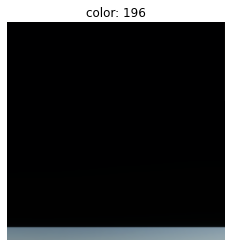

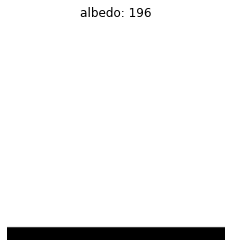

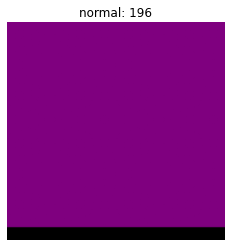

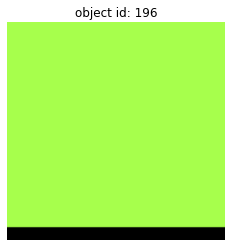

In [1]:
%load_ext autoreload
%autoreload 2

# load new frame-set

from repos.pyjunk.junktools.frameset import frameset

frameset_res = 256
#strNewFramesetName = 'primitives_64_wht'
strFramesetBaseName = 'reflective_primitives'
strFramesetName = strFramesetBaseName + '_' + str(frameset_res)
img_size = 32
batch_size = 128
test_batch_size = 128
#num_frames = 4900
#num_frames = 100
num_frames = None

orig_frameset = frameset(strFramesetName, num_frames=num_frames, fJITLoading=True, fVerbose=False)
orig_frameset.Print()
print(orig_frameset.shape())

# split primitives into train and test

frameset_train, frameset_test = orig_frameset.split_into_train_and_test(0.8)

# Split up into Conditional and RGB Target framesets
framesetRGB_train = frameset(
    sourceFrameset=frameset_train, 
    strNewFramesetName = strFramesetBaseName + "RGB_train", 
    sourceChannels=['Color']
)

framesetRGB_test = frameset(
    sourceFrameset=frameset_test, 
    strNewFramesetName = strFramesetBaseName + "RGB_test", 
    sourceChannels=['Color']
)

framesetCond_train = frameset(
    sourceFrameset=frameset_train,
    strNewFramesetName= strFramesetBaseName + "Cond_train",
    sourceChannels=[
        'albedo',
        'normal',
        'object id',
    ]
)

framesetCond_test = frameset(
    sourceFrameset=frameset_test,
    strNewFramesetName= strFramesetBaseName + "Cond_test",
    sourceChannels=[
        'albedo',
        'normal',
        'object id',
    ]
)

# Just to confirm frames match yo
frameid = 3
framesetRGB_train.Print()
framesetRGB_train[frameid].visualize()

framesetCond_train.Print()
framesetCond_train[frameid].visualize()
# #framesetCond.visualize()
# #framesetRGB.visualize()



In [2]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import random

# Conv VAE
# Only learns the distribution of the target RGB images
# This network doesn't need anything outside of the target images and is entirely unsupervised 

from repos.pyjunk.models.Model import Model
from repos.pyjunk.models.SpatialViewCondConvVAE import SpatialViewCondConvVAE
from repos.pyjunk.junktools.frameset import frameset
from repos.pyjunk.solvers.CondConvVAETorchSolver import CondConvVAETorchSolver

import repos.pyjunk.junktools.pytorch_utils as ptu
ptu.SetGPUMode(True)

# Set up model
num_rgb, H_rgb, W_rgb, C_rgb = framesetRGB_train.shape()
num_cond, H_cond, W_cond, C_cond = framesetCond_train.shape()

latent_dim = 5
batch_size = 20
test_batch_size = 5
view_dim = 7

#print("input dims: %d, %d, %d" % (H_frames, W_frames, C_frames))
print("target dims: %d, %d, %d  cond dim %d" % (H_rgb, W_rgb, C_rgb, C_cond))

modelConvVAE = SpatialViewCondConvVAE(
    input_shape=(H_rgb, W_rgb, C_rgb),
    latent_dim=latent_dim,
    view_dim=7,
    num_filters = 128,
    num_layers = 6,
    cond_dim = C_cond
)

# # # Test model
# npFrameBuffer = framesetRGB_train[0].GetNumpyBuffer()
# torchImageBuffer = torch.FloatTensor(npFrameBuffer)
# torchImageBuffer = torchImageBuffer.unsqueeze(0).to(ptu.GetDevice())
# print(torchImageBuffer.shape)
# torchImageBuffer = torchImageBuffer.permute(0, 3, 1, 2)
# modelConvVAE.encoder.forward(torchImageBuffer)

# loss = modelConvVAE.loss_with_frame(framesetRGB_train[2], framesetCond_train[2])
# print(loss)

# frameid = random.randint(0, framesetCond_test.num_frames - 1)
# gen_image = modelConvVAE.generate_with_cond_frame(framesetCond_test[frameid])
# gen_image.visualize()

# Set up the solver
dictSolverParams = {
    'lr': 1e-4,
    'epochs': 100000,
    'strOptimizer': 'Adam',
    'batch_size': batch_size,
    'test_batch_size': test_batch_size,
}

# Train on frameset (no minibatching yet)
solver = CondConvVAETorchSolver(modelConvVAE, dictSolverParams)
solver.train_frameset_and_plot_losses(
    train_frameset=framesetRGB_train, train_cond_frameset=framesetCond_train,
    test_frameset=framesetRGB_test, test_cond_frameset=framesetCond_test,
    fVerbose=True)

# # # # Sample the network
# # # sampleImages = modelConvVAE.sample(10)
# # # sampleImages[0].visualize()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
target dims: 256, 256, 3  cond dim 9
3
spatial 256 -> 128 depth 8 -> 16
spatial 128 -> 64 depth 16 -> 32
spatial 64 -> 32 depth 32 -> 64
spatial 32 -> 16 depth 64 -> 128
spatial 16 -> 8 depth 128 -> 256
linear 2048 -> 10
training on frames [364, 240, 78, 162, 346, 388, 28, 249, 194, 217, 329, 339, 252, 231, 239, 228, 227, 75, 277, 312] in frameset reflective_primitivesRGB_train
testing on frames [45, 58, 14, 41, 18] in frameset reflective_primitivesRGB_test
Epoch 0, Test loss 91.3190
training on frames [68, 212, 120, 81, 141, 333, 222, 66, 214, 182, 0, 118, 290, 323, 32, 315, 251, 262, 150, 46] in frameset reflective_primitivesRGB_train
testing on frames [0, 74, 6, 96, 12] in frameset reflective_primitivesRGB_test
Epoch 1, Test loss 135.8088
training on frames [366, 311, 26, 25, 63, 178, 209, 364, 318, 234, 374, 142, 92, 195, 360, 190, 240, 36, 322, 19] in frameset reflective_primitivesRGB_train
tes

Epoch 29, Test loss 24.8422
training on frames [18, 38, 226, 398, 158, 51, 301, 80, 219, 370, 357, 318, 203, 83, 122, 322, 224, 388, 241, 387] in frameset reflective_primitivesRGB_train
testing on frames [5, 3, 12, 65, 57] in frameset reflective_primitivesRGB_test
Epoch 30, Test loss 39.2772
training on frames [211, 107, 92, 270, 252, 360, 263, 352, 9, 50, 15, 38, 219, 81, 205, 169, 322, 215, 44, 75] in frameset reflective_primitivesRGB_train
testing on frames [76, 12, 56, 72, 79] in frameset reflective_primitivesRGB_test
Epoch 31, Test loss 41.1216
training on frames [136, 277, 206, 266, 62, 70, 133, 315, 18, 330, 179, 234, 387, 132, 345, 52, 2, 156, 262, 300] in frameset reflective_primitivesRGB_train
testing on frames [59, 20, 40, 60, 32] in frameset reflective_primitivesRGB_test
Epoch 32, Test loss 38.3662
training on frames [141, 315, 282, 245, 281, 100, 2, 247, 35, 241, 358, 288, 300, 392, 283, 190, 159, 375, 319, 298] in frameset reflective_primitivesRGB_train
testing on frames 

Epoch 60, Test loss 29.6795
training on frames [5, 291, 53, 44, 51, 115, 228, 246, 288, 183, 358, 109, 201, 170, 61, 52, 266, 234, 138, 140] in frameset reflective_primitivesRGB_train
testing on frames [15, 26, 11, 44, 71] in frameset reflective_primitivesRGB_test
Epoch 61, Test loss 22.5610
training on frames [339, 326, 146, 152, 327, 217, 210, 252, 302, 241, 230, 59, 35, 262, 355, 195, 89, 257, 345, 38] in frameset reflective_primitivesRGB_train
testing on frames [17, 81, 92, 3, 84] in frameset reflective_primitivesRGB_test
Epoch 62, Test loss 22.7514
training on frames [375, 262, 391, 139, 248, 71, 80, 293, 254, 186, 308, 160, 340, 182, 208, 69, 299, 279, 148, 301] in frameset reflective_primitivesRGB_train
testing on frames [78, 56, 7, 38, 59] in frameset reflective_primitivesRGB_test
Epoch 63, Test loss 25.6150
training on frames [104, 309, 168, 248, 71, 372, 321, 91, 188, 319, 84, 98, 192, 345, 270, 161, 60, 371, 170, 262] in frameset reflective_primitivesRGB_train
testing on fra

Epoch 91, Test loss 29.2681
training on frames [263, 382, 242, 316, 206, 230, 154, 59, 121, 298, 274, 200, 328, 162, 153, 282, 364, 48, 295, 25] in frameset reflective_primitivesRGB_train
testing on frames [50, 81, 93, 38, 79] in frameset reflective_primitivesRGB_test
Epoch 92, Test loss 34.5213
training on frames [63, 195, 377, 376, 39, 271, 135, 127, 43, 15, 23, 285, 382, 346, 92, 316, 147, 215, 72, 173] in frameset reflective_primitivesRGB_train
testing on frames [96, 40, 20, 26, 60] in frameset reflective_primitivesRGB_test
Epoch 93, Test loss 30.5052
training on frames [247, 295, 288, 321, 253, 32, 268, 340, 241, 223, 315, 394, 351, 391, 80, 293, 75, 158, 1, 147] in frameset reflective_primitivesRGB_train
testing on frames [9, 64, 32, 98, 92] in frameset reflective_primitivesRGB_test
Epoch 94, Test loss 33.8076
training on frames [341, 379, 316, 134, 113, 375, 281, 313, 394, 226, 311, 389, 222, 378, 345, 173, 13, 30, 292, 220] in frameset reflective_primitivesRGB_train
testing on 

Epoch 122, Test loss 20.7471
training on frames [290, 155, 325, 39, 243, 173, 367, 293, 81, 28, 299, 25, 158, 279, 103, 34, 267, 341, 198, 95] in frameset reflective_primitivesRGB_train
testing on frames [16, 10, 39, 14, 75] in frameset reflective_primitivesRGB_test
Epoch 123, Test loss 21.7546
training on frames [5, 187, 143, 159, 351, 20, 29, 388, 135, 110, 370, 232, 301, 263, 160, 145, 355, 92, 367, 104] in frameset reflective_primitivesRGB_train
testing on frames [53, 69, 72, 39, 67] in frameset reflective_primitivesRGB_test
Epoch 124, Test loss 17.2736
training on frames [186, 237, 147, 111, 69, 310, 28, 375, 24, 131, 276, 130, 32, 68, 33, 269, 298, 105, 272, 389] in frameset reflective_primitivesRGB_train
testing on frames [32, 50, 68, 48, 25] in frameset reflective_primitivesRGB_test
Epoch 125, Test loss 22.2338
training on frames [151, 38, 7, 393, 101, 352, 319, 157, 302, 220, 292, 245, 76, 137, 1, 170, 177, 146, 104, 358] in frameset reflective_primitivesRGB_train
testing on f

testing on frames [51, 89, 95, 69, 75] in frameset reflective_primitivesRGB_test
Epoch 153, Test loss 15.1044
training on frames [270, 134, 151, 359, 318, 162, 243, 88, 256, 216, 264, 129, 103, 14, 370, 397, 71, 369, 87, 331] in frameset reflective_primitivesRGB_train
testing on frames [23, 76, 78, 22, 12] in frameset reflective_primitivesRGB_test
Epoch 154, Test loss 21.1175
training on frames [373, 179, 5, 284, 146, 298, 153, 174, 100, 212, 254, 364, 168, 11, 158, 243, 351, 185, 202, 170] in frameset reflective_primitivesRGB_train
testing on frames [26, 53, 6, 12, 31] in frameset reflective_primitivesRGB_test
Epoch 155, Test loss 33.2109
training on frames [301, 279, 366, 369, 249, 229, 330, 44, 98, 228, 166, 140, 36, 256, 97, 263, 381, 372, 127, 195] in frameset reflective_primitivesRGB_train
testing on frames [40, 4, 97, 34, 29] in frameset reflective_primitivesRGB_test
Epoch 156, Test loss 20.9854
training on frames [98, 162, 163, 7, 178, 77, 390, 182, 187, 104, 264, 222, 51, 284,

testing on frames [95, 0, 57, 6, 10] in frameset reflective_primitivesRGB_test
Epoch 184, Test loss 10.6229
training on frames [209, 44, 318, 368, 389, 70, 265, 84, 165, 0, 122, 225, 60, 184, 140, 208, 300, 112, 399, 40] in frameset reflective_primitivesRGB_train
testing on frames [45, 14, 10, 58, 38] in frameset reflective_primitivesRGB_test
Epoch 185, Test loss 13.4533
training on frames [153, 34, 298, 347, 260, 371, 176, 174, 323, 13, 353, 250, 166, 6, 358, 301, 349, 284, 399, 194] in frameset reflective_primitivesRGB_train
testing on frames [30, 96, 57, 9, 37] in frameset reflective_primitivesRGB_test
Epoch 186, Test loss 11.0043
training on frames [190, 41, 390, 204, 123, 374, 224, 188, 65, 385, 108, 347, 325, 397, 213, 7, 246, 376, 372, 120] in frameset reflective_primitivesRGB_train
testing on frames [43, 70, 1, 0, 3] in frameset reflective_primitivesRGB_test
Epoch 187, Test loss 13.8276
training on frames [285, 387, 314, 153, 281, 75, 307, 358, 102, 376, 295, 16, 25, 79, 99, 11

testing on frames [11, 99, 33, 50, 72] in frameset reflective_primitivesRGB_test
Epoch 215, Test loss 15.4116
training on frames [8, 64, 66, 343, 60, 78, 218, 101, 258, 46, 27, 141, 128, 32, 65, 327, 384, 316, 88, 174] in frameset reflective_primitivesRGB_train
testing on frames [30, 25, 47, 39, 4] in frameset reflective_primitivesRGB_test
Epoch 216, Test loss 9.7628
training on frames [336, 122, 14, 46, 376, 113, 325, 1, 51, 253, 340, 19, 239, 161, 56, 281, 103, 258, 68, 368] in frameset reflective_primitivesRGB_train
testing on frames [83, 14, 74, 28, 7] in frameset reflective_primitivesRGB_test
Epoch 217, Test loss 14.6824
training on frames [351, 243, 362, 185, 113, 255, 43, 104, 178, 380, 304, 26, 200, 258, 264, 192, 48, 85, 45, 374] in frameset reflective_primitivesRGB_train
testing on frames [39, 91, 86, 40, 37] in frameset reflective_primitivesRGB_test
Epoch 218, Test loss 16.4276
training on frames [5, 133, 304, 288, 390, 82, 13, 266, 242, 90, 1, 122, 202, 289, 31, 238, 338, 3

testing on frames [78, 17, 11, 57, 95] in frameset reflective_primitivesRGB_test
Epoch 246, Test loss 20.2779
training on frames [142, 271, 148, 293, 43, 178, 151, 3, 76, 204, 216, 305, 153, 288, 71, 162, 373, 257, 263, 356] in frameset reflective_primitivesRGB_train
testing on frames [24, 66, 30, 5, 25] in frameset reflective_primitivesRGB_test
Epoch 247, Test loss 9.2654
training on frames [64, 120, 334, 56, 65, 133, 6, 244, 72, 189, 363, 158, 273, 168, 96, 128, 170, 285, 111, 272] in frameset reflective_primitivesRGB_train
testing on frames [96, 89, 10, 70, 12] in frameset reflective_primitivesRGB_test
Epoch 248, Test loss 7.4098
training on frames [170, 350, 168, 159, 94, 253, 365, 58, 204, 269, 240, 331, 279, 38, 68, 188, 190, 226, 163, 274] in frameset reflective_primitivesRGB_train
testing on frames [83, 53, 14, 77, 40] in frameset reflective_primitivesRGB_test
Epoch 249, Test loss 16.8372
training on frames [65, 22, 272, 332, 326, 132, 377, 54, 118, 172, 262, 88, 334, 338, 307,

testing on frames [36, 97, 72, 77, 8] in frameset reflective_primitivesRGB_test
Epoch 277, Test loss 9.6030
training on frames [130, 261, 311, 20, 29, 243, 89, 129, 217, 342, 301, 182, 192, 134, 361, 386, 143, 178, 291, 379] in frameset reflective_primitivesRGB_train
testing on frames [71, 28, 0, 21, 56] in frameset reflective_primitivesRGB_test
Epoch 278, Test loss 7.5413
training on frames [278, 171, 113, 370, 155, 76, 152, 301, 231, 147, 272, 364, 83, 373, 143, 14, 84, 138, 250, 333] in frameset reflective_primitivesRGB_train
testing on frames [55, 21, 4, 60, 45] in frameset reflective_primitivesRGB_test
Epoch 279, Test loss 10.0458
training on frames [225, 36, 28, 105, 283, 44, 110, 111, 264, 0, 80, 164, 10, 25, 280, 57, 217, 52, 176, 54] in frameset reflective_primitivesRGB_train
testing on frames [89, 81, 11, 57, 38] in frameset reflective_primitivesRGB_test
Epoch 280, Test loss 10.8594
training on frames [369, 1, 177, 310, 390, 275, 315, 201, 200, 262, 261, 157, 303, 395, 264, 2

testing on frames [18, 71, 65, 40, 7] in frameset reflective_primitivesRGB_test
Epoch 308, Test loss 11.0748
training on frames [266, 7, 18, 323, 55, 49, 202, 163, 32, 379, 212, 206, 87, 227, 324, 390, 325, 349, 82, 89] in frameset reflective_primitivesRGB_train
testing on frames [98, 74, 8, 30, 62] in frameset reflective_primitivesRGB_test
Epoch 309, Test loss 16.1333
training on frames [160, 271, 317, 240, 218, 265, 355, 205, 155, 120, 25, 113, 96, 188, 268, 148, 98, 18, 216, 29] in frameset reflective_primitivesRGB_train
testing on frames [84, 64, 54, 86, 24] in frameset reflective_primitivesRGB_test
Epoch 310, Test loss 10.5568
training on frames [213, 164, 242, 293, 151, 348, 263, 15, 36, 314, 207, 278, 11, 264, 230, 54, 255, 185, 386, 73] in frameset reflective_primitivesRGB_train
testing on frames [57, 63, 82, 70, 44] in frameset reflective_primitivesRGB_test
Epoch 311, Test loss 8.5918
training on frames [313, 10, 355, 170, 276, 364, 315, 323, 200, 254, 130, 380, 208, 189, 174,

testing on frames [4, 38, 48, 51, 49] in frameset reflective_primitivesRGB_test
Epoch 339, Test loss 11.9617
training on frames [187, 172, 24, 166, 165, 48, 150, 124, 154, 376, 112, 353, 196, 206, 222, 292, 314, 77, 159, 312] in frameset reflective_primitivesRGB_train
testing on frames [11, 62, 83, 36, 46] in frameset reflective_primitivesRGB_test
Epoch 340, Test loss 14.7022
training on frames [386, 239, 75, 155, 354, 230, 283, 39, 268, 151, 292, 370, 162, 102, 182, 246, 330, 143, 30, 194] in frameset reflective_primitivesRGB_train
testing on frames [65, 69, 74, 26, 55] in frameset reflective_primitivesRGB_test
Epoch 341, Test loss 7.5175
training on frames [136, 320, 0, 29, 390, 362, 131, 290, 117, 281, 6, 134, 99, 318, 227, 67, 191, 139, 28, 210] in frameset reflective_primitivesRGB_train
testing on frames [57, 20, 29, 24, 67] in frameset reflective_primitivesRGB_test
Epoch 342, Test loss 10.5751
training on frames [259, 234, 386, 315, 178, 355, 22, 26, 301, 76, 12, 10, 32, 295, 363

testing on frames [89, 48, 27, 90, 4] in frameset reflective_primitivesRGB_test
Epoch 370, Test loss 10.9392
training on frames [168, 319, 235, 121, 228, 48, 383, 365, 291, 199, 36, 111, 318, 215, 395, 128, 202, 136, 225, 42] in frameset reflective_primitivesRGB_train
testing on frames [62, 20, 71, 23, 70] in frameset reflective_primitivesRGB_test
Epoch 371, Test loss 8.8645
training on frames [63, 297, 264, 210, 282, 158, 133, 32, 172, 163, 204, 121, 157, 397, 60, 0, 312, 389, 372, 358] in frameset reflective_primitivesRGB_train
testing on frames [7, 58, 35, 15, 10] in frameset reflective_primitivesRGB_test
Epoch 372, Test loss 9.1786
training on frames [382, 276, 256, 346, 269, 271, 244, 316, 344, 116, 34, 55, 66, 81, 106, 10, 336, 161, 74, 120] in frameset reflective_primitivesRGB_train
testing on frames [80, 89, 11, 99, 69] in frameset reflective_primitivesRGB_test
Epoch 373, Test loss 6.6278
training on frames [215, 368, 156, 262, 364, 178, 158, 147, 372, 105, 319, 50, 329, 358, 3

testing on frames [23, 43, 39, 75, 67] in frameset reflective_primitivesRGB_test
Epoch 401, Test loss 9.8747
training on frames [48, 374, 20, 224, 287, 187, 282, 229, 137, 211, 60, 212, 74, 281, 149, 345, 270, 391, 43, 367] in frameset reflective_primitivesRGB_train
testing on frames [33, 92, 65, 7, 51] in frameset reflective_primitivesRGB_test
Epoch 402, Test loss 7.2572
training on frames [25, 368, 309, 4, 256, 301, 129, 233, 258, 342, 147, 357, 78, 19, 241, 318, 84, 370, 161, 247] in frameset reflective_primitivesRGB_train
testing on frames [2, 25, 42, 73, 69] in frameset reflective_primitivesRGB_test
Epoch 403, Test loss 3.8245
training on frames [239, 91, 17, 93, 21, 389, 101, 145, 4, 285, 218, 202, 56, 164, 365, 221, 243, 42, 137, 211] in frameset reflective_primitivesRGB_train
testing on frames [4, 75, 11, 97, 5] in frameset reflective_primitivesRGB_test
Epoch 404, Test loss 13.1399
training on frames [272, 240, 74, 170, 391, 322, 70, 9, 156, 7, 304, 254, 152, 97, 196, 195, 289,

testing on frames [63, 2, 25, 90, 71] in frameset reflective_primitivesRGB_test
Epoch 432, Test loss 3.1049
training on frames [10, 113, 120, 89, 76, 271, 319, 47, 100, 364, 301, 373, 23, 134, 217, 323, 358, 136, 369, 285] in frameset reflective_primitivesRGB_train
testing on frames [3, 77, 64, 93, 1] in frameset reflective_primitivesRGB_test
Epoch 433, Test loss 10.2197
training on frames [87, 126, 239, 159, 99, 105, 191, 70, 265, 156, 40, 154, 118, 198, 27, 311, 88, 360, 130, 2] in frameset reflective_primitivesRGB_train
testing on frames [7, 68, 63, 70, 62] in frameset reflective_primitivesRGB_test
Epoch 434, Test loss 12.7842
training on frames [396, 162, 152, 123, 94, 233, 216, 291, 35, 176, 358, 237, 330, 111, 163, 218, 378, 119, 166, 398] in frameset reflective_primitivesRGB_train
testing on frames [26, 74, 50, 47, 9] in frameset reflective_primitivesRGB_test
Epoch 435, Test loss 10.5144
training on frames [349, 362, 28, 214, 158, 210, 1, 312, 251, 51, 256, 65, 49, 33, 198, 258,

testing on frames [63, 44, 16, 70, 54] in frameset reflective_primitivesRGB_test
Epoch 463, Test loss 10.9589
training on frames [90, 339, 136, 394, 9, 372, 128, 126, 168, 292, 254, 12, 15, 56, 86, 211, 25, 362, 358, 336] in frameset reflective_primitivesRGB_train
testing on frames [66, 58, 71, 73, 85] in frameset reflective_primitivesRGB_test
Epoch 464, Test loss 4.9877
training on frames [390, 118, 257, 192, 280, 201, 41, 61, 222, 364, 284, 66, 135, 186, 345, 163, 269, 133, 287, 77] in frameset reflective_primitivesRGB_train
testing on frames [14, 70, 96, 68, 37] in frameset reflective_primitivesRGB_test
Epoch 465, Test loss 12.8282
training on frames [51, 3, 374, 100, 190, 31, 188, 327, 12, 55, 67, 265, 258, 127, 129, 297, 362, 66, 273, 184] in frameset reflective_primitivesRGB_train
testing on frames [0, 42, 61, 19, 93] in frameset reflective_primitivesRGB_test
Epoch 466, Test loss 10.4056
training on frames [284, 221, 54, 234, 211, 159, 143, 225, 204, 379, 305, 35, 25, 373, 4, 382

testing on frames [27, 63, 29, 33, 4] in frameset reflective_primitivesRGB_test
Epoch 494, Test loss 7.0730
training on frames [44, 40, 212, 141, 90, 253, 383, 168, 128, 248, 62, 180, 287, 221, 124, 197, 291, 121, 54, 201] in frameset reflective_primitivesRGB_train
testing on frames [24, 43, 19, 94, 81] in frameset reflective_primitivesRGB_test
Epoch 495, Test loss 7.9748
training on frames [388, 107, 330, 363, 47, 216, 351, 230, 300, 134, 156, 319, 337, 3, 305, 293, 50, 72, 354, 206] in frameset reflective_primitivesRGB_train
testing on frames [37, 2, 73, 45, 66] in frameset reflective_primitivesRGB_test
Epoch 496, Test loss 7.9043
training on frames [87, 203, 256, 324, 277, 115, 45, 381, 391, 228, 125, 52, 207, 392, 266, 77, 174, 123, 6, 91] in frameset reflective_primitivesRGB_train
testing on frames [5, 53, 74, 55, 10] in frameset reflective_primitivesRGB_test
Epoch 497, Test loss 4.8169
training on frames [235, 212, 271, 38, 148, 297, 188, 300, 176, 120, 208, 334, 54, 23, 243, 35,

testing on frames [94, 32, 59, 96, 15] in frameset reflective_primitivesRGB_test
Epoch 525, Test loss 8.3651
training on frames [164, 318, 117, 389, 347, 129, 223, 126, 309, 16, 300, 193, 130, 33, 105, 297, 64, 9, 304, 116] in frameset reflective_primitivesRGB_train
testing on frames [3, 6, 23, 49, 1] in frameset reflective_primitivesRGB_test
Epoch 526, Test loss 8.4254
training on frames [373, 304, 266, 168, 237, 62, 103, 167, 241, 146, 281, 278, 63, 203, 49, 330, 297, 125, 109, 36] in frameset reflective_primitivesRGB_train
testing on frames [99, 2, 83, 19, 7] in frameset reflective_primitivesRGB_test
Epoch 527, Test loss 10.6572
training on frames [235, 301, 286, 298, 66, 166, 155, 319, 237, 295, 39, 238, 88, 278, 391, 102, 364, 313, 217, 265] in frameset reflective_primitivesRGB_train
testing on frames [22, 30, 44, 92, 74] in frameset reflective_primitivesRGB_test
Epoch 528, Test loss 8.4693
training on frames [236, 125, 269, 320, 365, 348, 58, 239, 13, 240, 171, 31, 121, 149, 306,

testing on frames [74, 76, 42, 75, 0] in frameset reflective_primitivesRGB_test
Epoch 556, Test loss 9.5913
training on frames [275, 230, 151, 176, 131, 175, 121, 137, 251, 102, 214, 255, 334, 261, 22, 392, 31, 163, 204, 293] in frameset reflective_primitivesRGB_train
testing on frames [18, 65, 39, 7, 52] in frameset reflective_primitivesRGB_test
Epoch 557, Test loss 6.4357
training on frames [293, 80, 264, 246, 290, 175, 265, 146, 373, 260, 341, 88, 319, 64, 164, 39, 382, 301, 239, 285] in frameset reflective_primitivesRGB_train
testing on frames [93, 19, 44, 30, 29] in frameset reflective_primitivesRGB_test
Epoch 558, Test loss 6.1535
training on frames [287, 171, 391, 108, 97, 100, 301, 128, 390, 266, 121, 210, 218, 325, 156, 258, 163, 44, 380, 317] in frameset reflective_primitivesRGB_train
testing on frames [14, 86, 40, 21, 90] in frameset reflective_primitivesRGB_test
Epoch 559, Test loss 5.8033
training on frames [78, 82, 193, 239, 374, 236, 60, 233, 196, 365, 36, 229, 281, 211,

testing on frames [92, 29, 76, 61, 69] in frameset reflective_primitivesRGB_test
Epoch 587, Test loss 7.4269
training on frames [158, 31, 380, 107, 214, 217, 53, 157, 228, 338, 254, 196, 101, 62, 394, 74, 66, 45, 331, 261] in frameset reflective_primitivesRGB_train
testing on frames [81, 15, 41, 84, 8] in frameset reflective_primitivesRGB_test
Epoch 588, Test loss 6.5166
training on frames [206, 198, 372, 373, 123, 212, 189, 80, 306, 12, 356, 46, 69, 32, 2, 255, 242, 100, 133, 293] in frameset reflective_primitivesRGB_train
testing on frames [93, 87, 99, 9, 29] in frameset reflective_primitivesRGB_test
Epoch 589, Test loss 5.3201
training on frames [73, 365, 362, 225, 338, 51, 185, 164, 106, 321, 54, 260, 275, 310, 371, 2, 89, 103, 231, 44] in frameset reflective_primitivesRGB_train
testing on frames [20, 82, 99, 15, 50] in frameset reflective_primitivesRGB_test
Epoch 590, Test loss 9.5031
training on frames [307, 72, 148, 5, 322, 377, 202, 162, 327, 298, 311, 139, 171, 312, 32, 234, 2

testing on frames [43, 3, 12, 47, 66] in frameset reflective_primitivesRGB_test
Epoch 618, Test loss 4.4396
training on frames [20, 60, 256, 176, 181, 219, 257, 339, 159, 210, 385, 167, 191, 399, 151, 171, 280, 101, 93, 310] in frameset reflective_primitivesRGB_train
testing on frames [87, 31, 43, 89, 19] in frameset reflective_primitivesRGB_test
Epoch 619, Test loss 3.9845
training on frames [95, 381, 193, 282, 234, 222, 228, 28, 287, 162, 258, 191, 384, 382, 160, 131, 119, 253, 239, 153] in frameset reflective_primitivesRGB_train
testing on frames [73, 24, 34, 44, 12] in frameset reflective_primitivesRGB_test
Epoch 620, Test loss 6.8865
training on frames [2, 311, 219, 179, 56, 32, 221, 375, 170, 174, 102, 363, 137, 88, 78, 142, 393, 386, 256, 206] in frameset reflective_primitivesRGB_train
testing on frames [19, 35, 28, 17, 68] in frameset reflective_primitivesRGB_test
Epoch 621, Test loss 7.5614
training on frames [5, 279, 356, 133, 153, 165, 318, 208, 309, 29, 122, 359, 85, 186, 1

testing on frames [87, 26, 93, 60, 61] in frameset reflective_primitivesRGB_test
Epoch 649, Test loss 11.4352
training on frames [78, 200, 296, 199, 299, 41, 315, 260, 309, 212, 169, 297, 66, 5, 379, 369, 192, 150, 208, 378] in frameset reflective_primitivesRGB_train
testing on frames [76, 26, 98, 94, 31] in frameset reflective_primitivesRGB_test
Epoch 650, Test loss 10.2976
training on frames [197, 268, 141, 140, 200, 310, 80, 265, 22, 188, 91, 27, 159, 325, 182, 47, 28, 55, 289, 65] in frameset reflective_primitivesRGB_train
testing on frames [10, 51, 8, 88, 16] in frameset reflective_primitivesRGB_test
Epoch 651, Test loss 7.4557
training on frames [379, 194, 199, 387, 138, 42, 62, 274, 368, 167, 377, 278, 305, 243, 242, 343, 177, 312, 340, 363] in frameset reflective_primitivesRGB_train
testing on frames [85, 84, 67, 49, 32] in frameset reflective_primitivesRGB_test
Epoch 652, Test loss 3.8089
training on frames [294, 208, 69, 135, 124, 371, 299, 144, 261, 159, 103, 221, 326, 1, 37

testing on frames [26, 84, 69, 30, 57] in frameset reflective_primitivesRGB_test
Epoch 680, Test loss 6.6449
training on frames [168, 299, 274, 396, 266, 258, 335, 10, 152, 88, 5, 161, 298, 254, 42, 370, 259, 325, 66, 392] in frameset reflective_primitivesRGB_train
testing on frames [70, 28, 74, 48, 15] in frameset reflective_primitivesRGB_test
Epoch 681, Test loss 8.6017
training on frames [194, 167, 368, 243, 126, 170, 115, 118, 362, 91, 225, 14, 330, 247, 229, 302, 232, 266, 286, 209] in frameset reflective_primitivesRGB_train
testing on frames [53, 26, 56, 95, 6] in frameset reflective_primitivesRGB_test
Epoch 682, Test loss 7.3677
training on frames [277, 275, 1, 153, 97, 199, 241, 34, 151, 121, 119, 382, 122, 273, 278, 3, 196, 20, 248, 178] in frameset reflective_primitivesRGB_train
testing on frames [25, 77, 75, 82, 28] in frameset reflective_primitivesRGB_test
Epoch 683, Test loss 7.5510
training on frames [248, 231, 93, 123, 35, 128, 11, 352, 378, 102, 288, 316, 4, 282, 249, 8

testing on frames [49, 76, 41, 79, 6] in frameset reflective_primitivesRGB_test
Epoch 711, Test loss 6.9733
training on frames [250, 105, 364, 290, 144, 248, 74, 22, 390, 350, 186, 194, 346, 342, 59, 37, 314, 150, 94, 119] in frameset reflective_primitivesRGB_train
testing on frames [34, 71, 41, 89, 36] in frameset reflective_primitivesRGB_test
Epoch 712, Test loss 4.5574
training on frames [330, 329, 28, 374, 36, 44, 357, 288, 366, 97, 91, 29, 74, 64, 20, 86, 203, 344, 3, 297] in frameset reflective_primitivesRGB_train
testing on frames [9, 36, 40, 60, 69] in frameset reflective_primitivesRGB_test
Epoch 713, Test loss 11.3993
training on frames [247, 280, 363, 310, 362, 136, 22, 174, 67, 141, 278, 367, 364, 144, 52, 68, 349, 385, 191, 231] in frameset reflective_primitivesRGB_train
testing on frames [97, 41, 57, 28, 60] in frameset reflective_primitivesRGB_test
Epoch 714, Test loss 8.4240
training on frames [194, 182, 351, 311, 325, 300, 78, 56, 286, 335, 318, 178, 172, 115, 275, 369,

testing on frames [7, 52, 23, 99, 29] in frameset reflective_primitivesRGB_test
Epoch 742, Test loss 4.9228
training on frames [240, 169, 212, 64, 67, 313, 160, 90, 373, 341, 238, 26, 392, 367, 40, 255, 127, 54, 312, 7] in frameset reflective_primitivesRGB_train
testing on frames [99, 37, 41, 18, 10] in frameset reflective_primitivesRGB_test
Epoch 743, Test loss 7.7367
training on frames [135, 112, 143, 9, 203, 348, 103, 85, 255, 398, 42, 262, 65, 99, 18, 225, 233, 186, 278, 391] in frameset reflective_primitivesRGB_train
testing on frames [41, 20, 45, 6, 31] in frameset reflective_primitivesRGB_test
Epoch 744, Test loss 11.4675
training on frames [101, 260, 68, 222, 32, 305, 261, 88, 55, 246, 297, 155, 356, 221, 311, 163, 255, 10, 160, 310] in frameset reflective_primitivesRGB_train
testing on frames [27, 56, 22, 14, 99] in frameset reflective_primitivesRGB_test
Epoch 745, Test loss 7.9222
training on frames [85, 328, 306, 231, 305, 117, 172, 249, 70, 50, 393, 308, 105, 196, 229, 163,

testing on frames [34, 51, 84, 46, 48] in frameset reflective_primitivesRGB_test
Epoch 773, Test loss 7.5123
training on frames [242, 119, 221, 4, 230, 46, 257, 259, 306, 16, 11, 355, 318, 319, 114, 204, 244, 387, 232, 385] in frameset reflective_primitivesRGB_train
testing on frames [39, 55, 44, 61, 48] in frameset reflective_primitivesRGB_test
Epoch 774, Test loss 5.6957
training on frames [284, 166, 163, 270, 388, 150, 300, 389, 340, 69, 92, 50, 269, 204, 350, 98, 153, 349, 304, 135] in frameset reflective_primitivesRGB_train
testing on frames [63, 78, 55, 39, 31] in frameset reflective_primitivesRGB_test
Epoch 775, Test loss 8.6640
training on frames [272, 138, 190, 322, 253, 193, 229, 42, 45, 43, 72, 263, 207, 293, 251, 185, 189, 376, 151, 275] in frameset reflective_primitivesRGB_train
testing on frames [84, 97, 50, 75, 32] in frameset reflective_primitivesRGB_test
Epoch 776, Test loss 6.7126
training on frames [121, 242, 371, 283, 154, 395, 66, 181, 200, 231, 107, 92, 77, 156, 2

testing on frames [0, 2, 16, 88, 81] in frameset reflective_primitivesRGB_test
Epoch 804, Test loss 7.1622
training on frames [282, 201, 173, 303, 1, 203, 181, 264, 25, 71, 351, 296, 294, 195, 178, 362, 363, 248, 131, 315] in frameset reflective_primitivesRGB_train
testing on frames [62, 58, 53, 67, 32] in frameset reflective_primitivesRGB_test
Epoch 805, Test loss 6.6732
training on frames [67, 381, 102, 399, 97, 331, 145, 215, 236, 214, 136, 163, 93, 207, 267, 228, 166, 284, 64, 149] in frameset reflective_primitivesRGB_train
testing on frames [92, 9, 46, 52, 91] in frameset reflective_primitivesRGB_test
Epoch 806, Test loss 4.7505
training on frames [59, 4, 381, 170, 2, 323, 275, 339, 259, 351, 159, 291, 165, 162, 201, 382, 108, 50, 206, 369] in frameset reflective_primitivesRGB_train
testing on frames [56, 42, 20, 9, 41] in frameset reflective_primitivesRGB_test
Epoch 807, Test loss 8.0330
training on frames [25, 312, 340, 45, 394, 145, 223, 170, 345, 120, 137, 1, 313, 373, 199, 21

testing on frames [47, 24, 49, 55, 88] in frameset reflective_primitivesRGB_test
Epoch 835, Test loss 5.9597
training on frames [245, 369, 257, 31, 60, 61, 138, 223, 233, 35, 46, 304, 172, 85, 381, 316, 219, 179, 96, 318] in frameset reflective_primitivesRGB_train
testing on frames [60, 9, 83, 93, 25] in frameset reflective_primitivesRGB_test
Epoch 836, Test loss 5.0262
training on frames [257, 97, 136, 346, 236, 339, 6, 384, 377, 79, 363, 261, 228, 393, 252, 365, 173, 189, 311, 348] in frameset reflective_primitivesRGB_train
testing on frames [69, 76, 41, 57, 31] in frameset reflective_primitivesRGB_test
Epoch 837, Test loss 5.1775
training on frames [169, 134, 228, 398, 322, 197, 189, 67, 95, 170, 353, 153, 291, 282, 200, 382, 45, 235, 226, 188] in frameset reflective_primitivesRGB_train
testing on frames [9, 47, 39, 68, 11] in frameset reflective_primitivesRGB_test
Epoch 838, Test loss 5.5640
training on frames [127, 330, 191, 119, 189, 297, 63, 260, 138, 286, 59, 110, 180, 179, 53,

testing on frames [61, 79, 56, 24, 20] in frameset reflective_primitivesRGB_test
Epoch 866, Test loss 7.2335
training on frames [32, 71, 109, 160, 238, 302, 232, 356, 69, 157, 396, 115, 281, 86, 295, 370, 336, 380, 155, 254] in frameset reflective_primitivesRGB_train
testing on frames [79, 37, 6, 14, 64] in frameset reflective_primitivesRGB_test
Epoch 867, Test loss 5.6926
training on frames [146, 57, 366, 329, 356, 233, 238, 59, 230, 224, 395, 217, 103, 392, 110, 120, 391, 7, 8, 249] in frameset reflective_primitivesRGB_train
testing on frames [7, 1, 89, 29, 63] in frameset reflective_primitivesRGB_test
Epoch 868, Test loss 5.1947
training on frames [12, 167, 141, 273, 17, 140, 135, 164, 397, 160, 36, 3, 21, 229, 341, 225, 382, 250, 100, 387] in frameset reflective_primitivesRGB_train
testing on frames [18, 20, 50, 26, 72] in frameset reflective_primitivesRGB_test
Epoch 869, Test loss 6.1715
training on frames [305, 49, 378, 345, 0, 36, 212, 296, 62, 340, 255, 381, 289, 83, 240, 280, 

testing on frames [51, 11, 46, 12, 47] in frameset reflective_primitivesRGB_test
Epoch 897, Test loss 7.9214
training on frames [346, 70, 140, 358, 382, 317, 17, 246, 125, 167, 112, 399, 378, 376, 122, 230, 180, 302, 311, 74] in frameset reflective_primitivesRGB_train
testing on frames [23, 84, 33, 71, 83] in frameset reflective_primitivesRGB_test
Epoch 898, Test loss 3.8258
training on frames [391, 51, 6, 271, 119, 332, 175, 294, 190, 222, 135, 173, 136, 63, 128, 162, 321, 54, 16, 57] in frameset reflective_primitivesRGB_train
testing on frames [83, 32, 58, 71, 85] in frameset reflective_primitivesRGB_test
Epoch 899, Test loss 4.6339
training on frames [30, 254, 268, 355, 335, 156, 281, 346, 247, 154, 200, 69, 274, 124, 338, 90, 80, 155, 345, 368] in frameset reflective_primitivesRGB_train
testing on frames [99, 45, 73, 90, 40] in frameset reflective_primitivesRGB_test
Epoch 900, Test loss 7.8638
training on frames [310, 311, 88, 189, 169, 81, 140, 346, 151, 45, 171, 283, 277, 90, 375

testing on frames [36, 74, 90, 88, 59] in frameset reflective_primitivesRGB_test
Epoch 928, Test loss 5.5407
training on frames [386, 48, 11, 15, 204, 59, 184, 215, 193, 362, 22, 334, 182, 372, 131, 4, 160, 361, 206, 226] in frameset reflective_primitivesRGB_train
testing on frames [53, 98, 67, 74, 9] in frameset reflective_primitivesRGB_test
Epoch 929, Test loss 3.8232
training on frames [192, 297, 52, 331, 212, 359, 39, 91, 60, 282, 175, 248, 108, 211, 99, 162, 267, 276, 145, 254] in frameset reflective_primitivesRGB_train
testing on frames [45, 65, 11, 42, 44] in frameset reflective_primitivesRGB_test
Epoch 930, Test loss 6.6528
training on frames [293, 264, 278, 230, 100, 397, 206, 179, 17, 244, 300, 85, 336, 208, 362, 139, 13, 260, 238, 116] in frameset reflective_primitivesRGB_train
testing on frames [18, 40, 51, 86, 17] in frameset reflective_primitivesRGB_test
Epoch 931, Test loss 7.2662
training on frames [236, 101, 123, 203, 334, 368, 177, 69, 265, 312, 310, 278, 306, 141, 77

testing on frames [84, 44, 97, 89, 85] in frameset reflective_primitivesRGB_test
Epoch 959, Test loss 2.1922
training on frames [249, 45, 397, 44, 41, 361, 394, 313, 285, 142, 292, 378, 395, 54, 184, 16, 325, 225, 345, 278] in frameset reflective_primitivesRGB_train
testing on frames [3, 81, 24, 49, 18] in frameset reflective_primitivesRGB_test
Epoch 960, Test loss 4.8854
training on frames [48, 256, 392, 1, 317, 36, 276, 68, 258, 274, 173, 91, 124, 303, 81, 315, 186, 44, 140, 313] in frameset reflective_primitivesRGB_train
testing on frames [89, 64, 24, 50, 31] in frameset reflective_primitivesRGB_test
Epoch 961, Test loss 5.8554
training on frames [370, 373, 255, 371, 67, 149, 208, 195, 92, 2, 28, 66, 262, 313, 126, 112, 246, 131, 367, 202] in frameset reflective_primitivesRGB_train
testing on frames [19, 43, 37, 66, 17] in frameset reflective_primitivesRGB_test
Epoch 962, Test loss 4.5704
training on frames [156, 147, 342, 218, 335, 357, 324, 129, 171, 86, 58, 355, 230, 287, 187, 38

testing on frames [64, 74, 89, 56, 78] in frameset reflective_primitivesRGB_test
Epoch 990, Test loss 7.5582
training on frames [149, 41, 129, 78, 306, 332, 154, 387, 147, 166, 247, 245, 75, 57, 365, 293, 347, 102, 272, 386] in frameset reflective_primitivesRGB_train
testing on frames [67, 27, 56, 32, 53] in frameset reflective_primitivesRGB_test
Epoch 991, Test loss 6.1021
training on frames [87, 204, 374, 179, 74, 221, 120, 214, 192, 64, 375, 244, 62, 186, 150, 217, 343, 373, 70, 116] in frameset reflective_primitivesRGB_train
testing on frames [66, 85, 94, 8, 31] in frameset reflective_primitivesRGB_test
Epoch 992, Test loss 5.2535
training on frames [373, 99, 219, 151, 207, 333, 132, 295, 37, 31, 65, 208, 78, 284, 142, 53, 322, 315, 232, 44] in frameset reflective_primitivesRGB_train
testing on frames [98, 39, 9, 3, 60] in frameset reflective_primitivesRGB_test
Epoch 993, Test loss 4.9580
training on frames [168, 12, 210, 263, 60, 389, 31, 162, 96, 55, 193, 4, 64, 217, 219, 107, 82

testing on frames [47, 36, 39, 3, 77] in frameset reflective_primitivesRGB_test
Epoch 1021, Test loss 5.7674
training on frames [239, 378, 121, 144, 367, 275, 8, 45, 341, 255, 105, 76, 116, 351, 277, 181, 125, 36, 392, 259] in frameset reflective_primitivesRGB_train
testing on frames [73, 90, 51, 53, 91] in frameset reflective_primitivesRGB_test
Epoch 1022, Test loss 6.3521
training on frames [42, 10, 382, 226, 327, 302, 27, 355, 211, 134, 233, 254, 278, 221, 363, 273, 371, 340, 395, 317] in frameset reflective_primitivesRGB_train
testing on frames [57, 75, 6, 50, 96] in frameset reflective_primitivesRGB_test
Epoch 1023, Test loss 5.6828
training on frames [230, 77, 180, 293, 17, 392, 278, 166, 348, 217, 343, 149, 97, 351, 375, 391, 262, 261, 211, 363] in frameset reflective_primitivesRGB_train
testing on frames [46, 21, 98, 14, 48] in frameset reflective_primitivesRGB_test
Epoch 1024, Test loss 4.5413
training on frames [241, 357, 358, 318, 265, 307, 298, 127, 78, 107, 111, 21, 237, 1

testing on frames [99, 59, 57, 26, 70] in frameset reflective_primitivesRGB_test
Epoch 1052, Test loss 7.2581
training on frames [144, 55, 323, 207, 237, 374, 212, 81, 165, 157, 103, 208, 370, 100, 89, 19, 32, 228, 391, 327] in frameset reflective_primitivesRGB_train
testing on frames [44, 24, 82, 8, 2] in frameset reflective_primitivesRGB_test
Epoch 1053, Test loss 4.2568
training on frames [172, 137, 386, 398, 355, 79, 354, 76, 332, 64, 42, 389, 397, 311, 261, 301, 144, 163, 71, 126] in frameset reflective_primitivesRGB_train
testing on frames [65, 15, 82, 20, 80] in frameset reflective_primitivesRGB_test
Epoch 1054, Test loss 4.8232
training on frames [129, 367, 326, 240, 356, 235, 191, 283, 279, 379, 360, 172, 77, 288, 18, 310, 248, 323, 308, 71] in frameset reflective_primitivesRGB_train
testing on frames [46, 78, 48, 50, 49] in frameset reflective_primitivesRGB_test
Epoch 1055, Test loss 6.1263
training on frames [140, 83, 365, 174, 274, 353, 228, 281, 392, 188, 115, 329, 74, 166

testing on frames [89, 51, 2, 37, 63] in frameset reflective_primitivesRGB_test
Epoch 1083, Test loss 4.4479
training on frames [56, 79, 361, 234, 37, 288, 359, 235, 133, 375, 27, 334, 396, 279, 287, 202, 319, 182, 347, 203] in frameset reflective_primitivesRGB_train
testing on frames [70, 29, 51, 1, 8] in frameset reflective_primitivesRGB_test
Epoch 1084, Test loss 6.6606
training on frames [127, 147, 243, 55, 27, 221, 141, 86, 381, 336, 235, 248, 35, 23, 150, 47, 107, 397, 54, 94] in frameset reflective_primitivesRGB_train
testing on frames [19, 92, 61, 93, 10] in frameset reflective_primitivesRGB_test
Epoch 1085, Test loss 4.0864
training on frames [239, 11, 54, 140, 166, 381, 299, 31, 37, 6, 144, 395, 12, 139, 200, 202, 235, 228, 238, 119] in frameset reflective_primitivesRGB_train
testing on frames [60, 38, 74, 35, 77] in frameset reflective_primitivesRGB_test
Epoch 1086, Test loss 5.5605
training on frames [33, 17, 398, 268, 4, 388, 30, 242, 34, 194, 293, 254, 295, 135, 49, 292, 

testing on frames [9, 85, 49, 22, 93] in frameset reflective_primitivesRGB_test
Epoch 1114, Test loss 3.2340
training on frames [390, 185, 279, 152, 267, 300, 366, 341, 336, 276, 39, 146, 69, 340, 0, 214, 371, 94, 307, 221] in frameset reflective_primitivesRGB_train
testing on frames [36, 79, 67, 39, 24] in frameset reflective_primitivesRGB_test
Epoch 1115, Test loss 4.1008
training on frames [19, 313, 358, 93, 248, 253, 206, 213, 61, 325, 377, 71, 99, 20, 254, 101, 237, 175, 344, 75] in frameset reflective_primitivesRGB_train
testing on frames [86, 39, 16, 51, 81] in frameset reflective_primitivesRGB_test
Epoch 1116, Test loss 6.2123
training on frames [151, 307, 123, 250, 280, 202, 313, 332, 172, 239, 11, 383, 333, 210, 346, 117, 204, 120, 231, 106] in frameset reflective_primitivesRGB_train
testing on frames [14, 4, 72, 87, 62] in frameset reflective_primitivesRGB_test
Epoch 1117, Test loss 5.5455
training on frames [47, 260, 219, 119, 187, 215, 140, 123, 216, 84, 109, 358, 114, 71,

testing on frames [71, 54, 57, 98, 30] in frameset reflective_primitivesRGB_test
Epoch 1145, Test loss 5.2422
training on frames [294, 225, 322, 363, 41, 247, 219, 104, 144, 276, 262, 131, 289, 47, 236, 199, 24, 280, 357, 206] in frameset reflective_primitivesRGB_train
testing on frames [48, 23, 50, 57, 88] in frameset reflective_primitivesRGB_test
Epoch 1146, Test loss 5.7170
training on frames [49, 389, 331, 126, 55, 184, 305, 28, 350, 69, 301, 151, 118, 313, 399, 212, 289, 311, 159, 396] in frameset reflective_primitivesRGB_train
testing on frames [75, 74, 19, 46, 39] in frameset reflective_primitivesRGB_test
Epoch 1147, Test loss 6.7412
training on frames [29, 22, 132, 41, 359, 278, 25, 244, 26, 254, 288, 338, 191, 255, 88, 383, 1, 156, 76, 223] in frameset reflective_primitivesRGB_train
testing on frames [2, 86, 51, 92, 42] in frameset reflective_primitivesRGB_test
Epoch 1148, Test loss 5.3612
training on frames [42, 48, 304, 343, 265, 206, 7, 273, 393, 211, 365, 339, 124, 50, 14,

testing on frames [16, 11, 84, 17, 4] in frameset reflective_primitivesRGB_test
Epoch 1176, Test loss 4.6954
training on frames [318, 143, 264, 42, 134, 40, 315, 67, 144, 77, 177, 13, 201, 225, 299, 372, 388, 245, 296, 260] in frameset reflective_primitivesRGB_train
testing on frames [7, 40, 67, 90, 99] in frameset reflective_primitivesRGB_test
Epoch 1177, Test loss 5.6639
training on frames [189, 15, 292, 115, 394, 166, 173, 195, 217, 390, 327, 67, 220, 324, 208, 393, 112, 284, 108, 203] in frameset reflective_primitivesRGB_train
testing on frames [49, 18, 67, 95, 40] in frameset reflective_primitivesRGB_test
Epoch 1178, Test loss 4.4218
training on frames [58, 359, 290, 369, 248, 34, 97, 392, 244, 10, 311, 144, 217, 33, 146, 152, 2, 190, 70, 250] in frameset reflective_primitivesRGB_train
testing on frames [49, 27, 96, 85, 20] in frameset reflective_primitivesRGB_test
Epoch 1179, Test loss 3.8363
training on frames [147, 209, 76, 349, 40, 172, 337, 183, 238, 322, 89, 166, 341, 96, 95

testing on frames [91, 15, 85, 89, 41] in frameset reflective_primitivesRGB_test
Epoch 1207, Test loss 4.5617
training on frames [34, 0, 220, 227, 264, 143, 111, 136, 243, 54, 35, 59, 56, 16, 338, 213, 96, 124, 236, 108] in frameset reflective_primitivesRGB_train
testing on frames [83, 96, 62, 18, 76] in frameset reflective_primitivesRGB_test
Epoch 1208, Test loss 5.8258
training on frames [77, 386, 94, 380, 221, 70, 306, 203, 82, 352, 131, 192, 327, 35, 338, 38, 1, 194, 243, 34] in frameset reflective_primitivesRGB_train
testing on frames [82, 66, 86, 24, 84] in frameset reflective_primitivesRGB_test
Epoch 1209, Test loss 3.7151
training on frames [388, 272, 175, 77, 164, 239, 53, 136, 32, 100, 224, 255, 156, 15, 282, 82, 167, 273, 93, 291] in frameset reflective_primitivesRGB_train
testing on frames [0, 88, 86, 44, 5] in frameset reflective_primitivesRGB_test
Epoch 1210, Test loss 4.2606
training on frames [74, 261, 192, 358, 339, 206, 61, 375, 22, 37, 221, 247, 377, 302, 194, 30, 16

testing on frames [11, 76, 88, 49, 51] in frameset reflective_primitivesRGB_test
Epoch 1238, Test loss 6.8394
training on frames [394, 273, 276, 124, 223, 325, 363, 174, 101, 41, 157, 31, 398, 120, 275, 139, 324, 161, 153, 236] in frameset reflective_primitivesRGB_train
testing on frames [68, 77, 26, 36, 16] in frameset reflective_primitivesRGB_test
Epoch 1239, Test loss 6.3366
training on frames [350, 322, 364, 333, 254, 3, 378, 147, 362, 44, 351, 190, 143, 154, 115, 252, 272, 72, 253, 201] in frameset reflective_primitivesRGB_train
testing on frames [96, 82, 17, 63, 84] in frameset reflective_primitivesRGB_test
Epoch 1240, Test loss 3.9996
training on frames [331, 92, 187, 83, 145, 211, 193, 254, 387, 377, 33, 360, 305, 155, 234, 61, 71, 285, 275, 352] in frameset reflective_primitivesRGB_train
testing on frames [26, 92, 61, 70, 11] in frameset reflective_primitivesRGB_test
Epoch 1241, Test loss 8.2881
training on frames [171, 393, 22, 70, 201, 82, 239, 324, 150, 395, 108, 392, 223, 

testing on frames [77, 37, 69, 5, 58] in frameset reflective_primitivesRGB_test
Epoch 1269, Test loss 5.0425
training on frames [149, 260, 59, 241, 261, 185, 109, 360, 383, 194, 10, 321, 93, 0, 389, 296, 268, 69, 289, 96] in frameset reflective_primitivesRGB_train
testing on frames [79, 19, 77, 9, 34] in frameset reflective_primitivesRGB_test
Epoch 1270, Test loss 5.1287
training on frames [106, 259, 12, 96, 122, 367, 378, 118, 374, 13, 149, 399, 219, 173, 160, 213, 217, 84, 37, 233] in frameset reflective_primitivesRGB_train
testing on frames [73, 84, 32, 77, 53] in frameset reflective_primitivesRGB_test
Epoch 1271, Test loss 5.1076
training on frames [106, 318, 360, 159, 374, 263, 352, 145, 363, 321, 23, 350, 369, 132, 175, 238, 93, 197, 211, 14] in frameset reflective_primitivesRGB_train
testing on frames [9, 34, 65, 16, 70] in frameset reflective_primitivesRGB_test
Epoch 1272, Test loss 5.0836
training on frames [379, 359, 344, 90, 194, 351, 143, 308, 221, 328, 291, 214, 370, 160, 

testing on frames [76, 11, 92, 61, 2] in frameset reflective_primitivesRGB_test
Epoch 1300, Test loss 3.4952
training on frames [114, 363, 260, 124, 283, 150, 156, 355, 303, 333, 107, 97, 2, 176, 38, 235, 385, 335, 88, 117] in frameset reflective_primitivesRGB_train
testing on frames [39, 32, 1, 35, 57] in frameset reflective_primitivesRGB_test
Epoch 1301, Test loss 7.2601
training on frames [204, 89, 187, 179, 229, 64, 258, 117, 146, 272, 382, 74, 235, 147, 377, 38, 148, 163, 188, 337] in frameset reflective_primitivesRGB_train
testing on frames [16, 50, 4, 43, 71] in frameset reflective_primitivesRGB_test
Epoch 1302, Test loss 5.2921
training on frames [355, 211, 89, 284, 212, 351, 15, 207, 46, 202, 42, 323, 326, 208, 78, 49, 120, 91, 41, 363] in frameset reflective_primitivesRGB_train
testing on frames [82, 45, 65, 61, 43] in frameset reflective_primitivesRGB_test
Epoch 1303, Test loss 4.7083
training on frames [66, 57, 140, 133, 60, 281, 356, 284, 295, 217, 78, 275, 352, 398, 109, 

testing on frames [88, 22, 49, 46, 83] in frameset reflective_primitivesRGB_test
Epoch 1331, Test loss 5.2361
training on frames [375, 147, 214, 370, 211, 213, 268, 317, 274, 367, 257, 390, 377, 294, 280, 188, 140, 325, 318, 265] in frameset reflective_primitivesRGB_train
testing on frames [7, 24, 65, 80, 29] in frameset reflective_primitivesRGB_test
Epoch 1332, Test loss 3.4492
training on frames [376, 173, 85, 334, 281, 134, 284, 38, 344, 48, 362, 121, 140, 98, 127, 320, 0, 278, 95, 62] in frameset reflective_primitivesRGB_train
testing on frames [71, 63, 84, 75, 35] in frameset reflective_primitivesRGB_test
Epoch 1333, Test loss 4.8297
training on frames [375, 146, 330, 37, 286, 163, 357, 211, 105, 276, 51, 158, 381, 200, 390, 239, 218, 264, 83, 221] in frameset reflective_primitivesRGB_train
testing on frames [81, 16, 14, 57, 88] in frameset reflective_primitivesRGB_test
Epoch 1334, Test loss 6.5365
training on frames [263, 47, 134, 253, 217, 355, 392, 50, 89, 59, 108, 398, 347, 31

testing on frames [74, 97, 10, 81, 8] in frameset reflective_primitivesRGB_test
Epoch 1362, Test loss 4.6868
training on frames [382, 348, 298, 391, 248, 5, 321, 234, 223, 356, 150, 242, 129, 399, 231, 152, 271, 188, 138, 383] in frameset reflective_primitivesRGB_train
testing on frames [45, 30, 69, 39, 10] in frameset reflective_primitivesRGB_test
Epoch 1363, Test loss 2.7874
training on frames [279, 328, 83, 302, 73, 294, 346, 93, 323, 74, 51, 136, 156, 367, 195, 245, 208, 395, 113, 352] in frameset reflective_primitivesRGB_train
testing on frames [60, 59, 98, 35, 11] in frameset reflective_primitivesRGB_test
Epoch 1364, Test loss 5.5083
training on frames [68, 37, 392, 44, 160, 342, 1, 116, 69, 0, 15, 184, 337, 33, 389, 95, 139, 241, 67, 42] in frameset reflective_primitivesRGB_train
testing on frames [6, 57, 32, 75, 28] in frameset reflective_primitivesRGB_test
Epoch 1365, Test loss 4.9086
training on frames [23, 220, 339, 282, 9, 190, 250, 383, 309, 102, 306, 131, 50, 29, 5, 234, 

testing on frames [69, 81, 25, 0, 87] in frameset reflective_primitivesRGB_test
Epoch 1393, Test loss 2.3316
training on frames [356, 164, 128, 113, 371, 316, 6, 278, 158, 242, 239, 310, 30, 69, 25, 299, 41, 111, 39, 168] in frameset reflective_primitivesRGB_train
testing on frames [36, 31, 3, 1, 8] in frameset reflective_primitivesRGB_test
Epoch 1394, Test loss 3.6448
training on frames [342, 174, 152, 341, 161, 397, 325, 220, 102, 15, 112, 335, 92, 198, 69, 381, 333, 355, 200, 251] in frameset reflective_primitivesRGB_train
testing on frames [3, 67, 54, 76, 77] in frameset reflective_primitivesRGB_test
Epoch 1395, Test loss 3.9240
training on frames [214, 349, 304, 54, 105, 285, 277, 334, 75, 264, 83, 216, 177, 88, 268, 289, 43, 194, 126, 70] in frameset reflective_primitivesRGB_train
testing on frames [88, 30, 4, 6, 81] in frameset reflective_primitivesRGB_test
Epoch 1396, Test loss 5.6428
training on frames [289, 62, 98, 81, 17, 208, 63, 196, 330, 323, 306, 373, 389, 198, 333, 383,

testing on frames [45, 72, 66, 42, 87] in frameset reflective_primitivesRGB_test
Epoch 1424, Test loss 5.2446
training on frames [218, 120, 254, 140, 93, 150, 229, 368, 54, 365, 156, 152, 391, 111, 270, 256, 375, 122, 206, 233] in frameset reflective_primitivesRGB_train
testing on frames [11, 59, 27, 2, 33] in frameset reflective_primitivesRGB_test
Epoch 1425, Test loss 3.3524
training on frames [30, 17, 91, 60, 56, 255, 211, 160, 194, 206, 288, 109, 278, 197, 257, 179, 134, 324, 230, 330] in frameset reflective_primitivesRGB_train
testing on frames [71, 65, 35, 6, 2] in frameset reflective_primitivesRGB_test
Epoch 1426, Test loss 2.6778
training on frames [127, 152, 149, 101, 28, 165, 7, 30, 240, 221, 291, 232, 194, 179, 213, 288, 116, 112, 29, 292] in frameset reflective_primitivesRGB_train
testing on frames [99, 32, 38, 77, 64] in frameset reflective_primitivesRGB_test
Epoch 1427, Test loss 4.2510
training on frames [60, 297, 221, 83, 338, 2, 18, 90, 133, 280, 235, 286, 85, 263, 370

testing on frames [42, 65, 75, 69, 17] in frameset reflective_primitivesRGB_test
Epoch 1455, Test loss 7.0662
training on frames [293, 99, 315, 246, 281, 267, 255, 262, 127, 144, 61, 367, 138, 385, 47, 387, 373, 336, 160, 121] in frameset reflective_primitivesRGB_train
testing on frames [33, 93, 51, 19, 42] in frameset reflective_primitivesRGB_test
Epoch 1456, Test loss 6.0792
training on frames [244, 227, 393, 238, 246, 119, 32, 24, 334, 53, 4, 118, 49, 223, 41, 321, 74, 262, 313, 293] in frameset reflective_primitivesRGB_train
testing on frames [58, 15, 57, 22, 1] in frameset reflective_primitivesRGB_test
Epoch 1457, Test loss 4.8460
training on frames [15, 337, 173, 241, 351, 41, 236, 125, 99, 259, 94, 82, 377, 205, 29, 395, 220, 34, 363, 72] in frameset reflective_primitivesRGB_train
testing on frames [26, 65, 2, 11, 66] in frameset reflective_primitivesRGB_test
Epoch 1458, Test loss 2.7807
training on frames [206, 222, 3, 93, 31, 106, 321, 2, 175, 253, 352, 97, 26, 113, 37, 81, 54

testing on frames [34, 35, 66, 0, 10] in frameset reflective_primitivesRGB_test
Epoch 1486, Test loss 2.6261
training on frames [51, 34, 193, 114, 26, 392, 382, 128, 4, 164, 186, 221, 336, 176, 386, 23, 369, 94, 398, 236] in frameset reflective_primitivesRGB_train
testing on frames [77, 20, 73, 67, 14] in frameset reflective_primitivesRGB_test
Epoch 1487, Test loss 2.8421
training on frames [68, 85, 258, 106, 274, 267, 64, 361, 53, 157, 66, 347, 87, 126, 98, 249, 108, 73, 284, 346] in frameset reflective_primitivesRGB_train
testing on frames [48, 57, 51, 34, 84] in frameset reflective_primitivesRGB_test
Epoch 1488, Test loss 4.7669
training on frames [164, 99, 4, 66, 303, 237, 356, 289, 189, 397, 226, 361, 351, 59, 206, 126, 78, 52, 328, 9] in frameset reflective_primitivesRGB_train
testing on frames [62, 9, 99, 58, 68] in frameset reflective_primitivesRGB_test
Epoch 1489, Test loss 7.4836
training on frames [327, 337, 388, 20, 112, 255, 155, 123, 302, 144, 109, 48, 371, 345, 116, 311,

testing on frames [61, 88, 11, 31, 64] in frameset reflective_primitivesRGB_test
Epoch 1517, Test loss 7.2470
training on frames [313, 98, 105, 149, 47, 315, 50, 288, 118, 123, 381, 374, 115, 353, 201, 396, 285, 69, 48, 8] in frameset reflective_primitivesRGB_train
testing on frames [13, 87, 44, 24, 76] in frameset reflective_primitivesRGB_test
Epoch 1518, Test loss 2.9225
training on frames [310, 12, 51, 148, 69, 352, 254, 326, 189, 397, 265, 75, 387, 158, 3, 176, 100, 233, 31, 131] in frameset reflective_primitivesRGB_train
testing on frames [71, 79, 8, 34, 86] in frameset reflective_primitivesRGB_test
Epoch 1519, Test loss 4.6137
training on frames [268, 218, 54, 143, 162, 396, 175, 16, 74, 214, 381, 315, 215, 142, 289, 29, 392, 364, 352, 107] in frameset reflective_primitivesRGB_train
testing on frames [14, 11, 49, 62, 65] in frameset reflective_primitivesRGB_test
Epoch 1520, Test loss 5.6510
training on frames [374, 41, 197, 292, 213, 190, 139, 68, 36, 90, 399, 127, 261, 201, 18, 

testing on frames [0, 19, 87, 53, 79] in frameset reflective_primitivesRGB_test
Epoch 1548, Test loss 2.3791
training on frames [250, 371, 264, 181, 166, 186, 330, 31, 53, 320, 143, 111, 248, 329, 115, 382, 309, 240, 291, 228] in frameset reflective_primitivesRGB_train
testing on frames [91, 83, 13, 85, 86] in frameset reflective_primitivesRGB_test
Epoch 1549, Test loss 2.3095
training on frames [59, 398, 11, 101, 118, 102, 108, 75, 88, 161, 55, 327, 291, 283, 177, 168, 278, 335, 330, 90] in frameset reflective_primitivesRGB_train
testing on frames [53, 90, 94, 87, 7] in frameset reflective_primitivesRGB_test
Epoch 1550, Test loss 3.3313
training on frames [70, 297, 176, 170, 245, 271, 377, 83, 217, 372, 175, 184, 207, 226, 197, 80, 166, 232, 229, 222] in frameset reflective_primitivesRGB_train
testing on frames [28, 4, 96, 36, 62] in frameset reflective_primitivesRGB_test
Epoch 1551, Test loss 2.8903
training on frames [259, 254, 88, 74, 325, 215, 256, 82, 318, 55, 301, 368, 392, 186,

testing on frames [17, 59, 86, 88, 5] in frameset reflective_primitivesRGB_test
Epoch 1579, Test loss 5.6219
training on frames [393, 55, 274, 155, 353, 243, 208, 395, 399, 212, 61, 279, 276, 193, 369, 374, 60, 81, 382, 239] in frameset reflective_primitivesRGB_train
testing on frames [0, 38, 3, 85, 66] in frameset reflective_primitivesRGB_test
Epoch 1580, Test loss 3.1314
training on frames [382, 27, 342, 127, 225, 67, 304, 97, 141, 277, 179, 309, 231, 206, 56, 323, 124, 319, 348, 388] in frameset reflective_primitivesRGB_train
testing on frames [17, 38, 59, 6, 25] in frameset reflective_primitivesRGB_test
Epoch 1581, Test loss 3.8166
training on frames [355, 266, 226, 321, 86, 43, 322, 116, 162, 64, 195, 78, 254, 149, 330, 7, 103, 160, 164, 134] in frameset reflective_primitivesRGB_train
testing on frames [66, 63, 1, 35, 94] in frameset reflective_primitivesRGB_test
Epoch 1582, Test loss 5.0928
training on frames [329, 260, 143, 364, 286, 207, 277, 127, 182, 246, 385, 168, 98, 222, 3

testing on frames [57, 42, 94, 16, 18] in frameset reflective_primitivesRGB_test
Epoch 1610, Test loss 5.2652
training on frames [125, 381, 175, 31, 396, 259, 210, 135, 249, 339, 330, 55, 5, 121, 203, 19, 303, 315, 247, 217] in frameset reflective_primitivesRGB_train
testing on frames [23, 83, 58, 38, 47] in frameset reflective_primitivesRGB_test
Epoch 1611, Test loss 2.5268
training on frames [316, 247, 236, 234, 382, 158, 103, 353, 396, 20, 263, 379, 224, 197, 142, 84, 331, 326, 9, 203] in frameset reflective_primitivesRGB_train
testing on frames [33, 27, 48, 62, 64] in frameset reflective_primitivesRGB_test
Epoch 1612, Test loss 3.4571
training on frames [178, 325, 293, 368, 266, 128, 83, 334, 221, 394, 323, 123, 273, 126, 3, 321, 367, 127, 114, 65] in frameset reflective_primitivesRGB_train
testing on frames [71, 83, 99, 87, 98] in frameset reflective_primitivesRGB_test
Epoch 1613, Test loss 3.3467
training on frames [94, 23, 123, 347, 293, 372, 203, 113, 305, 287, 292, 313, 161, 1

testing on frames [12, 56, 45, 47, 55] in frameset reflective_primitivesRGB_test
Epoch 1641, Test loss 5.2375
training on frames [96, 388, 152, 186, 108, 148, 50, 281, 254, 355, 236, 337, 363, 277, 262, 264, 373, 146, 224, 18] in frameset reflective_primitivesRGB_train
testing on frames [45, 78, 18, 48, 46] in frameset reflective_primitivesRGB_test
Epoch 1642, Test loss 5.0304
training on frames [119, 377, 289, 166, 324, 222, 319, 2, 320, 386, 124, 302, 47, 398, 250, 383, 129, 271, 276, 341] in frameset reflective_primitivesRGB_train
testing on frames [13, 35, 38, 30, 52] in frameset reflective_primitivesRGB_test
Epoch 1643, Test loss 1.1484
training on frames [1, 166, 8, 274, 63, 389, 4, 346, 339, 222, 369, 31, 124, 213, 190, 16, 288, 95, 397, 44] in frameset reflective_primitivesRGB_train
testing on frames [37, 63, 98, 61, 29] in frameset reflective_primitivesRGB_test
Epoch 1644, Test loss 4.6205
training on frames [381, 174, 214, 12, 336, 145, 325, 134, 25, 370, 267, 275, 344, 184, 

testing on frames [84, 61, 67, 11, 93] in frameset reflective_primitivesRGB_test
Epoch 1672, Test loss 4.1177
training on frames [127, 268, 241, 398, 254, 179, 150, 209, 341, 298, 257, 367, 366, 95, 177, 226, 181, 272, 310, 365] in frameset reflective_primitivesRGB_train
testing on frames [28, 97, 62, 52, 94] in frameset reflective_primitivesRGB_test
Epoch 1673, Test loss 3.2157
training on frames [24, 132, 332, 396, 320, 163, 236, 370, 214, 381, 148, 256, 360, 300, 221, 2, 119, 195, 78, 380] in frameset reflective_primitivesRGB_train
testing on frames [40, 3, 38, 25, 34] in frameset reflective_primitivesRGB_test
Epoch 1674, Test loss 3.8248
training on frames [196, 365, 42, 337, 190, 27, 319, 211, 349, 132, 255, 213, 258, 35, 283, 17, 350, 18, 130, 260] in frameset reflective_primitivesRGB_train
testing on frames [52, 77, 76, 32, 59] in frameset reflective_primitivesRGB_test
Epoch 1675, Test loss 2.6913
training on frames [41, 311, 168, 45, 3, 229, 297, 278, 28, 216, 115, 316, 142, 38

testing on frames [40, 3, 76, 58, 78] in frameset reflective_primitivesRGB_test
Epoch 1703, Test loss 3.7911
training on frames [96, 165, 31, 280, 162, 210, 305, 207, 191, 353, 264, 83, 143, 131, 304, 64, 178, 290, 282, 152] in frameset reflective_primitivesRGB_train
testing on frames [46, 50, 43, 59, 53] in frameset reflective_primitivesRGB_test
Epoch 1704, Test loss 4.3109
training on frames [359, 328, 117, 300, 267, 206, 366, 225, 129, 283, 280, 39, 298, 240, 132, 218, 115, 113, 306, 56] in frameset reflective_primitivesRGB_train
testing on frames [55, 69, 41, 47, 58] in frameset reflective_primitivesRGB_test
Epoch 1705, Test loss 3.7101
training on frames [1, 327, 61, 226, 177, 182, 196, 255, 56, 251, 178, 286, 164, 319, 373, 380, 146, 148, 12, 98] in frameset reflective_primitivesRGB_train
testing on frames [7, 58, 81, 5, 63] in frameset reflective_primitivesRGB_test
Epoch 1706, Test loss 5.0103
training on frames [42, 231, 76, 120, 225, 16, 210, 389, 277, 354, 374, 278, 176, 270,

testing on frames [16, 54, 83, 77, 32] in frameset reflective_primitivesRGB_test
Epoch 1734, Test loss 5.5551
training on frames [381, 328, 86, 390, 336, 187, 35, 63, 385, 249, 6, 291, 16, 339, 322, 140, 170, 299, 389, 372] in frameset reflective_primitivesRGB_train
testing on frames [30, 35, 44, 69, 42] in frameset reflective_primitivesRGB_test
Epoch 1735, Test loss 3.8378
training on frames [362, 374, 394, 282, 326, 307, 224, 229, 220, 36, 5, 208, 315, 202, 98, 122, 271, 156, 328, 361] in frameset reflective_primitivesRGB_train
testing on frames [48, 31, 38, 33, 37] in frameset reflective_primitivesRGB_test
Epoch 1736, Test loss 4.5990
training on frames [280, 165, 96, 329, 157, 122, 162, 109, 385, 323, 200, 263, 14, 248, 285, 270, 3, 341, 148, 344] in frameset reflective_primitivesRGB_train
testing on frames [41, 55, 40, 71, 10] in frameset reflective_primitivesRGB_test
Epoch 1737, Test loss 3.2461
training on frames [285, 178, 398, 45, 89, 107, 252, 297, 384, 51, 299, 81, 301, 267,

testing on frames [75, 46, 41, 58, 68] in frameset reflective_primitivesRGB_test
Epoch 1765, Test loss 4.1453
training on frames [272, 106, 306, 237, 163, 392, 391, 62, 105, 333, 361, 38, 397, 219, 99, 235, 270, 284, 275, 32] in frameset reflective_primitivesRGB_train
testing on frames [69, 85, 0, 53, 41] in frameset reflective_primitivesRGB_test
Epoch 1766, Test loss 1.0264
training on frames [348, 168, 246, 359, 368, 45, 280, 362, 297, 24, 233, 256, 81, 222, 188, 276, 329, 394, 214, 240] in frameset reflective_primitivesRGB_train
testing on frames [72, 19, 70, 99, 61] in frameset reflective_primitivesRGB_test
Epoch 1767, Test loss 4.3312
training on frames [279, 102, 348, 322, 243, 222, 132, 200, 360, 43, 219, 327, 226, 217, 70, 48, 177, 388, 134, 237] in frameset reflective_primitivesRGB_train
testing on frames [49, 90, 10, 52, 35] in frameset reflective_primitivesRGB_test
Epoch 1768, Test loss 3.2822
training on frames [107, 204, 342, 382, 105, 29, 122, 157, 59, 181, 95, 10, 368, 2

testing on frames [43, 24, 25, 6, 32] in frameset reflective_primitivesRGB_test
Epoch 1796, Test loss 2.7150
training on frames [328, 54, 18, 311, 231, 130, 148, 350, 104, 150, 348, 12, 88, 325, 105, 252, 253, 385, 118, 187] in frameset reflective_primitivesRGB_train
testing on frames [7, 76, 15, 27, 90] in frameset reflective_primitivesRGB_test
Epoch 1797, Test loss 3.9516
training on frames [24, 169, 185, 237, 61, 393, 396, 388, 257, 58, 213, 63, 247, 117, 217, 153, 192, 374, 364, 329] in frameset reflective_primitivesRGB_train
testing on frames [45, 81, 98, 36, 18] in frameset reflective_primitivesRGB_test
Epoch 1798, Test loss 2.9474
training on frames [115, 266, 6, 298, 370, 79, 177, 136, 309, 41, 85, 44, 25, 150, 76, 131, 252, 374, 340, 194] in frameset reflective_primitivesRGB_train
testing on frames [89, 96, 9, 14, 69] in frameset reflective_primitivesRGB_test
Epoch 1799, Test loss 1.4525
training on frames [282, 123, 298, 125, 261, 175, 379, 383, 197, 71, 117, 184, 9, 302, 317

testing on frames [92, 45, 12, 25, 41] in frameset reflective_primitivesRGB_test
Epoch 1827, Test loss 2.9503
training on frames [106, 16, 305, 175, 223, 200, 379, 171, 100, 18, 55, 335, 189, 315, 336, 96, 76, 104, 34, 355] in frameset reflective_primitivesRGB_train
testing on frames [32, 71, 83, 60, 30] in frameset reflective_primitivesRGB_test
Epoch 1828, Test loss 2.2536
training on frames [4, 356, 151, 216, 345, 392, 367, 242, 190, 99, 50, 186, 133, 346, 310, 114, 182, 24, 219, 236] in frameset reflective_primitivesRGB_train
testing on frames [22, 9, 68, 7, 6] in frameset reflective_primitivesRGB_test
Epoch 1829, Test loss 3.5532
training on frames [268, 292, 398, 338, 46, 223, 16, 325, 51, 35, 160, 339, 158, 214, 137, 310, 150, 196, 91, 376] in frameset reflective_primitivesRGB_train
testing on frames [64, 62, 17, 99, 25] in frameset reflective_primitivesRGB_test
Epoch 1830, Test loss 2.5275
training on frames [42, 343, 216, 337, 110, 15, 324, 314, 207, 294, 17, 338, 167, 53, 146,

testing on frames [11, 20, 47, 28, 95] in frameset reflective_primitivesRGB_test
Epoch 1858, Test loss 3.2117
training on frames [133, 0, 243, 245, 113, 279, 70, 329, 347, 356, 394, 12, 91, 65, 263, 390, 25, 281, 127, 161] in frameset reflective_primitivesRGB_train
testing on frames [66, 57, 35, 63, 60] in frameset reflective_primitivesRGB_test
Epoch 1859, Test loss 2.7499
training on frames [201, 206, 387, 37, 339, 390, 98, 28, 202, 96, 165, 134, 115, 208, 69, 193, 221, 395, 254, 286] in frameset reflective_primitivesRGB_train
testing on frames [22, 74, 20, 3, 77] in frameset reflective_primitivesRGB_test
Epoch 1860, Test loss 3.3819
training on frames [184, 165, 169, 0, 43, 374, 255, 328, 110, 92, 240, 148, 354, 11, 73, 14, 273, 166, 189, 20] in frameset reflective_primitivesRGB_train
testing on frames [81, 28, 38, 12, 48] in frameset reflective_primitivesRGB_test
Epoch 1861, Test loss 3.4708
training on frames [205, 305, 328, 309, 136, 190, 355, 391, 77, 200, 192, 303, 356, 67, 227,

testing on frames [42, 18, 1, 25, 50] in frameset reflective_primitivesRGB_test
Epoch 1889, Test loss 4.9765
training on frames [82, 236, 223, 132, 250, 33, 65, 168, 62, 297, 359, 98, 108, 34, 174, 152, 30, 92, 395, 27] in frameset reflective_primitivesRGB_train
testing on frames [32, 99, 71, 60, 34] in frameset reflective_primitivesRGB_test
Epoch 1890, Test loss 9.5105
training on frames [211, 133, 145, 241, 354, 183, 391, 58, 237, 265, 114, 341, 104, 335, 279, 358, 384, 344, 240, 26] in frameset reflective_primitivesRGB_train
testing on frames [35, 34, 45, 30, 41] in frameset reflective_primitivesRGB_test
Epoch 1891, Test loss 4.4298
training on frames [159, 85, 148, 398, 8, 60, 395, 114, 339, 76, 185, 236, 56, 78, 227, 134, 98, 118, 318, 243] in frameset reflective_primitivesRGB_train
testing on frames [71, 57, 28, 64, 90] in frameset reflective_primitivesRGB_test
Epoch 1892, Test loss 3.3521
training on frames [347, 103, 379, 364, 321, 93, 33, 128, 256, 337, 294, 282, 159, 107, 154

testing on frames [72, 42, 10, 68, 44] in frameset reflective_primitivesRGB_test
Epoch 1920, Test loss 4.5982
training on frames [336, 260, 2, 373, 210, 345, 101, 24, 258, 244, 380, 207, 45, 146, 232, 241, 103, 19, 288, 127] in frameset reflective_primitivesRGB_train
testing on frames [96, 32, 44, 78, 66] in frameset reflective_primitivesRGB_test
Epoch 1921, Test loss 3.6840
training on frames [309, 398, 7, 361, 49, 251, 255, 9, 389, 364, 167, 220, 70, 58, 330, 378, 143, 322, 68, 323] in frameset reflective_primitivesRGB_train
testing on frames [63, 66, 83, 26, 55] in frameset reflective_primitivesRGB_test
Epoch 1922, Test loss 2.4111
training on frames [391, 367, 374, 334, 47, 264, 173, 51, 327, 182, 388, 106, 130, 38, 161, 164, 363, 285, 229, 103] in frameset reflective_primitivesRGB_train
testing on frames [11, 16, 53, 37, 5] in frameset reflective_primitivesRGB_test
Epoch 1923, Test loss 3.9110
training on frames [344, 370, 328, 19, 104, 364, 25, 138, 221, 341, 236, 270, 332, 7, 82

testing on frames [45, 66, 16, 84, 70] in frameset reflective_primitivesRGB_test
Epoch 1951, Test loss 4.4610
training on frames [303, 203, 309, 198, 382, 114, 108, 256, 69, 287, 124, 375, 289, 395, 26, 264, 370, 123, 160, 66] in frameset reflective_primitivesRGB_train
testing on frames [3, 98, 7, 5, 8] in frameset reflective_primitivesRGB_test
Epoch 1952, Test loss 4.1763
training on frames [177, 365, 197, 298, 272, 121, 299, 117, 232, 282, 52, 191, 47, 20, 227, 176, 385, 219, 17, 262] in frameset reflective_primitivesRGB_train
testing on frames [31, 24, 97, 54, 81] in frameset reflective_primitivesRGB_test
Epoch 1953, Test loss 5.1173
training on frames [20, 92, 4, 98, 350, 59, 40, 332, 278, 16, 34, 382, 158, 103, 189, 67, 213, 261, 271, 326] in frameset reflective_primitivesRGB_train
testing on frames [93, 91, 3, 12, 97] in frameset reflective_primitivesRGB_test
Epoch 1954, Test loss 4.9066
training on frames [73, 44, 135, 386, 107, 40, 263, 194, 220, 103, 369, 55, 168, 309, 161, 18

testing on frames [4, 78, 84, 69, 24] in frameset reflective_primitivesRGB_test
Epoch 1982, Test loss 2.5856
training on frames [270, 166, 355, 221, 94, 218, 25, 152, 62, 130, 99, 287, 98, 341, 118, 194, 266, 372, 350, 74] in frameset reflective_primitivesRGB_train
testing on frames [28, 4, 77, 21, 87] in frameset reflective_primitivesRGB_test
Epoch 1983, Test loss 3.1693
training on frames [110, 216, 186, 77, 81, 139, 343, 324, 180, 164, 39, 165, 377, 245, 152, 259, 308, 309, 30, 345] in frameset reflective_primitivesRGB_train
testing on frames [91, 86, 92, 9, 16] in frameset reflective_primitivesRGB_test
Epoch 1984, Test loss 2.4485
training on frames [172, 293, 89, 210, 18, 200, 348, 124, 68, 74, 22, 377, 370, 123, 349, 148, 141, 357, 368, 142] in frameset reflective_primitivesRGB_train
testing on frames [1, 29, 55, 98, 34] in frameset reflective_primitivesRGB_test
Epoch 1985, Test loss 5.6631
training on frames [336, 370, 388, 8, 124, 177, 389, 245, 139, 358, 45, 239, 59, 376, 341,

testing on frames [21, 24, 23, 51, 59] in frameset reflective_primitivesRGB_test
Epoch 2013, Test loss 3.5491
training on frames [35, 272, 338, 255, 29, 65, 371, 308, 298, 112, 75, 314, 320, 145, 199, 161, 131, 91, 374, 50] in frameset reflective_primitivesRGB_train
testing on frames [53, 13, 8, 63, 35] in frameset reflective_primitivesRGB_test
Epoch 2014, Test loss 3.2825
training on frames [127, 383, 158, 212, 231, 95, 237, 332, 15, 180, 93, 266, 205, 292, 308, 267, 240, 143, 145, 392] in frameset reflective_primitivesRGB_train
testing on frames [94, 69, 23, 55, 25] in frameset reflective_primitivesRGB_test
Epoch 2015, Test loss 2.3058
training on frames [83, 137, 394, 369, 399, 267, 312, 80, 40, 118, 71, 246, 368, 283, 382, 276, 167, 33, 205, 338] in frameset reflective_primitivesRGB_train
testing on frames [26, 38, 76, 69, 0] in frameset reflective_primitivesRGB_test
Epoch 2016, Test loss 1.6011
training on frames [17, 323, 67, 58, 392, 221, 298, 266, 177, 336, 47, 154, 232, 262, 3

testing on frames [90, 4, 21, 12, 29] in frameset reflective_primitivesRGB_test
Epoch 2044, Test loss 3.7471
training on frames [332, 307, 288, 390, 161, 136, 251, 188, 19, 112, 295, 210, 358, 209, 250, 17, 5, 204, 124, 369] in frameset reflective_primitivesRGB_train
testing on frames [98, 39, 93, 37, 54] in frameset reflective_primitivesRGB_test
Epoch 2045, Test loss 4.6033
training on frames [358, 114, 63, 241, 392, 155, 244, 395, 67, 211, 56, 271, 49, 396, 225, 140, 29, 399, 126, 383] in frameset reflective_primitivesRGB_train
testing on frames [58, 76, 2, 46, 51] in frameset reflective_primitivesRGB_test
Epoch 2046, Test loss 3.0306
training on frames [343, 90, 147, 182, 130, 4, 363, 54, 99, 375, 261, 224, 21, 83, 111, 265, 293, 298, 48, 260] in frameset reflective_primitivesRGB_train
testing on frames [34, 13, 46, 6, 80] in frameset reflective_primitivesRGB_test
Epoch 2047, Test loss 3.6293
training on frames [22, 286, 14, 180, 17, 272, 30, 223, 342, 325, 80, 183, 201, 229, 305, 8

testing on frames [69, 19, 15, 92, 79] in frameset reflective_primitivesRGB_test
Epoch 2075, Test loss 4.2015
training on frames [250, 49, 1, 228, 309, 201, 262, 315, 187, 61, 278, 390, 277, 138, 8, 330, 111, 313, 170, 301] in frameset reflective_primitivesRGB_train
testing on frames [14, 50, 40, 48, 30] in frameset reflective_primitivesRGB_test
Epoch 2076, Test loss 2.9880
training on frames [369, 163, 116, 138, 274, 358, 106, 231, 216, 71, 239, 74, 196, 117, 150, 59, 352, 262, 349, 107] in frameset reflective_primitivesRGB_train
testing on frames [97, 21, 49, 8, 33] in frameset reflective_primitivesRGB_test
Epoch 2077, Test loss 3.7530
training on frames [122, 352, 110, 15, 237, 257, 231, 5, 184, 53, 280, 56, 321, 241, 106, 234, 307, 351, 228, 215] in frameset reflective_primitivesRGB_train
testing on frames [0, 35, 92, 40, 15] in frameset reflective_primitivesRGB_test
Epoch 2078, Test loss 3.7477
training on frames [26, 347, 128, 228, 93, 203, 0, 145, 368, 391, 395, 253, 302, 183, 1

testing on frames [29, 81, 93, 94, 77] in frameset reflective_primitivesRGB_test
Epoch 2106, Test loss 4.9608
training on frames [275, 251, 152, 354, 362, 307, 242, 227, 54, 27, 373, 192, 351, 198, 393, 45, 161, 155, 236, 23] in frameset reflective_primitivesRGB_train
testing on frames [60, 56, 41, 49, 46] in frameset reflective_primitivesRGB_test
Epoch 2107, Test loss 4.0044
training on frames [72, 95, 169, 194, 156, 265, 382, 66, 9, 285, 322, 272, 73, 40, 64, 324, 375, 137, 59, 142] in frameset reflective_primitivesRGB_train
testing on frames [47, 90, 91, 65, 25] in frameset reflective_primitivesRGB_test
Epoch 2108, Test loss 2.2325
training on frames [103, 96, 291, 264, 118, 186, 119, 128, 8, 147, 94, 262, 14, 149, 244, 241, 303, 263, 275, 216] in frameset reflective_primitivesRGB_train
testing on frames [10, 25, 56, 46, 23] in frameset reflective_primitivesRGB_test
Epoch 2109, Test loss 2.8612
training on frames [323, 331, 233, 174, 127, 313, 131, 256, 262, 266, 247, 302, 59, 230, 

testing on frames [64, 56, 42, 85, 78] in frameset reflective_primitivesRGB_test
Epoch 2137, Test loss 5.3231
training on frames [245, 160, 167, 393, 169, 366, 99, 209, 74, 53, 84, 269, 31, 237, 105, 248, 376, 190, 44, 240] in frameset reflective_primitivesRGB_train
testing on frames [46, 28, 43, 40, 34] in frameset reflective_primitivesRGB_test
Epoch 2138, Test loss 4.2195
training on frames [385, 217, 348, 329, 355, 9, 99, 61, 101, 218, 194, 56, 356, 164, 81, 55, 113, 216, 134, 233] in frameset reflective_primitivesRGB_train
testing on frames [95, 9, 27, 6, 12] in frameset reflective_primitivesRGB_test
Epoch 2139, Test loss 2.8118
training on frames [261, 390, 264, 303, 265, 128, 8, 164, 389, 342, 89, 298, 174, 394, 93, 257, 205, 187, 220, 318] in frameset reflective_primitivesRGB_train
testing on frames [42, 64, 91, 84, 99] in frameset reflective_primitivesRGB_test
Epoch 2140, Test loss 3.7256
training on frames [351, 49, 167, 383, 158, 384, 46, 81, 78, 258, 101, 182, 131, 122, 133,

testing on frames [73, 53, 31, 33, 11] in frameset reflective_primitivesRGB_test
Epoch 2168, Test loss 4.2015
training on frames [47, 169, 226, 52, 391, 277, 83, 260, 236, 338, 25, 191, 249, 63, 33, 375, 186, 208, 334, 96] in frameset reflective_primitivesRGB_train
testing on frames [82, 74, 29, 19, 97] in frameset reflective_primitivesRGB_test
Epoch 2169, Test loss 3.9981
training on frames [151, 123, 140, 222, 73, 360, 390, 211, 189, 98, 60, 177, 146, 115, 252, 380, 131, 118, 387, 164] in frameset reflective_primitivesRGB_train
testing on frames [73, 43, 66, 5, 22] in frameset reflective_primitivesRGB_test
Epoch 2170, Test loss 4.0343
training on frames [101, 394, 226, 238, 368, 161, 49, 248, 0, 360, 353, 312, 150, 269, 293, 72, 271, 170, 53, 22] in frameset reflective_primitivesRGB_train
testing on frames [17, 56, 68, 99, 78] in frameset reflective_primitivesRGB_test
Epoch 2171, Test loss 4.9936
training on frames [211, 47, 73, 214, 26, 201, 312, 121, 361, 316, 282, 274, 231, 109, 1

testing on frames [99, 30, 43, 72, 3] in frameset reflective_primitivesRGB_test
Epoch 2199, Test loss 2.5611
training on frames [376, 263, 240, 63, 361, 110, 1, 90, 206, 198, 46, 194, 363, 297, 219, 98, 356, 262, 192, 96] in frameset reflective_primitivesRGB_train
testing on frames [28, 7, 88, 56, 45] in frameset reflective_primitivesRGB_test
Epoch 2200, Test loss 5.0347
training on frames [134, 334, 262, 238, 322, 248, 218, 351, 175, 318, 285, 274, 128, 276, 348, 72, 389, 144, 52, 299] in frameset reflective_primitivesRGB_train
testing on frames [12, 9, 21, 7, 52] in frameset reflective_primitivesRGB_test
Epoch 2201, Test loss 2.0888
training on frames [206, 27, 100, 61, 178, 330, 69, 308, 95, 209, 167, 394, 160, 8, 215, 79, 166, 220, 201, 38] in frameset reflective_primitivesRGB_train
testing on frames [80, 12, 66, 96, 74] in frameset reflective_primitivesRGB_test
Epoch 2202, Test loss 1.9036
training on frames [153, 205, 135, 287, 344, 286, 221, 182, 38, 59, 351, 255, 388, 270, 154,

testing on frames [72, 28, 67, 62, 49] in frameset reflective_primitivesRGB_test
Epoch 2230, Test loss 3.5248
training on frames [353, 383, 153, 8, 159, 88, 324, 102, 352, 248, 217, 23, 146, 3, 179, 42, 86, 239, 338, 364] in frameset reflective_primitivesRGB_train
testing on frames [52, 5, 95, 57, 61] in frameset reflective_primitivesRGB_test
Epoch 2231, Test loss 2.4975
training on frames [105, 243, 39, 234, 158, 69, 260, 305, 290, 8, 266, 371, 124, 25, 369, 396, 317, 76, 375, 60] in frameset reflective_primitivesRGB_train
testing on frames [9, 59, 99, 40, 3] in frameset reflective_primitivesRGB_test
Epoch 2232, Test loss 3.4915
training on frames [179, 341, 386, 244, 31, 22, 141, 168, 79, 320, 127, 311, 397, 353, 228, 0, 357, 271, 1, 231] in frameset reflective_primitivesRGB_train
testing on frames [50, 93, 11, 51, 16] in frameset reflective_primitivesRGB_test
Epoch 2233, Test loss 5.0875
training on frames [292, 236, 280, 383, 20, 278, 312, 70, 274, 369, 112, 204, 399, 48, 93, 324, 

testing on frames [28, 88, 56, 86, 98] in frameset reflective_primitivesRGB_test
Epoch 2261, Test loss 5.0377
training on frames [286, 67, 304, 182, 358, 230, 54, 222, 342, 236, 168, 311, 200, 333, 88, 338, 63, 334, 260, 237] in frameset reflective_primitivesRGB_train
testing on frames [78, 31, 16, 77, 39] in frameset reflective_primitivesRGB_test
Epoch 2262, Test loss 4.6049
training on frames [394, 43, 52, 352, 44, 375, 350, 189, 367, 111, 160, 251, 137, 94, 336, 62, 168, 288, 132, 30] in frameset reflective_primitivesRGB_train
testing on frames [98, 66, 99, 16, 6] in frameset reflective_primitivesRGB_test
Epoch 2263, Test loss 3.1580
training on frames [14, 357, 251, 52, 53, 152, 346, 186, 340, 352, 153, 88, 198, 124, 398, 32, 235, 234, 59, 162] in frameset reflective_primitivesRGB_train
testing on frames [50, 84, 27, 63, 16] in frameset reflective_primitivesRGB_test
Epoch 2264, Test loss 2.8617
training on frames [241, 235, 292, 372, 383, 195, 242, 60, 81, 95, 267, 271, 319, 148, 1

testing on frames [37, 98, 81, 20, 89] in frameset reflective_primitivesRGB_test
Epoch 2292, Test loss 5.5173
training on frames [30, 48, 275, 274, 336, 247, 134, 367, 272, 179, 257, 177, 375, 351, 261, 86, 394, 190, 302, 32] in frameset reflective_primitivesRGB_train
testing on frames [62, 53, 41, 20, 42] in frameset reflective_primitivesRGB_test
Epoch 2293, Test loss 5.1450
training on frames [343, 305, 207, 329, 321, 97, 23, 236, 79, 306, 256, 250, 99, 29, 180, 231, 239, 285, 303, 385] in frameset reflective_primitivesRGB_train
testing on frames [66, 21, 13, 33, 88] in frameset reflective_primitivesRGB_test
Epoch 2294, Test loss 2.5282
training on frames [159, 29, 312, 146, 53, 222, 363, 68, 194, 383, 83, 0, 15, 293, 244, 22, 88, 109, 80, 14] in frameset reflective_primitivesRGB_train
testing on frames [92, 1, 69, 64, 27] in frameset reflective_primitivesRGB_test
Epoch 2295, Test loss 2.6786
training on frames [203, 385, 303, 18, 258, 372, 22, 253, 19, 327, 99, 118, 259, 223, 315, 2

testing on frames [56, 33, 6, 59, 86] in frameset reflective_primitivesRGB_test
Epoch 2323, Test loss 3.3194
training on frames [264, 372, 25, 49, 346, 268, 251, 340, 300, 202, 183, 128, 274, 258, 139, 316, 22, 341, 118, 180] in frameset reflective_primitivesRGB_train
testing on frames [60, 79, 8, 1, 71] in frameset reflective_primitivesRGB_test
Epoch 2324, Test loss 3.6972
training on frames [315, 104, 196, 354, 78, 96, 152, 37, 324, 164, 237, 239, 207, 86, 127, 66, 173, 247, 44, 27] in frameset reflective_primitivesRGB_train
testing on frames [29, 63, 21, 93, 41] in frameset reflective_primitivesRGB_test
Epoch 2325, Test loss 4.5784
training on frames [126, 180, 377, 375, 47, 57, 258, 141, 210, 116, 138, 309, 249, 196, 76, 350, 156, 182, 132, 362] in frameset reflective_primitivesRGB_train
testing on frames [56, 85, 69, 94, 58] in frameset reflective_primitivesRGB_test
Epoch 2326, Test loss 3.8479
training on frames [7, 34, 147, 213, 113, 277, 341, 275, 255, 305, 25, 67, 177, 330, 91

testing on frames [25, 51, 49, 90, 33] in frameset reflective_primitivesRGB_test
Epoch 2354, Test loss 3.4755
training on frames [387, 83, 142, 306, 131, 269, 225, 305, 200, 80, 309, 378, 211, 45, 372, 358, 154, 164, 114, 68] in frameset reflective_primitivesRGB_train
testing on frames [43, 73, 71, 62, 67] in frameset reflective_primitivesRGB_test
Epoch 2355, Test loss 2.4760
training on frames [15, 117, 374, 395, 93, 243, 316, 303, 30, 63, 85, 220, 144, 98, 71, 154, 328, 16, 289, 39] in frameset reflective_primitivesRGB_train
testing on frames [26, 54, 91, 86, 10] in frameset reflective_primitivesRGB_test
Epoch 2356, Test loss 3.2716
training on frames [297, 155, 37, 383, 46, 152, 4, 284, 235, 93, 43, 77, 189, 358, 211, 210, 316, 90, 140, 41] in frameset reflective_primitivesRGB_train
testing on frames [2, 65, 16, 78, 34] in frameset reflective_primitivesRGB_test
Epoch 2357, Test loss 3.5409
training on frames [278, 384, 4, 318, 334, 253, 388, 272, 90, 89, 210, 117, 135, 398, 290, 99,

testing on frames [51, 91, 6, 4, 13] in frameset reflective_primitivesRGB_test
Epoch 2385, Test loss 4.7924
training on frames [393, 336, 81, 193, 58, 328, 111, 340, 142, 141, 99, 310, 68, 246, 2, 27, 30, 167, 129, 337] in frameset reflective_primitivesRGB_train
testing on frames [82, 46, 43, 29, 2] in frameset reflective_primitivesRGB_test
Epoch 2386, Test loss 3.0436
training on frames [177, 188, 298, 344, 302, 47, 3, 200, 7, 33, 73, 392, 18, 322, 294, 174, 97, 71, 292, 353] in frameset reflective_primitivesRGB_train
testing on frames [83, 16, 82, 44, 57] in frameset reflective_primitivesRGB_test
Epoch 2387, Test loss 3.0887
training on frames [274, 357, 217, 89, 185, 394, 128, 20, 254, 315, 328, 36, 11, 28, 151, 251, 62, 196, 120, 215] in frameset reflective_primitivesRGB_train
testing on frames [15, 94, 56, 41, 52] in frameset reflective_primitivesRGB_test
Epoch 2388, Test loss 3.6746
training on frames [263, 168, 129, 210, 184, 10, 83, 105, 395, 326, 7, 231, 61, 25, 74, 228, 343, 

testing on frames [49, 18, 94, 7, 83] in frameset reflective_primitivesRGB_test
Epoch 2416, Test loss 2.6503
training on frames [237, 261, 10, 310, 235, 356, 257, 27, 50, 29, 253, 267, 212, 147, 230, 347, 317, 153, 378, 393] in frameset reflective_primitivesRGB_train
testing on frames [97, 71, 35, 69, 38] in frameset reflective_primitivesRGB_test
Epoch 2417, Test loss 3.0299
training on frames [208, 164, 234, 397, 150, 172, 167, 157, 269, 70, 91, 46, 42, 315, 316, 26, 245, 107, 340, 29] in frameset reflective_primitivesRGB_train
testing on frames [59, 86, 21, 58, 64] in frameset reflective_primitivesRGB_test
Epoch 2418, Test loss 2.9582
training on frames [270, 374, 210, 90, 12, 272, 107, 249, 207, 324, 257, 312, 115, 190, 48, 84, 359, 261, 55, 91] in frameset reflective_primitivesRGB_train
testing on frames [24, 75, 34, 3, 53] in frameset reflective_primitivesRGB_test
Epoch 2419, Test loss 4.9334
training on frames [138, 144, 42, 331, 364, 353, 391, 3, 347, 31, 370, 187, 59, 30, 380, 

testing on frames [16, 37, 41, 39, 32] in frameset reflective_primitivesRGB_test
Epoch 2447, Test loss 3.0590
training on frames [73, 36, 346, 148, 31, 155, 198, 399, 242, 107, 75, 381, 4, 358, 12, 236, 201, 192, 231, 60] in frameset reflective_primitivesRGB_train
testing on frames [47, 22, 1, 37, 89] in frameset reflective_primitivesRGB_test
Epoch 2448, Test loss 2.6509
training on frames [63, 368, 88, 122, 272, 330, 157, 218, 30, 283, 187, 181, 397, 148, 353, 393, 264, 45, 159, 80] in frameset reflective_primitivesRGB_train
testing on frames [72, 11, 32, 33, 35] in frameset reflective_primitivesRGB_test
Epoch 2449, Test loss 4.3915
training on frames [24, 240, 99, 9, 54, 233, 18, 49, 351, 208, 144, 168, 268, 305, 184, 226, 61, 77, 170, 32] in frameset reflective_primitivesRGB_train
testing on frames [91, 57, 84, 71, 34] in frameset reflective_primitivesRGB_test
Epoch 2450, Test loss 4.6951
training on frames [21, 292, 220, 96, 9, 335, 54, 300, 195, 83, 4, 180, 31, 333, 255, 385, 347,

testing on frames [27, 50, 94, 3, 92] in frameset reflective_primitivesRGB_test
Epoch 2478, Test loss 3.0567
training on frames [61, 259, 394, 43, 203, 8, 393, 211, 167, 91, 77, 54, 131, 349, 82, 287, 130, 7, 79, 68] in frameset reflective_primitivesRGB_train
testing on frames [29, 73, 61, 38, 14] in frameset reflective_primitivesRGB_test
Epoch 2479, Test loss 5.1900
training on frames [249, 185, 310, 312, 311, 321, 49, 372, 0, 161, 261, 67, 355, 379, 175, 117, 104, 271, 241, 44] in frameset reflective_primitivesRGB_train
testing on frames [39, 63, 97, 24, 46] in frameset reflective_primitivesRGB_test
Epoch 2480, Test loss 3.9394
training on frames [92, 230, 320, 252, 292, 296, 267, 388, 297, 143, 74, 50, 386, 152, 343, 12, 337, 394, 391, 85] in frameset reflective_primitivesRGB_train
testing on frames [89, 39, 50, 56, 67] in frameset reflective_primitivesRGB_test
Epoch 2481, Test loss 3.6679
training on frames [147, 44, 216, 334, 290, 164, 298, 24, 136, 330, 249, 217, 270, 51, 222, 19

testing on frames [93, 72, 71, 24, 16] in frameset reflective_primitivesRGB_test
Epoch 2509, Test loss 2.1671
training on frames [273, 308, 343, 302, 96, 210, 386, 288, 212, 225, 247, 350, 310, 260, 138, 290, 107, 57, 254, 43] in frameset reflective_primitivesRGB_train
testing on frames [82, 97, 99, 88, 89] in frameset reflective_primitivesRGB_test
Epoch 2510, Test loss 3.4007
training on frames [227, 249, 374, 203, 229, 239, 209, 93, 127, 251, 39, 86, 343, 145, 243, 100, 146, 389, 40, 184] in frameset reflective_primitivesRGB_train
testing on frames [51, 54, 63, 39, 71] in frameset reflective_primitivesRGB_test
Epoch 2511, Test loss 3.7687
training on frames [343, 393, 74, 292, 157, 254, 318, 248, 142, 16, 32, 79, 63, 242, 158, 333, 274, 134, 133, 336] in frameset reflective_primitivesRGB_train
testing on frames [72, 94, 90, 6, 58] in frameset reflective_primitivesRGB_test
Epoch 2512, Test loss 3.8991
training on frames [156, 43, 289, 332, 387, 126, 243, 88, 293, 136, 304, 362, 350, 6

testing on frames [90, 97, 5, 13, 6] in frameset reflective_primitivesRGB_test
Epoch 2540, Test loss 2.6798
training on frames [22, 384, 43, 303, 65, 246, 393, 176, 398, 352, 158, 102, 93, 48, 351, 330, 152, 390, 339, 71] in frameset reflective_primitivesRGB_train
testing on frames [9, 48, 76, 15, 77] in frameset reflective_primitivesRGB_test
Epoch 2541, Test loss 2.7464
training on frames [66, 26, 387, 228, 19, 166, 271, 381, 295, 350, 205, 305, 276, 289, 124, 17, 190, 84, 399, 91] in frameset reflective_primitivesRGB_train
testing on frames [41, 52, 47, 39, 3] in frameset reflective_primitivesRGB_test
Epoch 2542, Test loss 1.4632
training on frames [342, 80, 31, 44, 26, 200, 51, 149, 313, 330, 337, 257, 219, 269, 395, 37, 253, 309, 102, 208] in frameset reflective_primitivesRGB_train
testing on frames [88, 14, 11, 91, 49] in frameset reflective_primitivesRGB_test
Epoch 2543, Test loss 4.2971
training on frames [165, 187, 392, 177, 327, 304, 398, 143, 350, 57, 44, 399, 123, 181, 169, 

testing on frames [55, 37, 67, 97, 40] in frameset reflective_primitivesRGB_test
Epoch 2571, Test loss 4.3759
training on frames [318, 269, 331, 53, 205, 350, 173, 169, 272, 178, 218, 126, 168, 225, 66, 192, 145, 321, 143, 57] in frameset reflective_primitivesRGB_train
testing on frames [22, 35, 25, 81, 36] in frameset reflective_primitivesRGB_test
Epoch 2572, Test loss 1.8925
training on frames [127, 6, 281, 266, 197, 382, 346, 329, 72, 179, 60, 30, 89, 227, 200, 54, 142, 206, 220, 262] in frameset reflective_primitivesRGB_train
testing on frames [41, 72, 59, 39, 19] in frameset reflective_primitivesRGB_test
Epoch 2573, Test loss 4.5278
training on frames [74, 196, 267, 253, 212, 5, 351, 45, 39, 347, 48, 149, 224, 278, 343, 268, 202, 293, 21, 225] in frameset reflective_primitivesRGB_train
testing on frames [33, 42, 90, 93, 22] in frameset reflective_primitivesRGB_test
Epoch 2574, Test loss 6.4966
training on frames [67, 332, 293, 138, 290, 262, 254, 142, 374, 390, 265, 366, 146, 170,

testing on frames [89, 14, 53, 78, 77] in frameset reflective_primitivesRGB_test
Epoch 2602, Test loss 2.0591
training on frames [116, 203, 347, 315, 160, 150, 114, 374, 99, 108, 224, 30, 254, 68, 319, 280, 227, 349, 105, 33] in frameset reflective_primitivesRGB_train
testing on frames [54, 64, 1, 86, 90] in frameset reflective_primitivesRGB_test
Epoch 2603, Test loss 5.1676
training on frames [16, 206, 180, 280, 129, 344, 26, 9, 148, 208, 375, 263, 246, 69, 229, 341, 118, 13, 71, 177] in frameset reflective_primitivesRGB_train
testing on frames [3, 91, 4, 57, 70] in frameset reflective_primitivesRGB_test
Epoch 2604, Test loss 3.5019
training on frames [78, 334, 130, 200, 91, 19, 16, 341, 278, 352, 14, 156, 213, 39, 7, 330, 318, 167, 34, 351] in frameset reflective_primitivesRGB_train
testing on frames [76, 40, 22, 36, 44] in frameset reflective_primitivesRGB_test
Epoch 2605, Test loss 2.8687
training on frames [104, 32, 323, 324, 305, 6, 138, 361, 237, 77, 318, 260, 147, 121, 215, 185

testing on frames [27, 50, 64, 91, 5] in frameset reflective_primitivesRGB_test
Epoch 2633, Test loss 3.3195
training on frames [388, 222, 359, 325, 267, 145, 281, 146, 390, 65, 110, 211, 155, 43, 289, 150, 233, 335, 148, 329] in frameset reflective_primitivesRGB_train
testing on frames [14, 70, 63, 65, 75] in frameset reflective_primitivesRGB_test
Epoch 2634, Test loss 11.1838
training on frames [353, 23, 13, 256, 68, 245, 250, 130, 344, 272, 125, 17, 42, 356, 57, 385, 328, 339, 112, 398] in frameset reflective_primitivesRGB_train
testing on frames [24, 92, 48, 26, 59] in frameset reflective_primitivesRGB_test
Epoch 2635, Test loss 4.0255
training on frames [224, 106, 196, 243, 210, 12, 345, 192, 340, 139, 384, 160, 368, 351, 34, 6, 235, 226, 260, 379] in frameset reflective_primitivesRGB_train
testing on frames [89, 6, 15, 9, 91] in frameset reflective_primitivesRGB_test
Epoch 2636, Test loss 4.9591
training on frames [120, 282, 369, 276, 254, 73, 93, 126, 179, 355, 255, 380, 227, 28

testing on frames [1, 24, 36, 44, 53] in frameset reflective_primitivesRGB_test
Epoch 2664, Test loss 3.0259
training on frames [199, 272, 215, 26, 200, 354, 259, 338, 306, 124, 308, 227, 299, 279, 63, 93, 83, 148, 315, 320] in frameset reflective_primitivesRGB_train
testing on frames [59, 46, 28, 29, 10] in frameset reflective_primitivesRGB_test
Epoch 2665, Test loss 3.2526
training on frames [20, 80, 188, 69, 147, 263, 65, 276, 244, 29, 219, 24, 61, 85, 321, 78, 174, 333, 133, 358] in frameset reflective_primitivesRGB_train
testing on frames [43, 45, 98, 42, 72] in frameset reflective_primitivesRGB_test
Epoch 2666, Test loss 4.4192
training on frames [223, 307, 284, 262, 184, 161, 4, 160, 11, 128, 292, 372, 124, 389, 224, 162, 334, 125, 326, 210] in frameset reflective_primitivesRGB_train
testing on frames [71, 74, 47, 49, 6] in frameset reflective_primitivesRGB_test
Epoch 2667, Test loss 3.3311
training on frames [150, 325, 281, 176, 380, 347, 145, 263, 243, 353, 167, 226, 393, 307,

testing on frames [86, 72, 4, 36, 22] in frameset reflective_primitivesRGB_test
Epoch 2695, Test loss 2.9887
training on frames [355, 67, 4, 35, 354, 250, 392, 175, 39, 322, 1, 237, 168, 216, 80, 246, 97, 129, 221, 163] in frameset reflective_primitivesRGB_train
testing on frames [74, 90, 44, 13, 54] in frameset reflective_primitivesRGB_test
Epoch 2696, Test loss 3.6732
training on frames [120, 199, 231, 312, 364, 18, 76, 96, 350, 262, 389, 20, 284, 114, 136, 334, 285, 381, 184, 113] in frameset reflective_primitivesRGB_train
testing on frames [80, 54, 7, 79, 24] in frameset reflective_primitivesRGB_test
Epoch 2697, Test loss 3.3755
training on frames [179, 167, 290, 291, 147, 172, 63, 234, 110, 218, 170, 68, 62, 30, 156, 171, 267, 214, 223, 187] in frameset reflective_primitivesRGB_train
testing on frames [2, 20, 8, 45, 4] in frameset reflective_primitivesRGB_test
Epoch 2698, Test loss 3.3717
training on frames [251, 67, 30, 358, 337, 38, 2, 51, 111, 322, 90, 370, 181, 47, 389, 73, 17

testing on frames [41, 98, 19, 84, 58] in frameset reflective_primitivesRGB_test
Epoch 2726, Test loss 2.9072
training on frames [137, 320, 389, 388, 332, 115, 214, 287, 119, 104, 0, 244, 16, 346, 106, 395, 9, 63, 331, 15] in frameset reflective_primitivesRGB_train
testing on frames [71, 52, 43, 81, 61] in frameset reflective_primitivesRGB_test
Epoch 2727, Test loss 2.3353
training on frames [189, 224, 24, 22, 72, 185, 179, 233, 86, 374, 13, 391, 242, 210, 266, 263, 50, 41, 25, 290] in frameset reflective_primitivesRGB_train
testing on frames [61, 23, 27, 50, 46] in frameset reflective_primitivesRGB_test
Epoch 2728, Test loss 2.7347
training on frames [79, 206, 308, 157, 77, 390, 397, 370, 353, 217, 121, 302, 205, 98, 31, 39, 125, 22, 192, 287] in frameset reflective_primitivesRGB_train
testing on frames [25, 65, 84, 8, 19] in frameset reflective_primitivesRGB_test
Epoch 2729, Test loss 2.6307
training on frames [375, 263, 53, 56, 147, 28, 140, 289, 318, 284, 173, 228, 373, 278, 348, 2

testing on frames [23, 51, 41, 7, 32] in frameset reflective_primitivesRGB_test
Epoch 2757, Test loss 3.9136
training on frames [58, 79, 344, 364, 34, 210, 93, 47, 257, 383, 207, 370, 355, 182, 377, 199, 347, 186, 116, 175] in frameset reflective_primitivesRGB_train
testing on frames [45, 30, 44, 1, 99] in frameset reflective_primitivesRGB_test
Epoch 2758, Test loss 2.2234
training on frames [122, 377, 205, 350, 336, 119, 61, 63, 292, 361, 249, 330, 29, 97, 356, 43, 214, 286, 349, 358] in frameset reflective_primitivesRGB_train
testing on frames [11, 50, 43, 49, 78] in frameset reflective_primitivesRGB_test
Epoch 2759, Test loss 3.3798
training on frames [185, 395, 284, 176, 181, 98, 30, 351, 303, 42, 191, 100, 333, 321, 240, 348, 264, 46, 179, 227] in frameset reflective_primitivesRGB_train
testing on frames [52, 66, 5, 44, 19] in frameset reflective_primitivesRGB_test
Epoch 2760, Test loss 2.7161
training on frames [158, 156, 82, 68, 303, 198, 100, 395, 284, 229, 33, 143, 194, 126, 1

testing on frames [26, 0, 57, 10, 83] in frameset reflective_primitivesRGB_test
Epoch 2788, Test loss 2.4791
training on frames [266, 137, 290, 151, 218, 269, 200, 122, 43, 180, 287, 142, 367, 145, 119, 197, 10, 260, 93, 244] in frameset reflective_primitivesRGB_train
testing on frames [68, 75, 4, 29, 9] in frameset reflective_primitivesRGB_test
Epoch 2789, Test loss 2.9144
training on frames [370, 394, 317, 209, 162, 33, 224, 54, 245, 240, 342, 130, 62, 59, 121, 357, 7, 254, 238, 339] in frameset reflective_primitivesRGB_train
testing on frames [14, 46, 98, 97, 34] in frameset reflective_primitivesRGB_test
Epoch 2790, Test loss 3.1617
training on frames [241, 352, 311, 114, 8, 388, 246, 93, 67, 244, 78, 247, 110, 116, 354, 320, 46, 363, 175, 228] in frameset reflective_primitivesRGB_train
testing on frames [62, 52, 24, 29, 89] in frameset reflective_primitivesRGB_test
Epoch 2791, Test loss 2.5915
training on frames [102, 137, 284, 157, 138, 97, 217, 103, 91, 152, 43, 191, 7, 267, 55, 

testing on frames [44, 18, 39, 32, 83] in frameset reflective_primitivesRGB_test
Epoch 2819, Test loss 2.7369
training on frames [60, 131, 226, 391, 388, 96, 135, 105, 351, 395, 100, 138, 297, 265, 70, 117, 142, 181, 140, 83] in frameset reflective_primitivesRGB_train
testing on frames [94, 82, 89, 62, 98] in frameset reflective_primitivesRGB_test
Epoch 2820, Test loss 1.8016
training on frames [87, 1, 0, 182, 370, 183, 298, 338, 180, 348, 67, 97, 152, 386, 349, 169, 332, 234, 142, 25] in frameset reflective_primitivesRGB_train
testing on frames [3, 15, 91, 36, 44] in frameset reflective_primitivesRGB_test
Epoch 2821, Test loss 1.9968
training on frames [26, 398, 95, 35, 377, 113, 395, 19, 12, 92, 32, 128, 271, 134, 286, 360, 41, 233, 179, 209] in frameset reflective_primitivesRGB_train
testing on frames [87, 90, 71, 81, 88] in frameset reflective_primitivesRGB_test
Epoch 2822, Test loss 4.7793
training on frames [369, 197, 301, 336, 89, 73, 337, 332, 66, 206, 111, 48, 269, 64, 97, 321

testing on frames [71, 11, 7, 50, 14] in frameset reflective_primitivesRGB_test
Epoch 2850, Test loss 1.5543
training on frames [161, 138, 366, 162, 394, 395, 189, 202, 333, 157, 159, 165, 205, 126, 190, 276, 261, 201, 346, 250] in frameset reflective_primitivesRGB_train
testing on frames [27, 21, 37, 46, 42] in frameset reflective_primitivesRGB_test
Epoch 2851, Test loss 3.9037
training on frames [190, 187, 149, 159, 194, 45, 49, 309, 243, 266, 232, 53, 192, 288, 58, 260, 20, 91, 154, 39] in frameset reflective_primitivesRGB_train
testing on frames [25, 72, 6, 17, 77] in frameset reflective_primitivesRGB_test
Epoch 2852, Test loss 1.9612
training on frames [63, 312, 191, 89, 74, 17, 194, 240, 346, 286, 298, 44, 112, 165, 266, 291, 59, 310, 340, 147] in frameset reflective_primitivesRGB_train
testing on frames [32, 89, 39, 67, 83] in frameset reflective_primitivesRGB_test
Epoch 2853, Test loss 2.3654
training on frames [335, 316, 326, 104, 349, 184, 301, 282, 61, 252, 291, 358, 265, 22

testing on frames [7, 17, 64, 65, 55] in frameset reflective_primitivesRGB_test
Epoch 2881, Test loss 2.0268
training on frames [217, 248, 358, 311, 360, 329, 260, 371, 128, 254, 392, 91, 309, 44, 68, 267, 36, 367, 385, 348] in frameset reflective_primitivesRGB_train
testing on frames [93, 17, 68, 97, 21] in frameset reflective_primitivesRGB_test
Epoch 2882, Test loss 3.5491
training on frames [205, 259, 119, 254, 253, 330, 112, 160, 186, 163, 246, 322, 165, 105, 395, 342, 374, 74, 39, 232] in frameset reflective_primitivesRGB_train
testing on frames [44, 18, 22, 11, 79] in frameset reflective_primitivesRGB_test
Epoch 2883, Test loss 2.2013
training on frames [116, 377, 279, 135, 289, 295, 146, 259, 147, 218, 120, 394, 325, 391, 367, 5, 111, 35, 299, 123] in frameset reflective_primitivesRGB_train
testing on frames [50, 90, 37, 61, 85] in frameset reflective_primitivesRGB_test
Epoch 2884, Test loss 2.5889
training on frames [338, 18, 83, 114, 252, 212, 60, 382, 196, 9, 320, 207, 268, 3

testing on frames [78, 39, 34, 85, 24] in frameset reflective_primitivesRGB_test
Epoch 2912, Test loss 3.6434
training on frames [88, 32, 263, 36, 233, 12, 374, 28, 300, 257, 65, 196, 79, 252, 174, 112, 52, 284, 366, 345] in frameset reflective_primitivesRGB_train
testing on frames [14, 9, 17, 48, 87] in frameset reflective_primitivesRGB_test
Epoch 2913, Test loss 1.7407
training on frames [172, 75, 205, 89, 215, 204, 278, 160, 166, 256, 85, 239, 273, 178, 212, 326, 344, 124, 275, 123] in frameset reflective_primitivesRGB_train
testing on frames [83, 54, 58, 43, 53] in frameset reflective_primitivesRGB_test
Epoch 2914, Test loss 2.9221
training on frames [21, 256, 164, 156, 239, 177, 251, 142, 171, 96, 288, 399, 115, 90, 230, 166, 15, 312, 36, 195] in frameset reflective_primitivesRGB_train
testing on frames [35, 27, 42, 79, 1] in frameset reflective_primitivesRGB_test
Epoch 2915, Test loss 3.5699
training on frames [232, 63, 315, 233, 34, 154, 223, 283, 49, 392, 160, 23, 10, 268, 226,

testing on frames [1, 0, 98, 36, 41] in frameset reflective_primitivesRGB_test
Epoch 2943, Test loss 3.4723
training on frames [316, 351, 45, 182, 302, 157, 106, 193, 212, 150, 337, 384, 34, 56, 146, 393, 102, 239, 264, 148] in frameset reflective_primitivesRGB_train
testing on frames [83, 67, 8, 20, 62] in frameset reflective_primitivesRGB_test
Epoch 2944, Test loss 4.1458
training on frames [268, 96, 120, 293, 116, 359, 256, 2, 104, 209, 184, 132, 27, 361, 229, 103, 87, 281, 142, 191] in frameset reflective_primitivesRGB_train
testing on frames [77, 6, 83, 30, 19] in frameset reflective_primitivesRGB_test
Epoch 2945, Test loss 2.3700
training on frames [348, 132, 235, 113, 114, 226, 49, 299, 184, 7, 42, 246, 321, 280, 124, 155, 294, 105, 326, 82] in frameset reflective_primitivesRGB_train
testing on frames [2, 64, 13, 40, 89] in frameset reflective_primitivesRGB_test
Epoch 2946, Test loss 1.7652
training on frames [352, 385, 387, 150, 213, 121, 336, 151, 216, 396, 318, 76, 312, 363, 

testing on frames [40, 89, 88, 0, 80] in frameset reflective_primitivesRGB_test
Epoch 2974, Test loss 3.0073
training on frames [156, 366, 246, 113, 57, 70, 392, 234, 324, 125, 243, 244, 397, 48, 369, 235, 29, 336, 304, 217] in frameset reflective_primitivesRGB_train
testing on frames [60, 80, 45, 25, 28] in frameset reflective_primitivesRGB_test
Epoch 2975, Test loss 1.4595
training on frames [222, 242, 246, 66, 398, 335, 320, 105, 28, 80, 279, 120, 54, 392, 125, 250, 132, 380, 117, 355] in frameset reflective_primitivesRGB_train
testing on frames [56, 3, 0, 95, 31] in frameset reflective_primitivesRGB_test
Epoch 2976, Test loss 2.1819
training on frames [247, 253, 21, 271, 263, 68, 7, 197, 38, 95, 171, 193, 29, 81, 362, 35, 282, 1, 227, 243] in frameset reflective_primitivesRGB_train
testing on frames [12, 85, 15, 86, 40] in frameset reflective_primitivesRGB_test
Epoch 2977, Test loss 3.1481
training on frames [108, 98, 67, 325, 176, 3, 321, 201, 37, 48, 36, 2, 111, 42, 287, 272, 179

testing on frames [2, 13, 50, 30, 70] in frameset reflective_primitivesRGB_test
Epoch 3005, Test loss 1.8003
training on frames [127, 246, 180, 272, 196, 165, 45, 44, 169, 216, 17, 81, 38, 27, 259, 379, 112, 25, 167, 241] in frameset reflective_primitivesRGB_train
testing on frames [91, 48, 71, 79, 50] in frameset reflective_primitivesRGB_test
Epoch 3006, Test loss 1.8251
training on frames [394, 72, 366, 56, 206, 310, 137, 328, 368, 361, 168, 329, 322, 293, 372, 2, 316, 315, 13, 113] in frameset reflective_primitivesRGB_train
testing on frames [48, 95, 72, 70, 22] in frameset reflective_primitivesRGB_test
Epoch 3007, Test loss 2.0535
training on frames [275, 19, 246, 243, 206, 344, 294, 387, 219, 127, 277, 385, 135, 53, 345, 304, 23, 392, 240, 114] in frameset reflective_primitivesRGB_train
testing on frames [74, 2, 41, 68, 0] in frameset reflective_primitivesRGB_test
Epoch 3008, Test loss 2.6616
training on frames [325, 222, 38, 152, 163, 48, 157, 154, 382, 39, 370, 384, 333, 348, 80

testing on frames [41, 62, 59, 39, 4] in frameset reflective_primitivesRGB_test
Epoch 3036, Test loss 3.5484
training on frames [61, 62, 34, 197, 275, 8, 100, 169, 351, 99, 357, 180, 283, 17, 42, 132, 95, 94, 294, 63] in frameset reflective_primitivesRGB_train
testing on frames [96, 78, 88, 91, 52] in frameset reflective_primitivesRGB_test
Epoch 3037, Test loss 3.5592
training on frames [297, 147, 320, 231, 55, 334, 369, 194, 309, 242, 364, 79, 272, 205, 379, 82, 367, 33, 60, 51] in frameset reflective_primitivesRGB_train
testing on frames [19, 33, 59, 22, 76] in frameset reflective_primitivesRGB_test
Epoch 3038, Test loss 2.7726
training on frames [366, 282, 36, 142, 109, 121, 334, 43, 32, 381, 16, 78, 313, 125, 21, 278, 86, 280, 120, 80] in frameset reflective_primitivesRGB_train
testing on frames [59, 0, 3, 36, 65] in frameset reflective_primitivesRGB_test
Epoch 3039, Test loss 2.9463
training on frames [315, 325, 17, 178, 265, 3, 300, 69, 394, 338, 180, 348, 349, 50, 143, 112, 1, 3

testing on frames [24, 99, 69, 27, 13] in frameset reflective_primitivesRGB_test
Epoch 3067, Test loss 3.7357
training on frames [247, 63, 83, 369, 132, 270, 198, 78, 392, 263, 72, 196, 206, 66, 347, 269, 207, 344, 368, 378] in frameset reflective_primitivesRGB_train
testing on frames [58, 4, 65, 72, 90] in frameset reflective_primitivesRGB_test
Epoch 3068, Test loss 2.8683
training on frames [392, 388, 253, 85, 157, 14, 386, 283, 101, 31, 320, 241, 399, 351, 174, 152, 366, 209, 282, 277] in frameset reflective_primitivesRGB_train
testing on frames [97, 35, 59, 26, 6] in frameset reflective_primitivesRGB_test
Epoch 3069, Test loss 4.1723
training on frames [362, 87, 38, 393, 389, 320, 135, 208, 236, 270, 387, 107, 22, 106, 338, 20, 108, 103, 386, 235] in frameset reflective_primitivesRGB_train
testing on frames [79, 29, 16, 33, 31] in frameset reflective_primitivesRGB_test
Epoch 3070, Test loss 2.4644
training on frames [285, 228, 295, 44, 181, 53, 131, 32, 234, 98, 345, 318, 358, 279,

testing on frames [80, 97, 30, 70, 83] in frameset reflective_primitivesRGB_test
Epoch 3098, Test loss 3.4833
training on frames [147, 343, 308, 14, 83, 245, 267, 52, 346, 54, 66, 220, 44, 123, 111, 200, 285, 364, 394, 335] in frameset reflective_primitivesRGB_train
testing on frames [66, 39, 76, 86, 24] in frameset reflective_primitivesRGB_test
Epoch 3099, Test loss 1.6781
training on frames [213, 88, 202, 161, 217, 41, 320, 387, 109, 187, 108, 309, 337, 250, 284, 104, 62, 227, 123, 292] in frameset reflective_primitivesRGB_train
testing on frames [63, 87, 27, 0, 30] in frameset reflective_primitivesRGB_test
Epoch 3100, Test loss 1.2567
training on frames [6, 224, 383, 107, 67, 35, 156, 129, 376, 92, 78, 337, 55, 364, 319, 180, 166, 277, 279, 151] in frameset reflective_primitivesRGB_train
testing on frames [30, 76, 80, 23, 41] in frameset reflective_primitivesRGB_test
Epoch 3101, Test loss 1.8440
training on frames [128, 296, 237, 204, 38, 142, 200, 26, 366, 202, 193, 364, 97, 259, 9

testing on frames [57, 22, 55, 67, 24] in frameset reflective_primitivesRGB_test
Epoch 3129, Test loss 2.2515
training on frames [332, 358, 91, 94, 251, 63, 71, 22, 35, 208, 115, 116, 256, 338, 121, 15, 76, 321, 100, 197] in frameset reflective_primitivesRGB_train
testing on frames [25, 18, 99, 53, 37] in frameset reflective_primitivesRGB_test
Epoch 3130, Test loss 2.2873
training on frames [144, 261, 88, 333, 225, 380, 294, 77, 116, 137, 202, 220, 59, 121, 239, 325, 314, 286, 24, 219] in frameset reflective_primitivesRGB_train
testing on frames [10, 11, 88, 93, 68] in frameset reflective_primitivesRGB_test
Epoch 3131, Test loss 4.0722
training on frames [335, 20, 379, 371, 365, 286, 248, 245, 374, 95, 43, 58, 329, 315, 285, 238, 139, 148, 272, 242] in frameset reflective_primitivesRGB_train
testing on frames [94, 93, 26, 8, 23] in frameset reflective_primitivesRGB_test
Epoch 3132, Test loss 2.8402
training on frames [184, 255, 336, 231, 77, 130, 286, 128, 76, 224, 32, 104, 95, 34, 364

testing on frames [65, 12, 27, 11, 18] in frameset reflective_primitivesRGB_test
Epoch 3160, Test loss 2.4120
training on frames [25, 51, 60, 9, 339, 75, 163, 249, 116, 235, 88, 125, 376, 114, 7, 120, 216, 210, 325, 314] in frameset reflective_primitivesRGB_train
testing on frames [92, 82, 78, 41, 93] in frameset reflective_primitivesRGB_test
Epoch 3161, Test loss 2.5400
training on frames [204, 182, 141, 250, 222, 36, 384, 352, 95, 13, 37, 355, 2, 186, 254, 166, 230, 76, 105, 305] in frameset reflective_primitivesRGB_train
testing on frames [33, 70, 35, 20, 93] in frameset reflective_primitivesRGB_test
Epoch 3162, Test loss 2.2558
training on frames [366, 86, 255, 340, 130, 213, 64, 168, 100, 354, 174, 289, 98, 296, 95, 396, 331, 210, 356, 365] in frameset reflective_primitivesRGB_train
testing on frames [54, 23, 4, 80, 75] in frameset reflective_primitivesRGB_test
Epoch 3163, Test loss 3.7937
training on frames [283, 101, 172, 342, 357, 21, 126, 115, 123, 340, 108, 17, 279, 240, 73, 

testing on frames [31, 7, 3, 38, 36] in frameset reflective_primitivesRGB_test
Epoch 3191, Test loss 2.9863
training on frames [198, 52, 76, 168, 21, 206, 227, 77, 267, 359, 320, 154, 179, 156, 121, 88, 317, 37, 174, 234] in frameset reflective_primitivesRGB_train
testing on frames [82, 26, 80, 86, 90] in frameset reflective_primitivesRGB_test
Epoch 3192, Test loss 4.3180
training on frames [77, 349, 61, 49, 70, 100, 249, 55, 109, 31, 278, 262, 153, 38, 159, 304, 154, 313, 175, 272] in frameset reflective_primitivesRGB_train
testing on frames [81, 35, 77, 9, 1] in frameset reflective_primitivesRGB_test
Epoch 3193, Test loss 4.2043
training on frames [337, 333, 195, 284, 256, 190, 127, 0, 63, 83, 156, 290, 294, 289, 40, 201, 345, 88, 21, 329] in frameset reflective_primitivesRGB_train
testing on frames [24, 37, 73, 83, 65] in frameset reflective_primitivesRGB_test
Epoch 3194, Test loss 4.2638
training on frames [282, 324, 60, 102, 257, 330, 147, 371, 165, 169, 342, 64, 97, 315, 136, 387

testing on frames [97, 90, 50, 19, 17] in frameset reflective_primitivesRGB_test
Epoch 3222, Test loss 3.4551
training on frames [22, 141, 181, 18, 104, 25, 32, 169, 287, 332, 378, 328, 268, 285, 356, 265, 345, 120, 165, 10] in frameset reflective_primitivesRGB_train
testing on frames [47, 2, 99, 31, 26] in frameset reflective_primitivesRGB_test
Epoch 3223, Test loss 1.4402
training on frames [156, 236, 370, 382, 113, 319, 218, 141, 167, 299, 49, 310, 121, 66, 192, 97, 146, 243, 324, 134] in frameset reflective_primitivesRGB_train
testing on frames [78, 54, 72, 67, 60] in frameset reflective_primitivesRGB_test
Epoch 3224, Test loss 2.9759
training on frames [164, 5, 233, 84, 70, 232, 3, 49, 206, 150, 106, 40, 317, 378, 74, 299, 111, 189, 108, 186] in frameset reflective_primitivesRGB_train
testing on frames [66, 98, 78, 88, 71] in frameset reflective_primitivesRGB_test
Epoch 3225, Test loss 2.8326
training on frames [252, 341, 1, 118, 61, 142, 69, 383, 350, 178, 72, 80, 169, 356, 24, 1

testing on frames [15, 36, 83, 37, 42] in frameset reflective_primitivesRGB_test
Epoch 3253, Test loss 5.0906
training on frames [225, 173, 209, 324, 145, 186, 188, 322, 43, 346, 214, 171, 151, 183, 262, 82, 268, 305, 46, 157] in frameset reflective_primitivesRGB_train
testing on frames [69, 25, 65, 53, 81] in frameset reflective_primitivesRGB_test
Epoch 3254, Test loss 4.5262
training on frames [172, 383, 151, 313, 149, 122, 100, 19, 162, 179, 324, 9, 130, 157, 380, 171, 356, 226, 132, 128] in frameset reflective_primitivesRGB_train
testing on frames [70, 29, 96, 34, 80] in frameset reflective_primitivesRGB_test
Epoch 3255, Test loss 3.1019
training on frames [394, 121, 382, 252, 5, 45, 31, 289, 271, 276, 378, 349, 59, 391, 94, 135, 205, 105, 189, 149] in frameset reflective_primitivesRGB_train
testing on frames [21, 73, 88, 36, 46] in frameset reflective_primitivesRGB_test
Epoch 3256, Test loss 2.6948
training on frames [10, 309, 269, 226, 141, 346, 397, 3, 108, 344, 37, 347, 381, 26

testing on frames [42, 34, 54, 78, 9] in frameset reflective_primitivesRGB_test
Epoch 3284, Test loss 5.0770
training on frames [132, 8, 124, 173, 201, 10, 357, 300, 51, 219, 93, 207, 393, 33, 199, 317, 351, 76, 245, 224] in frameset reflective_primitivesRGB_train
testing on frames [17, 26, 59, 81, 48] in frameset reflective_primitivesRGB_test
Epoch 3285, Test loss 4.1528
training on frames [38, 78, 338, 241, 104, 184, 262, 306, 171, 123, 115, 43, 188, 11, 349, 132, 126, 278, 161, 71] in frameset reflective_primitivesRGB_train
testing on frames [61, 65, 88, 91, 69] in frameset reflective_primitivesRGB_test
Epoch 3286, Test loss 5.9167
training on frames [390, 92, 22, 245, 97, 279, 114, 291, 292, 294, 111, 213, 377, 23, 350, 336, 205, 384, 90, 21] in frameset reflective_primitivesRGB_train
testing on frames [1, 74, 72, 70, 76] in frameset reflective_primitivesRGB_test
Epoch 3287, Test loss 3.4807
training on frames [298, 188, 76, 157, 170, 311, 308, 203, 293, 277, 119, 43, 122, 129, 14,

testing on frames [28, 10, 32, 61, 2] in frameset reflective_primitivesRGB_test
Epoch 3315, Test loss 2.4880
training on frames [179, 75, 199, 299, 335, 47, 65, 82, 104, 247, 388, 264, 13, 209, 391, 196, 55, 195, 368, 383] in frameset reflective_primitivesRGB_train
testing on frames [54, 6, 9, 82, 72] in frameset reflective_primitivesRGB_test
Epoch 3316, Test loss 4.1832
training on frames [0, 93, 74, 171, 370, 176, 210, 389, 264, 57, 152, 41, 223, 42, 178, 378, 77, 26, 383, 147] in frameset reflective_primitivesRGB_train
testing on frames [64, 26, 63, 74, 50] in frameset reflective_primitivesRGB_test
Epoch 3317, Test loss 2.5356
training on frames [215, 141, 306, 207, 24, 31, 219, 149, 266, 346, 20, 41, 107, 220, 182, 391, 296, 83, 227, 67] in frameset reflective_primitivesRGB_train
testing on frames [11, 14, 49, 56, 15] in frameset reflective_primitivesRGB_test
Epoch 3318, Test loss 4.1570
training on frames [120, 114, 108, 86, 227, 285, 64, 241, 233, 326, 119, 363, 393, 240, 205, 10

testing on frames [72, 48, 85, 80, 58] in frameset reflective_primitivesRGB_test
Epoch 3346, Test loss 5.2943
training on frames [134, 327, 72, 82, 229, 211, 274, 136, 334, 89, 325, 365, 66, 150, 22, 317, 114, 268, 364, 279] in frameset reflective_primitivesRGB_train
testing on frames [0, 71, 23, 81, 94] in frameset reflective_primitivesRGB_test
Epoch 3347, Test loss 3.5486
training on frames [348, 36, 38, 387, 188, 296, 230, 107, 125, 352, 167, 58, 389, 281, 265, 149, 231, 193, 222, 90] in frameset reflective_primitivesRGB_train
testing on frames [93, 42, 73, 40, 94] in frameset reflective_primitivesRGB_test
Epoch 3348, Test loss 5.2443
training on frames [92, 124, 162, 265, 366, 341, 298, 195, 377, 331, 101, 172, 314, 39, 295, 136, 271, 385, 67, 283] in frameset reflective_primitivesRGB_train
testing on frames [41, 23, 35, 74, 2] in frameset reflective_primitivesRGB_test
Epoch 3349, Test loss 2.1834
training on frames [194, 293, 297, 106, 57, 160, 96, 360, 356, 171, 34, 54, 182, 50, 

testing on frames [43, 42, 22, 33, 63] in frameset reflective_primitivesRGB_test
Epoch 3377, Test loss 2.6503
training on frames [40, 181, 193, 119, 48, 267, 58, 114, 84, 387, 79, 230, 284, 395, 288, 263, 171, 208, 383, 195] in frameset reflective_primitivesRGB_train
testing on frames [43, 64, 77, 37, 20] in frameset reflective_primitivesRGB_test
Epoch 3378, Test loss 2.1231
training on frames [51, 183, 236, 80, 247, 265, 56, 257, 295, 101, 65, 180, 289, 280, 168, 329, 34, 216, 332, 4] in frameset reflective_primitivesRGB_train
testing on frames [74, 70, 64, 38, 83] in frameset reflective_primitivesRGB_test
Epoch 3379, Test loss 2.8498
training on frames [384, 74, 236, 97, 391, 307, 262, 5, 256, 177, 172, 123, 0, 105, 304, 349, 383, 111, 11, 58] in frameset reflective_primitivesRGB_train
testing on frames [86, 87, 23, 74, 35] in frameset reflective_primitivesRGB_test
Epoch 3380, Test loss 1.8350
training on frames [25, 17, 344, 4, 44, 254, 272, 236, 80, 199, 151, 270, 190, 309, 121, 23

testing on frames [24, 76, 71, 28, 43] in frameset reflective_primitivesRGB_test
Epoch 3408, Test loss 2.0928
training on frames [229, 296, 154, 153, 217, 386, 169, 289, 75, 159, 327, 227, 384, 396, 309, 299, 87, 13, 293, 19] in frameset reflective_primitivesRGB_train
testing on frames [87, 86, 48, 46, 3] in frameset reflective_primitivesRGB_test
Epoch 3409, Test loss 1.1522
training on frames [26, 363, 286, 163, 124, 391, 117, 142, 301, 308, 30, 236, 194, 372, 179, 314, 24, 276, 80, 227] in frameset reflective_primitivesRGB_train
testing on frames [71, 69, 21, 1, 31] in frameset reflective_primitivesRGB_test
Epoch 3410, Test loss 2.3122
training on frames [168, 245, 303, 195, 100, 199, 149, 122, 175, 316, 124, 228, 58, 35, 61, 246, 274, 301, 163, 103] in frameset reflective_primitivesRGB_train
testing on frames [91, 90, 95, 70, 84] in frameset reflective_primitivesRGB_test
Epoch 3411, Test loss 2.5610
training on frames [164, 110, 59, 193, 168, 280, 311, 326, 104, 183, 370, 379, 307, 

testing on frames [22, 9, 33, 96, 87] in frameset reflective_primitivesRGB_test
Epoch 3439, Test loss 0.8745
training on frames [137, 385, 142, 31, 361, 158, 22, 107, 100, 138, 161, 366, 231, 260, 146, 90, 239, 128, 368, 312] in frameset reflective_primitivesRGB_train
testing on frames [77, 99, 40, 51, 52] in frameset reflective_primitivesRGB_test
Epoch 3440, Test loss 2.7916
training on frames [394, 38, 385, 384, 372, 377, 135, 98, 371, 45, 16, 161, 195, 318, 121, 365, 159, 249, 150, 391] in frameset reflective_primitivesRGB_train
testing on frames [75, 51, 4, 37, 6] in frameset reflective_primitivesRGB_test
Epoch 3441, Test loss 4.4558
training on frames [131, 122, 193, 381, 139, 242, 105, 395, 365, 78, 249, 283, 41, 91, 337, 312, 56, 147, 61, 33] in frameset reflective_primitivesRGB_train
testing on frames [20, 45, 92, 17, 10] in frameset reflective_primitivesRGB_test
Epoch 3442, Test loss 1.6872
training on frames [210, 389, 272, 123, 276, 141, 55, 216, 23, 222, 185, 16, 56, 172, 5

testing on frames [96, 84, 44, 37, 78] in frameset reflective_primitivesRGB_test
Epoch 3470, Test loss 3.1450
training on frames [97, 22, 12, 157, 250, 130, 122, 252, 399, 298, 96, 278, 259, 100, 23, 106, 227, 249, 98, 273] in frameset reflective_primitivesRGB_train
testing on frames [39, 64, 3, 94, 92] in frameset reflective_primitivesRGB_test
Epoch 3471, Test loss 3.0839
training on frames [25, 174, 137, 59, 230, 90, 334, 70, 126, 270, 92, 399, 95, 247, 176, 241, 239, 109, 189, 73] in frameset reflective_primitivesRGB_train
testing on frames [83, 15, 90, 93, 75] in frameset reflective_primitivesRGB_test
Epoch 3472, Test loss 8.4669
training on frames [287, 118, 166, 323, 222, 269, 252, 87, 391, 31, 109, 383, 249, 38, 292, 79, 130, 27, 111, 73] in frameset reflective_primitivesRGB_train
testing on frames [98, 85, 14, 45, 90] in frameset reflective_primitivesRGB_test
Epoch 3473, Test loss 3.4467
training on frames [397, 70, 246, 248, 59, 340, 354, 249, 215, 94, 331, 278, 285, 270, 61, 

testing on frames [69, 87, 50, 8, 20] in frameset reflective_primitivesRGB_test
Epoch 3501, Test loss 2.2773
training on frames [169, 21, 336, 56, 283, 358, 38, 101, 6, 370, 143, 257, 284, 174, 224, 302, 130, 303, 256, 90] in frameset reflective_primitivesRGB_train
testing on frames [5, 13, 76, 53, 25] in frameset reflective_primitivesRGB_test
Epoch 3502, Test loss 1.2245
training on frames [381, 368, 287, 395, 16, 367, 377, 235, 144, 107, 116, 37, 65, 111, 337, 204, 317, 41, 78, 312] in frameset reflective_primitivesRGB_train
testing on frames [37, 80, 63, 16, 99] in frameset reflective_primitivesRGB_test
Epoch 3503, Test loss 1.8965
training on frames [160, 12, 79, 332, 376, 20, 174, 185, 71, 246, 260, 169, 58, 190, 176, 321, 273, 201, 173, 73] in frameset reflective_primitivesRGB_train
testing on frames [17, 74, 86, 12, 37] in frameset reflective_primitivesRGB_test
Epoch 3504, Test loss 3.4727
training on frames [272, 196, 245, 41, 259, 378, 22, 373, 228, 293, 338, 148, 202, 244, 20

testing on frames [47, 23, 1, 81, 61] in frameset reflective_primitivesRGB_test
Epoch 3532, Test loss 3.3027
training on frames [140, 156, 14, 306, 142, 333, 109, 241, 176, 345, 384, 115, 196, 199, 162, 21, 351, 53, 170, 385] in frameset reflective_primitivesRGB_train
testing on frames [32, 92, 69, 42, 50] in frameset reflective_primitivesRGB_test
Epoch 3533, Test loss 5.1864
training on frames [201, 247, 190, 314, 330, 389, 277, 19, 280, 326, 291, 115, 192, 177, 171, 292, 299, 81, 75, 29] in frameset reflective_primitivesRGB_train
testing on frames [84, 6, 52, 12, 0] in frameset reflective_primitivesRGB_test
Epoch 3534, Test loss 2.5048
training on frames [6, 268, 252, 125, 96, 93, 345, 71, 155, 80, 228, 158, 211, 58, 27, 298, 70, 171, 260, 22] in frameset reflective_primitivesRGB_train
testing on frames [1, 90, 6, 45, 74] in frameset reflective_primitivesRGB_test
Epoch 3535, Test loss 3.6223
training on frames [88, 335, 288, 285, 18, 361, 388, 108, 229, 32, 228, 255, 272, 44, 356, 16

testing on frames [19, 73, 3, 59, 45] in frameset reflective_primitivesRGB_test
Epoch 3563, Test loss 5.4556
training on frames [227, 182, 58, 384, 143, 114, 1, 360, 101, 199, 95, 12, 310, 247, 241, 144, 193, 212, 294, 385] in frameset reflective_primitivesRGB_train
testing on frames [3, 6, 62, 19, 27] in frameset reflective_primitivesRGB_test
Epoch 3564, Test loss 3.4049
training on frames [44, 286, 97, 12, 389, 343, 275, 348, 349, 191, 259, 262, 195, 104, 250, 238, 380, 253, 125, 364] in frameset reflective_primitivesRGB_train
testing on frames [84, 61, 18, 12, 68] in frameset reflective_primitivesRGB_test
Epoch 3565, Test loss 2.2724
training on frames [122, 112, 31, 236, 234, 142, 59, 328, 130, 83, 381, 171, 235, 254, 71, 85, 230, 338, 103, 186] in frameset reflective_primitivesRGB_train
testing on frames [16, 24, 65, 79, 18] in frameset reflective_primitivesRGB_test
Epoch 3566, Test loss 2.3990
training on frames [8, 350, 40, 188, 371, 259, 117, 185, 288, 383, 399, 41, 249, 316, 2

testing on frames [63, 7, 25, 51, 10] in frameset reflective_primitivesRGB_test
Epoch 3594, Test loss 2.1471
training on frames [51, 353, 277, 279, 294, 61, 233, 38, 202, 237, 108, 193, 129, 164, 81, 33, 341, 65, 195, 289] in frameset reflective_primitivesRGB_train
testing on frames [14, 35, 98, 16, 70] in frameset reflective_primitivesRGB_test
Epoch 3595, Test loss 2.2269
training on frames [140, 97, 0, 350, 249, 167, 221, 207, 252, 322, 63, 46, 22, 300, 247, 393, 341, 289, 194, 389] in frameset reflective_primitivesRGB_train
testing on frames [16, 81, 77, 67, 75] in frameset reflective_primitivesRGB_test
Epoch 3596, Test loss 2.6605
training on frames [1, 179, 41, 190, 129, 80, 138, 299, 262, 280, 266, 160, 325, 93, 148, 208, 38, 334, 232, 349] in frameset reflective_primitivesRGB_train
testing on frames [44, 87, 75, 8, 61] in frameset reflective_primitivesRGB_test
Epoch 3597, Test loss 2.8192
training on frames [226, 142, 358, 311, 85, 149, 341, 381, 270, 350, 91, 38, 20, 213, 227, 

testing on frames [18, 3, 55, 93, 60] in frameset reflective_primitivesRGB_test
Epoch 3625, Test loss 1.1826
training on frames [42, 309, 176, 249, 278, 111, 332, 77, 279, 50, 10, 85, 83, 328, 165, 377, 338, 9, 217, 273] in frameset reflective_primitivesRGB_train
testing on frames [80, 89, 60, 27, 18] in frameset reflective_primitivesRGB_test
Epoch 3626, Test loss 1.7084
training on frames [214, 67, 201, 238, 330, 343, 279, 145, 290, 303, 58, 124, 240, 134, 302, 160, 92, 151, 191, 96] in frameset reflective_primitivesRGB_train
testing on frames [46, 80, 83, 74, 26] in frameset reflective_primitivesRGB_test
Epoch 3627, Test loss 2.3272
training on frames [1, 191, 201, 396, 198, 274, 41, 170, 67, 359, 162, 399, 387, 166, 245, 293, 236, 126, 344, 204] in frameset reflective_primitivesRGB_train
testing on frames [69, 93, 84, 74, 12] in frameset reflective_primitivesRGB_test
Epoch 3628, Test loss 2.1210
training on frames [71, 230, 351, 25, 228, 49, 156, 235, 253, 342, 394, 47, 285, 2, 61, 

testing on frames [69, 33, 31, 36, 47] in frameset reflective_primitivesRGB_test
Epoch 3656, Test loss 2.1793
training on frames [288, 141, 24, 187, 230, 147, 295, 17, 349, 52, 174, 381, 245, 94, 48, 247, 209, 85, 334, 134] in frameset reflective_primitivesRGB_train
testing on frames [44, 90, 82, 71, 81] in frameset reflective_primitivesRGB_test
Epoch 3657, Test loss 2.9956
training on frames [11, 322, 202, 276, 358, 6, 173, 255, 217, 207, 19, 92, 311, 293, 195, 20, 374, 101, 23, 178] in frameset reflective_primitivesRGB_train
testing on frames [76, 13, 37, 4, 15] in frameset reflective_primitivesRGB_test
Epoch 3658, Test loss 2.4781
training on frames [77, 345, 115, 119, 225, 2, 372, 181, 328, 152, 207, 326, 272, 128, 161, 311, 92, 256, 193, 182] in frameset reflective_primitivesRGB_train
testing on frames [60, 56, 28, 95, 34] in frameset reflective_primitivesRGB_test
Epoch 3659, Test loss 4.2222
training on frames [285, 180, 154, 84, 170, 156, 235, 276, 325, 270, 344, 116, 273, 271, 

testing on frames [26, 19, 22, 53, 62] in frameset reflective_primitivesRGB_test
Epoch 3687, Test loss 2.8413
training on frames [252, 304, 187, 158, 31, 188, 282, 248, 354, 44, 266, 280, 145, 270, 93, 362, 339, 148, 14, 399] in frameset reflective_primitivesRGB_train
testing on frames [45, 82, 39, 24, 31] in frameset reflective_primitivesRGB_test
Epoch 3688, Test loss 2.8509
training on frames [51, 353, 280, 73, 266, 47, 335, 92, 35, 180, 145, 116, 169, 263, 36, 178, 10, 342, 6, 124] in frameset reflective_primitivesRGB_train
testing on frames [35, 19, 82, 27, 76] in frameset reflective_primitivesRGB_test
Epoch 3689, Test loss 3.8940
training on frames [177, 395, 10, 317, 112, 369, 175, 166, 91, 22, 27, 255, 182, 145, 229, 221, 213, 139, 149, 318] in frameset reflective_primitivesRGB_train
testing on frames [46, 40, 27, 48, 62] in frameset reflective_primitivesRGB_test
Epoch 3690, Test loss 3.2519
training on frames [19, 101, 394, 383, 134, 362, 210, 146, 358, 32, 25, 136, 204, 337, 6

testing on frames [33, 55, 25, 43, 40] in frameset reflective_primitivesRGB_test
Epoch 3718, Test loss 2.0856
training on frames [392, 177, 58, 364, 254, 261, 134, 27, 379, 368, 2, 86, 56, 147, 123, 297, 263, 92, 50, 218] in frameset reflective_primitivesRGB_train
testing on frames [22, 95, 37, 98, 6] in frameset reflective_primitivesRGB_test
Epoch 3719, Test loss 3.6008
training on frames [330, 116, 316, 25, 328, 239, 219, 244, 54, 285, 144, 83, 149, 309, 130, 162, 342, 41, 87, 93] in frameset reflective_primitivesRGB_train
testing on frames [48, 54, 71, 62, 3] in frameset reflective_primitivesRGB_test
Epoch 3720, Test loss 4.0261
training on frames [218, 98, 348, 262, 44, 116, 134, 100, 165, 182, 210, 77, 27, 174, 80, 52, 233, 150, 194, 42] in frameset reflective_primitivesRGB_train
testing on frames [85, 70, 62, 73, 96] in frameset reflective_primitivesRGB_test
Epoch 3721, Test loss 1.6111
training on frames [176, 163, 101, 66, 133, 365, 140, 79, 301, 339, 92, 348, 15, 329, 207, 114

testing on frames [22, 36, 41, 26, 73] in frameset reflective_primitivesRGB_test
Epoch 3749, Test loss 2.1367
training on frames [277, 244, 196, 78, 32, 103, 40, 150, 154, 74, 16, 37, 272, 84, 164, 12, 65, 284, 360, 75] in frameset reflective_primitivesRGB_train
testing on frames [46, 48, 78, 89, 32] in frameset reflective_primitivesRGB_test
Epoch 3750, Test loss 3.2386
training on frames [229, 319, 85, 184, 120, 361, 332, 2, 127, 65, 368, 221, 277, 47, 104, 17, 330, 186, 79, 117] in frameset reflective_primitivesRGB_train
testing on frames [59, 26, 85, 15, 63] in frameset reflective_primitivesRGB_test
Epoch 3751, Test loss 3.3793
training on frames [11, 86, 229, 305, 317, 290, 308, 95, 194, 91, 369, 255, 230, 268, 19, 200, 184, 110, 380, 256] in frameset reflective_primitivesRGB_train
testing on frames [21, 23, 79, 57, 75] in frameset reflective_primitivesRGB_test
Epoch 3752, Test loss 1.8729
training on frames [84, 277, 252, 300, 79, 171, 351, 139, 271, 199, 154, 301, 28, 167, 172, 3

testing on frames [97, 6, 29, 4, 95] in frameset reflective_primitivesRGB_test
Epoch 3780, Test loss 4.0334
training on frames [214, 372, 193, 153, 166, 89, 180, 198, 155, 319, 140, 329, 191, 321, 247, 197, 347, 322, 368, 377] in frameset reflective_primitivesRGB_train
testing on frames [16, 45, 17, 38, 28] in frameset reflective_primitivesRGB_test
Epoch 3781, Test loss 2.6090
training on frames [208, 221, 327, 206, 30, 316, 86, 252, 204, 373, 321, 254, 37, 132, 117, 287, 201, 48, 280, 240] in frameset reflective_primitivesRGB_train
testing on frames [16, 0, 40, 96, 34] in frameset reflective_primitivesRGB_test
Epoch 3782, Test loss 4.4996
training on frames [370, 153, 221, 179, 358, 134, 327, 286, 372, 268, 315, 140, 138, 222, 27, 246, 215, 273, 314, 244] in frameset reflective_primitivesRGB_train
testing on frames [39, 87, 82, 93, 91] in frameset reflective_primitivesRGB_test
Epoch 3783, Test loss 3.1093
training on frames [104, 184, 331, 154, 383, 354, 148, 97, 161, 171, 33, 333, 33

testing on frames [86, 14, 97, 8, 46] in frameset reflective_primitivesRGB_test
Epoch 3811, Test loss 2.1688
training on frames [220, 209, 29, 204, 31, 392, 362, 2, 81, 148, 205, 239, 349, 214, 382, 304, 263, 0, 105, 95] in frameset reflective_primitivesRGB_train
testing on frames [93, 21, 91, 69, 56] in frameset reflective_primitivesRGB_test
Epoch 3812, Test loss 2.3057
training on frames [9, 29, 234, 125, 320, 271, 398, 19, 100, 238, 105, 11, 170, 202, 272, 278, 180, 281, 121, 183] in frameset reflective_primitivesRGB_train
testing on frames [82, 65, 58, 18, 83] in frameset reflective_primitivesRGB_test
Epoch 3813, Test loss 3.0615
training on frames [341, 72, 59, 92, 286, 391, 46, 82, 250, 103, 48, 350, 271, 301, 300, 324, 202, 189, 362, 380] in frameset reflective_primitivesRGB_train
testing on frames [25, 97, 92, 51, 49] in frameset reflective_primitivesRGB_test
Epoch 3814, Test loss 3.4390
training on frames [0, 298, 199, 222, 53, 295, 16, 316, 323, 113, 270, 360, 184, 43, 310, 2

testing on frames [85, 58, 87, 74, 56] in frameset reflective_primitivesRGB_test
Epoch 3842, Test loss 1.7158
training on frames [148, 342, 288, 144, 44, 319, 3, 58, 138, 120, 332, 163, 98, 229, 236, 190, 324, 256, 65, 82] in frameset reflective_primitivesRGB_train
testing on frames [14, 45, 23, 60, 7] in frameset reflective_primitivesRGB_test
Epoch 3843, Test loss 2.7933
training on frames [395, 311, 56, 164, 314, 280, 303, 82, 382, 215, 373, 235, 21, 153, 350, 253, 101, 173, 128, 242] in frameset reflective_primitivesRGB_train
testing on frames [16, 53, 56, 86, 20] in frameset reflective_primitivesRGB_test
Epoch 3844, Test loss 2.9106
training on frames [175, 34, 329, 178, 332, 131, 271, 109, 192, 81, 399, 388, 33, 275, 78, 283, 350, 369, 312, 288] in frameset reflective_primitivesRGB_train
testing on frames [68, 19, 33, 24, 22] in frameset reflective_primitivesRGB_test
Epoch 3845, Test loss 2.8777
training on frames [3, 43, 368, 124, 180, 289, 298, 160, 68, 396, 163, 351, 336, 214, 

testing on frames [16, 76, 67, 97, 61] in frameset reflective_primitivesRGB_test
Epoch 3873, Test loss 2.0327
training on frames [27, 281, 101, 197, 207, 75, 315, 193, 260, 314, 300, 331, 111, 32, 316, 85, 358, 247, 4, 117] in frameset reflective_primitivesRGB_train
testing on frames [61, 0, 94, 22, 9] in frameset reflective_primitivesRGB_test
Epoch 3874, Test loss 1.3808
training on frames [43, 380, 328, 384, 258, 333, 129, 131, 294, 177, 159, 165, 189, 180, 386, 392, 257, 172, 122, 34] in frameset reflective_primitivesRGB_train
testing on frames [4, 36, 8, 20, 41] in frameset reflective_primitivesRGB_test
Epoch 3875, Test loss 2.7045
training on frames [230, 209, 349, 205, 72, 346, 272, 282, 101, 184, 271, 352, 170, 298, 381, 96, 165, 361, 198, 115] in frameset reflective_primitivesRGB_train
testing on frames [90, 23, 65, 67, 84] in frameset reflective_primitivesRGB_test
Epoch 3876, Test loss 1.7184
training on frames [148, 252, 3, 11, 204, 117, 77, 73, 335, 112, 159, 31, 163, 106, 3

testing on frames [24, 10, 2, 62, 4] in frameset reflective_primitivesRGB_test
Epoch 3904, Test loss 1.7305
training on frames [90, 274, 226, 179, 83, 352, 209, 166, 23, 116, 270, 254, 215, 159, 297, 130, 257, 233, 380, 169] in frameset reflective_primitivesRGB_train
testing on frames [41, 81, 17, 38, 95] in frameset reflective_primitivesRGB_test
Epoch 3905, Test loss 2.9155
training on frames [127, 94, 98, 320, 281, 0, 58, 390, 371, 274, 313, 15, 13, 131, 5, 163, 246, 141, 347, 19] in frameset reflective_primitivesRGB_train
testing on frames [57, 76, 63, 78, 50] in frameset reflective_primitivesRGB_test
Epoch 3906, Test loss 3.6528
training on frames [261, 84, 23, 230, 295, 244, 215, 74, 299, 256, 56, 148, 122, 372, 194, 193, 61, 59, 240, 80] in frameset reflective_primitivesRGB_train
testing on frames [26, 96, 5, 88, 72] in frameset reflective_primitivesRGB_test
Epoch 3907, Test loss 5.1126
training on frames [103, 49, 60, 296, 300, 399, 287, 272, 376, 162, 105, 235, 17, 57, 101, 375

testing on frames [13, 92, 71, 96, 45] in frameset reflective_primitivesRGB_test
Epoch 3935, Test loss 1.5245
training on frames [371, 394, 364, 263, 272, 226, 40, 20, 100, 385, 215, 332, 344, 373, 180, 203, 293, 55, 109, 327] in frameset reflective_primitivesRGB_train
testing on frames [99, 6, 25, 3, 81] in frameset reflective_primitivesRGB_test
Epoch 3936, Test loss 2.6915
training on frames [393, 396, 148, 264, 78, 123, 30, 71, 388, 229, 96, 116, 89, 64, 313, 257, 285, 115, 242, 322] in frameset reflective_primitivesRGB_train
testing on frames [47, 61, 18, 19, 31] in frameset reflective_primitivesRGB_test
Epoch 3937, Test loss 2.7457
training on frames [234, 248, 216, 196, 272, 325, 81, 69, 363, 261, 236, 28, 254, 131, 45, 394, 218, 107, 324, 153] in frameset reflective_primitivesRGB_train
testing on frames [39, 64, 55, 46, 17] in frameset reflective_primitivesRGB_test
Epoch 3938, Test loss 1.7940
training on frames [249, 13, 229, 97, 44, 299, 66, 214, 88, 0, 129, 261, 196, 341, 27,

testing on frames [71, 99, 88, 59, 93] in frameset reflective_primitivesRGB_test
Epoch 3966, Test loss 4.1396
training on frames [119, 321, 334, 391, 135, 342, 162, 181, 396, 370, 67, 45, 176, 30, 59, 212, 52, 191, 313, 34] in frameset reflective_primitivesRGB_train
testing on frames [59, 43, 98, 64, 23] in frameset reflective_primitivesRGB_test
Epoch 3967, Test loss 2.4483
training on frames [300, 160, 129, 231, 314, 133, 354, 349, 263, 113, 48, 168, 202, 235, 60, 63, 152, 390, 145, 166] in frameset reflective_primitivesRGB_train
testing on frames [2, 63, 70, 11, 38] in frameset reflective_primitivesRGB_test
Epoch 3968, Test loss 2.3913
training on frames [245, 42, 120, 154, 79, 106, 212, 279, 399, 117, 285, 261, 147, 0, 142, 205, 149, 155, 128, 77] in frameset reflective_primitivesRGB_train
testing on frames [28, 65, 13, 44, 38] in frameset reflective_primitivesRGB_test
Epoch 3969, Test loss 1.5290
training on frames [8, 337, 211, 306, 61, 231, 44, 314, 354, 96, 78, 173, 49, 232, 299

testing on frames [18, 93, 69, 32, 70] in frameset reflective_primitivesRGB_test
Epoch 3997, Test loss 2.1041
training on frames [347, 161, 396, 33, 140, 8, 185, 375, 393, 192, 280, 64, 171, 130, 363, 335, 79, 300, 74, 93] in frameset reflective_primitivesRGB_train
testing on frames [45, 46, 58, 79, 37] in frameset reflective_primitivesRGB_test
Epoch 3998, Test loss 2.1077
training on frames [111, 250, 54, 291, 359, 99, 122, 108, 72, 336, 176, 4, 49, 55, 130, 196, 255, 212, 5, 164] in frameset reflective_primitivesRGB_train
testing on frames [54, 98, 45, 99, 46] in frameset reflective_primitivesRGB_test
Epoch 3999, Test loss 2.4392
training on frames [241, 95, 37, 309, 47, 223, 15, 177, 362, 28, 108, 299, 364, 353, 8, 25, 384, 58, 110, 156] in frameset reflective_primitivesRGB_train
testing on frames [84, 62, 37, 27, 72] in frameset reflective_primitivesRGB_test
Epoch 4000, Test loss 1.7109
training on frames [221, 73, 195, 100, 251, 210, 179, 337, 255, 20, 148, 278, 9, 160, 147, 67, 3

testing on frames [22, 31, 79, 78, 83] in frameset reflective_primitivesRGB_test
Epoch 4028, Test loss 2.1226
training on frames [144, 77, 398, 35, 136, 233, 178, 213, 53, 124, 283, 345, 162, 148, 33, 307, 125, 196, 46, 1] in frameset reflective_primitivesRGB_train
testing on frames [12, 25, 78, 60, 11] in frameset reflective_primitivesRGB_test
Epoch 4029, Test loss 2.0375
training on frames [313, 226, 113, 26, 295, 246, 175, 382, 345, 162, 232, 337, 126, 107, 292, 360, 146, 168, 112, 172] in frameset reflective_primitivesRGB_train
testing on frames [98, 3, 21, 68, 57] in frameset reflective_primitivesRGB_test
Epoch 4030, Test loss 2.3856
training on frames [71, 144, 33, 243, 396, 204, 353, 370, 263, 59, 270, 333, 291, 43, 123, 122, 374, 91, 46, 34] in frameset reflective_primitivesRGB_train
testing on frames [23, 75, 83, 46, 41] in frameset reflective_primitivesRGB_test
Epoch 4031, Test loss 5.0512
training on frames [278, 295, 264, 222, 354, 353, 66, 281, 379, 71, 4, 69, 124, 43, 355

testing on frames [71, 64, 13, 93, 79] in frameset reflective_primitivesRGB_test
Epoch 4059, Test loss 1.4564
training on frames [262, 70, 148, 246, 300, 241, 22, 281, 56, 387, 179, 214, 52, 128, 270, 251, 164, 55, 321, 51] in frameset reflective_primitivesRGB_train
testing on frames [39, 12, 4, 57, 2] in frameset reflective_primitivesRGB_test
Epoch 4060, Test loss 1.9747
training on frames [60, 132, 191, 280, 221, 30, 1, 199, 258, 236, 4, 123, 309, 190, 308, 238, 32, 235, 369, 176] in frameset reflective_primitivesRGB_train
testing on frames [45, 9, 27, 61, 16] in frameset reflective_primitivesRGB_test
Epoch 4061, Test loss 1.8369
training on frames [235, 73, 390, 160, 278, 227, 82, 69, 76, 353, 203, 0, 148, 154, 77, 47, 18, 215, 372, 56] in frameset reflective_primitivesRGB_train
testing on frames [87, 62, 98, 94, 60] in frameset reflective_primitivesRGB_test
Epoch 4062, Test loss 1.5970
training on frames [259, 148, 49, 186, 3, 111, 208, 264, 14, 316, 115, 121, 10, 356, 50, 26, 250,

testing on frames [65, 42, 30, 98, 29] in frameset reflective_primitivesRGB_test
Epoch 4090, Test loss 3.3450
training on frames [391, 232, 262, 377, 235, 269, 83, 104, 310, 266, 103, 11, 4, 290, 141, 35, 148, 185, 162, 270] in frameset reflective_primitivesRGB_train
testing on frames [75, 97, 22, 20, 33] in frameset reflective_primitivesRGB_test
Epoch 4091, Test loss 2.2951
training on frames [72, 269, 294, 352, 366, 314, 379, 97, 13, 375, 80, 290, 374, 25, 131, 254, 224, 161, 267, 169] in frameset reflective_primitivesRGB_train
testing on frames [77, 32, 33, 3, 65] in frameset reflective_primitivesRGB_test
Epoch 4092, Test loss 2.1259
training on frames [39, 113, 19, 237, 327, 276, 3, 242, 14, 247, 348, 174, 128, 132, 289, 227, 205, 381, 11, 228] in frameset reflective_primitivesRGB_train
testing on frames [14, 44, 70, 33, 94] in frameset reflective_primitivesRGB_test
Epoch 4093, Test loss 2.7741
training on frames [99, 195, 180, 126, 287, 279, 130, 111, 259, 192, 237, 310, 205, 272,

testing on frames [69, 54, 27, 72, 31] in frameset reflective_primitivesRGB_test
Epoch 4121, Test loss 3.5569
training on frames [107, 259, 138, 24, 69, 240, 99, 207, 329, 199, 225, 8, 17, 120, 223, 118, 2, 108, 47, 65] in frameset reflective_primitivesRGB_train
testing on frames [3, 32, 38, 0, 46] in frameset reflective_primitivesRGB_test
Epoch 4122, Test loss 10.9342
training on frames [331, 281, 109, 270, 332, 355, 273, 90, 323, 379, 222, 5, 155, 100, 361, 325, 68, 221, 313, 367] in frameset reflective_primitivesRGB_train
testing on frames [99, 74, 78, 88, 82] in frameset reflective_primitivesRGB_test
Epoch 4123, Test loss 5.2243
training on frames [316, 303, 1, 15, 258, 88, 64, 126, 190, 17, 130, 94, 173, 168, 83, 198, 100, 263, 123, 152] in frameset reflective_primitivesRGB_train
testing on frames [91, 73, 62, 99, 5] in frameset reflective_primitivesRGB_test
Epoch 4124, Test loss 1.9396
training on frames [316, 80, 237, 69, 190, 9, 378, 115, 15, 74, 135, 391, 257, 304, 156, 100, 1

testing on frames [96, 29, 63, 24, 2] in frameset reflective_primitivesRGB_test
Epoch 4152, Test loss 1.8242
training on frames [19, 34, 204, 286, 295, 200, 110, 55, 266, 159, 216, 30, 151, 95, 11, 390, 326, 139, 127, 219] in frameset reflective_primitivesRGB_train
testing on frames [61, 4, 12, 62, 79] in frameset reflective_primitivesRGB_test
Epoch 4153, Test loss 1.9728
training on frames [322, 246, 164, 287, 308, 333, 208, 216, 46, 354, 53, 101, 277, 112, 332, 45, 56, 242, 108, 48] in frameset reflective_primitivesRGB_train
testing on frames [34, 84, 13, 14, 86] in frameset reflective_primitivesRGB_test
Epoch 4154, Test loss 2.3721
training on frames [183, 152, 21, 81, 165, 190, 191, 345, 111, 298, 351, 48, 340, 361, 236, 14, 102, 91, 18, 256] in frameset reflective_primitivesRGB_train
testing on frames [24, 35, 43, 17, 13] in frameset reflective_primitivesRGB_test
Epoch 4155, Test loss 1.6891
training on frames [317, 149, 176, 315, 191, 325, 308, 364, 324, 237, 134, 260, 276, 34, 2

testing on frames [66, 60, 79, 86, 35] in frameset reflective_primitivesRGB_test
Epoch 4183, Test loss 2.1520
training on frames [286, 321, 331, 351, 295, 308, 160, 73, 140, 379, 25, 259, 90, 374, 151, 102, 27, 241, 22, 346] in frameset reflective_primitivesRGB_train
testing on frames [47, 17, 84, 2, 97] in frameset reflective_primitivesRGB_test
Epoch 4184, Test loss 1.5011
training on frames [91, 112, 19, 266, 180, 321, 154, 11, 34, 43, 341, 185, 35, 246, 130, 306, 23, 17, 279, 328] in frameset reflective_primitivesRGB_train
testing on frames [5, 96, 48, 62, 69] in frameset reflective_primitivesRGB_test
Epoch 4185, Test loss 2.4366
training on frames [251, 258, 52, 287, 161, 132, 341, 16, 205, 231, 77, 71, 217, 366, 361, 155, 367, 116, 326, 209] in frameset reflective_primitivesRGB_train
testing on frames [44, 93, 81, 99, 41] in frameset reflective_primitivesRGB_test
Epoch 4186, Test loss 2.4857
training on frames [160, 201, 277, 100, 306, 166, 158, 218, 152, 265, 377, 382, 393, 296, 

testing on frames [33, 93, 69, 13, 87] in frameset reflective_primitivesRGB_test
Epoch 4214, Test loss 3.0484
training on frames [58, 64, 273, 305, 245, 333, 269, 324, 92, 336, 180, 170, 138, 232, 198, 311, 87, 156, 112, 322] in frameset reflective_primitivesRGB_train
testing on frames [50, 10, 18, 54, 79] in frameset reflective_primitivesRGB_test
Epoch 4215, Test loss 2.4877
training on frames [393, 9, 206, 285, 296, 233, 237, 270, 40, 139, 129, 96, 292, 212, 115, 82, 215, 76, 204, 83] in frameset reflective_primitivesRGB_train
testing on frames [67, 90, 1, 37, 22] in frameset reflective_primitivesRGB_test
Epoch 4216, Test loss 2.5565
training on frames [102, 20, 373, 23, 200, 74, 396, 395, 187, 141, 267, 47, 179, 118, 273, 207, 7, 180, 274, 36] in frameset reflective_primitivesRGB_train
testing on frames [62, 1, 26, 75, 77] in frameset reflective_primitivesRGB_test
Epoch 4217, Test loss 2.3602
training on frames [245, 57, 126, 46, 295, 86, 254, 224, 255, 175, 398, 130, 251, 25, 204, 

testing on frames [57, 54, 73, 52, 9] in frameset reflective_primitivesRGB_test
Epoch 4245, Test loss 1.8820
training on frames [133, 31, 29, 147, 43, 293, 44, 349, 21, 50, 117, 339, 8, 184, 55, 84, 70, 255, 219, 87] in frameset reflective_primitivesRGB_train
testing on frames [21, 36, 44, 35, 53] in frameset reflective_primitivesRGB_test
Epoch 4246, Test loss 1.0421
training on frames [334, 221, 294, 189, 31, 103, 300, 246, 362, 312, 214, 36, 140, 8, 271, 398, 228, 157, 152, 254] in frameset reflective_primitivesRGB_train
testing on frames [15, 18, 96, 92, 89] in frameset reflective_primitivesRGB_test
Epoch 4247, Test loss 2.4936
training on frames [154, 284, 323, 218, 39, 128, 371, 28, 339, 213, 82, 90, 184, 359, 35, 17, 325, 64, 174, 312] in frameset reflective_primitivesRGB_train
testing on frames [60, 35, 16, 74, 71] in frameset reflective_primitivesRGB_test
Epoch 4248, Test loss 1.3853
training on frames [271, 102, 247, 249, 193, 292, 226, 86, 368, 92, 287, 392, 364, 377, 156, 3,

testing on frames [56, 16, 83, 88, 63] in frameset reflective_primitivesRGB_test
Epoch 4276, Test loss 5.0183
training on frames [240, 126, 323, 89, 158, 178, 148, 93, 266, 272, 302, 324, 299, 59, 228, 90, 281, 137, 254, 85] in frameset reflective_primitivesRGB_train
testing on frames [19, 5, 10, 92, 18] in frameset reflective_primitivesRGB_test
Epoch 4277, Test loss 2.3610
training on frames [376, 302, 168, 31, 243, 336, 279, 340, 58, 294, 214, 182, 113, 180, 303, 277, 399, 257, 320, 373] in frameset reflective_primitivesRGB_train
testing on frames [66, 63, 39, 76, 4] in frameset reflective_primitivesRGB_test
Epoch 4278, Test loss 1.3218
training on frames [66, 81, 192, 345, 90, 34, 399, 103, 32, 39, 117, 158, 194, 25, 102, 8, 273, 180, 245, 359] in frameset reflective_primitivesRGB_train
testing on frames [54, 93, 69, 97, 86] in frameset reflective_primitivesRGB_test
Epoch 4279, Test loss 3.3331
training on frames [11, 166, 266, 146, 356, 189, 30, 191, 20, 294, 238, 31, 53, 158, 329,

testing on frames [25, 14, 35, 21, 48] in frameset reflective_primitivesRGB_test
Epoch 4307, Test loss 2.2489
training on frames [17, 171, 305, 333, 29, 303, 326, 242, 380, 276, 97, 264, 244, 189, 14, 228, 365, 291, 344, 176] in frameset reflective_primitivesRGB_train
testing on frames [71, 27, 62, 1, 85] in frameset reflective_primitivesRGB_test
Epoch 4308, Test loss 2.7013
training on frames [343, 95, 242, 24, 19, 265, 22, 372, 9, 72, 2, 273, 128, 109, 241, 282, 260, 137, 119, 106] in frameset reflective_primitivesRGB_train
testing on frames [1, 82, 37, 88, 2] in frameset reflective_primitivesRGB_test
Epoch 4309, Test loss 4.2422
training on frames [391, 263, 372, 232, 9, 384, 336, 167, 298, 204, 99, 173, 20, 265, 213, 385, 258, 33, 359, 206] in frameset reflective_primitivesRGB_train
testing on frames [36, 38, 92, 46, 75] in frameset reflective_primitivesRGB_test
Epoch 4310, Test loss 1.4419
training on frames [55, 223, 387, 119, 227, 324, 132, 169, 91, 352, 211, 326, 300, 106, 44, 

testing on frames [20, 26, 84, 96, 22] in frameset reflective_primitivesRGB_test
Epoch 4338, Test loss 1.7977
training on frames [93, 196, 181, 208, 336, 47, 83, 176, 339, 301, 147, 109, 346, 113, 69, 313, 152, 225, 277, 91] in frameset reflective_primitivesRGB_train
testing on frames [39, 84, 48, 38, 66] in frameset reflective_primitivesRGB_test
Epoch 4339, Test loss 1.4128
training on frames [290, 236, 155, 91, 182, 263, 255, 30, 53, 305, 312, 128, 272, 257, 201, 71, 108, 157, 162, 358] in frameset reflective_primitivesRGB_train
testing on frames [64, 32, 93, 90, 96] in frameset reflective_primitivesRGB_test
Epoch 4340, Test loss 2.7920
training on frames [8, 206, 58, 329, 61, 20, 331, 396, 0, 368, 398, 349, 112, 313, 173, 115, 64, 337, 375, 283] in frameset reflective_primitivesRGB_train
testing on frames [9, 31, 16, 41, 99] in frameset reflective_primitivesRGB_test
Epoch 4341, Test loss 2.2015
training on frames [198, 38, 322, 281, 129, 9, 339, 294, 230, 280, 197, 199, 148, 173, 35

testing on frames [22, 27, 11, 65, 97] in frameset reflective_primitivesRGB_test
Epoch 4369, Test loss 1.7466
training on frames [367, 365, 221, 218, 115, 26, 159, 307, 263, 366, 355, 171, 296, 277, 146, 164, 223, 339, 181, 250] in frameset reflective_primitivesRGB_train
testing on frames [17, 58, 44, 28, 83] in frameset reflective_primitivesRGB_test
Epoch 4370, Test loss 1.8553
training on frames [268, 37, 262, 195, 388, 40, 325, 208, 110, 135, 18, 369, 19, 382, 100, 27, 372, 316, 371, 63] in frameset reflective_primitivesRGB_train
testing on frames [87, 50, 36, 10, 47] in frameset reflective_primitivesRGB_test
Epoch 4371, Test loss 0.6973
training on frames [160, 220, 81, 162, 216, 348, 239, 306, 191, 289, 308, 361, 203, 383, 193, 284, 127, 294, 232, 119] in frameset reflective_primitivesRGB_train
testing on frames [64, 31, 10, 55, 57] in frameset reflective_primitivesRGB_test
Epoch 4372, Test loss 1.4997
training on frames [43, 116, 273, 226, 301, 76, 36, 24, 213, 317, 73, 4, 216, 6

testing on frames [93, 26, 92, 30, 48] in frameset reflective_primitivesRGB_test
Epoch 4400, Test loss 1.8642
training on frames [23, 96, 292, 10, 169, 274, 343, 277, 46, 219, 145, 388, 250, 54, 99, 4, 193, 34, 51, 17] in frameset reflective_primitivesRGB_train
testing on frames [3, 50, 23, 59, 7] in frameset reflective_primitivesRGB_test
Epoch 4401, Test loss 2.0209
training on frames [102, 213, 170, 27, 82, 386, 94, 238, 157, 234, 328, 296, 396, 168, 37, 289, 398, 43, 319, 267] in frameset reflective_primitivesRGB_train
testing on frames [12, 97, 92, 90, 99] in frameset reflective_primitivesRGB_test
Epoch 4402, Test loss 2.1890
training on frames [16, 327, 142, 307, 209, 6, 162, 300, 297, 173, 369, 391, 341, 220, 33, 349, 185, 106, 215, 353] in frameset reflective_primitivesRGB_train
testing on frames [74, 86, 69, 12, 90] in frameset reflective_primitivesRGB_test
Epoch 4403, Test loss 2.8252
training on frames [117, 266, 265, 176, 270, 254, 186, 276, 144, 233, 213, 240, 136, 14, 20, 

testing on frames [89, 69, 73, 88, 29] in frameset reflective_primitivesRGB_test
Epoch 4431, Test loss 3.9007
training on frames [275, 52, 53, 328, 246, 350, 3, 68, 93, 318, 82, 379, 335, 296, 33, 197, 259, 35, 242, 66] in frameset reflective_primitivesRGB_train
testing on frames [96, 31, 5, 36, 32] in frameset reflective_primitivesRGB_test
Epoch 4432, Test loss 1.3357
training on frames [271, 314, 394, 129, 115, 235, 112, 210, 396, 376, 313, 70, 307, 221, 311, 30, 20, 160, 368, 120] in frameset reflective_primitivesRGB_train
testing on frames [84, 27, 57, 94, 89] in frameset reflective_primitivesRGB_test
Epoch 4433, Test loss 1.7076
training on frames [286, 64, 337, 323, 154, 216, 382, 396, 241, 255, 361, 232, 153, 126, 49, 167, 156, 307, 321, 32] in frameset reflective_primitivesRGB_train
testing on frames [50, 44, 54, 9, 57] in frameset reflective_primitivesRGB_test
Epoch 4434, Test loss 1.9094
training on frames [286, 218, 329, 135, 265, 72, 258, 150, 73, 390, 287, 246, 149, 367, 3

testing on frames [82, 39, 78, 30, 0] in frameset reflective_primitivesRGB_test
Epoch 4462, Test loss 1.2489
training on frames [243, 50, 217, 235, 397, 215, 249, 6, 323, 74, 280, 19, 357, 253, 320, 2, 195, 298, 326, 361] in frameset reflective_primitivesRGB_train
testing on frames [63, 76, 15, 70, 23] in frameset reflective_primitivesRGB_test
Epoch 4463, Test loss 2.4572
training on frames [149, 82, 380, 211, 47, 139, 294, 195, 0, 12, 33, 224, 164, 36, 271, 74, 49, 384, 310, 147] in frameset reflective_primitivesRGB_train
testing on frames [5, 43, 55, 83, 26] in frameset reflective_primitivesRGB_test
Epoch 4464, Test loss 1.9863
training on frames [315, 213, 76, 343, 201, 34, 26, 190, 55, 341, 245, 353, 220, 398, 235, 294, 46, 45, 56, 12] in frameset reflective_primitivesRGB_train
testing on frames [19, 34, 11, 5, 47] in frameset reflective_primitivesRGB_test
Epoch 4465, Test loss 4.7226
training on frames [69, 250, 29, 227, 3, 43, 78, 374, 92, 304, 392, 229, 301, 226, 217, 125, 282, 

testing on frames [75, 40, 50, 44, 12] in frameset reflective_primitivesRGB_test
Epoch 4493, Test loss 2.9940
training on frames [397, 289, 31, 16, 168, 85, 257, 326, 205, 389, 315, 89, 30, 145, 319, 336, 248, 297, 173, 253] in frameset reflective_primitivesRGB_train
testing on frames [64, 56, 44, 66, 86] in frameset reflective_primitivesRGB_test
Epoch 4494, Test loss 2.5930
training on frames [75, 174, 301, 32, 279, 61, 133, 120, 69, 103, 182, 237, 346, 44, 70, 13, 65, 82, 356, 338] in frameset reflective_primitivesRGB_train
testing on frames [32, 64, 77, 25, 19] in frameset reflective_primitivesRGB_test
Epoch 4495, Test loss 2.2707
training on frames [139, 193, 68, 351, 310, 354, 23, 221, 140, 185, 198, 10, 231, 164, 54, 131, 301, 306, 7, 236] in frameset reflective_primitivesRGB_train
testing on frames [55, 8, 85, 39, 6] in frameset reflective_primitivesRGB_test
Epoch 4496, Test loss 1.9375
training on frames [260, 93, 387, 220, 106, 223, 189, 209, 267, 4, 174, 224, 388, 293, 32, 15

testing on frames [24, 78, 3, 7, 70] in frameset reflective_primitivesRGB_test
Epoch 4524, Test loss 2.5255
training on frames [354, 261, 97, 162, 291, 336, 230, 314, 132, 372, 34, 347, 202, 94, 305, 46, 282, 341, 363, 96] in frameset reflective_primitivesRGB_train
testing on frames [32, 62, 15, 67, 27] in frameset reflective_primitivesRGB_test
Epoch 4525, Test loss 2.8119
training on frames [150, 363, 182, 175, 213, 247, 207, 292, 112, 124, 50, 373, 35, 208, 244, 327, 331, 46, 196, 245] in frameset reflective_primitivesRGB_train
testing on frames [67, 15, 8, 69, 50] in frameset reflective_primitivesRGB_test
Epoch 4526, Test loss 4.7573
training on frames [303, 201, 370, 142, 394, 217, 277, 259, 307, 29, 245, 283, 54, 330, 325, 376, 232, 144, 343, 154] in frameset reflective_primitivesRGB_train
testing on frames [77, 65, 82, 36, 74] in frameset reflective_primitivesRGB_test
Epoch 4527, Test loss 1.8761
training on frames [211, 263, 117, 131, 61, 126, 148, 328, 208, 395, 284, 179, 165, 

testing on frames [83, 82, 46, 78, 18] in frameset reflective_primitivesRGB_test
Epoch 4555, Test loss 1.8884
training on frames [356, 22, 122, 91, 81, 330, 187, 398, 36, 85, 15, 150, 318, 399, 90, 46, 133, 55, 180, 341] in frameset reflective_primitivesRGB_train
testing on frames [81, 13, 85, 40, 77] in frameset reflective_primitivesRGB_test
Epoch 4556, Test loss 2.6745
training on frames [11, 354, 105, 13, 57, 399, 157, 66, 254, 186, 303, 24, 123, 270, 275, 43, 343, 233, 236, 327] in frameset reflective_primitivesRGB_train
testing on frames [80, 35, 7, 61, 15] in frameset reflective_primitivesRGB_test
Epoch 4557, Test loss 3.3060
training on frames [36, 135, 314, 238, 158, 391, 153, 45, 72, 392, 321, 377, 261, 125, 398, 168, 315, 345, 177, 42] in frameset reflective_primitivesRGB_train
testing on frames [49, 96, 80, 0, 59] in frameset reflective_primitivesRGB_test
Epoch 4558, Test loss 2.1383
training on frames [343, 141, 353, 180, 25, 380, 27, 4, 311, 202, 247, 331, 230, 252, 82, 29

testing on frames [2, 9, 12, 40, 23] in frameset reflective_primitivesRGB_test
Epoch 4586, Test loss 1.8331
training on frames [170, 94, 337, 6, 295, 357, 315, 274, 223, 118, 42, 370, 12, 44, 33, 38, 262, 243, 296, 131] in frameset reflective_primitivesRGB_train
testing on frames [17, 25, 89, 73, 41] in frameset reflective_primitivesRGB_test
Epoch 4587, Test loss 1.5554
training on frames [353, 81, 208, 366, 71, 298, 323, 249, 325, 393, 135, 207, 39, 63, 20, 92, 231, 295, 270, 352] in frameset reflective_primitivesRGB_train
testing on frames [62, 43, 57, 10, 46] in frameset reflective_primitivesRGB_test
Epoch 4588, Test loss 1.6666
training on frames [207, 355, 126, 360, 45, 254, 262, 323, 21, 175, 100, 83, 57, 251, 366, 123, 212, 266, 319, 373] in frameset reflective_primitivesRGB_train
testing on frames [89, 86, 71, 83, 61] in frameset reflective_primitivesRGB_test
Epoch 4589, Test loss 1.7636
training on frames [226, 37, 79, 238, 47, 333, 376, 360, 92, 294, 249, 52, 267, 156, 262, 1

testing on frames [28, 95, 57, 64, 76] in frameset reflective_primitivesRGB_test
Epoch 4617, Test loss 3.0974
training on frames [173, 301, 372, 36, 222, 2, 155, 395, 221, 293, 157, 75, 243, 210, 394, 379, 248, 370, 373, 193] in frameset reflective_primitivesRGB_train
testing on frames [85, 72, 19, 20, 6] in frameset reflective_primitivesRGB_test
Epoch 4618, Test loss 2.1048
training on frames [345, 386, 378, 317, 134, 196, 38, 175, 394, 307, 309, 329, 330, 313, 63, 208, 113, 269, 341, 126] in frameset reflective_primitivesRGB_train
testing on frames [16, 84, 34, 79, 38] in frameset reflective_primitivesRGB_test
Epoch 4619, Test loss 3.4427
training on frames [119, 146, 259, 399, 184, 131, 106, 332, 303, 359, 157, 152, 342, 69, 349, 35, 148, 24, 386, 108] in frameset reflective_primitivesRGB_train
testing on frames [14, 47, 25, 40, 91] in frameset reflective_primitivesRGB_test
Epoch 4620, Test loss 1.8479
training on frames [305, 9, 376, 104, 112, 68, 138, 299, 45, 194, 28, 177, 311, 3

testing on frames [23, 45, 87, 5, 99] in frameset reflective_primitivesRGB_test
Epoch 4648, Test loss 1.8497
training on frames [275, 132, 250, 181, 11, 394, 284, 35, 385, 292, 114, 323, 172, 5, 381, 215, 310, 258, 252, 149] in frameset reflective_primitivesRGB_train
testing on frames [85, 41, 24, 10, 19] in frameset reflective_primitivesRGB_test
Epoch 4649, Test loss 1.7035
training on frames [157, 185, 138, 182, 153, 0, 384, 379, 156, 243, 102, 78, 34, 28, 342, 155, 374, 14, 77, 80] in frameset reflective_primitivesRGB_train
testing on frames [19, 39, 61, 68, 48] in frameset reflective_primitivesRGB_test
Epoch 4650, Test loss 3.0701
training on frames [285, 322, 257, 311, 212, 121, 314, 238, 55, 209, 45, 48, 11, 394, 158, 200, 331, 107, 384, 163] in frameset reflective_primitivesRGB_train
testing on frames [76, 48, 40, 84, 12] in frameset reflective_primitivesRGB_test
Epoch 4651, Test loss 2.5765
training on frames [179, 308, 350, 5, 291, 200, 41, 252, 9, 352, 221, 16, 236, 65, 237, 

testing on frames [94, 10, 96, 95, 22] in frameset reflective_primitivesRGB_test
Epoch 4679, Test loss 1.4892
training on frames [72, 299, 111, 182, 153, 264, 75, 371, 245, 66, 276, 45, 112, 293, 240, 189, 257, 335, 333, 329] in frameset reflective_primitivesRGB_train
testing on frames [94, 8, 97, 0, 18] in frameset reflective_primitivesRGB_test
Epoch 4680, Test loss 2.6527
training on frames [244, 85, 346, 154, 284, 201, 2, 377, 316, 155, 24, 342, 262, 278, 354, 131, 111, 374, 253, 200] in frameset reflective_primitivesRGB_train
testing on frames [58, 45, 32, 12, 28] in frameset reflective_primitivesRGB_test
Epoch 4681, Test loss 2.0610
training on frames [238, 338, 329, 57, 188, 332, 125, 264, 87, 397, 293, 198, 139, 226, 20, 83, 247, 147, 181, 205] in frameset reflective_primitivesRGB_train
testing on frames [6, 45, 54, 67, 81] in frameset reflective_primitivesRGB_test
Epoch 4682, Test loss 3.7351
training on frames [300, 200, 41, 176, 52, 282, 38, 205, 196, 223, 32, 195, 266, 91, 2

testing on frames [73, 63, 60, 71, 89] in frameset reflective_primitivesRGB_test
Epoch 4710, Test loss 1.2767
training on frames [194, 275, 305, 389, 269, 371, 112, 242, 386, 132, 147, 177, 39, 376, 77, 309, 291, 379, 355, 86] in frameset reflective_primitivesRGB_train
testing on frames [79, 52, 69, 9, 0] in frameset reflective_primitivesRGB_test
Epoch 4711, Test loss 0.6462
training on frames [257, 9, 302, 69, 387, 299, 332, 150, 399, 271, 79, 244, 192, 58, 133, 265, 398, 71, 36, 63] in frameset reflective_primitivesRGB_train
testing on frames [51, 30, 18, 95, 79] in frameset reflective_primitivesRGB_test
Epoch 4712, Test loss 2.8075
training on frames [297, 207, 205, 20, 236, 134, 280, 101, 198, 22, 128, 103, 362, 215, 349, 140, 25, 252, 354, 32] in frameset reflective_primitivesRGB_train
testing on frames [79, 86, 83, 26, 25] in frameset reflective_primitivesRGB_test
Epoch 4713, Test loss 1.3955
training on frames [207, 128, 393, 178, 264, 324, 321, 142, 162, 319, 62, 45, 191, 304, 

testing on frames [14, 59, 97, 27, 84] in frameset reflective_primitivesRGB_test
Epoch 4741, Test loss 3.0532
training on frames [323, 149, 340, 272, 204, 26, 118, 193, 145, 221, 23, 370, 211, 326, 127, 312, 252, 269, 375, 0] in frameset reflective_primitivesRGB_train
testing on frames [45, 77, 57, 58, 54] in frameset reflective_primitivesRGB_test
Epoch 4742, Test loss 4.4756
training on frames [154, 300, 343, 4, 30, 80, 359, 19, 72, 275, 82, 127, 342, 191, 89, 26, 324, 250, 14, 347] in frameset reflective_primitivesRGB_train
testing on frames [26, 46, 90, 67, 55] in frameset reflective_primitivesRGB_test
Epoch 4743, Test loss 4.1071
training on frames [325, 299, 317, 142, 180, 33, 239, 27, 374, 337, 240, 216, 252, 384, 202, 201, 284, 385, 267, 186] in frameset reflective_primitivesRGB_train
testing on frames [49, 26, 47, 93, 31] in frameset reflective_primitivesRGB_test
Epoch 4744, Test loss 5.6622
training on frames [187, 50, 73, 139, 214, 11, 144, 284, 323, 360, 220, 299, 171, 333, 

testing on frames [10, 90, 49, 24, 99] in frameset reflective_primitivesRGB_test
Epoch 4772, Test loss 2.4671
training on frames [107, 79, 130, 288, 163, 266, 38, 283, 7, 2, 340, 385, 125, 24, 204, 105, 300, 183, 45, 194] in frameset reflective_primitivesRGB_train
testing on frames [36, 13, 82, 90, 17] in frameset reflective_primitivesRGB_test
Epoch 4773, Test loss 1.9932
training on frames [236, 100, 99, 63, 392, 227, 334, 389, 130, 276, 327, 340, 322, 183, 92, 29, 84, 191, 7, 367] in frameset reflective_primitivesRGB_train
testing on frames [41, 53, 8, 56, 62] in frameset reflective_primitivesRGB_test
Epoch 4774, Test loss 3.0965
training on frames [250, 6, 33, 114, 342, 64, 9, 170, 32, 119, 233, 246, 348, 15, 110, 314, 207, 147, 384, 18] in frameset reflective_primitivesRGB_train
testing on frames [40, 59, 64, 89, 9] in frameset reflective_primitivesRGB_test
Epoch 4775, Test loss 2.2097
training on frames [198, 55, 302, 282, 117, 272, 4, 104, 358, 225, 195, 252, 187, 263, 219, 147, 

testing on frames [30, 41, 54, 63, 42] in frameset reflective_primitivesRGB_test
Epoch 4803, Test loss 2.9763
training on frames [2, 333, 65, 84, 284, 131, 279, 276, 359, 236, 269, 209, 62, 157, 48, 177, 388, 240, 79, 257] in frameset reflective_primitivesRGB_train
testing on frames [31, 27, 69, 94, 12] in frameset reflective_primitivesRGB_test
Epoch 4804, Test loss 1.9310
training on frames [117, 199, 332, 263, 212, 277, 326, 339, 115, 223, 123, 240, 224, 64, 270, 381, 331, 369, 278, 251] in frameset reflective_primitivesRGB_train
testing on frames [47, 38, 85, 57, 34] in frameset reflective_primitivesRGB_test
Epoch 4805, Test loss 2.1174
training on frames [112, 142, 211, 147, 204, 120, 96, 231, 184, 107, 309, 14, 245, 304, 111, 76, 221, 140, 54, 272] in frameset reflective_primitivesRGB_train
testing on frames [87, 7, 32, 91, 44] in frameset reflective_primitivesRGB_test
Epoch 4806, Test loss 1.5257
training on frames [369, 157, 240, 163, 204, 29, 392, 255, 173, 381, 230, 219, 268, 

testing on frames [69, 40, 57, 94, 88] in frameset reflective_primitivesRGB_test
Epoch 4834, Test loss 4.4870
training on frames [205, 189, 349, 137, 268, 107, 124, 81, 59, 49, 3, 367, 346, 234, 308, 184, 397, 190, 40, 313] in frameset reflective_primitivesRGB_train
testing on frames [98, 37, 6, 66, 76] in frameset reflective_primitivesRGB_test
Epoch 4835, Test loss 2.8159
training on frames [89, 242, 225, 161, 351, 210, 317, 139, 371, 19, 266, 384, 11, 20, 304, 117, 15, 258, 355, 226] in frameset reflective_primitivesRGB_train
testing on frames [42, 87, 54, 83, 52] in frameset reflective_primitivesRGB_test
Epoch 4836, Test loss 2.6795
training on frames [282, 278, 323, 31, 244, 52, 131, 345, 204, 329, 32, 217, 94, 374, 97, 227, 183, 159, 276, 120] in frameset reflective_primitivesRGB_train
testing on frames [96, 38, 52, 82, 89] in frameset reflective_primitivesRGB_test
Epoch 4837, Test loss 0.9645
training on frames [300, 227, 345, 388, 296, 114, 271, 186, 273, 270, 310, 97, 155, 322,

testing on frames [38, 95, 48, 17, 27] in frameset reflective_primitivesRGB_test
Epoch 4865, Test loss 2.5019
training on frames [395, 396, 164, 394, 165, 99, 143, 196, 289, 176, 77, 19, 0, 29, 91, 13, 305, 127, 53, 154] in frameset reflective_primitivesRGB_train
testing on frames [61, 92, 80, 93, 51] in frameset reflective_primitivesRGB_test
Epoch 4866, Test loss 3.0562
training on frames [33, 309, 396, 176, 103, 36, 286, 340, 335, 35, 327, 156, 361, 54, 152, 197, 174, 235, 207, 289] in frameset reflective_primitivesRGB_train
testing on frames [41, 33, 83, 6, 58] in frameset reflective_primitivesRGB_test
Epoch 4867, Test loss 3.1355
training on frames [106, 171, 27, 206, 290, 113, 313, 13, 80, 152, 288, 200, 61, 357, 155, 35, 297, 397, 230, 345] in frameset reflective_primitivesRGB_train
testing on frames [24, 94, 73, 70, 77] in frameset reflective_primitivesRGB_test
Epoch 4868, Test loss 5.0991
training on frames [381, 316, 39, 359, 34, 45, 337, 23, 380, 293, 197, 320, 256, 122, 164,

testing on frames [27, 35, 69, 75, 76] in frameset reflective_primitivesRGB_test
Epoch 4896, Test loss 3.0289
training on frames [317, 157, 350, 381, 388, 223, 102, 76, 90, 344, 79, 290, 27, 208, 258, 386, 95, 147, 197, 115] in frameset reflective_primitivesRGB_train
testing on frames [75, 95, 9, 17, 56] in frameset reflective_primitivesRGB_test
Epoch 4897, Test loss 2.2736
training on frames [265, 386, 250, 160, 60, 0, 218, 318, 103, 112, 38, 55, 368, 197, 37, 66, 175, 387, 89, 303] in frameset reflective_primitivesRGB_train
testing on frames [52, 58, 72, 41, 38] in frameset reflective_primitivesRGB_test
Epoch 4898, Test loss 1.2875
training on frames [14, 335, 361, 6, 385, 349, 28, 373, 25, 288, 38, 35, 260, 148, 240, 265, 321, 308, 150, 66] in frameset reflective_primitivesRGB_train
testing on frames [15, 13, 6, 61, 97] in frameset reflective_primitivesRGB_test
Epoch 4899, Test loss 2.3999
training on frames [250, 21, 280, 42, 303, 30, 93, 340, 241, 182, 190, 359, 47, 211, 13, 236, 

testing on frames [61, 56, 63, 52, 80] in frameset reflective_primitivesRGB_test
Epoch 4927, Test loss 1.2962
training on frames [203, 91, 291, 80, 376, 277, 157, 138, 2, 102, 32, 243, 359, 388, 239, 62, 51, 101, 246, 298] in frameset reflective_primitivesRGB_train
testing on frames [22, 67, 2, 53, 36] in frameset reflective_primitivesRGB_test
Epoch 4928, Test loss 1.6022
training on frames [274, 83, 95, 174, 383, 12, 93, 194, 128, 180, 72, 100, 120, 175, 268, 369, 186, 172, 356, 355] in frameset reflective_primitivesRGB_train
testing on frames [8, 29, 91, 31, 53] in frameset reflective_primitivesRGB_test
Epoch 4929, Test loss 3.9260
training on frames [145, 201, 10, 154, 386, 80, 125, 62, 232, 253, 51, 162, 138, 66, 298, 31, 147, 300, 113, 244] in frameset reflective_primitivesRGB_train
testing on frames [44, 55, 98, 17, 86] in frameset reflective_primitivesRGB_test
Epoch 4930, Test loss 1.4352
training on frames [385, 40, 321, 219, 181, 137, 36, 276, 62, 171, 176, 64, 293, 380, 384, 

testing on frames [83, 52, 50, 86, 90] in frameset reflective_primitivesRGB_test
Epoch 4958, Test loss 2.6794
training on frames [246, 129, 178, 392, 313, 130, 85, 239, 70, 205, 329, 385, 102, 183, 45, 250, 117, 386, 319, 375] in frameset reflective_primitivesRGB_train
testing on frames [80, 99, 50, 35, 8] in frameset reflective_primitivesRGB_test
Epoch 4959, Test loss 2.7880
training on frames [385, 286, 61, 253, 346, 264, 347, 81, 40, 271, 260, 199, 223, 293, 399, 335, 295, 100, 311, 51] in frameset reflective_primitivesRGB_train
testing on frames [67, 33, 76, 96, 10] in frameset reflective_primitivesRGB_test
Epoch 4960, Test loss 0.9977
training on frames [331, 161, 348, 347, 200, 56, 181, 54, 18, 378, 239, 236, 61, 150, 188, 224, 277, 327, 141, 199] in frameset reflective_primitivesRGB_train
testing on frames [95, 63, 82, 33, 27] in frameset reflective_primitivesRGB_test
Epoch 4961, Test loss 1.5908
training on frames [398, 70, 163, 252, 278, 113, 350, 343, 214, 284, 12, 212, 269, 

testing on frames [25, 80, 59, 99, 38] in frameset reflective_primitivesRGB_test
Epoch 4989, Test loss 1.5349
training on frames [137, 111, 284, 91, 320, 207, 132, 363, 12, 73, 306, 323, 174, 327, 352, 17, 282, 278, 35, 373] in frameset reflective_primitivesRGB_train
testing on frames [84, 41, 87, 27, 81] in frameset reflective_primitivesRGB_test
Epoch 4990, Test loss 1.7250
training on frames [296, 136, 28, 61, 399, 0, 210, 328, 398, 258, 36, 104, 346, 24, 150, 139, 298, 312, 158, 213] in frameset reflective_primitivesRGB_train
testing on frames [49, 54, 63, 14, 83] in frameset reflective_primitivesRGB_test
Epoch 4991, Test loss 2.9387
training on frames [244, 297, 188, 172, 177, 42, 230, 373, 271, 365, 201, 191, 358, 151, 242, 391, 179, 385, 309, 160] in frameset reflective_primitivesRGB_train
testing on frames [94, 58, 22, 1, 14] in frameset reflective_primitivesRGB_test
Epoch 4992, Test loss 1.1965
training on frames [282, 274, 40, 95, 61, 290, 261, 4, 33, 91, 381, 20, 174, 377, 27

testing on frames [75, 39, 87, 27, 78] in frameset reflective_primitivesRGB_test
Epoch 5020, Test loss 2.4632
training on frames [375, 63, 17, 188, 220, 30, 11, 261, 376, 287, 337, 33, 10, 177, 110, 203, 277, 75, 69, 137] in frameset reflective_primitivesRGB_train
testing on frames [26, 76, 83, 85, 66] in frameset reflective_primitivesRGB_test
Epoch 5021, Test loss 0.9707
training on frames [179, 323, 277, 81, 305, 349, 343, 288, 17, 245, 2, 35, 379, 202, 196, 273, 300, 311, 89, 136] in frameset reflective_primitivesRGB_train
testing on frames [99, 67, 80, 74, 91] in frameset reflective_primitivesRGB_test
Epoch 5022, Test loss 1.1475
training on frames [28, 286, 89, 30, 23, 200, 305, 84, 365, 290, 29, 329, 300, 188, 354, 7, 103, 234, 254, 91] in frameset reflective_primitivesRGB_train
testing on frames [48, 62, 72, 53, 88] in frameset reflective_primitivesRGB_test
Epoch 5023, Test loss 3.6240
training on frames [113, 136, 244, 68, 88, 383, 232, 121, 32, 263, 257, 188, 63, 177, 221, 276

testing on frames [12, 66, 22, 91, 94] in frameset reflective_primitivesRGB_test
Epoch 5051, Test loss 1.6884
training on frames [108, 246, 214, 49, 59, 289, 244, 352, 359, 291, 95, 17, 298, 223, 267, 389, 110, 37, 121, 88] in frameset reflective_primitivesRGB_train
testing on frames [57, 89, 43, 5, 66] in frameset reflective_primitivesRGB_test
Epoch 5052, Test loss 2.2532
training on frames [378, 68, 286, 148, 155, 205, 381, 249, 15, 371, 69, 190, 48, 41, 22, 388, 231, 218, 212, 245] in frameset reflective_primitivesRGB_train
testing on frames [24, 19, 29, 23, 12] in frameset reflective_primitivesRGB_test
Epoch 5053, Test loss 2.2524
training on frames [334, 333, 196, 345, 71, 215, 150, 336, 254, 331, 342, 236, 23, 370, 323, 251, 96, 398, 76, 11] in frameset reflective_primitivesRGB_train
testing on frames [37, 28, 96, 97, 85] in frameset reflective_primitivesRGB_test
Epoch 5054, Test loss 2.3687
training on frames [93, 152, 296, 294, 156, 339, 318, 322, 249, 111, 348, 377, 139, 216, 

testing on frames [53, 92, 22, 40, 69] in frameset reflective_primitivesRGB_test
Epoch 5082, Test loss 2.6999
training on frames [215, 138, 133, 365, 360, 128, 65, 172, 335, 28, 373, 182, 11, 22, 78, 393, 125, 264, 369, 93] in frameset reflective_primitivesRGB_train
testing on frames [32, 31, 72, 48, 33] in frameset reflective_primitivesRGB_test
Epoch 5083, Test loss 4.3011
training on frames [47, 282, 24, 268, 93, 40, 380, 94, 101, 346, 205, 355, 185, 334, 74, 148, 285, 5, 347, 283] in frameset reflective_primitivesRGB_train
testing on frames [55, 72, 41, 75, 17] in frameset reflective_primitivesRGB_test
Epoch 5084, Test loss 1.8311
training on frames [46, 235, 284, 133, 315, 335, 155, 43, 123, 249, 342, 343, 221, 99, 131, 16, 334, 250, 49, 13] in frameset reflective_primitivesRGB_train
testing on frames [11, 56, 93, 84, 36] in frameset reflective_primitivesRGB_test
Epoch 5085, Test loss 1.7255
training on frames [36, 22, 115, 61, 165, 13, 33, 241, 297, 235, 234, 6, 149, 312, 26, 142,

testing on frames [64, 27, 44, 24, 0] in frameset reflective_primitivesRGB_test
Epoch 5113, Test loss 1.2545
training on frames [332, 5, 361, 334, 55, 327, 102, 206, 193, 221, 82, 164, 292, 163, 117, 67, 50, 319, 166, 19] in frameset reflective_primitivesRGB_train
testing on frames [19, 11, 98, 49, 61] in frameset reflective_primitivesRGB_test
Epoch 5114, Test loss 2.1103
training on frames [184, 95, 308, 87, 174, 278, 195, 330, 345, 29, 350, 297, 324, 72, 389, 194, 201, 347, 246, 34] in frameset reflective_primitivesRGB_train
testing on frames [50, 85, 33, 35, 29] in frameset reflective_primitivesRGB_test
Epoch 5115, Test loss 1.0053
training on frames [40, 70, 311, 120, 268, 116, 213, 15, 292, 124, 107, 63, 270, 315, 28, 330, 336, 59, 332, 18] in frameset reflective_primitivesRGB_train
testing on frames [94, 71, 67, 20, 21] in frameset reflective_primitivesRGB_test
Epoch 5116, Test loss 0.9947
training on frames [324, 37, 256, 321, 254, 300, 272, 114, 90, 183, 244, 297, 266, 35, 93, 

testing on frames [33, 4, 0, 11, 67] in frameset reflective_primitivesRGB_test
Epoch 5144, Test loss 1.0394
training on frames [11, 272, 250, 345, 305, 370, 339, 210, 93, 354, 277, 35, 119, 56, 12, 71, 367, 302, 352, 25] in frameset reflective_primitivesRGB_train
testing on frames [97, 21, 82, 10, 4] in frameset reflective_primitivesRGB_test
Epoch 5145, Test loss 1.1705
training on frames [353, 310, 259, 27, 255, 214, 395, 196, 265, 166, 47, 123, 235, 192, 378, 176, 153, 175, 363, 313] in frameset reflective_primitivesRGB_train
testing on frames [51, 95, 43, 53, 60] in frameset reflective_primitivesRGB_test
Epoch 5146, Test loss 2.6729
training on frames [103, 223, 399, 254, 257, 369, 200, 24, 393, 339, 186, 358, 182, 391, 261, 280, 59, 164, 348, 161] in frameset reflective_primitivesRGB_train
testing on frames [78, 26, 44, 90, 71] in frameset reflective_primitivesRGB_test
Epoch 5147, Test loss 2.5681
training on frames [320, 256, 57, 52, 26, 200, 121, 306, 258, 117, 227, 108, 356, 38,

testing on frames [66, 80, 38, 74, 1] in frameset reflective_primitivesRGB_test
Epoch 5175, Test loss 1.4546
training on frames [364, 332, 32, 43, 136, 113, 259, 9, 74, 268, 310, 4, 130, 134, 352, 357, 280, 292, 200, 385] in frameset reflective_primitivesRGB_train
testing on frames [92, 5, 97, 8, 61] in frameset reflective_primitivesRGB_test
Epoch 5176, Test loss 2.5446
training on frames [246, 92, 378, 320, 239, 190, 11, 242, 94, 51, 55, 370, 288, 309, 10, 105, 279, 189, 142, 69] in frameset reflective_primitivesRGB_train
testing on frames [31, 21, 26, 78, 69] in frameset reflective_primitivesRGB_test
Epoch 5177, Test loss 1.8874
training on frames [173, 299, 327, 82, 202, 119, 11, 336, 198, 184, 342, 322, 180, 8, 219, 69, 329, 29, 309, 17] in frameset reflective_primitivesRGB_train
testing on frames [15, 27, 9, 7, 82] in frameset reflective_primitivesRGB_test
Epoch 5178, Test loss 2.4715
training on frames [148, 141, 72, 33, 236, 246, 124, 21, 372, 62, 229, 334, 253, 84, 147, 192, 81

testing on frames [83, 2, 7, 48, 96] in frameset reflective_primitivesRGB_test
Epoch 5206, Test loss 1.9123
training on frames [284, 365, 262, 245, 8, 105, 100, 391, 180, 205, 199, 117, 209, 188, 29, 104, 59, 89, 244, 130] in frameset reflective_primitivesRGB_train
testing on frames [3, 57, 77, 97, 15] in frameset reflective_primitivesRGB_test
Epoch 5207, Test loss 30.9652
training on frames [0, 98, 219, 348, 187, 335, 66, 168, 356, 221, 175, 92, 257, 27, 385, 320, 244, 246, 392, 269] in frameset reflective_primitivesRGB_train
testing on frames [16, 1, 80, 10, 20] in frameset reflective_primitivesRGB_test
Epoch 5208, Test loss 2.0199
training on frames [316, 355, 262, 159, 251, 239, 72, 53, 268, 140, 30, 346, 57, 40, 309, 277, 324, 69, 70, 356] in frameset reflective_primitivesRGB_train
testing on frames [42, 26, 46, 27, 6] in frameset reflective_primitivesRGB_test
Epoch 5209, Test loss 4.4676
training on frames [29, 253, 348, 319, 382, 269, 291, 147, 384, 337, 83, 40, 198, 70, 101, 18

testing on frames [53, 86, 20, 0, 31] in frameset reflective_primitivesRGB_test
Epoch 5237, Test loss 3.4398
training on frames [128, 144, 13, 319, 372, 123, 170, 143, 381, 185, 342, 327, 205, 112, 336, 297, 292, 386, 135, 335] in frameset reflective_primitivesRGB_train
testing on frames [5, 28, 93, 25, 72] in frameset reflective_primitivesRGB_test
Epoch 5238, Test loss 2.0690
training on frames [159, 234, 71, 181, 193, 188, 160, 36, 116, 235, 14, 278, 27, 375, 173, 191, 242, 187, 113, 330] in frameset reflective_primitivesRGB_train
testing on frames [77, 57, 42, 31, 88] in frameset reflective_primitivesRGB_test
Epoch 5239, Test loss 4.3254
training on frames [364, 322, 369, 255, 217, 148, 352, 277, 343, 44, 60, 386, 252, 185, 304, 372, 233, 170, 15, 278] in frameset reflective_primitivesRGB_train
testing on frames [14, 6, 9, 71, 60] in frameset reflective_primitivesRGB_test
Epoch 5240, Test loss 1.7520
training on frames [48, 252, 268, 346, 93, 387, 181, 134, 26, 254, 328, 282, 75, 49

testing on frames [85, 4, 99, 72, 77] in frameset reflective_primitivesRGB_test
Epoch 5268, Test loss 1.3304
training on frames [40, 305, 92, 102, 339, 119, 167, 380, 136, 385, 30, 186, 6, 287, 89, 29, 236, 348, 17, 1] in frameset reflective_primitivesRGB_train
testing on frames [83, 89, 26, 18, 52] in frameset reflective_primitivesRGB_test
Epoch 5269, Test loss 1.1880
training on frames [40, 358, 333, 74, 308, 177, 281, 152, 75, 233, 219, 30, 47, 11, 270, 163, 26, 229, 89, 20] in frameset reflective_primitivesRGB_train
testing on frames [4, 62, 67, 18, 70] in frameset reflective_primitivesRGB_test
Epoch 5270, Test loss 1.3183
training on frames [202, 97, 37, 3, 158, 295, 261, 343, 109, 266, 293, 351, 41, 272, 390, 280, 123, 271, 230, 102] in frameset reflective_primitivesRGB_train
testing on frames [74, 29, 59, 63, 68] in frameset reflective_primitivesRGB_test
Epoch 5271, Test loss 3.2521
training on frames [69, 122, 306, 330, 171, 41, 191, 196, 188, 362, 388, 356, 87, 5, 314, 158, 20

testing on frames [14, 10, 66, 36, 42] in frameset reflective_primitivesRGB_test
Epoch 5299, Test loss 1.4365
training on frames [214, 20, 47, 163, 155, 49, 377, 285, 347, 120, 286, 74, 386, 115, 314, 14, 391, 104, 125, 396] in frameset reflective_primitivesRGB_train
testing on frames [27, 7, 38, 55, 75] in frameset reflective_primitivesRGB_test
Epoch 5300, Test loss 2.2981
training on frames [36, 85, 305, 140, 382, 271, 202, 291, 30, 62, 193, 353, 164, 32, 115, 9, 397, 13, 154, 343] in frameset reflective_primitivesRGB_train
testing on frames [87, 81, 4, 5, 88] in frameset reflective_primitivesRGB_test
Epoch 5301, Test loss 3.6991
training on frames [189, 382, 107, 155, 24, 367, 108, 81, 212, 221, 185, 137, 364, 341, 98, 181, 360, 139, 16, 243] in frameset reflective_primitivesRGB_train
testing on frames [54, 24, 72, 90, 28] in frameset reflective_primitivesRGB_test
Epoch 5302, Test loss 2.8766
training on frames [221, 55, 277, 296, 121, 355, 157, 14, 1, 153, 366, 189, 348, 188, 373, 

testing on frames [18, 90, 17, 11, 96] in frameset reflective_primitivesRGB_test
Epoch 5330, Test loss 2.3910
training on frames [189, 82, 193, 145, 111, 108, 331, 181, 10, 321, 276, 62, 247, 340, 291, 0, 240, 50, 190, 281] in frameset reflective_primitivesRGB_train
testing on frames [85, 68, 89, 23, 73] in frameset reflective_primitivesRGB_test
Epoch 5331, Test loss 1.8144
training on frames [306, 358, 158, 70, 171, 76, 110, 191, 129, 308, 398, 258, 154, 359, 140, 57, 13, 321, 276, 60] in frameset reflective_primitivesRGB_train
testing on frames [97, 41, 51, 36, 34] in frameset reflective_primitivesRGB_test
Epoch 5332, Test loss 2.7202
training on frames [274, 148, 228, 204, 141, 328, 237, 90, 144, 104, 367, 282, 279, 81, 143, 336, 41, 231, 84, 131] in frameset reflective_primitivesRGB_train
testing on frames [32, 26, 73, 1, 9] in frameset reflective_primitivesRGB_test
Epoch 5333, Test loss 1.5075
training on frames [41, 124, 223, 364, 125, 305, 242, 100, 237, 176, 394, 228, 39, 343, 

testing on frames [21, 54, 73, 66, 37] in frameset reflective_primitivesRGB_test
Epoch 5361, Test loss 2.6783
training on frames [122, 284, 98, 169, 114, 112, 110, 88, 192, 195, 238, 301, 399, 157, 366, 104, 254, 229, 299, 376] in frameset reflective_primitivesRGB_train
testing on frames [21, 65, 43, 48, 11] in frameset reflective_primitivesRGB_test
Epoch 5362, Test loss 1.6792
training on frames [257, 190, 139, 165, 136, 383, 330, 12, 275, 285, 162, 65, 45, 246, 256, 191, 236, 10, 197, 263] in frameset reflective_primitivesRGB_train
testing on frames [74, 90, 49, 13, 59] in frameset reflective_primitivesRGB_test
Epoch 5363, Test loss 4.4301
training on frames [153, 10, 262, 121, 60, 178, 174, 367, 266, 273, 147, 268, 339, 398, 176, 308, 349, 319, 226, 188] in frameset reflective_primitivesRGB_train
testing on frames [15, 22, 28, 54, 59] in frameset reflective_primitivesRGB_test
Epoch 5364, Test loss 4.3867
training on frames [218, 263, 321, 352, 227, 270, 385, 116, 202, 235, 137, 304,

testing on frames [67, 59, 85, 51, 52] in frameset reflective_primitivesRGB_test
Epoch 5392, Test loss 2.1648
training on frames [153, 110, 196, 265, 43, 367, 114, 25, 253, 80, 104, 381, 189, 322, 241, 193, 215, 290, 238, 124] in frameset reflective_primitivesRGB_train
testing on frames [43, 66, 10, 32, 97] in frameset reflective_primitivesRGB_test
Epoch 5393, Test loss 1.3500
training on frames [304, 298, 398, 383, 32, 170, 362, 366, 185, 76, 320, 82, 332, 318, 226, 331, 253, 325, 145, 357] in frameset reflective_primitivesRGB_train
testing on frames [11, 69, 74, 7, 37] in frameset reflective_primitivesRGB_test
Epoch 5394, Test loss 2.8067
training on frames [51, 247, 387, 240, 121, 118, 58, 47, 213, 231, 190, 380, 44, 296, 236, 307, 78, 124, 21, 205] in frameset reflective_primitivesRGB_train
testing on frames [47, 70, 84, 71, 99] in frameset reflective_primitivesRGB_test
Epoch 5395, Test loss 1.2846
training on frames [248, 154, 6, 93, 356, 211, 123, 216, 212, 307, 44, 352, 393, 295

testing on frames [9, 50, 13, 33, 42] in frameset reflective_primitivesRGB_test
Epoch 5423, Test loss 2.1233
training on frames [288, 270, 376, 398, 293, 387, 298, 349, 75, 108, 336, 135, 216, 284, 131, 253, 0, 306, 356, 52] in frameset reflective_primitivesRGB_train
testing on frames [77, 84, 64, 50, 85] in frameset reflective_primitivesRGB_test
Epoch 5424, Test loss 1.2372
training on frames [33, 316, 28, 262, 344, 396, 210, 147, 15, 330, 279, 63, 127, 162, 168, 98, 75, 270, 78, 180] in frameset reflective_primitivesRGB_train
testing on frames [61, 89, 22, 49, 51] in frameset reflective_primitivesRGB_test
Epoch 5425, Test loss 2.5864
training on frames [292, 346, 275, 308, 18, 92, 162, 395, 351, 106, 174, 132, 86, 249, 21, 305, 34, 28, 98, 280] in frameset reflective_primitivesRGB_train
testing on frames [45, 71, 43, 72, 65] in frameset reflective_primitivesRGB_test
Epoch 5426, Test loss 2.9287
training on frames [305, 124, 336, 286, 125, 120, 152, 35, 224, 223, 281, 101, 62, 78, 212

testing on frames [4, 97, 82, 71, 38] in frameset reflective_primitivesRGB_test
Epoch 5454, Test loss 1.6176
training on frames [138, 272, 234, 187, 45, 139, 332, 129, 324, 70, 51, 346, 27, 376, 102, 50, 178, 6, 57, 252] in frameset reflective_primitivesRGB_train
testing on frames [11, 6, 77, 52, 55] in frameset reflective_primitivesRGB_test
Epoch 5455, Test loss 2.2589
training on frames [171, 281, 71, 399, 15, 363, 160, 317, 329, 308, 368, 54, 215, 309, 339, 3, 198, 326, 147, 267] in frameset reflective_primitivesRGB_train
testing on frames [85, 99, 83, 42, 98] in frameset reflective_primitivesRGB_test
Epoch 5456, Test loss 3.7748
training on frames [34, 270, 80, 70, 187, 127, 3, 121, 96, 354, 152, 217, 129, 385, 375, 10, 321, 229, 167, 113] in frameset reflective_primitivesRGB_train
testing on frames [32, 3, 94, 18, 20] in frameset reflective_primitivesRGB_test
Epoch 5457, Test loss 1.1883
training on frames [16, 309, 28, 188, 14, 49, 287, 13, 84, 104, 260, 92, 349, 259, 320, 397, 2

testing on frames [2, 14, 26, 15, 66] in frameset reflective_primitivesRGB_test
Epoch 5485, Test loss 1.9685
training on frames [309, 317, 386, 342, 96, 331, 380, 261, 179, 343, 326, 16, 69, 36, 236, 185, 335, 93, 127, 151] in frameset reflective_primitivesRGB_train
testing on frames [6, 21, 57, 15, 82] in frameset reflective_primitivesRGB_test
Epoch 5486, Test loss 2.2681
training on frames [239, 306, 143, 201, 227, 162, 16, 160, 314, 32, 140, 214, 300, 154, 386, 21, 30, 17, 196, 296] in frameset reflective_primitivesRGB_train
testing on frames [79, 21, 87, 19, 74] in frameset reflective_primitivesRGB_test
Epoch 5487, Test loss 1.9404
training on frames [56, 285, 210, 249, 316, 39, 245, 286, 355, 377, 69, 101, 332, 253, 141, 138, 395, 164, 374, 57] in frameset reflective_primitivesRGB_train
testing on frames [4, 62, 48, 19, 94] in frameset reflective_primitivesRGB_test
Epoch 5488, Test loss 2.0433
training on frames [121, 105, 350, 86, 104, 75, 100, 312, 377, 227, 44, 25, 112, 63, 287

testing on frames [4, 48, 41, 90, 3] in frameset reflective_primitivesRGB_test
Epoch 5516, Test loss 2.2515
training on frames [23, 114, 173, 47, 6, 175, 17, 299, 134, 168, 261, 230, 386, 260, 217, 382, 141, 243, 393, 341] in frameset reflective_primitivesRGB_train
testing on frames [56, 89, 79, 37, 33] in frameset reflective_primitivesRGB_test
Epoch 5517, Test loss 1.9838
training on frames [92, 318, 49, 132, 93, 215, 272, 352, 313, 304, 193, 385, 90, 8, 218, 25, 172, 65, 264, 120] in frameset reflective_primitivesRGB_train
testing on frames [40, 96, 13, 86, 26] in frameset reflective_primitivesRGB_test
Epoch 5518, Test loss 2.5445
training on frames [212, 112, 150, 94, 394, 55, 171, 210, 304, 85, 329, 200, 218, 294, 122, 225, 186, 318, 52, 355] in frameset reflective_primitivesRGB_train
testing on frames [76, 20, 6, 55, 52] in frameset reflective_primitivesRGB_test
Epoch 5519, Test loss 1.2494
training on frames [91, 194, 214, 156, 109, 335, 148, 284, 258, 131, 88, 87, 53, 16, 23, 30

testing on frames [88, 72, 36, 1, 50] in frameset reflective_primitivesRGB_test
Epoch 5547, Test loss 2.4794
training on frames [54, 83, 104, 305, 196, 249, 235, 193, 212, 88, 141, 280, 312, 182, 73, 140, 240, 145, 382, 351] in frameset reflective_primitivesRGB_train
testing on frames [95, 83, 9, 63, 14] in frameset reflective_primitivesRGB_test
Epoch 5548, Test loss 1.5411
training on frames [211, 312, 66, 38, 238, 244, 306, 304, 14, 246, 75, 113, 21, 61, 103, 300, 256, 288, 191, 50] in frameset reflective_primitivesRGB_train
testing on frames [84, 2, 48, 59, 97] in frameset reflective_primitivesRGB_test
Epoch 5549, Test loss 1.9223
training on frames [287, 182, 65, 135, 279, 360, 265, 84, 119, 30, 126, 259, 7, 21, 1, 224, 217, 46, 305, 200] in frameset reflective_primitivesRGB_train
testing on frames [6, 86, 94, 83, 89] in frameset reflective_primitivesRGB_test
Epoch 5550, Test loss 1.1980
training on frames [56, 356, 71, 47, 255, 367, 63, 93, 48, 345, 79, 105, 82, 33, 368, 167, 22, 

testing on frames [90, 66, 84, 99, 36] in frameset reflective_primitivesRGB_test
Epoch 5578, Test loss 1.6973
training on frames [86, 376, 368, 37, 340, 187, 255, 57, 398, 190, 4, 62, 351, 363, 271, 152, 382, 207, 348, 262] in frameset reflective_primitivesRGB_train
testing on frames [72, 74, 46, 51, 71] in frameset reflective_primitivesRGB_test
Epoch 5579, Test loss 2.9768
training on frames [181, 392, 377, 364, 97, 180, 329, 41, 44, 240, 301, 340, 150, 361, 139, 334, 117, 113, 210, 346] in frameset reflective_primitivesRGB_train
testing on frames [12, 61, 56, 41, 90] in frameset reflective_primitivesRGB_test
Epoch 5580, Test loss 2.4098
training on frames [324, 32, 396, 180, 142, 81, 86, 340, 362, 214, 399, 113, 96, 66, 341, 102, 236, 393, 227, 71] in frameset reflective_primitivesRGB_train
testing on frames [93, 53, 35, 8, 54] in frameset reflective_primitivesRGB_test
Epoch 5581, Test loss 4.0335
training on frames [20, 111, 162, 225, 285, 4, 137, 320, 226, 368, 381, 356, 184, 355, 

testing on frames [55, 38, 64, 69, 39] in frameset reflective_primitivesRGB_test
Epoch 5609, Test loss 1.8241
training on frames [148, 2, 202, 54, 337, 76, 74, 260, 57, 218, 18, 207, 154, 362, 180, 131, 162, 287, 268, 171] in frameset reflective_primitivesRGB_train
testing on frames [99, 70, 40, 58, 92] in frameset reflective_primitivesRGB_test
Epoch 5610, Test loss 2.7879
training on frames [79, 198, 216, 350, 292, 124, 225, 275, 55, 23, 110, 56, 324, 234, 261, 333, 156, 12, 210, 339] in frameset reflective_primitivesRGB_train
testing on frames [38, 42, 24, 44, 93] in frameset reflective_primitivesRGB_test
Epoch 5611, Test loss 3.0113
training on frames [398, 373, 49, 136, 189, 190, 127, 89, 167, 155, 161, 106, 87, 283, 343, 313, 30, 389, 297, 25] in frameset reflective_primitivesRGB_train
testing on frames [71, 87, 65, 11, 76] in frameset reflective_primitivesRGB_test
Epoch 5612, Test loss 0.8960
training on frames [372, 231, 292, 34, 76, 245, 304, 305, 289, 394, 321, 142, 167, 380, 

testing on frames [95, 72, 45, 36, 74] in frameset reflective_primitivesRGB_test
Epoch 5640, Test loss 1.4930
training on frames [140, 149, 25, 351, 250, 347, 201, 236, 128, 63, 138, 87, 71, 81, 255, 65, 10, 143, 384, 232] in frameset reflective_primitivesRGB_train
testing on frames [9, 37, 92, 42, 53] in frameset reflective_primitivesRGB_test
Epoch 5641, Test loss 2.5765
training on frames [13, 22, 142, 61, 311, 18, 156, 31, 210, 259, 229, 34, 395, 284, 117, 344, 149, 46, 0, 396] in frameset reflective_primitivesRGB_train
testing on frames [27, 93, 3, 2, 55] in frameset reflective_primitivesRGB_test
Epoch 5642, Test loss 1.0534
training on frames [4, 89, 26, 377, 180, 323, 44, 353, 22, 118, 141, 54, 158, 227, 206, 393, 198, 264, 164, 199] in frameset reflective_primitivesRGB_train
testing on frames [26, 80, 58, 99, 9] in frameset reflective_primitivesRGB_test
Epoch 5643, Test loss 1.3127
training on frames [224, 61, 83, 199, 240, 201, 20, 232, 321, 92, 132, 175, 177, 327, 268, 24, 9, 

testing on frames [50, 25, 51, 78, 86] in frameset reflective_primitivesRGB_test
Epoch 5671, Test loss 2.2982
training on frames [161, 83, 386, 383, 229, 46, 329, 75, 374, 394, 186, 296, 243, 271, 93, 332, 196, 115, 259, 256] in frameset reflective_primitivesRGB_train
testing on frames [39, 84, 31, 77, 13] in frameset reflective_primitivesRGB_test
Epoch 5672, Test loss 2.4184
training on frames [77, 56, 269, 152, 260, 207, 63, 399, 337, 389, 299, 368, 149, 246, 164, 283, 319, 10, 325, 339] in frameset reflective_primitivesRGB_train
testing on frames [84, 44, 51, 67, 68] in frameset reflective_primitivesRGB_test
Epoch 5673, Test loss 1.9711
training on frames [251, 376, 227, 306, 174, 346, 238, 106, 98, 394, 240, 278, 165, 37, 36, 176, 92, 213, 326, 217] in frameset reflective_primitivesRGB_train
testing on frames [93, 8, 1, 52, 83] in frameset reflective_primitivesRGB_test
Epoch 5674, Test loss 2.3145
training on frames [173, 200, 240, 303, 367, 391, 140, 66, 180, 305, 226, 324, 301, 3

testing on frames [26, 25, 57, 36, 80] in frameset reflective_primitivesRGB_test
Epoch 5702, Test loss 0.6667
training on frames [348, 360, 275, 185, 351, 11, 10, 71, 182, 394, 36, 284, 197, 78, 67, 56, 109, 85, 241, 234] in frameset reflective_primitivesRGB_train
testing on frames [6, 78, 51, 83, 64] in frameset reflective_primitivesRGB_test
Epoch 5703, Test loss 2.6008
training on frames [204, 316, 259, 209, 70, 368, 227, 241, 357, 301, 165, 295, 151, 31, 256, 43, 297, 281, 4, 147] in frameset reflective_primitivesRGB_train
testing on frames [92, 46, 63, 25, 15] in frameset reflective_primitivesRGB_test
Epoch 5704, Test loss 2.0913
training on frames [320, 355, 365, 258, 379, 50, 356, 182, 60, 170, 357, 336, 359, 254, 222, 94, 347, 95, 28, 351] in frameset reflective_primitivesRGB_train
testing on frames [52, 39, 23, 7, 34] in frameset reflective_primitivesRGB_test
Epoch 5705, Test loss 3.6820
training on frames [181, 47, 65, 192, 339, 240, 57, 219, 224, 218, 330, 125, 122, 152, 321,

testing on frames [68, 63, 40, 62, 51] in frameset reflective_primitivesRGB_test
Epoch 5733, Test loss 7.0677
training on frames [129, 290, 244, 267, 114, 31, 285, 14, 187, 284, 104, 182, 211, 172, 370, 291, 238, 98, 321, 110] in frameset reflective_primitivesRGB_train
testing on frames [22, 73, 71, 93, 72] in frameset reflective_primitivesRGB_test
Epoch 5734, Test loss 1.2485
training on frames [209, 398, 85, 195, 141, 295, 339, 248, 180, 392, 14, 50, 244, 245, 397, 344, 74, 9, 49, 175] in frameset reflective_primitivesRGB_train
testing on frames [33, 23, 54, 14, 80] in frameset reflective_primitivesRGB_test
Epoch 5735, Test loss 1.3101
training on frames [285, 35, 335, 49, 175, 156, 309, 137, 79, 269, 367, 29, 201, 292, 176, 32, 17, 266, 290, 181] in frameset reflective_primitivesRGB_train
testing on frames [42, 56, 26, 8, 60] in frameset reflective_primitivesRGB_test
Epoch 5736, Test loss 4.9712
training on frames [369, 319, 233, 391, 333, 204, 314, 336, 180, 365, 364, 11, 290, 338,

testing on frames [79, 44, 85, 0, 9] in frameset reflective_primitivesRGB_test
Epoch 5764, Test loss 0.9115
training on frames [318, 136, 99, 14, 47, 72, 202, 88, 390, 106, 81, 229, 38, 308, 212, 290, 20, 110, 206, 33] in frameset reflective_primitivesRGB_train
testing on frames [6, 24, 29, 42, 7] in frameset reflective_primitivesRGB_test
Epoch 5765, Test loss 2.2787
training on frames [94, 281, 309, 60, 41, 380, 373, 185, 27, 141, 40, 362, 173, 377, 95, 154, 292, 381, 72, 160] in frameset reflective_primitivesRGB_train
testing on frames [64, 92, 97, 43, 7] in frameset reflective_primitivesRGB_test
Epoch 5766, Test loss 1.6028
training on frames [352, 168, 160, 395, 182, 339, 122, 109, 237, 136, 256, 244, 176, 42, 118, 216, 179, 319, 187, 51] in frameset reflective_primitivesRGB_train
testing on frames [97, 46, 58, 7, 54] in frameset reflective_primitivesRGB_test
Epoch 5767, Test loss 2.3960
training on frames [299, 339, 147, 386, 331, 109, 79, 335, 69, 56, 161, 383, 376, 0, 54, 327, 3

testing on frames [93, 91, 41, 73, 63] in frameset reflective_primitivesRGB_test
Epoch 5795, Test loss 1.4573
training on frames [188, 222, 361, 122, 200, 40, 368, 47, 344, 92, 229, 390, 115, 242, 0, 158, 74, 96, 76, 301] in frameset reflective_primitivesRGB_train
testing on frames [81, 89, 80, 61, 40] in frameset reflective_primitivesRGB_test
Epoch 5796, Test loss 2.0604
training on frames [121, 82, 52, 90, 19, 309, 232, 42, 162, 358, 151, 87, 157, 170, 93, 4, 226, 96, 233, 257] in frameset reflective_primitivesRGB_train
testing on frames [21, 66, 12, 92, 56] in frameset reflective_primitivesRGB_test
Epoch 5797, Test loss 2.3166
training on frames [316, 237, 157, 233, 257, 374, 245, 338, 276, 261, 365, 268, 234, 18, 347, 139, 88, 294, 38, 56] in frameset reflective_primitivesRGB_train
testing on frames [75, 99, 55, 14, 67] in frameset reflective_primitivesRGB_test
Epoch 5798, Test loss 1.8925
training on frames [92, 98, 207, 370, 178, 316, 113, 302, 188, 93, 90, 3, 305, 140, 83, 227, 

testing on frames [18, 92, 6, 11, 82] in frameset reflective_primitivesRGB_test
Epoch 5826, Test loss 3.4801
training on frames [308, 327, 175, 61, 270, 201, 79, 262, 165, 214, 28, 358, 296, 15, 43, 120, 347, 235, 4, 326] in frameset reflective_primitivesRGB_train
testing on frames [92, 15, 35, 58, 13] in frameset reflective_primitivesRGB_test
Epoch 5827, Test loss 2.0768
training on frames [73, 153, 77, 384, 277, 22, 78, 330, 337, 344, 149, 64, 211, 178, 131, 163, 276, 339, 254, 40] in frameset reflective_primitivesRGB_train
testing on frames [31, 23, 20, 83, 13] in frameset reflective_primitivesRGB_test
Epoch 5828, Test loss 1.2852
training on frames [98, 306, 390, 399, 141, 363, 12, 333, 172, 38, 371, 190, 117, 291, 126, 5, 234, 103, 314, 136] in frameset reflective_primitivesRGB_train
testing on frames [29, 25, 90, 40, 52] in frameset reflective_primitivesRGB_test
Epoch 5829, Test loss 1.9210
training on frames [141, 306, 283, 291, 116, 144, 80, 1, 344, 179, 178, 23, 244, 392, 12, 

testing on frames [54, 58, 57, 12, 74] in frameset reflective_primitivesRGB_test
Epoch 5857, Test loss 3.3388
training on frames [91, 266, 95, 202, 267, 144, 368, 132, 170, 346, 255, 206, 129, 11, 162, 327, 114, 112, 225, 302] in frameset reflective_primitivesRGB_train
testing on frames [83, 49, 86, 66, 40] in frameset reflective_primitivesRGB_test
Epoch 5858, Test loss 2.1560
training on frames [169, 315, 141, 57, 30, 313, 200, 129, 212, 245, 279, 278, 60, 258, 340, 22, 139, 159, 327, 364] in frameset reflective_primitivesRGB_train
testing on frames [46, 47, 32, 16, 7] in frameset reflective_primitivesRGB_test
Epoch 5859, Test loss 1.9056
training on frames [161, 15, 266, 289, 193, 73, 338, 90, 19, 174, 374, 365, 256, 93, 120, 384, 312, 285, 109, 380] in frameset reflective_primitivesRGB_train
testing on frames [77, 46, 68, 16, 92] in frameset reflective_primitivesRGB_test
Epoch 5860, Test loss 2.2212
training on frames [46, 228, 121, 285, 332, 78, 204, 68, 109, 234, 208, 233, 5, 310,

testing on frames [18, 98, 92, 96, 52] in frameset reflective_primitivesRGB_test
Epoch 5888, Test loss 1.4360
training on frames [135, 139, 109, 35, 18, 70, 258, 122, 136, 204, 399, 392, 92, 317, 155, 269, 175, 336, 225, 37] in frameset reflective_primitivesRGB_train
testing on frames [7, 87, 2, 51, 10] in frameset reflective_primitivesRGB_test
Epoch 5889, Test loss 1.6126
training on frames [349, 28, 371, 398, 388, 130, 292, 7, 286, 280, 190, 98, 50, 133, 64, 277, 389, 59, 111, 303] in frameset reflective_primitivesRGB_train
testing on frames [36, 59, 38, 40, 80] in frameset reflective_primitivesRGB_test
Epoch 5890, Test loss 1.9834
training on frames [118, 390, 231, 91, 317, 170, 168, 261, 58, 381, 103, 76, 248, 52, 116, 186, 371, 273, 312, 287] in frameset reflective_primitivesRGB_train
testing on frames [93, 9, 0, 54, 75] in frameset reflective_primitivesRGB_test
Epoch 5891, Test loss 1.7862
training on frames [237, 149, 347, 178, 79, 57, 91, 123, 230, 18, 89, 27, 69, 249, 200, 114

testing on frames [40, 32, 36, 61, 28] in frameset reflective_primitivesRGB_test
Epoch 5919, Test loss 2.9084
training on frames [327, 285, 332, 274, 158, 103, 28, 31, 119, 122, 111, 243, 344, 58, 297, 140, 13, 118, 190, 202] in frameset reflective_primitivesRGB_train
testing on frames [22, 79, 76, 80, 45] in frameset reflective_primitivesRGB_test
Epoch 5920, Test loss 1.9393
training on frames [374, 71, 196, 5, 11, 12, 263, 264, 379, 270, 160, 95, 297, 207, 179, 225, 197, 326, 9, 285] in frameset reflective_primitivesRGB_train
testing on frames [11, 73, 33, 8, 72] in frameset reflective_primitivesRGB_test
Epoch 5921, Test loss 2.7782
training on frames [368, 161, 326, 399, 307, 142, 156, 15, 92, 154, 42, 363, 140, 67, 201, 181, 108, 109, 321, 122] in frameset reflective_primitivesRGB_train
testing on frames [13, 85, 84, 7, 26] in frameset reflective_primitivesRGB_test
Epoch 5922, Test loss 1.0060
training on frames [237, 219, 268, 354, 46, 138, 273, 80, 106, 336, 388, 282, 257, 119, 1

testing on frames [27, 22, 0, 41, 52] in frameset reflective_primitivesRGB_test
Epoch 5950, Test loss 1.4002
training on frames [95, 325, 197, 361, 39, 118, 279, 310, 8, 100, 355, 266, 316, 248, 344, 70, 286, 87, 214, 374] in frameset reflective_primitivesRGB_train
testing on frames [64, 67, 13, 9, 45] in frameset reflective_primitivesRGB_test
Epoch 5951, Test loss 1.1531
training on frames [119, 195, 382, 360, 26, 241, 40, 156, 258, 112, 27, 185, 388, 132, 24, 138, 206, 213, 7, 226] in frameset reflective_primitivesRGB_train
testing on frames [44, 66, 55, 87, 21] in frameset reflective_primitivesRGB_test
Epoch 5952, Test loss 0.6765
training on frames [249, 272, 197, 369, 9, 124, 391, 319, 293, 190, 107, 11, 89, 228, 226, 232, 223, 250, 317, 279] in frameset reflective_primitivesRGB_train
testing on frames [89, 84, 59, 76, 92] in frameset reflective_primitivesRGB_test
Epoch 5953, Test loss 1.8109
training on frames [389, 75, 8, 352, 25, 288, 299, 49, 198, 165, 20, 295, 271, 349, 367, 

testing on frames [86, 60, 75, 27, 5] in frameset reflective_primitivesRGB_test
Epoch 5981, Test loss 1.9503
training on frames [297, 27, 280, 126, 75, 85, 53, 115, 191, 174, 102, 140, 336, 246, 354, 239, 10, 385, 64, 298] in frameset reflective_primitivesRGB_train
testing on frames [78, 86, 91, 9, 19] in frameset reflective_primitivesRGB_test
Epoch 5982, Test loss 2.2343
training on frames [82, 213, 110, 86, 315, 251, 160, 19, 211, 69, 394, 283, 147, 250, 293, 63, 332, 116, 50, 111] in frameset reflective_primitivesRGB_train
testing on frames [51, 11, 32, 3, 0] in frameset reflective_primitivesRGB_test
Epoch 5983, Test loss 2.7126
training on frames [366, 125, 239, 225, 268, 289, 266, 176, 193, 102, 200, 167, 333, 29, 328, 398, 155, 8, 147, 185] in frameset reflective_primitivesRGB_train
testing on frames [64, 80, 6, 69, 89] in frameset reflective_primitivesRGB_test
Epoch 5984, Test loss 1.4702
training on frames [4, 361, 307, 241, 273, 284, 93, 57, 92, 147, 374, 6, 332, 23, 161, 81, 

testing on frames [44, 12, 66, 26, 31] in frameset reflective_primitivesRGB_test
Epoch 6012, Test loss 2.6620
training on frames [327, 120, 158, 34, 172, 304, 359, 308, 52, 32, 230, 232, 349, 248, 181, 387, 252, 136, 58, 345] in frameset reflective_primitivesRGB_train
testing on frames [62, 47, 64, 72, 69] in frameset reflective_primitivesRGB_test
Epoch 6013, Test loss 2.5013
training on frames [109, 164, 16, 171, 387, 76, 120, 372, 369, 398, 343, 243, 148, 154, 192, 217, 63, 207, 145, 11] in frameset reflective_primitivesRGB_train
testing on frames [60, 50, 96, 8, 10] in frameset reflective_primitivesRGB_test
Epoch 6014, Test loss 2.3986
training on frames [320, 335, 165, 209, 26, 394, 71, 181, 359, 58, 247, 163, 42, 265, 365, 73, 173, 45, 30, 51] in frameset reflective_primitivesRGB_train
testing on frames [95, 3, 12, 21, 35] in frameset reflective_primitivesRGB_test
Epoch 6015, Test loss 2.1480
training on frames [16, 45, 194, 343, 385, 251, 221, 21, 278, 336, 281, 79, 255, 256, 260

testing on frames [4, 70, 45, 2, 39] in frameset reflective_primitivesRGB_test
Epoch 6043, Test loss 1.5125
training on frames [223, 77, 101, 86, 57, 338, 194, 141, 106, 52, 49, 204, 130, 319, 185, 304, 16, 157, 368, 42] in frameset reflective_primitivesRGB_train
testing on frames [7, 31, 97, 56, 46] in frameset reflective_primitivesRGB_test
Epoch 6044, Test loss 1.9396
training on frames [150, 352, 351, 299, 22, 341, 240, 74, 88, 186, 237, 77, 131, 372, 315, 139, 316, 207, 250, 202] in frameset reflective_primitivesRGB_train
testing on frames [15, 70, 34, 71, 16] in frameset reflective_primitivesRGB_test
Epoch 6045, Test loss 3.5161
training on frames [93, 286, 51, 106, 328, 313, 74, 132, 345, 269, 121, 233, 211, 99, 3, 52, 267, 36, 48, 72] in frameset reflective_primitivesRGB_train
testing on frames [66, 55, 89, 81, 90] in frameset reflective_primitivesRGB_test
Epoch 6046, Test loss 2.6415
training on frames [162, 160, 380, 76, 246, 72, 337, 52, 190, 178, 398, 114, 135, 212, 241, 352

testing on frames [34, 49, 54, 94, 39] in frameset reflective_primitivesRGB_test
Epoch 6074, Test loss 4.4955
training on frames [112, 80, 206, 221, 43, 84, 239, 178, 277, 5, 22, 21, 92, 324, 33, 297, 258, 99, 368, 371] in frameset reflective_primitivesRGB_train
testing on frames [68, 31, 18, 1, 76] in frameset reflective_primitivesRGB_test
Epoch 6075, Test loss 1.7012
training on frames [227, 397, 372, 187, 346, 123, 87, 52, 319, 92, 213, 60, 104, 173, 163, 34, 25, 234, 265, 125] in frameset reflective_primitivesRGB_train
testing on frames [47, 50, 0, 30, 24] in frameset reflective_primitivesRGB_test
Epoch 6076, Test loss 4.0880
training on frames [177, 36, 49, 369, 232, 339, 265, 70, 302, 268, 96, 1, 164, 384, 205, 315, 379, 130, 174, 206] in frameset reflective_primitivesRGB_train
testing on frames [63, 24, 3, 46, 10] in frameset reflective_primitivesRGB_test
Epoch 6077, Test loss 0.7325
training on frames [393, 40, 380, 253, 4, 98, 167, 190, 184, 210, 121, 171, 328, 202, 351, 227, 

testing on frames [81, 28, 15, 98, 64] in frameset reflective_primitivesRGB_test
Epoch 6105, Test loss 3.2845
training on frames [155, 144, 48, 213, 178, 377, 224, 290, 205, 23, 71, 254, 111, 325, 300, 107, 119, 70, 335, 40] in frameset reflective_primitivesRGB_train
testing on frames [38, 97, 5, 94, 93] in frameset reflective_primitivesRGB_test
Epoch 6106, Test loss 1.9768
training on frames [291, 33, 269, 394, 383, 0, 103, 378, 199, 49, 395, 398, 106, 70, 286, 327, 237, 136, 344, 46] in frameset reflective_primitivesRGB_train
testing on frames [15, 92, 65, 62, 31] in frameset reflective_primitivesRGB_test
Epoch 6107, Test loss 2.4360
training on frames [127, 45, 147, 227, 173, 341, 350, 342, 245, 289, 185, 94, 26, 399, 8, 306, 194, 343, 118, 210] in frameset reflective_primitivesRGB_train
testing on frames [43, 64, 38, 1, 16] in frameset reflective_primitivesRGB_test
Epoch 6108, Test loss 1.4975
training on frames [150, 216, 273, 147, 131, 89, 247, 152, 214, 188, 260, 86, 328, 395, 2

testing on frames [33, 68, 59, 93, 6] in frameset reflective_primitivesRGB_test
Epoch 6136, Test loss 2.9902
training on frames [206, 228, 374, 3, 384, 14, 375, 110, 195, 215, 23, 295, 305, 207, 193, 233, 197, 17, 353, 336] in frameset reflective_primitivesRGB_train
testing on frames [51, 40, 58, 75, 5] in frameset reflective_primitivesRGB_test
Epoch 6137, Test loss 3.7110
training on frames [170, 105, 326, 281, 274, 330, 158, 193, 295, 25, 357, 124, 231, 2, 46, 175, 237, 225, 75, 248] in frameset reflective_primitivesRGB_train
testing on frames [64, 3, 23, 90, 56] in frameset reflective_primitivesRGB_test
Epoch 6138, Test loss 2.2348
training on frames [20, 254, 335, 219, 9, 60, 240, 155, 294, 381, 310, 376, 102, 54, 272, 232, 378, 112, 82, 184] in frameset reflective_primitivesRGB_train
testing on frames [43, 67, 29, 79, 20] in frameset reflective_primitivesRGB_test
Epoch 6139, Test loss 0.9856
training on frames [305, 145, 253, 281, 0, 219, 159, 8, 83, 115, 218, 324, 316, 148, 54, 3

testing on frames [65, 87, 16, 26, 73] in frameset reflective_primitivesRGB_test
Epoch 6167, Test loss 1.1299
training on frames [374, 268, 305, 330, 37, 123, 147, 356, 361, 55, 25, 160, 310, 294, 177, 107, 92, 283, 224, 80] in frameset reflective_primitivesRGB_train
testing on frames [59, 3, 45, 38, 1] in frameset reflective_primitivesRGB_test
Epoch 6168, Test loss 2.1674
training on frames [1, 82, 154, 81, 325, 204, 123, 283, 153, 160, 92, 378, 107, 166, 189, 366, 100, 57, 171, 19] in frameset reflective_primitivesRGB_train
testing on frames [86, 35, 23, 92, 38] in frameset reflective_primitivesRGB_test
Epoch 6169, Test loss 2.0833
training on frames [195, 114, 371, 166, 368, 37, 49, 382, 140, 115, 219, 177, 164, 359, 158, 245, 242, 107, 275, 391] in frameset reflective_primitivesRGB_train
testing on frames [98, 90, 75, 78, 85] in frameset reflective_primitivesRGB_test
Epoch 6170, Test loss 3.1414
training on frames [29, 167, 44, 237, 294, 334, 195, 128, 379, 349, 328, 227, 217, 40, 

testing on frames [36, 99, 31, 14, 11] in frameset reflective_primitivesRGB_test
Epoch 6198, Test loss 2.0614
training on frames [149, 175, 119, 111, 23, 127, 180, 349, 19, 351, 220, 355, 110, 386, 362, 27, 13, 333, 49, 164] in frameset reflective_primitivesRGB_train
testing on frames [93, 79, 39, 73, 32] in frameset reflective_primitivesRGB_test
Epoch 6199, Test loss 1.8110
training on frames [332, 278, 3, 331, 381, 78, 283, 227, 252, 140, 184, 317, 369, 11, 348, 224, 330, 221, 322, 173] in frameset reflective_primitivesRGB_train
testing on frames [26, 27, 99, 84, 89] in frameset reflective_primitivesRGB_test
Epoch 6200, Test loss 1.0832
training on frames [376, 335, 54, 194, 161, 43, 50, 301, 140, 193, 195, 48, 289, 72, 303, 212, 209, 73, 327, 398] in frameset reflective_primitivesRGB_train
testing on frames [16, 17, 30, 27, 42] in frameset reflective_primitivesRGB_test
Epoch 6201, Test loss 2.2776
training on frames [116, 289, 56, 382, 92, 270, 222, 94, 391, 135, 7, 138, 246, 398, 1

testing on frames [31, 61, 36, 19, 7] in frameset reflective_primitivesRGB_test
Epoch 6229, Test loss 2.3032
training on frames [76, 65, 339, 253, 277, 98, 148, 338, 144, 191, 281, 140, 318, 56, 11, 336, 105, 346, 92, 135] in frameset reflective_primitivesRGB_train
testing on frames [57, 45, 85, 4, 33] in frameset reflective_primitivesRGB_test
Epoch 6230, Test loss 1.2555
training on frames [295, 175, 289, 383, 198, 214, 358, 245, 40, 65, 269, 176, 47, 152, 242, 127, 124, 187, 159, 266] in frameset reflective_primitivesRGB_train
testing on frames [72, 82, 68, 52, 55] in frameset reflective_primitivesRGB_test
Epoch 6231, Test loss 2.4332
training on frames [334, 376, 354, 378, 309, 362, 107, 396, 211, 350, 25, 111, 60, 305, 314, 152, 151, 165, 235, 307] in frameset reflective_primitivesRGB_train
testing on frames [21, 99, 88, 95, 19] in frameset reflective_primitivesRGB_test
Epoch 6232, Test loss 3.8287
training on frames [8, 125, 105, 379, 311, 76, 138, 212, 377, 288, 137, 72, 246, 21,

testing on frames [55, 63, 77, 26, 64] in frameset reflective_primitivesRGB_test
Epoch 6260, Test loss 1.4906
training on frames [193, 261, 65, 321, 68, 178, 187, 160, 37, 11, 271, 146, 280, 78, 262, 343, 345, 39, 20, 313] in frameset reflective_primitivesRGB_train
testing on frames [87, 90, 31, 69, 36] in frameset reflective_primitivesRGB_test
Epoch 6261, Test loss 2.5346
training on frames [373, 119, 244, 309, 84, 312, 13, 49, 56, 370, 66, 156, 325, 100, 178, 63, 113, 195, 27, 88] in frameset reflective_primitivesRGB_train
testing on frames [16, 90, 99, 26, 59] in frameset reflective_primitivesRGB_test
Epoch 6262, Test loss 3.2390
training on frames [67, 360, 355, 180, 182, 176, 164, 221, 155, 366, 307, 260, 63, 94, 32, 339, 351, 384, 258, 282] in frameset reflective_primitivesRGB_train
testing on frames [57, 51, 42, 86, 18] in frameset reflective_primitivesRGB_test
Epoch 6263, Test loss 2.9529
training on frames [220, 64, 384, 116, 229, 380, 9, 391, 101, 18, 32, 320, 165, 206, 81, 2

testing on frames [27, 55, 12, 26, 28] in frameset reflective_primitivesRGB_test
Epoch 6291, Test loss 1.6643
training on frames [220, 197, 107, 215, 340, 397, 71, 43, 160, 241, 239, 179, 155, 111, 93, 323, 330, 31, 328, 398] in frameset reflective_primitivesRGB_train
testing on frames [81, 75, 60, 28, 61] in frameset reflective_primitivesRGB_test
Epoch 6292, Test loss 1.8803
training on frames [120, 314, 252, 75, 109, 8, 339, 85, 190, 302, 251, 209, 370, 348, 373, 287, 306, 313, 342, 111] in frameset reflective_primitivesRGB_train
testing on frames [56, 77, 40, 97, 50] in frameset reflective_primitivesRGB_test
Epoch 6293, Test loss 3.8319
training on frames [182, 102, 53, 241, 137, 176, 394, 138, 246, 106, 268, 105, 116, 396, 349, 6, 303, 339, 323, 145] in frameset reflective_primitivesRGB_train
testing on frames [10, 15, 39, 69, 81] in frameset reflective_primitivesRGB_test
Epoch 6294, Test loss 4.2779
training on frames [365, 286, 301, 306, 15, 145, 325, 17, 176, 139, 347, 108, 291,

testing on frames [49, 71, 48, 47, 82] in frameset reflective_primitivesRGB_test
Epoch 6322, Test loss 1.9712
training on frames [394, 261, 325, 55, 289, 27, 6, 311, 197, 340, 357, 189, 179, 323, 392, 91, 368, 339, 126, 166] in frameset reflective_primitivesRGB_train
testing on frames [79, 1, 53, 70, 44] in frameset reflective_primitivesRGB_test
Epoch 6323, Test loss 1.8252
training on frames [281, 336, 47, 112, 138, 113, 139, 174, 289, 347, 80, 59, 108, 268, 228, 34, 299, 204, 368, 232] in frameset reflective_primitivesRGB_train
testing on frames [75, 66, 3, 58, 37] in frameset reflective_primitivesRGB_test
Epoch 6324, Test loss 1.1683
training on frames [140, 274, 292, 181, 241, 37, 283, 307, 244, 354, 220, 29, 80, 106, 318, 294, 372, 155, 338, 291] in frameset reflective_primitivesRGB_train
testing on frames [40, 29, 92, 89, 65] in frameset reflective_primitivesRGB_test
Epoch 6325, Test loss 3.4102
training on frames [303, 381, 210, 305, 163, 142, 42, 158, 29, 9, 208, 318, 66, 288, 

testing on frames [17, 1, 13, 51, 4] in frameset reflective_primitivesRGB_test
Epoch 6353, Test loss 2.5204
training on frames [246, 150, 154, 82, 89, 13, 177, 8, 135, 249, 4, 396, 233, 117, 173, 79, 264, 310, 224, 357] in frameset reflective_primitivesRGB_train
testing on frames [97, 45, 48, 28, 67] in frameset reflective_primitivesRGB_test
Epoch 6354, Test loss 3.0149
training on frames [51, 351, 254, 158, 240, 316, 49, 150, 183, 241, 122, 215, 78, 80, 61, 237, 136, 181, 229, 333] in frameset reflective_primitivesRGB_train
testing on frames [1, 78, 73, 93, 98] in frameset reflective_primitivesRGB_test
Epoch 6355, Test loss 1.8809
training on frames [82, 271, 40, 267, 338, 177, 243, 57, 247, 373, 21, 389, 387, 180, 356, 3, 311, 361, 218, 83] in frameset reflective_primitivesRGB_train
testing on frames [61, 53, 91, 23, 78] in frameset reflective_primitivesRGB_test
Epoch 6356, Test loss 1.8815
training on frames [123, 187, 34, 58, 371, 199, 279, 150, 2, 91, 112, 143, 148, 355, 76, 89, 3

testing on frames [57, 11, 98, 96, 32] in frameset reflective_primitivesRGB_test
Epoch 6384, Test loss 1.2840
training on frames [96, 269, 339, 351, 165, 356, 293, 108, 393, 299, 389, 225, 187, 328, 114, 289, 252, 246, 197, 141] in frameset reflective_primitivesRGB_train
testing on frames [68, 29, 86, 36, 20] in frameset reflective_primitivesRGB_test
Epoch 6385, Test loss 1.5439
training on frames [233, 250, 293, 23, 337, 157, 92, 83, 325, 238, 307, 94, 204, 147, 47, 126, 211, 70, 274, 74] in frameset reflective_primitivesRGB_train
testing on frames [65, 89, 44, 31, 80] in frameset reflective_primitivesRGB_test
Epoch 6386, Test loss 1.1365
training on frames [91, 261, 5, 93, 75, 233, 57, 106, 344, 26, 211, 338, 309, 295, 291, 195, 2, 89, 110, 124] in frameset reflective_primitivesRGB_train
testing on frames [90, 61, 85, 87, 83] in frameset reflective_primitivesRGB_test
Epoch 6387, Test loss 1.5513
training on frames [95, 88, 304, 310, 174, 393, 236, 396, 128, 316, 376, 295, 333, 50, 23

testing on frames [56, 61, 55, 2, 57] in frameset reflective_primitivesRGB_test
Epoch 6415, Test loss 1.5800
training on frames [117, 86, 128, 38, 3, 33, 68, 283, 60, 61, 41, 18, 282, 341, 26, 188, 42, 397, 382, 369] in frameset reflective_primitivesRGB_train
testing on frames [78, 90, 13, 9, 97] in frameset reflective_primitivesRGB_test
Epoch 6416, Test loss 1.6783
training on frames [378, 377, 38, 383, 83, 40, 380, 300, 317, 167, 22, 341, 376, 152, 324, 11, 260, 166, 177, 129] in frameset reflective_primitivesRGB_train
testing on frames [78, 36, 29, 92, 38] in frameset reflective_primitivesRGB_test
Epoch 6417, Test loss 1.7665
training on frames [19, 121, 31, 286, 290, 2, 128, 304, 238, 153, 308, 107, 248, 392, 29, 253, 228, 122, 237, 136] in frameset reflective_primitivesRGB_train
testing on frames [15, 6, 10, 82, 26] in frameset reflective_primitivesRGB_test
Epoch 6418, Test loss 3.0297
training on frames [183, 221, 285, 303, 151, 345, 357, 251, 315, 334, 75, 347, 24, 132, 93, 381,

testing on frames [98, 87, 71, 96, 58] in frameset reflective_primitivesRGB_test
Epoch 6446, Test loss 0.9014
training on frames [127, 60, 290, 356, 9, 35, 207, 192, 188, 369, 289, 233, 160, 364, 1, 213, 130, 331, 165, 156] in frameset reflective_primitivesRGB_train
testing on frames [93, 4, 1, 68, 72] in frameset reflective_primitivesRGB_test
Epoch 6447, Test loss 1.3073
training on frames [309, 282, 48, 281, 102, 139, 33, 164, 360, 234, 316, 345, 12, 112, 179, 98, 214, 386, 127, 274] in frameset reflective_primitivesRGB_train
testing on frames [67, 61, 29, 87, 28] in frameset reflective_primitivesRGB_test
Epoch 6448, Test loss 1.2347
training on frames [319, 5, 283, 70, 362, 51, 152, 194, 57, 74, 350, 287, 40, 369, 292, 132, 266, 49, 184, 98] in frameset reflective_primitivesRGB_train
testing on frames [43, 97, 88, 44, 13] in frameset reflective_primitivesRGB_test
Epoch 6449, Test loss 3.0180
training on frames [241, 234, 67, 313, 305, 167, 232, 362, 48, 57, 178, 255, 387, 16, 336, 4

testing on frames [51, 75, 43, 82, 5] in frameset reflective_primitivesRGB_test
Epoch 6477, Test loss 2.2858
training on frames [225, 323, 167, 103, 30, 133, 100, 195, 75, 164, 394, 294, 355, 358, 67, 342, 160, 171, 222, 286] in frameset reflective_primitivesRGB_train
testing on frames [93, 21, 84, 23, 47] in frameset reflective_primitivesRGB_test
Epoch 6478, Test loss 0.9539
training on frames [31, 370, 245, 188, 64, 150, 143, 161, 329, 304, 66, 373, 180, 86, 102, 200, 136, 117, 357, 310] in frameset reflective_primitivesRGB_train
testing on frames [77, 2, 65, 11, 27] in frameset reflective_primitivesRGB_test
Epoch 6479, Test loss 1.7468
training on frames [331, 26, 91, 121, 127, 326, 212, 296, 226, 150, 362, 390, 55, 247, 307, 277, 328, 187, 101, 352] in frameset reflective_primitivesRGB_train
testing on frames [83, 34, 28, 18, 2] in frameset reflective_primitivesRGB_test
Epoch 6480, Test loss 2.5352
training on frames [109, 9, 53, 293, 7, 113, 399, 83, 323, 36, 248, 140, 365, 341, 2

testing on frames [5, 94, 76, 74, 68] in frameset reflective_primitivesRGB_test
Epoch 6508, Test loss 3.0617
training on frames [279, 132, 58, 288, 373, 312, 76, 75, 111, 364, 192, 199, 386, 294, 217, 51, 350, 26, 210, 278] in frameset reflective_primitivesRGB_train
testing on frames [93, 12, 9, 75, 42] in frameset reflective_primitivesRGB_test
Epoch 6509, Test loss 2.0774
training on frames [76, 370, 387, 237, 124, 263, 135, 177, 128, 224, 266, 133, 42, 136, 178, 187, 213, 170, 112, 188] in frameset reflective_primitivesRGB_train
testing on frames [53, 95, 5, 64, 40] in frameset reflective_primitivesRGB_test
Epoch 6510, Test loss 1.9426
training on frames [256, 61, 245, 39, 367, 355, 391, 71, 235, 313, 234, 111, 360, 328, 247, 97, 175, 138, 122, 357] in frameset reflective_primitivesRGB_train
testing on frames [17, 84, 52, 72, 19] in frameset reflective_primitivesRGB_test
Epoch 6511, Test loss 1.8479
training on frames [368, 329, 343, 317, 89, 374, 310, 319, 40, 178, 354, 366, 2, 316,

testing on frames [94, 37, 82, 93, 48] in frameset reflective_primitivesRGB_test
Epoch 6539, Test loss 2.6087
training on frames [28, 187, 229, 218, 244, 268, 57, 206, 148, 284, 359, 126, 100, 6, 297, 204, 331, 91, 182, 86] in frameset reflective_primitivesRGB_train
testing on frames [39, 91, 10, 71, 78] in frameset reflective_primitivesRGB_test
Epoch 6540, Test loss 1.8920
training on frames [321, 313, 13, 65, 388, 207, 353, 195, 209, 342, 135, 367, 93, 83, 264, 294, 89, 116, 124, 130] in frameset reflective_primitivesRGB_train
testing on frames [68, 16, 19, 61, 42] in frameset reflective_primitivesRGB_test
Epoch 6541, Test loss 5.1688
training on frames [240, 307, 82, 338, 309, 128, 364, 274, 140, 182, 279, 139, 295, 341, 288, 315, 230, 365, 199, 150] in frameset reflective_primitivesRGB_train
testing on frames [33, 39, 28, 74, 10] in frameset reflective_primitivesRGB_test
Epoch 6542, Test loss 1.1930
training on frames [244, 203, 78, 183, 134, 294, 226, 352, 23, 374, 116, 313, 297, 

testing on frames [30, 99, 94, 50, 59] in frameset reflective_primitivesRGB_test
Epoch 6570, Test loss 1.8947
training on frames [202, 166, 119, 326, 323, 279, 148, 203, 204, 211, 380, 397, 377, 232, 317, 41, 372, 69, 369, 340] in frameset reflective_primitivesRGB_train
testing on frames [40, 23, 88, 9, 32] in frameset reflective_primitivesRGB_test
Epoch 6571, Test loss 2.7121
training on frames [234, 12, 124, 83, 340, 75, 306, 372, 115, 189, 350, 380, 229, 352, 111, 66, 179, 324, 368, 222] in frameset reflective_primitivesRGB_train
testing on frames [96, 0, 2, 87, 60] in frameset reflective_primitivesRGB_test
Epoch 6572, Test loss 0.9976
training on frames [151, 100, 111, 351, 16, 137, 120, 219, 191, 43, 296, 353, 371, 233, 93, 372, 197, 128, 312, 345] in frameset reflective_primitivesRGB_train
testing on frames [59, 41, 56, 63, 48] in frameset reflective_primitivesRGB_test
Epoch 6573, Test loss 2.5073
training on frames [138, 321, 162, 182, 41, 342, 316, 7, 170, 259, 36, 263, 30, 393

testing on frames [68, 26, 42, 41, 33] in frameset reflective_primitivesRGB_test
Epoch 6601, Test loss 2.3824
training on frames [224, 389, 263, 111, 181, 245, 302, 123, 160, 144, 158, 209, 362, 207, 31, 267, 95, 253, 126, 231] in frameset reflective_primitivesRGB_train
testing on frames [10, 98, 19, 69, 35] in frameset reflective_primitivesRGB_test
Epoch 6602, Test loss 1.9436
training on frames [173, 70, 47, 15, 118, 355, 359, 25, 96, 202, 134, 259, 22, 63, 368, 84, 225, 299, 362, 324] in frameset reflective_primitivesRGB_train
testing on frames [97, 10, 94, 99, 83] in frameset reflective_primitivesRGB_test
Epoch 6603, Test loss 1.3799
training on frames [331, 232, 103, 392, 59, 120, 189, 172, 71, 80, 175, 29, 77, 198, 398, 272, 135, 298, 379, 121] in frameset reflective_primitivesRGB_train
testing on frames [17, 1, 46, 56, 68] in frameset reflective_primitivesRGB_test
Epoch 6604, Test loss 2.2393
training on frames [382, 222, 110, 33, 150, 350, 329, 145, 267, 23, 277, 356, 333, 41, 

testing on frames [10, 65, 92, 87, 40] in frameset reflective_primitivesRGB_test
Epoch 6632, Test loss 1.4267
training on frames [17, 139, 106, 162, 229, 45, 30, 364, 116, 150, 86, 345, 325, 304, 212, 94, 369, 272, 277, 383] in frameset reflective_primitivesRGB_train
testing on frames [25, 55, 12, 31, 72] in frameset reflective_primitivesRGB_test
Epoch 6633, Test loss 0.9727
training on frames [300, 141, 120, 207, 385, 253, 7, 350, 398, 388, 227, 163, 238, 110, 295, 339, 148, 81, 90, 53] in frameset reflective_primitivesRGB_train
testing on frames [40, 34, 62, 0, 38] in frameset reflective_primitivesRGB_test
Epoch 6634, Test loss 3.1113
training on frames [230, 101, 75, 285, 237, 32, 43, 140, 305, 377, 91, 36, 98, 94, 229, 290, 159, 280, 144, 228] in frameset reflective_primitivesRGB_train
testing on frames [75, 19, 9, 52, 68] in frameset reflective_primitivesRGB_test
Epoch 6635, Test loss 1.9546
training on frames [91, 99, 387, 151, 255, 184, 87, 218, 278, 320, 29, 32, 121, 66, 93, 36

testing on frames [19, 26, 48, 23, 61] in frameset reflective_primitivesRGB_test
Epoch 6663, Test loss 2.1782
training on frames [26, 297, 324, 95, 42, 309, 160, 282, 291, 281, 172, 333, 265, 344, 78, 284, 44, 135, 209, 349] in frameset reflective_primitivesRGB_train
testing on frames [32, 41, 56, 13, 89] in frameset reflective_primitivesRGB_test
Epoch 6664, Test loss 1.3666
training on frames [98, 64, 351, 35, 79, 248, 342, 213, 291, 186, 115, 294, 371, 183, 123, 58, 393, 102, 344, 113] in frameset reflective_primitivesRGB_train
testing on frames [1, 55, 39, 99, 85] in frameset reflective_primitivesRGB_test
Epoch 6665, Test loss 2.0934
training on frames [370, 175, 18, 158, 166, 76, 219, 361, 100, 150, 74, 79, 354, 108, 323, 307, 180, 220, 124, 36] in frameset reflective_primitivesRGB_train
testing on frames [0, 31, 41, 89, 9] in frameset reflective_primitivesRGB_test
Epoch 6666, Test loss 0.8139
training on frames [304, 271, 45, 67, 373, 222, 22, 308, 164, 367, 158, 174, 134, 207, 25

testing on frames [63, 98, 60, 26, 23] in frameset reflective_primitivesRGB_test
Epoch 6694, Test loss 1.4814
training on frames [118, 82, 155, 120, 345, 18, 83, 73, 202, 107, 60, 136, 39, 326, 384, 15, 152, 245, 100, 359] in frameset reflective_primitivesRGB_train
testing on frames [89, 74, 96, 71, 38] in frameset reflective_primitivesRGB_test
Epoch 6695, Test loss 2.1513
training on frames [211, 263, 323, 101, 81, 364, 43, 68, 292, 126, 320, 279, 319, 312, 232, 169, 146, 231, 131, 73] in frameset reflective_primitivesRGB_train
testing on frames [11, 94, 61, 92, 6] in frameset reflective_primitivesRGB_test
Epoch 6696, Test loss 2.2987
training on frames [398, 309, 148, 225, 312, 140, 379, 204, 160, 123, 320, 231, 212, 388, 214, 393, 240, 39, 244, 28] in frameset reflective_primitivesRGB_train
testing on frames [77, 4, 74, 0, 10] in frameset reflective_primitivesRGB_test
Epoch 6697, Test loss 1.3418
training on frames [332, 224, 112, 230, 166, 169, 271, 354, 306, 212, 86, 183, 63, 241,

testing on frames [40, 60, 31, 70, 38] in frameset reflective_primitivesRGB_test
Epoch 6725, Test loss 2.0616
training on frames [350, 283, 103, 60, 94, 396, 165, 99, 115, 215, 164, 57, 182, 340, 229, 349, 331, 258, 307, 371] in frameset reflective_primitivesRGB_train
testing on frames [4, 17, 72, 22, 40] in frameset reflective_primitivesRGB_test
Epoch 6726, Test loss 1.4918
training on frames [392, 33, 68, 313, 162, 348, 105, 62, 240, 209, 381, 44, 388, 151, 70, 387, 350, 303, 11, 126] in frameset reflective_primitivesRGB_train
testing on frames [40, 43, 48, 30, 41] in frameset reflective_primitivesRGB_test
Epoch 6727, Test loss 1.7352
training on frames [242, 392, 303, 181, 378, 42, 200, 342, 288, 347, 97, 291, 363, 67, 232, 334, 117, 130, 279, 247] in frameset reflective_primitivesRGB_train
testing on frames [39, 72, 76, 53, 36] in frameset reflective_primitivesRGB_test
Epoch 6728, Test loss 2.0300
training on frames [174, 159, 127, 89, 366, 7, 335, 37, 133, 303, 103, 13, 160, 112, 

testing on frames [67, 6, 76, 24, 80] in frameset reflective_primitivesRGB_test
Epoch 6756, Test loss 1.2973
training on frames [130, 378, 215, 135, 219, 45, 44, 122, 118, 193, 168, 58, 14, 281, 295, 269, 323, 81, 207, 370] in frameset reflective_primitivesRGB_train
testing on frames [56, 98, 27, 65, 88] in frameset reflective_primitivesRGB_test
Epoch 6757, Test loss 4.3690
training on frames [398, 138, 89, 198, 350, 34, 370, 130, 212, 254, 206, 216, 251, 315, 323, 205, 81, 342, 175, 11] in frameset reflective_primitivesRGB_train
testing on frames [24, 74, 78, 67, 16] in frameset reflective_primitivesRGB_test
Epoch 6758, Test loss 2.0009
training on frames [270, 273, 261, 91, 363, 215, 191, 141, 130, 193, 4, 183, 187, 305, 230, 240, 98, 157, 375, 164] in frameset reflective_primitivesRGB_train
testing on frames [73, 81, 57, 43, 46] in frameset reflective_primitivesRGB_test
Epoch 6759, Test loss 2.1023
training on frames [313, 394, 306, 107, 384, 342, 219, 120, 320, 321, 246, 143, 95, 3

testing on frames [66, 79, 87, 67, 54] in frameset reflective_primitivesRGB_test
Epoch 6787, Test loss 2.9174
training on frames [97, 200, 337, 328, 395, 238, 307, 41, 76, 265, 312, 61, 91, 192, 336, 178, 215, 147, 158, 113] in frameset reflective_primitivesRGB_train
testing on frames [85, 63, 77, 34, 58] in frameset reflective_primitivesRGB_test
Epoch 6788, Test loss 2.3900
training on frames [239, 376, 186, 288, 43, 310, 382, 314, 114, 0, 91, 184, 251, 287, 73, 54, 271, 296, 363, 326] in frameset reflective_primitivesRGB_train
testing on frames [67, 22, 94, 49, 31] in frameset reflective_primitivesRGB_test
Epoch 6789, Test loss 1.8057
training on frames [308, 322, 283, 271, 153, 57, 257, 261, 313, 210, 398, 98, 233, 37, 244, 198, 180, 307, 44, 380] in frameset reflective_primitivesRGB_train
testing on frames [25, 83, 43, 21, 60] in frameset reflective_primitivesRGB_test
Epoch 6790, Test loss 2.2495
training on frames [147, 177, 185, 321, 357, 19, 341, 112, 348, 340, 225, 89, 103, 352

testing on frames [59, 68, 56, 99, 82] in frameset reflective_primitivesRGB_test
Epoch 6818, Test loss 3.4528
training on frames [341, 43, 171, 253, 51, 167, 141, 168, 389, 142, 281, 270, 136, 321, 72, 347, 244, 379, 247, 331] in frameset reflective_primitivesRGB_train
testing on frames [23, 10, 38, 57, 81] in frameset reflective_primitivesRGB_test
Epoch 6819, Test loss 2.0173
training on frames [20, 174, 66, 222, 43, 299, 85, 130, 133, 95, 277, 39, 96, 343, 383, 110, 360, 345, 178, 263] in frameset reflective_primitivesRGB_train
testing on frames [61, 56, 85, 87, 62] in frameset reflective_primitivesRGB_test
Epoch 6820, Test loss 1.1210
training on frames [155, 394, 350, 303, 139, 285, 237, 18, 161, 10, 355, 37, 44, 57, 313, 184, 307, 202, 260, 21] in frameset reflective_primitivesRGB_train
testing on frames [5, 53, 85, 4, 15] in frameset reflective_primitivesRGB_test
Epoch 6821, Test loss 2.7579
training on frames [89, 318, 352, 364, 266, 249, 304, 320, 243, 232, 110, 189, 255, 75, 8

testing on frames [29, 74, 56, 8, 42] in frameset reflective_primitivesRGB_test
Epoch 6849, Test loss 3.6848
training on frames [231, 139, 329, 281, 76, 16, 89, 96, 237, 284, 67, 288, 104, 252, 0, 228, 75, 213, 374, 255] in frameset reflective_primitivesRGB_train
testing on frames [87, 33, 81, 99, 91] in frameset reflective_primitivesRGB_test
Epoch 6850, Test loss 1.3582
training on frames [283, 267, 292, 367, 329, 271, 3, 71, 171, 340, 290, 12, 299, 378, 113, 313, 208, 203, 396, 351] in frameset reflective_primitivesRGB_train
testing on frames [37, 57, 47, 51, 3] in frameset reflective_primitivesRGB_test
Epoch 6851, Test loss 2.3834
training on frames [203, 116, 219, 292, 224, 52, 196, 155, 227, 327, 345, 106, 107, 156, 17, 216, 377, 283, 110, 64] in frameset reflective_primitivesRGB_train
testing on frames [45, 30, 73, 52, 17] in frameset reflective_primitivesRGB_test
Epoch 6852, Test loss 0.7148
training on frames [131, 98, 111, 27, 34, 365, 152, 174, 353, 313, 165, 162, 290, 388, 3

testing on frames [88, 20, 74, 78, 11] in frameset reflective_primitivesRGB_test
Epoch 6880, Test loss 3.7222
training on frames [154, 312, 128, 7, 85, 327, 321, 260, 54, 187, 9, 93, 3, 357, 395, 198, 251, 383, 167, 354] in frameset reflective_primitivesRGB_train
testing on frames [20, 96, 99, 28, 41] in frameset reflective_primitivesRGB_test
Epoch 6881, Test loss 2.0149
training on frames [399, 267, 204, 196, 195, 253, 285, 296, 82, 202, 36, 291, 257, 270, 37, 288, 316, 254, 39, 233] in frameset reflective_primitivesRGB_train
testing on frames [42, 72, 28, 82, 31] in frameset reflective_primitivesRGB_test
Epoch 6882, Test loss 5.3439
training on frames [39, 37, 62, 275, 107, 278, 386, 368, 224, 53, 216, 348, 70, 239, 23, 166, 131, 307, 244, 175] in frameset reflective_primitivesRGB_train
testing on frames [20, 19, 18, 63, 64] in frameset reflective_primitivesRGB_test
Epoch 6883, Test loss 2.9129
training on frames [134, 143, 167, 113, 227, 94, 3, 372, 321, 198, 265, 335, 242, 266, 268

testing on frames [37, 10, 72, 80, 70] in frameset reflective_primitivesRGB_test
Epoch 6911, Test loss 0.7412
training on frames [24, 80, 2, 64, 159, 350, 184, 233, 311, 100, 302, 134, 280, 86, 205, 31, 242, 305, 315, 102] in frameset reflective_primitivesRGB_train
testing on frames [15, 14, 58, 51, 68] in frameset reflective_primitivesRGB_test
Epoch 6912, Test loss 3.0528
training on frames [160, 114, 189, 162, 268, 105, 67, 195, 119, 334, 323, 240, 38, 52, 225, 117, 264, 69, 215, 377] in frameset reflective_primitivesRGB_train
testing on frames [66, 45, 52, 93, 42] in frameset reflective_primitivesRGB_test
Epoch 6913, Test loss 2.3507
training on frames [200, 125, 236, 373, 146, 64, 214, 50, 335, 279, 396, 325, 88, 92, 217, 115, 85, 272, 17, 340] in frameset reflective_primitivesRGB_train
testing on frames [22, 16, 24, 4, 95] in frameset reflective_primitivesRGB_test
Epoch 6914, Test loss 1.4480
training on frames [39, 259, 178, 254, 103, 2, 135, 306, 280, 208, 201, 251, 331, 188, 21

testing on frames [1, 78, 55, 42, 65] in frameset reflective_primitivesRGB_test
Epoch 6942, Test loss 5.4663
training on frames [123, 282, 393, 232, 319, 291, 169, 30, 143, 360, 373, 57, 201, 66, 170, 118, 132, 316, 313, 70] in frameset reflective_primitivesRGB_train
testing on frames [22, 30, 83, 64, 10] in frameset reflective_primitivesRGB_test
Epoch 6943, Test loss 1.8426
training on frames [18, 299, 143, 358, 238, 19, 283, 280, 216, 35, 334, 205, 175, 203, 160, 310, 112, 262, 20, 285] in frameset reflective_primitivesRGB_train
testing on frames [75, 27, 62, 64, 33] in frameset reflective_primitivesRGB_test
Epoch 6944, Test loss 1.9675
training on frames [104, 181, 370, 173, 126, 304, 256, 156, 307, 285, 123, 138, 115, 320, 140, 62, 175, 79, 1, 351] in frameset reflective_primitivesRGB_train
testing on frames [67, 26, 91, 41, 90] in frameset reflective_primitivesRGB_test
Epoch 6945, Test loss 3.3887
training on frames [238, 177, 277, 282, 211, 34, 144, 159, 86, 362, 220, 36, 209, 19

testing on frames [53, 15, 0, 20, 72] in frameset reflective_primitivesRGB_test
Epoch 6973, Test loss 3.3185
training on frames [88, 324, 290, 228, 327, 212, 113, 217, 168, 382, 316, 272, 36, 197, 253, 336, 325, 204, 42, 60] in frameset reflective_primitivesRGB_train
testing on frames [15, 57, 52, 11, 96] in frameset reflective_primitivesRGB_test
Epoch 6974, Test loss 2.0594
training on frames [295, 25, 355, 167, 354, 136, 33, 358, 149, 341, 172, 282, 96, 388, 135, 240, 83, 180, 267, 145] in frameset reflective_primitivesRGB_train
testing on frames [48, 72, 58, 23, 51] in frameset reflective_primitivesRGB_test
Epoch 6975, Test loss 1.6680
training on frames [78, 351, 279, 291, 214, 226, 272, 257, 308, 18, 188, 103, 82, 170, 33, 327, 379, 313, 178, 119] in frameset reflective_primitivesRGB_train
testing on frames [86, 31, 69, 95, 25] in frameset reflective_primitivesRGB_test
Epoch 6976, Test loss 2.1645
training on frames [295, 155, 395, 194, 161, 376, 353, 325, 58, 262, 284, 356, 286, 

testing on frames [15, 14, 39, 1, 94] in frameset reflective_primitivesRGB_test
Epoch 7004, Test loss 2.5146
training on frames [384, 270, 382, 90, 63, 346, 101, 338, 56, 107, 323, 54, 103, 260, 251, 236, 365, 116, 112, 273] in frameset reflective_primitivesRGB_train
testing on frames [70, 61, 32, 77, 45] in frameset reflective_primitivesRGB_test
Epoch 7005, Test loss 1.6432
training on frames [228, 177, 286, 133, 396, 242, 304, 155, 391, 390, 116, 43, 127, 75, 230, 218, 235, 123, 10, 393] in frameset reflective_primitivesRGB_train
testing on frames [51, 31, 84, 33, 2] in frameset reflective_primitivesRGB_test
Epoch 7006, Test loss 1.8201
training on frames [369, 13, 296, 265, 15, 172, 376, 25, 262, 366, 221, 90, 184, 248, 106, 19, 180, 126, 357, 27] in frameset reflective_primitivesRGB_train
testing on frames [24, 96, 18, 92, 26] in frameset reflective_primitivesRGB_test
Epoch 7007, Test loss 1.3925
training on frames [145, 125, 28, 229, 150, 106, 51, 133, 273, 103, 76, 346, 209, 320,

testing on frames [68, 69, 97, 10, 84] in frameset reflective_primitivesRGB_test
Epoch 7035, Test loss 3.0387
training on frames [290, 179, 50, 217, 339, 99, 315, 76, 325, 236, 241, 43, 125, 160, 299, 207, 381, 294, 292, 212] in frameset reflective_primitivesRGB_train
testing on frames [73, 12, 20, 18, 61] in frameset reflective_primitivesRGB_test
Epoch 7036, Test loss 1.8976
training on frames [296, 307, 286, 12, 208, 132, 242, 4, 356, 57, 268, 393, 180, 278, 311, 329, 30, 192, 33, 235] in frameset reflective_primitivesRGB_train
testing on frames [20, 78, 97, 79, 36] in frameset reflective_primitivesRGB_test
Epoch 7037, Test loss 1.9098
training on frames [339, 213, 12, 3, 219, 208, 263, 256, 122, 162, 334, 124, 388, 73, 66, 296, 175, 391, 180, 307] in frameset reflective_primitivesRGB_train
testing on frames [90, 19, 14, 12, 39] in frameset reflective_primitivesRGB_test
Epoch 7038, Test loss 2.4707
training on frames [372, 232, 332, 280, 290, 119, 254, 387, 84, 54, 318, 142, 123, 124

testing on frames [14, 83, 2, 69, 8] in frameset reflective_primitivesRGB_test
Epoch 7066, Test loss 2.5156
training on frames [196, 128, 187, 377, 32, 87, 262, 382, 358, 41, 145, 115, 295, 191, 330, 388, 348, 311, 232, 85] in frameset reflective_primitivesRGB_train
testing on frames [47, 42, 9, 35, 18] in frameset reflective_primitivesRGB_test
Epoch 7067, Test loss 1.6751
training on frames [163, 97, 32, 295, 301, 88, 150, 200, 244, 366, 381, 107, 196, 356, 224, 273, 115, 51, 247, 267] in frameset reflective_primitivesRGB_train
testing on frames [31, 30, 71, 4, 35] in frameset reflective_primitivesRGB_test
Epoch 7068, Test loss 0.8495
training on frames [89, 151, 43, 246, 268, 204, 201, 11, 264, 278, 115, 305, 187, 319, 179, 161, 377, 127, 367, 371] in frameset reflective_primitivesRGB_train
testing on frames [80, 86, 45, 78, 20] in frameset reflective_primitivesRGB_test
Epoch 7069, Test loss 1.4500
training on frames [369, 36, 92, 232, 335, 51, 10, 338, 377, 47, 153, 191, 197, 100, 7

testing on frames [80, 95, 55, 34, 60] in frameset reflective_primitivesRGB_test
Epoch 7097, Test loss 2.1452
training on frames [382, 355, 236, 215, 98, 313, 328, 317, 305, 273, 91, 239, 369, 151, 224, 312, 131, 84, 280, 42] in frameset reflective_primitivesRGB_train
testing on frames [42, 71, 54, 68, 33] in frameset reflective_primitivesRGB_test
Epoch 7098, Test loss 3.4962
training on frames [28, 86, 178, 231, 314, 341, 6, 288, 356, 76, 393, 276, 82, 32, 376, 25, 147, 44, 99, 345] in frameset reflective_primitivesRGB_train
testing on frames [99, 91, 80, 53, 22] in frameset reflective_primitivesRGB_test
Epoch 7099, Test loss 1.2224
training on frames [47, 320, 314, 225, 57, 164, 307, 157, 398, 326, 61, 220, 78, 345, 145, 64, 378, 368, 134, 183] in frameset reflective_primitivesRGB_train
testing on frames [27, 20, 8, 48, 80] in frameset reflective_primitivesRGB_test
Epoch 7100, Test loss 1.8275
training on frames [232, 56, 328, 373, 345, 209, 325, 191, 229, 124, 299, 272, 312, 144, 32

testing on frames [53, 76, 79, 7, 10] in frameset reflective_primitivesRGB_test
Epoch 7128, Test loss 3.3207
training on frames [110, 180, 122, 304, 94, 228, 129, 218, 259, 17, 391, 91, 173, 329, 283, 319, 325, 234, 354, 368] in frameset reflective_primitivesRGB_train
testing on frames [93, 49, 97, 73, 17] in frameset reflective_primitivesRGB_test
Epoch 7129, Test loss 3.0646
training on frames [116, 387, 261, 282, 246, 100, 36, 193, 98, 57, 391, 207, 68, 188, 109, 75, 339, 97, 222, 39] in frameset reflective_primitivesRGB_train
testing on frames [15, 38, 54, 66, 82] in frameset reflective_primitivesRGB_test
Epoch 7130, Test loss 3.6461
training on frames [374, 213, 221, 105, 308, 290, 368, 301, 119, 83, 248, 309, 171, 237, 75, 67, 327, 218, 372, 233] in frameset reflective_primitivesRGB_train
testing on frames [81, 30, 71, 0, 77] in frameset reflective_primitivesRGB_test
Epoch 7131, Test loss 1.9414
training on frames [134, 390, 137, 131, 132, 340, 259, 182, 20, 373, 100, 377, 12, 37,

testing on frames [95, 74, 11, 2, 70] in frameset reflective_primitivesRGB_test
Epoch 7159, Test loss 1.8241
training on frames [0, 389, 125, 51, 160, 159, 216, 72, 261, 295, 319, 137, 190, 165, 148, 211, 194, 251, 124, 1] in frameset reflective_primitivesRGB_train
testing on frames [52, 72, 13, 18, 75] in frameset reflective_primitivesRGB_test
Epoch 7160, Test loss 1.9253
training on frames [307, 343, 49, 32, 134, 166, 219, 259, 398, 148, 83, 251, 346, 357, 89, 328, 296, 301, 101, 198] in frameset reflective_primitivesRGB_train
testing on frames [93, 27, 34, 1, 66] in frameset reflective_primitivesRGB_test
Epoch 7161, Test loss 2.3452
training on frames [295, 16, 267, 393, 281, 149, 361, 119, 126, 57, 118, 140, 351, 251, 214, 47, 339, 284, 338, 100] in frameset reflective_primitivesRGB_train
testing on frames [24, 31, 37, 13, 17] in frameset reflective_primitivesRGB_test
Epoch 7162, Test loss 1.1135
training on frames [142, 73, 23, 341, 10, 82, 263, 7, 235, 268, 66, 80, 309, 169, 170,

testing on frames [49, 10, 1, 23, 61] in frameset reflective_primitivesRGB_test
Epoch 7190, Test loss 1.6242
training on frames [46, 54, 177, 313, 179, 129, 276, 169, 308, 36, 117, 374, 78, 75, 345, 155, 3, 37, 273, 68] in frameset reflective_primitivesRGB_train
testing on frames [98, 92, 45, 91, 0] in frameset reflective_primitivesRGB_test
Epoch 7191, Test loss 1.9076
training on frames [296, 69, 378, 200, 146, 60, 59, 292, 221, 287, 125, 225, 52, 390, 130, 382, 392, 204, 55, 314] in frameset reflective_primitivesRGB_train
testing on frames [37, 3, 77, 51, 16] in frameset reflective_primitivesRGB_test
Epoch 7192, Test loss 1.8877
training on frames [83, 176, 85, 339, 233, 304, 347, 323, 157, 288, 214, 333, 150, 326, 203, 392, 360, 165, 67, 309] in frameset reflective_primitivesRGB_train
testing on frames [97, 56, 83, 23, 55] in frameset reflective_primitivesRGB_test
Epoch 7193, Test loss 1.7054
training on frames [394, 208, 173, 111, 231, 338, 178, 364, 205, 361, 91, 290, 102, 122, 25

testing on frames [60, 38, 24, 31, 89] in frameset reflective_primitivesRGB_test
Epoch 7221, Test loss 1.3696
training on frames [3, 42, 343, 30, 342, 125, 373, 289, 274, 89, 159, 291, 357, 91, 271, 11, 253, 337, 393, 55] in frameset reflective_primitivesRGB_train
testing on frames [64, 80, 95, 72, 26] in frameset reflective_primitivesRGB_test
Epoch 7222, Test loss 1.6244
training on frames [342, 207, 349, 365, 192, 106, 185, 300, 73, 88, 49, 385, 97, 38, 121, 14, 225, 361, 347, 389] in frameset reflective_primitivesRGB_train
testing on frames [25, 49, 13, 34, 40] in frameset reflective_primitivesRGB_test
Epoch 7223, Test loss 2.6598
training on frames [261, 75, 103, 200, 113, 45, 65, 135, 61, 76, 253, 89, 11, 297, 194, 78, 369, 238, 70, 72] in frameset reflective_primitivesRGB_train
testing on frames [64, 67, 5, 30, 91] in frameset reflective_primitivesRGB_test
Epoch 7224, Test loss 1.3680
training on frames [390, 20, 12, 268, 312, 101, 273, 212, 127, 111, 254, 66, 384, 45, 36, 148, 3

testing on frames [59, 50, 20, 15, 54] in frameset reflective_primitivesRGB_test
Epoch 7252, Test loss 3.2812
training on frames [86, 110, 329, 192, 370, 396, 9, 149, 128, 344, 103, 347, 260, 221, 285, 359, 16, 204, 111, 275] in frameset reflective_primitivesRGB_train
testing on frames [25, 52, 21, 19, 15] in frameset reflective_primitivesRGB_test
Epoch 7253, Test loss 2.3831
training on frames [70, 124, 253, 354, 84, 18, 330, 234, 344, 267, 143, 11, 288, 326, 158, 214, 144, 179, 292, 240] in frameset reflective_primitivesRGB_train
testing on frames [13, 34, 58, 66, 12] in frameset reflective_primitivesRGB_test
Epoch 7254, Test loss 2.6896
training on frames [374, 84, 68, 132, 52, 377, 255, 234, 101, 38, 90, 189, 279, 315, 12, 3, 124, 46, 30, 399] in frameset reflective_primitivesRGB_train
testing on frames [8, 27, 55, 17, 31] in frameset reflective_primitivesRGB_test
Epoch 7255, Test loss 2.0341
training on frames [392, 98, 172, 350, 57, 166, 317, 58, 353, 370, 32, 145, 249, 302, 270,

testing on frames [26, 18, 15, 10, 3] in frameset reflective_primitivesRGB_test
Epoch 7283, Test loss 2.0168
training on frames [145, 290, 129, 26, 43, 265, 55, 178, 370, 32, 88, 92, 133, 192, 272, 287, 62, 317, 54, 172] in frameset reflective_primitivesRGB_train
testing on frames [29, 15, 33, 87, 55] in frameset reflective_primitivesRGB_test
Epoch 7284, Test loss 1.9210
training on frames [156, 106, 64, 393, 203, 135, 194, 177, 210, 229, 295, 154, 396, 55, 308, 88, 282, 67, 380, 377] in frameset reflective_primitivesRGB_train
testing on frames [60, 79, 37, 4, 6] in frameset reflective_primitivesRGB_test
Epoch 7285, Test loss 1.4312
training on frames [44, 24, 136, 229, 315, 34, 103, 140, 242, 51, 17, 53, 258, 88, 329, 16, 141, 55, 256, 273] in frameset reflective_primitivesRGB_train
testing on frames [61, 31, 9, 25, 59] in frameset reflective_primitivesRGB_test
Epoch 7286, Test loss 1.4724
training on frames [141, 221, 200, 331, 303, 345, 138, 17, 393, 295, 41, 106, 1, 310, 9, 99, 319

testing on frames [75, 21, 81, 30, 0] in frameset reflective_primitivesRGB_test
Epoch 7314, Test loss 1.6525
training on frames [183, 67, 38, 61, 2, 288, 262, 365, 339, 281, 100, 151, 56, 251, 321, 115, 387, 378, 153, 250] in frameset reflective_primitivesRGB_train
testing on frames [65, 80, 86, 98, 89] in frameset reflective_primitivesRGB_test
Epoch 7315, Test loss 1.0163
training on frames [215, 109, 171, 60, 190, 185, 172, 156, 62, 9, 131, 49, 390, 132, 144, 222, 139, 247, 321, 273] in frameset reflective_primitivesRGB_train
testing on frames [93, 36, 64, 6, 99] in frameset reflective_primitivesRGB_test
Epoch 7316, Test loss 1.1829
training on frames [67, 255, 223, 84, 20, 242, 112, 3, 336, 275, 51, 134, 218, 386, 237, 196, 80, 4, 221, 68] in frameset reflective_primitivesRGB_train
testing on frames [2, 98, 34, 62, 35] in frameset reflective_primitivesRGB_test
Epoch 7317, Test loss 2.4873
training on frames [244, 21, 221, 83, 269, 342, 64, 247, 102, 285, 283, 78, 37, 287, 311, 206, 

testing on frames [63, 35, 7, 56, 28] in frameset reflective_primitivesRGB_test
Epoch 7345, Test loss 2.4433
training on frames [334, 283, 269, 61, 73, 80, 165, 225, 98, 57, 297, 385, 234, 315, 279, 324, 87, 238, 336, 149] in frameset reflective_primitivesRGB_train
testing on frames [73, 70, 13, 99, 59] in frameset reflective_primitivesRGB_test
Epoch 7346, Test loss 1.9973
training on frames [293, 82, 194, 317, 92, 392, 86, 231, 290, 252, 75, 350, 55, 245, 377, 374, 66, 124, 221, 399] in frameset reflective_primitivesRGB_train
testing on frames [26, 73, 49, 36, 82] in frameset reflective_primitivesRGB_test
Epoch 7347, Test loss 1.8818
training on frames [319, 298, 376, 27, 36, 366, 50, 297, 9, 227, 59, 171, 381, 35, 142, 187, 354, 324, 222, 123] in frameset reflective_primitivesRGB_train
testing on frames [4, 81, 64, 30, 3] in frameset reflective_primitivesRGB_test
Epoch 7348, Test loss 1.4418
training on frames [383, 107, 63, 11, 81, 145, 339, 163, 290, 287, 238, 170, 143, 218, 365, 1

testing on frames [33, 2, 34, 72, 96] in frameset reflective_primitivesRGB_test
Epoch 7376, Test loss 1.9733
training on frames [237, 392, 280, 390, 346, 42, 214, 255, 397, 20, 326, 165, 138, 287, 228, 204, 178, 70, 279, 69] in frameset reflective_primitivesRGB_train
testing on frames [23, 5, 1, 91, 78] in frameset reflective_primitivesRGB_test
Epoch 7377, Test loss 4.0176
training on frames [59, 51, 306, 150, 286, 255, 168, 321, 340, 154, 178, 118, 166, 186, 295, 329, 104, 42, 120, 116] in frameset reflective_primitivesRGB_train
testing on frames [80, 46, 78, 22, 11] in frameset reflective_primitivesRGB_test
Epoch 7378, Test loss 1.3962
training on frames [47, 349, 226, 97, 104, 236, 73, 237, 364, 261, 338, 31, 198, 160, 165, 139, 130, 4, 216, 180] in frameset reflective_primitivesRGB_train
testing on frames [70, 47, 84, 89, 49] in frameset reflective_primitivesRGB_test
Epoch 7379, Test loss 1.5345
training on frames [4, 51, 266, 199, 189, 377, 135, 293, 343, 374, 339, 275, 46, 238, 2

testing on frames [74, 75, 96, 38, 27] in frameset reflective_primitivesRGB_test
Epoch 7407, Test loss 2.6413
training on frames [298, 340, 11, 374, 43, 381, 319, 165, 397, 67, 362, 226, 292, 170, 215, 108, 323, 314, 356, 265] in frameset reflective_primitivesRGB_train
testing on frames [23, 40, 81, 8, 15] in frameset reflective_primitivesRGB_test
Epoch 7408, Test loss 4.4721
training on frames [305, 353, 380, 73, 48, 320, 4, 163, 193, 131, 62, 308, 138, 84, 74, 287, 396, 161, 275, 26] in frameset reflective_primitivesRGB_train
testing on frames [50, 82, 47, 58, 45] in frameset reflective_primitivesRGB_test
Epoch 7409, Test loss 1.4581
training on frames [140, 329, 273, 100, 220, 307, 278, 170, 12, 209, 394, 71, 238, 237, 51, 234, 264, 293, 258, 77] in frameset reflective_primitivesRGB_train
testing on frames [31, 71, 81, 54, 32] in frameset reflective_primitivesRGB_test
Epoch 7410, Test loss 3.4878
training on frames [124, 51, 156, 121, 145, 374, 275, 33, 173, 231, 201, 123, 84, 41, 2

testing on frames [11, 71, 58, 20, 13] in frameset reflective_primitivesRGB_test
Epoch 7438, Test loss 0.9509
training on frames [311, 355, 264, 289, 184, 341, 290, 321, 354, 236, 180, 331, 211, 227, 207, 237, 27, 235, 126, 18] in frameset reflective_primitivesRGB_train
testing on frames [90, 95, 47, 0, 82] in frameset reflective_primitivesRGB_test
Epoch 7439, Test loss 1.5900
training on frames [210, 28, 261, 301, 14, 384, 219, 145, 2, 391, 289, 335, 297, 30, 15, 204, 209, 337, 285, 361] in frameset reflective_primitivesRGB_train
testing on frames [9, 44, 69, 1, 46] in frameset reflective_primitivesRGB_test
Epoch 7440, Test loss 1.0597
training on frames [25, 382, 48, 396, 209, 71, 132, 336, 151, 49, 311, 263, 329, 45, 346, 191, 271, 256, 372, 320] in frameset reflective_primitivesRGB_train
testing on frames [29, 96, 1, 2, 39] in frameset reflective_primitivesRGB_test
Epoch 7441, Test loss 2.4867
training on frames [237, 138, 335, 293, 276, 36, 68, 277, 346, 290, 10, 332, 108, 374, 25

testing on frames [2, 40, 75, 47, 18] in frameset reflective_primitivesRGB_test
Epoch 7469, Test loss 2.2383
training on frames [160, 30, 246, 215, 193, 173, 190, 334, 62, 70, 240, 29, 170, 217, 9, 221, 85, 39, 345, 287] in frameset reflective_primitivesRGB_train
testing on frames [41, 61, 62, 68, 23] in frameset reflective_primitivesRGB_test
Epoch 7470, Test loss 1.4654
training on frames [110, 78, 377, 48, 144, 152, 292, 224, 296, 387, 291, 234, 383, 19, 197, 106, 259, 37, 232, 198] in frameset reflective_primitivesRGB_train
testing on frames [61, 24, 34, 92, 66] in frameset reflective_primitivesRGB_test
Epoch 7471, Test loss 2.7257
training on frames [267, 58, 363, 64, 250, 281, 137, 218, 323, 181, 236, 294, 31, 66, 162, 88, 289, 390, 6, 292] in frameset reflective_primitivesRGB_train
testing on frames [39, 41, 94, 12, 10] in frameset reflective_primitivesRGB_test
Epoch 7472, Test loss 0.9657
training on frames [371, 188, 300, 117, 87, 224, 203, 157, 177, 141, 200, 7, 397, 215, 266,

testing on frames [21, 83, 15, 95, 88] in frameset reflective_primitivesRGB_test
Epoch 7500, Test loss 3.9559
training on frames [154, 26, 330, 350, 178, 127, 6, 226, 265, 122, 358, 185, 252, 399, 335, 220, 149, 311, 200, 20] in frameset reflective_primitivesRGB_train
testing on frames [16, 28, 6, 41, 35] in frameset reflective_primitivesRGB_test
Epoch 7501, Test loss 1.2879
training on frames [289, 398, 389, 297, 92, 179, 253, 354, 309, 388, 87, 251, 167, 152, 326, 151, 399, 331, 41, 181] in frameset reflective_primitivesRGB_train
testing on frames [48, 47, 93, 33, 12] in frameset reflective_primitivesRGB_test
Epoch 7502, Test loss 1.0941
training on frames [6, 355, 92, 165, 208, 185, 74, 353, 246, 209, 152, 289, 207, 184, 378, 319, 210, 282, 267, 84] in frameset reflective_primitivesRGB_train
testing on frames [84, 2, 63, 20, 65] in frameset reflective_primitivesRGB_test
Epoch 7503, Test loss 0.8742
training on frames [312, 128, 242, 340, 390, 370, 278, 305, 342, 197, 163, 195, 46, 3

testing on frames [30, 47, 63, 12, 46] in frameset reflective_primitivesRGB_test
Epoch 7531, Test loss 1.1236
training on frames [297, 171, 339, 85, 184, 306, 199, 329, 41, 2, 293, 93, 299, 13, 9, 15, 391, 52, 182, 345] in frameset reflective_primitivesRGB_train
testing on frames [13, 99, 4, 5, 89] in frameset reflective_primitivesRGB_test
Epoch 7532, Test loss 1.4222
training on frames [238, 358, 147, 336, 271, 150, 98, 96, 175, 111, 35, 241, 154, 162, 391, 360, 12, 203, 100, 183] in frameset reflective_primitivesRGB_train
testing on frames [66, 81, 9, 57, 63] in frameset reflective_primitivesRGB_test
Epoch 7533, Test loss 2.6216
training on frames [173, 81, 193, 179, 284, 147, 171, 342, 266, 347, 336, 269, 305, 359, 230, 20, 227, 232, 286, 97] in frameset reflective_primitivesRGB_train
testing on frames [91, 35, 55, 8, 82] in frameset reflective_primitivesRGB_test
Epoch 7534, Test loss 2.4577
training on frames [272, 179, 45, 36, 389, 249, 284, 69, 311, 185, 116, 121, 259, 273, 267, 

testing on frames [15, 94, 92, 27, 14] in frameset reflective_primitivesRGB_test
Epoch 7562, Test loss 3.5498
training on frames [33, 175, 83, 142, 3, 328, 66, 263, 21, 133, 205, 284, 340, 333, 167, 359, 201, 276, 266, 353] in frameset reflective_primitivesRGB_train
testing on frames [58, 90, 37, 82, 96] in frameset reflective_primitivesRGB_test
Epoch 7563, Test loss 1.6658
training on frames [96, 339, 190, 243, 11, 337, 31, 157, 357, 188, 363, 49, 296, 365, 9, 115, 322, 173, 152, 380] in frameset reflective_primitivesRGB_train
testing on frames [3, 28, 26, 25, 52] in frameset reflective_primitivesRGB_test
Epoch 7564, Test loss 0.9695
training on frames [183, 279, 190, 123, 269, 34, 64, 234, 10, 335, 198, 16, 280, 333, 273, 67, 388, 315, 25, 390] in frameset reflective_primitivesRGB_train
testing on frames [15, 18, 86, 78, 16] in frameset reflective_primitivesRGB_test
Epoch 7565, Test loss 3.2250
training on frames [255, 47, 26, 300, 373, 313, 74, 362, 346, 76, 270, 205, 293, 207, 231,

testing on frames [58, 47, 32, 8, 40] in frameset reflective_primitivesRGB_test
Epoch 7593, Test loss 2.0673
training on frames [388, 78, 142, 98, 288, 70, 299, 100, 158, 366, 239, 166, 387, 161, 182, 170, 192, 86, 145, 173] in frameset reflective_primitivesRGB_train
testing on frames [14, 38, 45, 37, 62] in frameset reflective_primitivesRGB_test
Epoch 7594, Test loss 1.4743
training on frames [347, 58, 185, 209, 9, 122, 336, 322, 104, 150, 22, 88, 296, 66, 206, 279, 265, 320, 266, 267] in frameset reflective_primitivesRGB_train
testing on frames [71, 14, 49, 12, 11] in frameset reflective_primitivesRGB_test
Epoch 7595, Test loss 1.9857
training on frames [118, 279, 32, 135, 199, 71, 365, 272, 175, 198, 124, 277, 112, 105, 37, 165, 349, 64, 97, 182] in frameset reflective_primitivesRGB_train
testing on frames [45, 9, 61, 47, 99] in frameset reflective_primitivesRGB_test
Epoch 7596, Test loss 1.1827
training on frames [389, 231, 273, 102, 99, 61, 365, 367, 130, 237, 178, 145, 302, 56, 3

testing on frames [12, 58, 75, 60, 3] in frameset reflective_primitivesRGB_test
Epoch 7624, Test loss 1.1658
training on frames [172, 228, 99, 387, 74, 312, 174, 323, 161, 102, 160, 259, 245, 154, 6, 361, 46, 393, 283, 240] in frameset reflective_primitivesRGB_train
testing on frames [99, 96, 0, 3, 39] in frameset reflective_primitivesRGB_test
Epoch 7625, Test loss 1.1454
training on frames [55, 12, 164, 223, 234, 59, 191, 150, 251, 161, 116, 85, 182, 94, 136, 118, 93, 194, 57, 390] in frameset reflective_primitivesRGB_train
testing on frames [11, 70, 84, 32, 55] in frameset reflective_primitivesRGB_test
Epoch 7626, Test loss 1.0679
training on frames [96, 362, 7, 97, 305, 310, 270, 3, 253, 30, 285, 389, 198, 226, 223, 19, 216, 68, 79, 309] in frameset reflective_primitivesRGB_train
testing on frames [30, 59, 53, 9, 69] in frameset reflective_primitivesRGB_test
Epoch 7627, Test loss 3.2135
training on frames [204, 124, 229, 153, 367, 338, 209, 300, 254, 286, 330, 7, 259, 173, 232, 282,

testing on frames [15, 3, 29, 7, 88] in frameset reflective_primitivesRGB_test
Epoch 7655, Test loss 3.7087
training on frames [254, 247, 153, 390, 261, 321, 23, 119, 86, 240, 270, 11, 216, 275, 279, 81, 65, 123, 148, 338] in frameset reflective_primitivesRGB_train
testing on frames [22, 27, 47, 45, 6] in frameset reflective_primitivesRGB_test
Epoch 7656, Test loss 1.5533
training on frames [104, 329, 181, 140, 383, 109, 350, 237, 361, 378, 31, 396, 128, 279, 342, 234, 13, 146, 261, 360] in frameset reflective_primitivesRGB_train
testing on frames [72, 39, 37, 49, 81] in frameset reflective_primitivesRGB_test
Epoch 7657, Test loss 2.7121
training on frames [37, 238, 265, 195, 75, 332, 172, 72, 386, 269, 330, 201, 161, 121, 220, 374, 295, 69, 235, 205] in frameset reflective_primitivesRGB_train
testing on frames [21, 42, 97, 78, 23] in frameset reflective_primitivesRGB_test
Epoch 7658, Test loss 1.8037
training on frames [161, 101, 299, 394, 19, 222, 126, 199, 387, 243, 85, 309, 365, 73

testing on frames [93, 37, 9, 97, 85] in frameset reflective_primitivesRGB_test
Epoch 7686, Test loss 0.6706
training on frames [106, 97, 223, 255, 161, 133, 243, 23, 206, 275, 169, 45, 399, 94, 154, 119, 256, 158, 360, 146] in frameset reflective_primitivesRGB_train
testing on frames [75, 9, 35, 98, 78] in frameset reflective_primitivesRGB_test
Epoch 7687, Test loss 1.4894
training on frames [26, 127, 61, 49, 186, 248, 253, 97, 330, 260, 339, 218, 139, 301, 159, 63, 6, 270, 299, 264] in frameset reflective_primitivesRGB_train
testing on frames [6, 96, 69, 98, 60] in frameset reflective_primitivesRGB_test
Epoch 7688, Test loss 4.4887
training on frames [76, 234, 228, 141, 59, 188, 288, 392, 368, 206, 282, 180, 156, 354, 308, 384, 34, 296, 394, 74] in frameset reflective_primitivesRGB_train
testing on frames [83, 81, 76, 12, 33] in frameset reflective_primitivesRGB_test
Epoch 7689, Test loss 1.5134
training on frames [369, 375, 152, 140, 251, 344, 366, 340, 379, 307, 123, 43, 25, 252, 3

testing on frames [22, 1, 37, 21, 69] in frameset reflective_primitivesRGB_test
Epoch 7717, Test loss 2.1385
training on frames [247, 370, 277, 324, 23, 40, 360, 200, 169, 314, 180, 81, 152, 283, 238, 37, 276, 163, 319, 236] in frameset reflective_primitivesRGB_train
testing on frames [29, 5, 61, 94, 90] in frameset reflective_primitivesRGB_test
Epoch 7718, Test loss 1.9526
training on frames [252, 131, 133, 75, 272, 297, 350, 108, 220, 84, 157, 164, 137, 273, 269, 399, 303, 354, 398, 146] in frameset reflective_primitivesRGB_train
testing on frames [47, 7, 78, 98, 6] in frameset reflective_primitivesRGB_test
Epoch 7719, Test loss 1.6332
training on frames [300, 364, 217, 319, 368, 21, 255, 167, 16, 239, 225, 287, 258, 236, 170, 371, 19, 185, 308, 45] in frameset reflective_primitivesRGB_train
testing on frames [95, 31, 15, 57, 45] in frameset reflective_primitivesRGB_test
Epoch 7720, Test loss 2.7561
training on frames [70, 54, 340, 10, 34, 42, 3, 204, 312, 190, 47, 107, 74, 120, 199,

testing on frames [8, 44, 68, 92, 80] in frameset reflective_primitivesRGB_test
Epoch 7748, Test loss 2.8140
training on frames [138, 332, 243, 384, 264, 361, 198, 234, 73, 43, 274, 95, 256, 376, 70, 213, 29, 374, 233, 308] in frameset reflective_primitivesRGB_train
testing on frames [36, 98, 24, 68, 74] in frameset reflective_primitivesRGB_test
Epoch 7749, Test loss 3.6685
training on frames [340, 200, 305, 244, 112, 396, 72, 328, 146, 70, 395, 175, 45, 85, 120, 231, 138, 79, 164, 17] in frameset reflective_primitivesRGB_train
testing on frames [64, 95, 48, 56, 13] in frameset reflective_primitivesRGB_test
Epoch 7750, Test loss 1.7138
training on frames [363, 174, 103, 51, 196, 48, 330, 364, 251, 249, 226, 285, 106, 74, 208, 184, 21, 148, 115, 345] in frameset reflective_primitivesRGB_train
testing on frames [84, 99, 13, 14, 41] in frameset reflective_primitivesRGB_test
Epoch 7751, Test loss 1.0846
training on frames [262, 86, 335, 271, 320, 36, 392, 183, 112, 29, 216, 5, 187, 185, 37

testing on frames [62, 53, 17, 65, 27] in frameset reflective_primitivesRGB_test
Epoch 7779, Test loss 1.7244
training on frames [116, 294, 100, 343, 117, 132, 127, 242, 74, 219, 327, 283, 233, 53, 390, 18, 334, 91, 352, 280] in frameset reflective_primitivesRGB_train
testing on frames [60, 92, 86, 42, 51] in frameset reflective_primitivesRGB_test
Epoch 7780, Test loss 2.4293
training on frames [20, 39, 180, 268, 200, 279, 347, 382, 215, 331, 214, 166, 234, 342, 371, 150, 245, 7, 338, 273] in frameset reflective_primitivesRGB_train
testing on frames [39, 63, 99, 9, 49] in frameset reflective_primitivesRGB_test
Epoch 7781, Test loss 1.6105
training on frames [356, 88, 98, 95, 105, 167, 358, 73, 360, 50, 366, 297, 160, 24, 158, 397, 58, 1, 342, 281] in frameset reflective_primitivesRGB_train
testing on frames [61, 64, 1, 15, 13] in frameset reflective_primitivesRGB_test
Epoch 7782, Test loss 2.5391
training on frames [271, 26, 128, 259, 55, 105, 85, 201, 147, 166, 394, 90, 255, 36, 231, 

testing on frames [99, 2, 74, 72, 42] in frameset reflective_primitivesRGB_test
Epoch 7810, Test loss 2.3385
training on frames [286, 188, 174, 187, 284, 310, 67, 283, 336, 160, 107, 340, 76, 119, 168, 1, 295, 382, 65, 193] in frameset reflective_primitivesRGB_train
testing on frames [84, 30, 80, 96, 40] in frameset reflective_primitivesRGB_test
Epoch 7811, Test loss 0.9269
training on frames [127, 29, 6, 93, 363, 252, 258, 332, 304, 94, 73, 365, 175, 299, 40, 337, 208, 110, 338, 207] in frameset reflective_primitivesRGB_train
testing on frames [7, 42, 3, 91, 62] in frameset reflective_primitivesRGB_test
Epoch 7812, Test loss 1.7119
training on frames [76, 209, 373, 149, 370, 334, 50, 146, 375, 264, 133, 162, 364, 345, 340, 384, 178, 323, 105, 286] in frameset reflective_primitivesRGB_train
testing on frames [23, 52, 96, 1, 77] in frameset reflective_primitivesRGB_test
Epoch 7813, Test loss 1.1635
training on frames [163, 115, 307, 74, 387, 188, 14, 64, 12, 190, 55, 397, 11, 278, 128, 

testing on frames [45, 26, 43, 1, 35] in frameset reflective_primitivesRGB_test
Epoch 7841, Test loss 1.8993
training on frames [91, 180, 142, 65, 212, 44, 297, 217, 325, 246, 354, 207, 42, 60, 236, 251, 331, 328, 277, 271] in frameset reflective_primitivesRGB_train
testing on frames [83, 95, 6, 52, 70] in frameset reflective_primitivesRGB_test
Epoch 7842, Test loss 1.9515
training on frames [188, 92, 12, 208, 142, 5, 398, 397, 64, 211, 137, 379, 186, 49, 207, 281, 224, 106, 340, 6] in frameset reflective_primitivesRGB_train
testing on frames [43, 14, 53, 68, 99] in frameset reflective_primitivesRGB_test
Epoch 7843, Test loss 3.5100
training on frames [376, 195, 49, 103, 201, 0, 39, 185, 384, 238, 242, 40, 76, 332, 100, 382, 284, 210, 319, 170] in frameset reflective_primitivesRGB_train
testing on frames [38, 26, 76, 19, 36] in frameset reflective_primitivesRGB_test
Epoch 7844, Test loss 2.3071
training on frames [97, 184, 28, 386, 152, 334, 271, 335, 261, 370, 62, 385, 396, 185, 249, 

testing on frames [84, 26, 76, 15, 40] in frameset reflective_primitivesRGB_test
Epoch 7872, Test loss 2.5643
training on frames [8, 312, 130, 20, 177, 117, 94, 7, 250, 315, 82, 372, 56, 91, 190, 183, 98, 253, 307, 316] in frameset reflective_primitivesRGB_train
testing on frames [16, 51, 84, 46, 18] in frameset reflective_primitivesRGB_test
Epoch 7873, Test loss 1.6075
training on frames [145, 79, 131, 348, 220, 7, 342, 282, 204, 317, 260, 32, 229, 261, 41, 227, 308, 279, 3, 343] in frameset reflective_primitivesRGB_train
testing on frames [7, 13, 19, 74, 42] in frameset reflective_primitivesRGB_test
Epoch 7874, Test loss 3.2804
training on frames [61, 39, 336, 283, 181, 227, 240, 195, 54, 140, 20, 256, 6, 254, 220, 303, 25, 102, 268, 3] in frameset reflective_primitivesRGB_train
testing on frames [90, 54, 84, 59, 78] in frameset reflective_primitivesRGB_test
Epoch 7875, Test loss 3.5030
training on frames [36, 306, 170, 50, 397, 10, 14, 7, 210, 367, 295, 108, 130, 181, 206, 277, 290,

testing on frames [62, 10, 16, 60, 93] in frameset reflective_primitivesRGB_test
Epoch 7903, Test loss 1.1775
training on frames [113, 100, 124, 395, 86, 139, 197, 301, 313, 340, 312, 356, 318, 334, 111, 161, 126, 311, 61, 251] in frameset reflective_primitivesRGB_train
testing on frames [6, 64, 76, 7, 47] in frameset reflective_primitivesRGB_test
Epoch 7904, Test loss 1.3060
training on frames [16, 257, 213, 4, 104, 375, 76, 319, 38, 347, 294, 193, 165, 158, 168, 68, 58, 78, 329, 102] in frameset reflective_primitivesRGB_train
testing on frames [32, 14, 51, 18, 13] in frameset reflective_primitivesRGB_test
Epoch 7905, Test loss 2.2083
training on frames [25, 327, 259, 155, 183, 47, 109, 221, 150, 338, 210, 49, 70, 348, 28, 113, 96, 118, 32, 53] in frameset reflective_primitivesRGB_train
testing on frames [64, 53, 1, 36, 71] in frameset reflective_primitivesRGB_test
Epoch 7906, Test loss 1.2411
training on frames [17, 309, 46, 207, 23, 45, 283, 99, 330, 120, 367, 278, 394, 118, 359, 30

testing on frames [85, 15, 81, 98, 11] in frameset reflective_primitivesRGB_test
Epoch 7934, Test loss 3.2178
training on frames [102, 257, 338, 152, 378, 153, 389, 316, 21, 391, 42, 314, 342, 385, 284, 148, 198, 47, 207, 132] in frameset reflective_primitivesRGB_train
testing on frames [85, 38, 69, 73, 6] in frameset reflective_primitivesRGB_test
Epoch 7935, Test loss 2.0215
training on frames [9, 319, 271, 65, 157, 129, 392, 199, 308, 227, 80, 294, 148, 149, 366, 305, 200, 152, 7, 338] in frameset reflective_primitivesRGB_train
testing on frames [76, 85, 78, 97, 34] in frameset reflective_primitivesRGB_test
Epoch 7936, Test loss 2.3100
training on frames [145, 311, 333, 346, 289, 183, 158, 340, 148, 275, 385, 286, 30, 83, 75, 270, 175, 339, 150, 226] in frameset reflective_primitivesRGB_train
testing on frames [20, 72, 82, 15, 19] in frameset reflective_primitivesRGB_test
Epoch 7937, Test loss 2.7311
training on frames [286, 46, 234, 45, 135, 31, 30, 9, 309, 103, 54, 89, 250, 394, 50

testing on frames [34, 2, 29, 86, 50] in frameset reflective_primitivesRGB_test
Epoch 7965, Test loss 2.5154
training on frames [251, 37, 246, 45, 85, 10, 349, 391, 51, 46, 231, 396, 86, 265, 120, 79, 36, 338, 242, 336] in frameset reflective_primitivesRGB_train
testing on frames [50, 82, 56, 47, 99] in frameset reflective_primitivesRGB_test
Epoch 7966, Test loss 1.7631
training on frames [140, 33, 319, 138, 52, 371, 380, 136, 85, 25, 396, 46, 147, 234, 120, 55, 103, 109, 170, 102] in frameset reflective_primitivesRGB_train
testing on frames [77, 67, 8, 43, 60] in frameset reflective_primitivesRGB_test
Epoch 7967, Test loss 2.3473
training on frames [271, 286, 220, 387, 114, 380, 81, 72, 75, 334, 280, 40, 146, 184, 145, 305, 131, 328, 38, 30] in frameset reflective_primitivesRGB_train
testing on frames [57, 3, 59, 89, 2] in frameset reflective_primitivesRGB_test
Epoch 7968, Test loss 1.9745
training on frames [129, 327, 67, 306, 145, 355, 352, 95, 324, 10, 89, 260, 331, 387, 149, 322, 

testing on frames [22, 80, 8, 97, 25] in frameset reflective_primitivesRGB_test
Epoch 7996, Test loss 1.7868
training on frames [158, 273, 328, 237, 156, 293, 252, 222, 349, 134, 217, 363, 84, 77, 311, 124, 93, 388, 150, 193] in frameset reflective_primitivesRGB_train
testing on frames [93, 3, 7, 74, 16] in frameset reflective_primitivesRGB_test
Epoch 7997, Test loss 1.5896
training on frames [191, 36, 160, 283, 254, 189, 75, 357, 212, 198, 319, 116, 88, 392, 362, 9, 266, 44, 181, 167] in frameset reflective_primitivesRGB_train
testing on frames [22, 57, 39, 60, 75] in frameset reflective_primitivesRGB_test
Epoch 7998, Test loss 1.4238
training on frames [306, 240, 396, 143, 212, 394, 284, 89, 350, 33, 369, 310, 246, 281, 167, 153, 162, 12, 211, 91] in frameset reflective_primitivesRGB_train
testing on frames [23, 97, 31, 7, 24] in frameset reflective_primitivesRGB_test
Epoch 7999, Test loss 1.5726
training on frames [186, 255, 297, 45, 311, 334, 240, 310, 279, 61, 24, 282, 94, 183, 21

testing on frames [40, 4, 41, 19, 69] in frameset reflective_primitivesRGB_test
Epoch 8027, Test loss 1.8557
training on frames [93, 136, 203, 255, 11, 299, 188, 112, 54, 5, 302, 336, 43, 7, 329, 117, 133, 2, 276, 309] in frameset reflective_primitivesRGB_train
testing on frames [38, 46, 84, 54, 45] in frameset reflective_primitivesRGB_test
Epoch 8028, Test loss 2.0806
training on frames [83, 96, 318, 8, 133, 226, 243, 275, 323, 137, 249, 177, 307, 265, 25, 132, 289, 278, 48, 146] in frameset reflective_primitivesRGB_train
testing on frames [86, 15, 14, 95, 3] in frameset reflective_primitivesRGB_test
Epoch 8029, Test loss 2.5276
training on frames [139, 250, 135, 364, 16, 352, 12, 360, 334, 228, 69, 29, 244, 2, 45, 176, 134, 103, 385, 128] in frameset reflective_primitivesRGB_train
testing on frames [64, 0, 30, 10, 81] in frameset reflective_primitivesRGB_test
Epoch 8030, Test loss 1.4979
training on frames [10, 114, 293, 380, 357, 129, 186, 211, 390, 150, 90, 169, 131, 49, 333, 143, 

testing on frames [9, 4, 93, 98, 14] in frameset reflective_primitivesRGB_test
Epoch 8058, Test loss 1.8450
training on frames [88, 84, 244, 283, 347, 27, 218, 51, 133, 66, 274, 243, 112, 177, 139, 141, 154, 397, 189, 281] in frameset reflective_primitivesRGB_train
testing on frames [50, 31, 30, 2, 54] in frameset reflective_primitivesRGB_test
Epoch 8059, Test loss 1.9188
training on frames [213, 164, 246, 227, 252, 351, 323, 388, 201, 240, 82, 33, 317, 320, 77, 154, 238, 190, 112, 6] in frameset reflective_primitivesRGB_train
testing on frames [43, 75, 0, 98, 89] in frameset reflective_primitivesRGB_test
Epoch 8060, Test loss 1.7772
training on frames [171, 197, 267, 352, 395, 239, 358, 329, 12, 165, 359, 312, 96, 344, 45, 297, 130, 351, 139, 16] in frameset reflective_primitivesRGB_train
testing on frames [1, 85, 45, 98, 80] in frameset reflective_primitivesRGB_test
Epoch 8061, Test loss 0.7113
training on frames [89, 46, 80, 248, 246, 11, 345, 27, 347, 153, 78, 337, 10, 166, 342, 11

testing on frames [3, 89, 36, 77, 18] in frameset reflective_primitivesRGB_test
Epoch 8089, Test loss 0.5227
training on frames [267, 77, 292, 71, 192, 254, 158, 263, 395, 12, 59, 366, 357, 58, 148, 92, 4, 20, 258, 184] in frameset reflective_primitivesRGB_train
testing on frames [3, 60, 4, 2, 99] in frameset reflective_primitivesRGB_test
Epoch 8090, Test loss 1.5077
training on frames [227, 161, 29, 265, 317, 297, 208, 64, 246, 256, 266, 175, 66, 57, 280, 335, 183, 333, 249, 122] in frameset reflective_primitivesRGB_train
testing on frames [71, 43, 42, 3, 34] in frameset reflective_primitivesRGB_test
Epoch 8091, Test loss 2.7065
training on frames [198, 129, 278, 230, 134, 336, 355, 147, 136, 172, 338, 294, 211, 214, 67, 76, 3, 234, 72, 269] in frameset reflective_primitivesRGB_train
testing on frames [50, 71, 10, 51, 34] in frameset reflective_primitivesRGB_test
Epoch 8092, Test loss 2.7645
training on frames [113, 57, 194, 54, 290, 324, 61, 105, 312, 81, 186, 134, 31, 193, 107, 294,

testing on frames [76, 22, 26, 63, 62] in frameset reflective_primitivesRGB_test
Epoch 8120, Test loss 1.8598
training on frames [381, 303, 96, 181, 210, 222, 301, 129, 39, 206, 161, 292, 396, 18, 203, 248, 190, 376, 288, 272] in frameset reflective_primitivesRGB_train
testing on frames [59, 9, 31, 24, 3] in frameset reflective_primitivesRGB_test
Epoch 8121, Test loss 1.7606
training on frames [60, 103, 228, 270, 286, 350, 102, 274, 277, 329, 175, 316, 221, 76, 219, 303, 134, 275, 390, 123] in frameset reflective_primitivesRGB_train
testing on frames [59, 38, 25, 61, 24] in frameset reflective_primitivesRGB_test
Epoch 8122, Test loss 1.9797
training on frames [141, 384, 144, 381, 103, 171, 197, 120, 369, 98, 99, 71, 22, 312, 18, 211, 92, 246, 100, 76] in frameset reflective_primitivesRGB_train
testing on frames [6, 71, 93, 85, 26] in frameset reflective_primitivesRGB_test
Epoch 8123, Test loss 2.3056
training on frames [141, 342, 144, 324, 379, 361, 270, 36, 296, 140, 199, 319, 257, 23

testing on frames [5, 32, 50, 35, 81] in frameset reflective_primitivesRGB_test
Epoch 8151, Test loss 3.5425
training on frames [268, 366, 301, 19, 288, 14, 212, 394, 233, 348, 60, 306, 231, 371, 119, 391, 220, 221, 194, 341] in frameset reflective_primitivesRGB_train
testing on frames [80, 36, 44, 45, 24] in frameset reflective_primitivesRGB_test
Epoch 8152, Test loss 0.8531
training on frames [180, 175, 241, 130, 193, 187, 163, 13, 143, 106, 146, 63, 79, 114, 10, 103, 133, 354, 152, 290] in frameset reflective_primitivesRGB_train
testing on frames [47, 0, 69, 43, 53] in frameset reflective_primitivesRGB_test
Epoch 8153, Test loss 1.4436
training on frames [345, 328, 145, 4, 187, 279, 369, 366, 193, 266, 195, 316, 12, 47, 113, 251, 22, 260, 53, 283] in frameset reflective_primitivesRGB_train
testing on frames [61, 50, 31, 58, 65] in frameset reflective_primitivesRGB_test
Epoch 8154, Test loss 1.3495
training on frames [305, 138, 398, 291, 185, 344, 324, 294, 317, 397, 381, 357, 152, 2

testing on frames [48, 88, 44, 18, 8] in frameset reflective_primitivesRGB_test
Epoch 8182, Test loss 3.2596
training on frames [15, 337, 222, 197, 292, 235, 190, 126, 308, 33, 363, 30, 311, 249, 297, 149, 244, 293, 92, 375] in frameset reflective_primitivesRGB_train
testing on frames [50, 64, 26, 6, 10] in frameset reflective_primitivesRGB_test
Epoch 8183, Test loss 1.4375
training on frames [154, 133, 329, 112, 236, 262, 64, 29, 197, 5, 260, 251, 354, 190, 235, 139, 364, 157, 162, 263] in frameset reflective_primitivesRGB_train
testing on frames [89, 47, 25, 23, 51] in frameset reflective_primitivesRGB_test
Epoch 8184, Test loss 1.1389
training on frames [285, 57, 3, 107, 318, 345, 182, 24, 380, 329, 238, 261, 196, 266, 399, 172, 384, 118, 370, 233] in frameset reflective_primitivesRGB_train
testing on frames [56, 51, 35, 93, 20] in frameset reflective_primitivesRGB_test
Epoch 8185, Test loss 1.6235
training on frames [202, 13, 265, 238, 170, 284, 343, 191, 97, 118, 91, 396, 269, 193

testing on frames [66, 17, 98, 42, 97] in frameset reflective_primitivesRGB_test
Epoch 8213, Test loss 1.6761
training on frames [54, 216, 45, 305, 260, 153, 208, 268, 103, 286, 367, 275, 117, 207, 338, 136, 384, 157, 159, 139] in frameset reflective_primitivesRGB_train
testing on frames [4, 91, 5, 48, 70] in frameset reflective_primitivesRGB_test
Epoch 8214, Test loss 0.9309
training on frames [357, 10, 297, 359, 342, 114, 184, 111, 22, 346, 279, 244, 161, 124, 38, 82, 322, 382, 23, 347] in frameset reflective_primitivesRGB_train
testing on frames [82, 16, 60, 44, 18] in frameset reflective_primitivesRGB_test
Epoch 8215, Test loss 1.2639
training on frames [332, 328, 316, 30, 73, 120, 135, 81, 385, 269, 216, 260, 212, 213, 94, 79, 362, 227, 40, 143] in frameset reflective_primitivesRGB_train
testing on frames [29, 69, 0, 10, 54] in frameset reflective_primitivesRGB_test
Epoch 8216, Test loss 1.3673
training on frames [101, 165, 287, 157, 36, 47, 393, 375, 195, 329, 18, 146, 337, 48, 1

testing on frames [58, 61, 88, 97, 18] in frameset reflective_primitivesRGB_test
Epoch 8244, Test loss 3.8667
training on frames [347, 342, 85, 229, 13, 139, 227, 338, 156, 182, 59, 110, 219, 212, 86, 118, 214, 325, 288, 193] in frameset reflective_primitivesRGB_train
testing on frames [17, 10, 56, 19, 73] in frameset reflective_primitivesRGB_test
Epoch 8245, Test loss 1.8294
training on frames [377, 46, 133, 126, 191, 395, 166, 160, 165, 122, 382, 18, 346, 150, 210, 348, 393, 190, 327, 331] in frameset reflective_primitivesRGB_train
testing on frames [19, 91, 26, 10, 56] in frameset reflective_primitivesRGB_test
Epoch 8246, Test loss 2.2268
training on frames [361, 65, 90, 183, 214, 195, 155, 97, 69, 6, 110, 259, 289, 12, 87, 330, 55, 240, 226, 252] in frameset reflective_primitivesRGB_train
testing on frames [98, 22, 52, 0, 32] in frameset reflective_primitivesRGB_test
Epoch 8247, Test loss 1.2571
training on frames [122, 387, 86, 378, 329, 354, 246, 160, 289, 360, 169, 8, 26, 316, 2

testing on frames [34, 67, 56, 91, 60] in frameset reflective_primitivesRGB_test
Epoch 8275, Test loss 2.3542
training on frames [30, 302, 369, 233, 104, 63, 285, 365, 56, 357, 189, 264, 75, 102, 325, 115, 41, 268, 121, 3] in frameset reflective_primitivesRGB_train
testing on frames [17, 69, 41, 91, 61] in frameset reflective_primitivesRGB_test
Epoch 8276, Test loss 1.3700
training on frames [376, 96, 173, 353, 196, 48, 310, 202, 76, 135, 133, 320, 243, 238, 117, 396, 0, 380, 391, 5] in frameset reflective_primitivesRGB_train
testing on frames [52, 64, 32, 58, 66] in frameset reflective_primitivesRGB_test
Epoch 8277, Test loss 0.9783
training on frames [146, 376, 312, 243, 66, 355, 359, 6, 385, 273, 194, 373, 113, 147, 41, 156, 65, 223, 343, 22] in frameset reflective_primitivesRGB_train
testing on frames [1, 3, 31, 43, 95] in frameset reflective_primitivesRGB_test
Epoch 8278, Test loss 1.3617
training on frames [300, 249, 90, 295, 352, 319, 277, 86, 157, 91, 146, 85, 240, 23, 110, 102

testing on frames [73, 93, 87, 3, 28] in frameset reflective_primitivesRGB_test
Epoch 8306, Test loss 1.1608
training on frames [288, 233, 259, 277, 379, 14, 136, 8, 276, 343, 244, 378, 371, 358, 73, 192, 289, 263, 191, 49] in frameset reflective_primitivesRGB_train
testing on frames [49, 28, 95, 57, 58] in frameset reflective_primitivesRGB_test
Epoch 8307, Test loss 1.6476
training on frames [368, 216, 340, 47, 206, 14, 40, 306, 149, 85, 103, 255, 380, 275, 266, 147, 235, 262, 270, 82] in frameset reflective_primitivesRGB_train
testing on frames [44, 0, 59, 26, 41] in frameset reflective_primitivesRGB_test
Epoch 8308, Test loss 1.7794
training on frames [396, 369, 192, 99, 170, 34, 263, 323, 289, 201, 58, 268, 310, 247, 17, 122, 238, 200, 370, 195] in frameset reflective_primitivesRGB_train
testing on frames [46, 95, 53, 4, 7] in frameset reflective_primitivesRGB_test
Epoch 8309, Test loss 1.8345
training on frames [39, 393, 58, 277, 324, 7, 375, 88, 221, 185, 345, 45, 40, 262, 37, 21

testing on frames [83, 65, 64, 80, 14] in frameset reflective_primitivesRGB_test
Epoch 8337, Test loss 0.9720
training on frames [272, 184, 327, 315, 270, 265, 235, 180, 56, 0, 368, 336, 309, 100, 221, 343, 241, 307, 247, 83] in frameset reflective_primitivesRGB_train
testing on frames [32, 69, 33, 96, 87] in frameset reflective_primitivesRGB_test
Epoch 8338, Test loss 1.1766
training on frames [388, 165, 218, 54, 28, 340, 223, 25, 71, 103, 264, 29, 194, 14, 274, 222, 352, 217, 244, 289] in frameset reflective_primitivesRGB_train
testing on frames [80, 99, 24, 29, 64] in frameset reflective_primitivesRGB_test
Epoch 8339, Test loss 1.0157
training on frames [341, 358, 216, 171, 350, 308, 97, 93, 126, 365, 178, 162, 237, 315, 71, 292, 296, 281, 318, 270] in frameset reflective_primitivesRGB_train
testing on frames [32, 76, 64, 53, 26] in frameset reflective_primitivesRGB_test
Epoch 8340, Test loss 2.7460
training on frames [99, 258, 377, 159, 82, 330, 57, 84, 397, 225, 320, 216, 379, 374

testing on frames [99, 64, 84, 41, 40] in frameset reflective_primitivesRGB_test
Epoch 8368, Test loss 1.5155
training on frames [389, 96, 347, 83, 119, 46, 238, 151, 174, 340, 124, 378, 316, 279, 95, 380, 34, 163, 31, 331] in frameset reflective_primitivesRGB_train
testing on frames [51, 55, 68, 31, 60] in frameset reflective_primitivesRGB_test
Epoch 8369, Test loss 3.2563
training on frames [168, 155, 394, 275, 300, 301, 201, 308, 324, 329, 14, 235, 42, 261, 127, 31, 181, 338, 79, 383] in frameset reflective_primitivesRGB_train
testing on frames [88, 1, 21, 56, 46] in frameset reflective_primitivesRGB_test
Epoch 8370, Test loss 2.8506
training on frames [352, 27, 207, 361, 73, 181, 92, 112, 261, 216, 71, 196, 185, 222, 173, 334, 84, 116, 159, 115] in frameset reflective_primitivesRGB_train
testing on frames [93, 15, 32, 77, 76] in frameset reflective_primitivesRGB_test
Epoch 8371, Test loss 2.6192
training on frames [255, 307, 349, 377, 185, 209, 196, 41, 230, 309, 97, 388, 344, 184,

testing on frames [89, 93, 58, 61, 48] in frameset reflective_primitivesRGB_test
Epoch 8399, Test loss 0.8237
training on frames [249, 129, 171, 305, 141, 156, 321, 341, 266, 394, 102, 272, 132, 243, 324, 388, 350, 364, 72, 80] in frameset reflective_primitivesRGB_train
testing on frames [69, 94, 66, 29, 20] in frameset reflective_primitivesRGB_test
Epoch 8400, Test loss 0.8401
training on frames [260, 280, 138, 384, 286, 39, 168, 171, 0, 86, 221, 327, 210, 294, 357, 45, 144, 328, 121, 305] in frameset reflective_primitivesRGB_train
testing on frames [92, 82, 72, 96, 61] in frameset reflective_primitivesRGB_test
Epoch 8401, Test loss 1.1461
training on frames [60, 349, 149, 272, 396, 152, 168, 337, 52, 360, 321, 373, 197, 184, 175, 188, 84, 239, 206, 2] in frameset reflective_primitivesRGB_train
testing on frames [17, 11, 8, 50, 77] in frameset reflective_primitivesRGB_test
Epoch 8402, Test loss 3.3738
training on frames [97, 202, 239, 366, 41, 172, 395, 146, 222, 349, 276, 352, 34, 14

testing on frames [64, 16, 4, 45, 48] in frameset reflective_primitivesRGB_test
Epoch 8430, Test loss 1.2541
training on frames [145, 157, 132, 392, 142, 299, 62, 23, 320, 158, 314, 313, 10, 283, 159, 154, 372, 25, 315, 350] in frameset reflective_primitivesRGB_train
testing on frames [34, 93, 0, 60, 76] in frameset reflective_primitivesRGB_test
Epoch 8431, Test loss 2.1902
training on frames [370, 135, 222, 3, 285, 363, 158, 325, 353, 117, 118, 83, 122, 143, 271, 327, 154, 394, 43, 308] in frameset reflective_primitivesRGB_train
testing on frames [15, 70, 39, 66, 98] in frameset reflective_primitivesRGB_test
Epoch 8432, Test loss 2.0698
training on frames [355, 174, 354, 85, 245, 271, 228, 290, 11, 65, 60, 304, 274, 246, 135, 256, 205, 113, 270, 179] in frameset reflective_primitivesRGB_train
testing on frames [66, 70, 54, 12, 26] in frameset reflective_primitivesRGB_test
Epoch 8433, Test loss 2.1056
training on frames [273, 175, 303, 213, 395, 22, 55, 168, 296, 207, 270, 221, 371, 62

testing on frames [89, 51, 64, 20, 19] in frameset reflective_primitivesRGB_test
Epoch 8461, Test loss 2.1973
training on frames [320, 301, 17, 253, 140, 293, 245, 387, 321, 45, 240, 382, 153, 324, 298, 370, 136, 255, 296, 352] in frameset reflective_primitivesRGB_train
testing on frames [25, 4, 20, 24, 72] in frameset reflective_primitivesRGB_test
Epoch 8462, Test loss 0.8324
training on frames [289, 113, 329, 234, 27, 373, 199, 343, 51, 342, 7, 100, 222, 71, 371, 5, 244, 322, 328, 202] in frameset reflective_primitivesRGB_train
testing on frames [91, 17, 64, 69, 7] in frameset reflective_primitivesRGB_test
Epoch 8463, Test loss 1.2342
training on frames [218, 132, 207, 50, 19, 364, 91, 114, 55, 277, 319, 263, 176, 372, 367, 172, 159, 256, 259, 69] in frameset reflective_primitivesRGB_train
testing on frames [31, 36, 75, 85, 46] in frameset reflective_primitivesRGB_test
Epoch 8464, Test loss 1.2184
training on frames [378, 351, 132, 276, 29, 231, 226, 183, 76, 125, 139, 74, 202, 85, 2

testing on frames [13, 38, 42, 36, 3] in frameset reflective_primitivesRGB_test
Epoch 8492, Test loss 1.7400
training on frames [139, 16, 93, 357, 212, 297, 63, 370, 178, 17, 198, 191, 246, 10, 284, 302, 328, 18, 83, 280] in frameset reflective_primitivesRGB_train
testing on frames [62, 93, 67, 85, 31] in frameset reflective_primitivesRGB_test
Epoch 8493, Test loss 1.4395
training on frames [231, 250, 116, 324, 73, 135, 149, 221, 62, 357, 113, 252, 245, 98, 359, 181, 9, 78, 326, 52] in frameset reflective_primitivesRGB_train
testing on frames [83, 31, 89, 95, 32] in frameset reflective_primitivesRGB_test
Epoch 8494, Test loss 1.2281
training on frames [377, 126, 338, 83, 369, 367, 319, 363, 186, 373, 50, 176, 302, 183, 342, 225, 284, 62, 160, 248] in frameset reflective_primitivesRGB_train
testing on frames [25, 76, 27, 65, 51] in frameset reflective_primitivesRGB_test
Epoch 8495, Test loss 1.2809
training on frames [391, 164, 160, 322, 213, 52, 315, 80, 303, 251, 261, 148, 130, 20, 1,

testing on frames [44, 53, 23, 51, 76] in frameset reflective_primitivesRGB_test
Epoch 8523, Test loss 1.5765
training on frames [193, 116, 362, 21, 76, 228, 178, 256, 139, 333, 361, 378, 315, 77, 321, 289, 175, 92, 267, 109] in frameset reflective_primitivesRGB_train
testing on frames [60, 27, 2, 42, 88] in frameset reflective_primitivesRGB_test
Epoch 8524, Test loss 3.7030
training on frames [83, 374, 64, 272, 182, 45, 326, 124, 265, 100, 242, 55, 264, 51, 277, 27, 38, 52, 377, 335] in frameset reflective_primitivesRGB_train
testing on frames [69, 4, 81, 38, 54] in frameset reflective_primitivesRGB_test
Epoch 8525, Test loss 3.7021
training on frames [308, 215, 50, 68, 19, 228, 61, 141, 161, 366, 337, 247, 313, 143, 76, 326, 342, 212, 207, 156] in frameset reflective_primitivesRGB_train
testing on frames [12, 41, 0, 72, 67] in frameset reflective_primitivesRGB_test
Epoch 8526, Test loss 1.2383
training on frames [275, 333, 104, 36, 373, 48, 2, 308, 213, 15, 372, 196, 63, 255, 71, 238

testing on frames [96, 91, 66, 74, 46] in frameset reflective_primitivesRGB_test
Epoch 8554, Test loss 1.4464
training on frames [399, 67, 96, 210, 166, 180, 2, 56, 274, 26, 158, 251, 234, 70, 65, 335, 207, 184, 385, 186] in frameset reflective_primitivesRGB_train
testing on frames [19, 20, 97, 94, 75] in frameset reflective_primitivesRGB_test
Epoch 8555, Test loss 1.9558
training on frames [327, 58, 346, 322, 234, 272, 16, 10, 223, 354, 255, 246, 184, 307, 334, 274, 220, 72, 323, 178] in frameset reflective_primitivesRGB_train
testing on frames [93, 91, 37, 9, 98] in frameset reflective_primitivesRGB_test
Epoch 8556, Test loss 1.3146
training on frames [103, 257, 27, 74, 106, 219, 52, 1, 37, 131, 395, 233, 243, 132, 72, 171, 356, 228, 71, 345] in frameset reflective_primitivesRGB_train
testing on frames [99, 62, 66, 13, 23] in frameset reflective_primitivesRGB_test
Epoch 8557, Test loss 0.7181
training on frames [251, 125, 17, 147, 43, 385, 295, 264, 285, 96, 90, 141, 326, 247, 306, 1

testing on frames [29, 75, 14, 6, 83] in frameset reflective_primitivesRGB_test
Epoch 8585, Test loss 2.0945
training on frames [350, 115, 221, 308, 78, 113, 283, 274, 147, 183, 372, 361, 163, 162, 329, 338, 245, 100, 107, 364] in frameset reflective_primitivesRGB_train
testing on frames [96, 70, 4, 99, 67] in frameset reflective_primitivesRGB_test
Epoch 8586, Test loss 0.9543
training on frames [197, 59, 22, 123, 62, 318, 215, 283, 14, 95, 24, 91, 80, 46, 106, 162, 128, 271, 375, 115] in frameset reflective_primitivesRGB_train
testing on frames [33, 14, 37, 57, 79] in frameset reflective_primitivesRGB_test
Epoch 8587, Test loss 1.6704
training on frames [65, 119, 274, 313, 221, 164, 75, 171, 39, 278, 57, 253, 380, 232, 319, 326, 148, 34, 84, 264] in frameset reflective_primitivesRGB_train
testing on frames [29, 34, 78, 26, 16] in frameset reflective_primitivesRGB_test
Epoch 8588, Test loss 2.6584
training on frames [168, 154, 283, 174, 199, 191, 291, 328, 84, 219, 181, 121, 200, 296, 

testing on frames [76, 23, 71, 49, 92] in frameset reflective_primitivesRGB_test
Epoch 8616, Test loss 0.9413
training on frames [221, 137, 156, 269, 157, 255, 320, 220, 80, 33, 254, 266, 336, 207, 43, 292, 271, 390, 34, 169] in frameset reflective_primitivesRGB_train
testing on frames [62, 20, 73, 95, 22] in frameset reflective_primitivesRGB_test
Epoch 8617, Test loss 1.7195
training on frames [112, 374, 371, 306, 21, 218, 116, 313, 185, 259, 162, 168, 95, 280, 393, 384, 146, 398, 194, 289] in frameset reflective_primitivesRGB_train
testing on frames [60, 5, 20, 21, 80] in frameset reflective_primitivesRGB_test
Epoch 8618, Test loss 0.9264
training on frames [330, 241, 392, 335, 133, 168, 379, 188, 91, 368, 44, 301, 19, 214, 174, 180, 200, 276, 369, 114] in frameset reflective_primitivesRGB_train
testing on frames [80, 63, 30, 82, 73] in frameset reflective_primitivesRGB_test
Epoch 8619, Test loss 0.7182
training on frames [147, 324, 223, 225, 32, 46, 92, 169, 18, 379, 85, 330, 144, 2

testing on frames [68, 28, 93, 77, 24] in frameset reflective_primitivesRGB_test
Epoch 8647, Test loss 2.4769
training on frames [155, 249, 263, 29, 171, 273, 235, 184, 14, 358, 331, 285, 120, 374, 286, 245, 300, 137, 321, 81] in frameset reflective_primitivesRGB_train
testing on frames [44, 29, 55, 27, 80] in frameset reflective_primitivesRGB_test
Epoch 8648, Test loss 1.6419
training on frames [249, 7, 132, 383, 227, 280, 90, 224, 260, 100, 211, 285, 162, 137, 216, 78, 374, 148, 142, 41] in frameset reflective_primitivesRGB_train
testing on frames [18, 98, 95, 46, 31] in frameset reflective_primitivesRGB_test
Epoch 8649, Test loss 2.0202
training on frames [204, 262, 353, 253, 375, 393, 300, 237, 374, 322, 32, 119, 340, 354, 162, 186, 194, 342, 336, 308] in frameset reflective_primitivesRGB_train
testing on frames [88, 47, 90, 19, 98] in frameset reflective_primitivesRGB_test
Epoch 8650, Test loss 5.0835
training on frames [257, 52, 110, 255, 71, 344, 239, 250, 270, 35, 70, 398, 357,

testing on frames [20, 46, 70, 75, 91] in frameset reflective_primitivesRGB_test
Epoch 8678, Test loss 1.2819
training on frames [87, 83, 308, 8, 259, 231, 115, 89, 27, 64, 152, 346, 396, 203, 234, 230, 263, 278, 145, 186] in frameset reflective_primitivesRGB_train
testing on frames [47, 14, 64, 45, 21] in frameset reflective_primitivesRGB_test
Epoch 8679, Test loss 1.5379
training on frames [190, 174, 301, 61, 211, 210, 253, 94, 123, 162, 355, 132, 113, 39, 103, 308, 9, 303, 347, 370] in frameset reflective_primitivesRGB_train
testing on frames [26, 14, 31, 76, 36] in frameset reflective_primitivesRGB_test
Epoch 8680, Test loss 0.8975
training on frames [125, 199, 392, 126, 226, 320, 164, 313, 109, 277, 284, 393, 189, 331, 306, 56, 248, 37, 345, 38] in frameset reflective_primitivesRGB_train
testing on frames [38, 86, 77, 79, 87] in frameset reflective_primitivesRGB_test
Epoch 8681, Test loss 1.6251
training on frames [180, 149, 90, 343, 79, 231, 38, 132, 125, 189, 11, 102, 19, 147, 2

testing on frames [50, 60, 75, 66, 44] in frameset reflective_primitivesRGB_test
Epoch 8709, Test loss 1.1204
training on frames [391, 322, 96, 158, 235, 93, 320, 318, 85, 376, 209, 67, 384, 385, 247, 30, 268, 362, 396, 153] in frameset reflective_primitivesRGB_train
testing on frames [71, 97, 8, 70, 76] in frameset reflective_primitivesRGB_test
Epoch 8710, Test loss 2.3600
training on frames [222, 107, 320, 230, 126, 257, 171, 112, 89, 275, 64, 310, 251, 37, 355, 250, 396, 322, 260, 15] in frameset reflective_primitivesRGB_train
testing on frames [42, 82, 22, 90, 60] in frameset reflective_primitivesRGB_test
Epoch 8711, Test loss 3.4167
training on frames [244, 155, 290, 6, 183, 247, 96, 236, 105, 140, 256, 164, 165, 70, 162, 249, 319, 204, 347, 154] in frameset reflective_primitivesRGB_train
testing on frames [43, 6, 17, 27, 67] in frameset reflective_primitivesRGB_test
Epoch 8712, Test loss 1.5478
training on frames [82, 111, 147, 340, 257, 83, 263, 396, 364, 63, 235, 194, 202, 122,

testing on frames [54, 48, 86, 97, 21] in frameset reflective_primitivesRGB_test
Epoch 8740, Test loss 1.8144
training on frames [141, 148, 280, 211, 300, 355, 360, 0, 368, 194, 13, 372, 213, 27, 334, 172, 257, 259, 243, 325] in frameset reflective_primitivesRGB_train
testing on frames [57, 32, 76, 47, 6] in frameset reflective_primitivesRGB_test
Epoch 8741, Test loss 3.6945
training on frames [1, 351, 319, 46, 162, 361, 37, 196, 339, 340, 225, 124, 201, 321, 312, 33, 72, 185, 80, 125] in frameset reflective_primitivesRGB_train
testing on frames [36, 12, 64, 99, 10] in frameset reflective_primitivesRGB_test
Epoch 8742, Test loss 0.7906
training on frames [387, 147, 226, 197, 386, 79, 351, 77, 271, 374, 299, 176, 240, 318, 356, 337, 215, 352, 200, 358] in frameset reflective_primitivesRGB_train
testing on frames [8, 3, 76, 24, 85] in frameset reflective_primitivesRGB_test
Epoch 8743, Test loss 2.0975
training on frames [123, 84, 24, 183, 27, 248, 399, 263, 315, 37, 229, 286, 395, 106, 2

testing on frames [12, 41, 25, 29, 39] in frameset reflective_primitivesRGB_test
Epoch 8771, Test loss 1.1218
training on frames [184, 29, 190, 321, 278, 250, 368, 48, 267, 65, 107, 164, 386, 135, 227, 73, 36, 289, 221, 101] in frameset reflective_primitivesRGB_train
testing on frames [76, 66, 13, 68, 37] in frameset reflective_primitivesRGB_test
Epoch 8772, Test loss 1.6684
training on frames [213, 375, 64, 291, 395, 165, 6, 273, 65, 22, 20, 10, 269, 226, 256, 288, 89, 184, 136, 249] in frameset reflective_primitivesRGB_train
testing on frames [6, 62, 47, 34, 19] in frameset reflective_primitivesRGB_test
Epoch 8773, Test loss 3.2548
training on frames [96, 285, 176, 377, 346, 289, 359, 116, 357, 211, 264, 376, 110, 229, 135, 239, 398, 370, 275, 373] in frameset reflective_primitivesRGB_train
testing on frames [85, 43, 6, 50, 57] in frameset reflective_primitivesRGB_test
Epoch 8774, Test loss 1.9264
training on frames [342, 202, 314, 344, 334, 144, 15, 142, 124, 245, 268, 165, 275, 72,

testing on frames [26, 9, 94, 81, 1] in frameset reflective_primitivesRGB_test
Epoch 8802, Test loss 2.0798
training on frames [104, 262, 300, 56, 44, 220, 281, 145, 92, 190, 189, 43, 216, 171, 47, 292, 236, 17, 33, 52] in frameset reflective_primitivesRGB_train
testing on frames [68, 89, 55, 94, 6] in frameset reflective_primitivesRGB_test
Epoch 8803, Test loss 1.9403
training on frames [235, 24, 61, 30, 381, 95, 174, 115, 50, 331, 210, 201, 89, 29, 233, 124, 336, 175, 94, 1] in frameset reflective_primitivesRGB_train
testing on frames [75, 12, 39, 9, 1] in frameset reflective_primitivesRGB_test
Epoch 8804, Test loss 0.7594
training on frames [168, 71, 115, 399, 180, 238, 299, 153, 178, 265, 248, 316, 215, 23, 228, 154, 177, 69, 396, 134] in frameset reflective_primitivesRGB_train
testing on frames [6, 94, 50, 22, 81] in frameset reflective_primitivesRGB_test
Epoch 8805, Test loss 2.0634
training on frames [366, 224, 295, 10, 93, 178, 204, 133, 157, 318, 139, 231, 334, 41, 37, 225, 18

testing on frames [76, 66, 29, 79, 46] in frameset reflective_primitivesRGB_test
Epoch 8833, Test loss 1.2723
training on frames [23, 251, 393, 357, 301, 2, 127, 99, 83, 107, 336, 142, 343, 380, 220, 128, 44, 156, 125, 272] in frameset reflective_primitivesRGB_train
testing on frames [46, 53, 12, 37, 1] in frameset reflective_primitivesRGB_test
Epoch 8834, Test loss 2.2361
training on frames [172, 212, 62, 337, 340, 4, 353, 10, 134, 275, 321, 31, 368, 100, 373, 105, 51, 350, 29, 164] in frameset reflective_primitivesRGB_train
testing on frames [39, 59, 42, 56, 65] in frameset reflective_primitivesRGB_test
Epoch 8835, Test loss 3.2296
training on frames [239, 341, 82, 9, 137, 298, 102, 265, 297, 369, 364, 91, 130, 44, 24, 81, 5, 14, 113, 61] in frameset reflective_primitivesRGB_train
testing on frames [63, 22, 45, 16, 96] in frameset reflective_primitivesRGB_test
Epoch 8836, Test loss 2.1777
training on frames [354, 214, 60, 326, 378, 272, 389, 300, 45, 25, 260, 315, 330, 124, 383, 308,

testing on frames [28, 38, 74, 65, 44] in frameset reflective_primitivesRGB_test
Epoch 8864, Test loss 1.8338
training on frames [17, 26, 357, 313, 120, 349, 164, 372, 31, 355, 94, 272, 231, 281, 228, 171, 308, 200, 324, 182] in frameset reflective_primitivesRGB_train
testing on frames [87, 98, 40, 17, 57] in frameset reflective_primitivesRGB_test
Epoch 8865, Test loss 1.3632
training on frames [81, 303, 67, 312, 229, 210, 321, 109, 176, 388, 319, 162, 342, 112, 302, 300, 227, 386, 256, 15] in frameset reflective_primitivesRGB_train
testing on frames [88, 79, 94, 15, 6] in frameset reflective_primitivesRGB_test
Epoch 8866, Test loss 4.5719
training on frames [45, 363, 287, 397, 256, 309, 144, 108, 388, 255, 146, 375, 33, 193, 291, 310, 54, 294, 324, 218] in frameset reflective_primitivesRGB_train
testing on frames [68, 28, 2, 83, 26] in frameset reflective_primitivesRGB_test
Epoch 8867, Test loss 1.0346
training on frames [272, 176, 318, 339, 382, 195, 276, 25, 23, 345, 68, 59, 270, 24

testing on frames [55, 28, 67, 36, 77] in frameset reflective_primitivesRGB_test
Epoch 8895, Test loss 6.8865
training on frames [188, 243, 391, 373, 304, 347, 144, 81, 191, 288, 76, 13, 179, 61, 93, 277, 270, 99, 222, 363] in frameset reflective_primitivesRGB_train
testing on frames [9, 29, 89, 46, 5] in frameset reflective_primitivesRGB_test
Epoch 8896, Test loss 1.2160
training on frames [269, 227, 295, 21, 97, 179, 357, 257, 392, 382, 129, 331, 397, 160, 40, 7, 299, 47, 294, 120] in frameset reflective_primitivesRGB_train
testing on frames [33, 51, 78, 76, 31] in frameset reflective_primitivesRGB_test
Epoch 8897, Test loss 1.7000
training on frames [374, 284, 353, 307, 230, 366, 4, 351, 174, 40, 249, 83, 211, 184, 71, 102, 291, 232, 185, 335] in frameset reflective_primitivesRGB_train
testing on frames [57, 78, 63, 15, 22] in frameset reflective_primitivesRGB_test
Epoch 8898, Test loss 2.8543
training on frames [140, 262, 144, 177, 192, 5, 342, 377, 171, 109, 314, 210, 122, 207, 16

testing on frames [90, 93, 89, 53, 36] in frameset reflective_primitivesRGB_test
Epoch 8926, Test loss 1.6800
training on frames [91, 290, 267, 262, 165, 348, 377, 0, 26, 342, 286, 217, 126, 256, 265, 200, 215, 43, 64, 22] in frameset reflective_primitivesRGB_train
testing on frames [89, 2, 34, 44, 19] in frameset reflective_primitivesRGB_test
Epoch 8927, Test loss 2.9384
training on frames [340, 35, 366, 186, 268, 321, 357, 116, 94, 174, 114, 46, 75, 333, 309, 193, 125, 106, 187, 47] in frameset reflective_primitivesRGB_train
testing on frames [72, 83, 57, 87, 35] in frameset reflective_primitivesRGB_test
Epoch 8928, Test loss 1.3197
training on frames [353, 27, 161, 29, 70, 169, 325, 366, 43, 229, 352, 177, 6, 304, 326, 167, 299, 46, 98, 162] in frameset reflective_primitivesRGB_train
testing on frames [27, 32, 54, 66, 39] in frameset reflective_primitivesRGB_test
Epoch 8929, Test loss 1.7948
training on frames [137, 189, 248, 96, 195, 325, 124, 62, 118, 158, 42, 287, 344, 332, 355, 

testing on frames [14, 35, 83, 46, 66] in frameset reflective_primitivesRGB_test
Epoch 8957, Test loss 1.0270
training on frames [323, 72, 285, 152, 367, 204, 382, 352, 95, 201, 278, 15, 281, 134, 376, 123, 356, 202, 314, 267] in frameset reflective_primitivesRGB_train
testing on frames [19, 2, 68, 49, 66] in frameset reflective_primitivesRGB_test
Epoch 8958, Test loss 2.0782
training on frames [141, 298, 238, 353, 147, 5, 312, 283, 205, 223, 129, 77, 358, 352, 151, 327, 97, 217, 210, 124] in frameset reflective_primitivesRGB_train
testing on frames [6, 91, 74, 5, 40] in frameset reflective_primitivesRGB_test
Epoch 8959, Test loss 1.4761
training on frames [397, 123, 28, 319, 33, 190, 59, 124, 367, 342, 131, 132, 244, 65, 84, 150, 128, 336, 338, 151] in frameset reflective_primitivesRGB_train
testing on frames [70, 65, 94, 86, 59] in frameset reflective_primitivesRGB_test
Epoch 8960, Test loss 1.7539
training on frames [302, 15, 339, 106, 308, 367, 262, 74, 125, 12, 103, 384, 338, 276,

testing on frames [99, 51, 56, 88, 43] in frameset reflective_primitivesRGB_test
Epoch 8988, Test loss 4.1877
training on frames [210, 270, 309, 7, 189, 158, 186, 150, 223, 296, 188, 1, 294, 207, 322, 90, 19, 244, 66, 256] in frameset reflective_primitivesRGB_train
testing on frames [27, 92, 80, 85, 10] in frameset reflective_primitivesRGB_test
Epoch 8989, Test loss 0.8863
training on frames [0, 115, 358, 382, 248, 327, 369, 155, 246, 187, 166, 76, 315, 229, 144, 21, 164, 11, 215, 125] in frameset reflective_primitivesRGB_train
testing on frames [78, 89, 83, 69, 13] in frameset reflective_primitivesRGB_test
Epoch 8990, Test loss 1.1112
training on frames [332, 83, 89, 27, 364, 57, 192, 312, 12, 255, 18, 170, 14, 374, 56, 212, 347, 201, 73, 274] in frameset reflective_primitivesRGB_train
testing on frames [73, 52, 8, 14, 81] in frameset reflective_primitivesRGB_test
Epoch 8991, Test loss 2.3892
training on frames [140, 347, 41, 155, 238, 8, 48, 58, 188, 276, 166, 19, 147, 386, 380, 240,

testing on frames [6, 56, 8, 54, 30] in frameset reflective_primitivesRGB_test
Epoch 9019, Test loss 3.9403
training on frames [140, 217, 146, 209, 369, 248, 231, 68, 88, 194, 113, 15, 294, 355, 75, 199, 5, 161, 133, 141] in frameset reflective_primitivesRGB_train
testing on frames [65, 80, 84, 38, 55] in frameset reflective_primitivesRGB_test
Epoch 9020, Test loss 1.2975
training on frames [329, 128, 259, 104, 190, 143, 256, 296, 331, 349, 151, 171, 167, 185, 229, 372, 239, 64, 309, 73] in frameset reflective_primitivesRGB_train
testing on frames [76, 0, 90, 29, 62] in frameset reflective_primitivesRGB_test
Epoch 9021, Test loss 2.1143
training on frames [352, 229, 321, 27, 301, 243, 194, 268, 232, 202, 337, 389, 341, 137, 112, 353, 119, 171, 360, 185] in frameset reflective_primitivesRGB_train
testing on frames [49, 70, 27, 89, 75] in frameset reflective_primitivesRGB_test
Epoch 9022, Test loss 2.3588
training on frames [70, 174, 129, 178, 344, 241, 60, 33, 281, 284, 151, 131, 189, 1

testing on frames [10, 61, 52, 86, 41] in frameset reflective_primitivesRGB_test
Epoch 9050, Test loss 0.5975
training on frames [149, 359, 154, 274, 396, 32, 203, 227, 23, 95, 82, 361, 340, 254, 70, 34, 108, 68, 6, 370] in frameset reflective_primitivesRGB_train
testing on frames [25, 8, 48, 75, 86] in frameset reflective_primitivesRGB_test
Epoch 9051, Test loss 1.5881
training on frames [50, 238, 217, 137, 266, 154, 131, 23, 307, 305, 263, 367, 228, 311, 257, 303, 289, 68, 312, 322] in frameset reflective_primitivesRGB_train
testing on frames [26, 80, 44, 79, 20] in frameset reflective_primitivesRGB_test
Epoch 9052, Test loss 1.1620
training on frames [373, 292, 68, 65, 134, 223, 229, 392, 354, 321, 17, 366, 286, 63, 146, 341, 83, 272, 219, 5] in frameset reflective_primitivesRGB_train
testing on frames [5, 66, 75, 97, 68] in frameset reflective_primitivesRGB_test
Epoch 9053, Test loss 1.4105
training on frames [390, 340, 35, 253, 132, 231, 262, 305, 203, 234, 105, 54, 274, 236, 163,

testing on frames [82, 54, 72, 65, 12] in frameset reflective_primitivesRGB_test
Epoch 9081, Test loss 1.7925
training on frames [295, 16, 219, 344, 376, 238, 395, 26, 274, 205, 316, 315, 135, 309, 27, 349, 32, 123, 70, 216] in frameset reflective_primitivesRGB_train
testing on frames [15, 85, 59, 22, 47] in frameset reflective_primitivesRGB_test
Epoch 9082, Test loss 3.0006
training on frames [369, 17, 334, 156, 379, 37, 267, 209, 325, 348, 313, 82, 368, 327, 291, 248, 62, 116, 141, 173] in frameset reflective_primitivesRGB_train
testing on frames [5, 3, 32, 16, 15] in frameset reflective_primitivesRGB_test
Epoch 9083, Test loss 2.1169
training on frames [49, 385, 332, 244, 380, 312, 11, 237, 30, 389, 24, 130, 221, 334, 113, 14, 158, 285, 367, 351] in frameset reflective_primitivesRGB_train
testing on frames [60, 67, 7, 26, 33] in frameset reflective_primitivesRGB_test
Epoch 9084, Test loss 1.2649
training on frames [239, 149, 108, 387, 153, 270, 338, 240, 350, 139, 374, 375, 224, 263

testing on frames [32, 47, 90, 16, 49] in frameset reflective_primitivesRGB_test
Epoch 9112, Test loss 1.9971
training on frames [174, 305, 349, 373, 8, 49, 137, 150, 123, 311, 288, 261, 254, 50, 158, 299, 53, 74, 54, 25] in frameset reflective_primitivesRGB_train
testing on frames [62, 34, 15, 17, 11] in frameset reflective_primitivesRGB_test
Epoch 9113, Test loss 4.4059
training on frames [397, 64, 138, 298, 223, 151, 59, 317, 4, 354, 309, 158, 352, 285, 241, 13, 127, 274, 167, 165] in frameset reflective_primitivesRGB_train
testing on frames [11, 22, 36, 54, 27] in frameset reflective_primitivesRGB_test
Epoch 9114, Test loss 2.6796
training on frames [233, 366, 301, 247, 107, 135, 118, 234, 155, 183, 24, 278, 123, 128, 56, 132, 318, 166, 1, 250] in frameset reflective_primitivesRGB_train
testing on frames [47, 30, 39, 99, 72] in frameset reflective_primitivesRGB_test
Epoch 9115, Test loss 0.9593
training on frames [27, 61, 236, 214, 104, 206, 349, 328, 73, 162, 200, 82, 212, 250, 29

testing on frames [40, 21, 5, 73, 93] in frameset reflective_primitivesRGB_test
Epoch 9143, Test loss 1.6333
training on frames [133, 290, 259, 271, 99, 197, 184, 137, 72, 345, 348, 183, 322, 332, 17, 301, 399, 90, 71, 124] in frameset reflective_primitivesRGB_train
testing on frames [82, 4, 68, 87, 55] in frameset reflective_primitivesRGB_test
Epoch 9144, Test loss 2.4139
training on frames [264, 379, 371, 374, 290, 322, 114, 205, 112, 123, 302, 239, 242, 339, 0, 121, 190, 65, 197, 265] in frameset reflective_primitivesRGB_train
testing on frames [14, 94, 23, 83, 77] in frameset reflective_primitivesRGB_test
Epoch 9145, Test loss 1.3859
training on frames [232, 344, 94, 174, 364, 297, 217, 278, 95, 357, 395, 195, 74, 200, 80, 38, 272, 315, 387, 67] in frameset reflective_primitivesRGB_train
testing on frames [73, 49, 7, 59, 29] in frameset reflective_primitivesRGB_test
Epoch 9146, Test loss 3.1032
training on frames [23, 135, 375, 337, 305, 399, 28, 169, 308, 294, 357, 55, 95, 277, 22

testing on frames [97, 52, 14, 76, 33] in frameset reflective_primitivesRGB_test
Epoch 9174, Test loss 0.6954
training on frames [164, 115, 326, 42, 120, 343, 85, 103, 204, 65, 244, 237, 23, 273, 112, 139, 247, 93, 189, 255] in frameset reflective_primitivesRGB_train
testing on frames [90, 53, 91, 17, 47] in frameset reflective_primitivesRGB_test
Epoch 9175, Test loss 1.8534
training on frames [355, 299, 319, 161, 113, 387, 223, 257, 22, 59, 322, 99, 334, 171, 301, 166, 326, 153, 338, 92] in frameset reflective_primitivesRGB_train
testing on frames [64, 15, 18, 73, 98] in frameset reflective_primitivesRGB_test
Epoch 9176, Test loss 2.4548
training on frames [268, 315, 135, 49, 159, 97, 269, 393, 329, 48, 254, 356, 196, 181, 314, 331, 322, 115, 233, 129] in frameset reflective_primitivesRGB_train
testing on frames [9, 54, 77, 76, 67] in frameset reflective_primitivesRGB_test
Epoch 9177, Test loss 2.0572
training on frames [182, 360, 225, 82, 237, 298, 80, 105, 127, 2, 111, 177, 244, 227

testing on frames [64, 78, 37, 27, 30] in frameset reflective_primitivesRGB_test
Epoch 9205, Test loss 0.9241
training on frames [366, 348, 98, 136, 155, 77, 395, 143, 125, 293, 343, 126, 344, 100, 352, 195, 323, 354, 346, 3] in frameset reflective_primitivesRGB_train
testing on frames [40, 5, 51, 72, 80] in frameset reflective_primitivesRGB_test
Epoch 9206, Test loss 2.8413
training on frames [16, 10, 77, 20, 7, 79, 33, 108, 110, 26, 307, 242, 177, 255, 225, 212, 215, 187, 65, 188] in frameset reflective_primitivesRGB_train
testing on frames [57, 34, 32, 69, 73] in frameset reflective_primitivesRGB_test
Epoch 9207, Test loss 2.4498
training on frames [188, 39, 41, 49, 257, 141, 346, 86, 261, 84, 146, 335, 290, 16, 331, 83, 249, 123, 82, 298] in frameset reflective_primitivesRGB_train
testing on frames [6, 34, 78, 56, 2] in frameset reflective_primitivesRGB_test
Epoch 9208, Test loss 2.7046
training on frames [271, 114, 252, 317, 393, 275, 207, 115, 330, 131, 112, 229, 231, 371, 350, 3

testing on frames [22, 26, 85, 96, 32] in frameset reflective_primitivesRGB_test
Epoch 9236, Test loss 1.4496
training on frames [293, 305, 316, 343, 67, 15, 161, 318, 165, 18, 362, 330, 277, 129, 396, 207, 102, 251, 112, 81] in frameset reflective_primitivesRGB_train
testing on frames [2, 17, 55, 30, 87] in frameset reflective_primitivesRGB_test
Epoch 9237, Test loss 0.3469
training on frames [369, 284, 85, 374, 176, 271, 182, 322, 220, 199, 114, 277, 6, 270, 178, 38, 214, 151, 368, 306] in frameset reflective_primitivesRGB_train
testing on frames [60, 57, 75, 27, 50] in frameset reflective_primitivesRGB_test
Epoch 9238, Test loss 1.1613
training on frames [121, 169, 80, 302, 235, 97, 158, 95, 320, 14, 228, 165, 301, 151, 140, 394, 51, 105, 76, 46] in frameset reflective_primitivesRGB_train
testing on frames [34, 66, 15, 92, 42] in frameset reflective_primitivesRGB_test
Epoch 9239, Test loss 3.7843
training on frames [77, 374, 121, 279, 12, 28, 247, 54, 200, 49, 140, 371, 8, 336, 316,

testing on frames [90, 8, 97, 18, 0] in frameset reflective_primitivesRGB_test
Epoch 9267, Test loss 2.4243
training on frames [258, 198, 84, 386, 80, 312, 217, 294, 302, 378, 182, 125, 69, 172, 52, 369, 396, 273, 331, 35] in frameset reflective_primitivesRGB_train
testing on frames [8, 31, 34, 55, 58] in frameset reflective_primitivesRGB_test
Epoch 9268, Test loss 3.3623
training on frames [178, 337, 213, 150, 249, 313, 112, 99, 29, 252, 229, 399, 98, 357, 201, 85, 210, 308, 195, 53] in frameset reflective_primitivesRGB_train
testing on frames [61, 25, 23, 41, 55] in frameset reflective_primitivesRGB_test
Epoch 9269, Test loss 0.5827
training on frames [339, 9, 74, 49, 196, 140, 131, 169, 271, 258, 205, 262, 30, 303, 279, 331, 228, 163, 392, 157] in frameset reflective_primitivesRGB_train
testing on frames [49, 31, 79, 74, 66] in frameset reflective_primitivesRGB_test
Epoch 9270, Test loss 1.9345
training on frames [263, 399, 381, 311, 98, 95, 261, 260, 48, 398, 302, 226, 7, 208, 305,

testing on frames [92, 13, 30, 96, 95] in frameset reflective_primitivesRGB_test
Epoch 9298, Test loss 1.2388
training on frames [174, 201, 190, 45, 164, 77, 169, 277, 350, 305, 212, 342, 71, 127, 31, 191, 274, 200, 264, 224] in frameset reflective_primitivesRGB_train
testing on frames [15, 98, 45, 59, 83] in frameset reflective_primitivesRGB_test
Epoch 9299, Test loss 3.0865
training on frames [129, 113, 239, 191, 225, 37, 87, 240, 193, 343, 44, 399, 248, 27, 305, 238, 258, 40, 133, 139] in frameset reflective_primitivesRGB_train
testing on frames [42, 93, 79, 46, 41] in frameset reflective_primitivesRGB_test
Epoch 9300, Test loss 1.7035
training on frames [245, 140, 45, 350, 325, 209, 138, 100, 94, 35, 67, 106, 253, 130, 281, 275, 252, 124, 202, 319] in frameset reflective_primitivesRGB_train
testing on frames [49, 3, 84, 18, 41] in frameset reflective_primitivesRGB_test
Epoch 9301, Test loss 1.6489
training on frames [74, 167, 108, 238, 377, 13, 100, 234, 340, 300, 246, 148, 347, 64

testing on frames [96, 87, 19, 45, 92] in frameset reflective_primitivesRGB_test
Epoch 9329, Test loss 2.2135
training on frames [168, 49, 378, 35, 208, 171, 117, 144, 371, 326, 88, 156, 372, 305, 206, 29, 82, 84, 302, 113] in frameset reflective_primitivesRGB_train
testing on frames [40, 63, 78, 19, 21] in frameset reflective_primitivesRGB_test
Epoch 9330, Test loss 2.2566
training on frames [9, 127, 365, 398, 370, 201, 215, 67, 334, 282, 224, 395, 393, 93, 187, 315, 277, 220, 45, 306] in frameset reflective_primitivesRGB_train
testing on frames [82, 47, 91, 81, 16] in frameset reflective_primitivesRGB_test
Epoch 9331, Test loss 1.6972
training on frames [131, 145, 236, 159, 270, 280, 379, 75, 255, 384, 29, 190, 171, 351, 113, 315, 350, 383, 342, 45] in frameset reflective_primitivesRGB_train
testing on frames [88, 91, 15, 5, 61] in frameset reflective_primitivesRGB_test
Epoch 9332, Test loss 4.0253
training on frames [331, 64, 231, 81, 343, 92, 106, 218, 294, 16, 219, 207, 42, 373, 2

testing on frames [33, 17, 58, 73, 69] in frameset reflective_primitivesRGB_test
Epoch 9360, Test loss 21.3121
training on frames [353, 337, 102, 294, 300, 135, 152, 211, 214, 112, 128, 192, 91, 176, 230, 124, 320, 229, 387, 327] in frameset reflective_primitivesRGB_train
testing on frames [43, 73, 46, 94, 88] in frameset reflective_primitivesRGB_test
Epoch 9361, Test loss 2.8754
training on frames [69, 302, 90, 236, 368, 259, 145, 30, 71, 24, 206, 244, 319, 5, 19, 380, 75, 74, 313, 374] in frameset reflective_primitivesRGB_train
testing on frames [1, 94, 83, 21, 99] in frameset reflective_primitivesRGB_test
Epoch 9362, Test loss 1.4542
training on frames [130, 170, 1, 331, 14, 62, 41, 303, 238, 161, 396, 316, 385, 109, 291, 177, 116, 179, 164, 255] in frameset reflective_primitivesRGB_train
testing on frames [99, 46, 23, 19, 34] in frameset reflective_primitivesRGB_test
Epoch 9363, Test loss 3.1843
training on frames [128, 369, 392, 85, 159, 315, 385, 308, 160, 124, 40, 116, 358, 207,

testing on frames [50, 90, 47, 70, 88] in frameset reflective_primitivesRGB_test
Epoch 9391, Test loss 4.1474
training on frames [320, 358, 237, 55, 38, 196, 364, 258, 4, 295, 16, 187, 386, 25, 198, 234, 248, 74, 81, 14] in frameset reflective_primitivesRGB_train
testing on frames [72, 13, 15, 51, 3] in frameset reflective_primitivesRGB_test
Epoch 9392, Test loss 2.3425
training on frames [373, 222, 307, 82, 152, 164, 294, 111, 51, 45, 221, 213, 99, 215, 281, 24, 381, 379, 64, 346] in frameset reflective_primitivesRGB_train
testing on frames [99, 70, 30, 48, 22] in frameset reflective_primitivesRGB_test
Epoch 9393, Test loss 0.9467
training on frames [153, 241, 183, 360, 39, 352, 288, 202, 214, 170, 151, 217, 308, 391, 90, 185, 47, 126, 248, 75] in frameset reflective_primitivesRGB_train
testing on frames [62, 54, 19, 77, 85] in frameset reflective_primitivesRGB_test
Epoch 9394, Test loss 2.6679
training on frames [349, 304, 388, 372, 399, 355, 305, 337, 237, 298, 209, 157, 131, 294, 1

testing on frames [81, 58, 20, 39, 22] in frameset reflective_primitivesRGB_test
Epoch 9422, Test loss 1.8434
training on frames [303, 325, 375, 191, 362, 99, 329, 234, 314, 115, 56, 367, 333, 232, 393, 260, 384, 212, 16, 265] in frameset reflective_primitivesRGB_train
testing on frames [98, 15, 69, 17, 87] in frameset reflective_primitivesRGB_test
Epoch 9423, Test loss 2.1298
training on frames [55, 38, 147, 154, 261, 80, 1, 144, 92, 366, 250, 101, 273, 276, 117, 294, 327, 297, 93, 280] in frameset reflective_primitivesRGB_train
testing on frames [96, 11, 57, 10, 33] in frameset reflective_primitivesRGB_test
Epoch 9424, Test loss 1.1629
training on frames [244, 71, 123, 365, 373, 350, 137, 114, 223, 184, 368, 7, 125, 174, 345, 318, 317, 360, 163, 17] in frameset reflective_primitivesRGB_train
testing on frames [15, 17, 96, 54, 34] in frameset reflective_primitivesRGB_test
Epoch 9425, Test loss 4.5929
training on frames [78, 100, 347, 203, 251, 223, 87, 246, 122, 96, 64, 204, 91, 324, 

testing on frames [97, 48, 2, 56, 57] in frameset reflective_primitivesRGB_test
Epoch 9453, Test loss 1.7233
training on frames [171, 53, 204, 126, 295, 283, 361, 262, 58, 362, 175, 332, 167, 201, 368, 300, 42, 121, 36, 235] in frameset reflective_primitivesRGB_train
testing on frames [47, 70, 63, 44, 33] in frameset reflective_primitivesRGB_test
Epoch 9454, Test loss 1.3504
training on frames [89, 126, 25, 343, 305, 383, 191, 26, 230, 287, 308, 311, 387, 73, 176, 389, 259, 307, 332, 222] in frameset reflective_primitivesRGB_train
testing on frames [45, 72, 3, 19, 80] in frameset reflective_primitivesRGB_test
Epoch 9455, Test loss 1.5173
training on frames [7, 140, 326, 361, 152, 0, 206, 372, 136, 279, 155, 54, 25, 284, 387, 369, 234, 186, 21, 4] in frameset reflective_primitivesRGB_train
testing on frames [91, 13, 56, 68, 66] in frameset reflective_primitivesRGB_test
Epoch 9456, Test loss 1.7895
training on frames [184, 252, 264, 161, 66, 245, 349, 360, 123, 138, 173, 181, 225, 188, 5

testing on frames [29, 92, 39, 95, 1] in frameset reflective_primitivesRGB_test
Epoch 9484, Test loss 1.2308
training on frames [1, 56, 197, 105, 367, 323, 35, 88, 41, 136, 145, 47, 395, 154, 72, 63, 98, 305, 218, 318] in frameset reflective_primitivesRGB_train
testing on frames [93, 21, 72, 17, 33] in frameset reflective_primitivesRGB_test
Epoch 9485, Test loss 0.8885
training on frames [252, 364, 373, 161, 126, 253, 309, 340, 355, 89, 117, 76, 291, 122, 297, 298, 82, 91, 398, 267] in frameset reflective_primitivesRGB_train
testing on frames [8, 63, 29, 42, 75] in frameset reflective_primitivesRGB_test
Epoch 9486, Test loss 4.0971
training on frames [355, 188, 318, 42, 7, 70, 278, 183, 45, 95, 325, 369, 176, 48, 119, 341, 114, 57, 371, 87] in frameset reflective_primitivesRGB_train
testing on frames [87, 37, 13, 99, 80] in frameset reflective_primitivesRGB_test
Epoch 9487, Test loss 0.5969
training on frames [370, 146, 80, 2, 282, 188, 77, 187, 389, 46, 181, 362, 315, 145, 271, 275, 2

testing on frames [66, 58, 39, 10, 35] in frameset reflective_primitivesRGB_test
Epoch 9515, Test loss 1.1648
training on frames [41, 318, 30, 339, 321, 65, 90, 238, 132, 22, 393, 161, 123, 17, 31, 279, 60, 185, 49, 141] in frameset reflective_primitivesRGB_train
testing on frames [58, 18, 51, 34, 27] in frameset reflective_primitivesRGB_test
Epoch 9516, Test loss 3.1609
training on frames [269, 105, 157, 316, 257, 118, 119, 198, 237, 50, 145, 391, 153, 144, 380, 31, 357, 205, 287, 16] in frameset reflective_primitivesRGB_train
testing on frames [40, 0, 15, 60, 50] in frameset reflective_primitivesRGB_test
Epoch 9517, Test loss 3.6395
training on frames [316, 43, 339, 15, 163, 112, 75, 386, 51, 166, 263, 293, 222, 79, 149, 219, 195, 144, 109, 238] in frameset reflective_primitivesRGB_train
testing on frames [90, 55, 77, 16, 54] in frameset reflective_primitivesRGB_test
Epoch 9518, Test loss 2.5374
training on frames [347, 218, 98, 263, 230, 277, 65, 288, 182, 213, 338, 148, 117, 219, 3

testing on frames [28, 83, 2, 18, 44] in frameset reflective_primitivesRGB_test
Epoch 9546, Test loss 1.0894
training on frames [109, 116, 120, 299, 110, 293, 197, 200, 104, 286, 67, 379, 211, 174, 364, 107, 202, 171, 365, 269] in frameset reflective_primitivesRGB_train
testing on frames [86, 82, 36, 45, 93] in frameset reflective_primitivesRGB_test
Epoch 9547, Test loss 1.3009
training on frames [154, 91, 333, 67, 68, 350, 182, 231, 342, 253, 224, 373, 11, 170, 214, 301, 110, 251, 172, 334] in frameset reflective_primitivesRGB_train
testing on frames [37, 12, 45, 24, 36] in frameset reflective_primitivesRGB_test
Epoch 9548, Test loss 0.7082
training on frames [265, 74, 26, 60, 180, 248, 305, 350, 390, 366, 218, 301, 327, 10, 151, 14, 351, 241, 182, 91] in frameset reflective_primitivesRGB_train
testing on frames [71, 52, 39, 76, 7] in frameset reflective_primitivesRGB_test
Epoch 9549, Test loss 1.7136
training on frames [69, 57, 137, 158, 141, 89, 324, 253, 227, 30, 97, 224, 299, 297,

testing on frames [55, 49, 40, 3, 95] in frameset reflective_primitivesRGB_test
Epoch 9577, Test loss 1.7443
training on frames [353, 27, 326, 276, 223, 116, 201, 265, 306, 4, 180, 75, 26, 158, 281, 36, 107, 225, 282, 82] in frameset reflective_primitivesRGB_train
testing on frames [97, 69, 71, 63, 29] in frameset reflective_primitivesRGB_test
Epoch 9578, Test loss 1.0481
training on frames [10, 136, 379, 45, 48, 174, 301, 153, 53, 304, 368, 171, 44, 221, 389, 363, 359, 142, 322, 34] in frameset reflective_primitivesRGB_train
testing on frames [53, 81, 0, 92, 44] in frameset reflective_primitivesRGB_test
Epoch 9579, Test loss 1.8678
training on frames [174, 10, 146, 70, 0, 134, 237, 278, 4, 117, 152, 257, 54, 215, 204, 336, 183, 59, 320, 120] in frameset reflective_primitivesRGB_train
testing on frames [25, 9, 52, 58, 82] in frameset reflective_primitivesRGB_test
Epoch 9580, Test loss 0.3199
training on frames [175, 64, 310, 184, 171, 334, 264, 340, 241, 306, 247, 74, 358, 294, 342, 30

testing on frames [73, 3, 86, 34, 97] in frameset reflective_primitivesRGB_test
Epoch 9608, Test loss 2.5156
training on frames [74, 169, 124, 290, 115, 369, 388, 380, 4, 151, 139, 351, 128, 255, 371, 180, 246, 111, 93, 318] in frameset reflective_primitivesRGB_train
testing on frames [28, 86, 56, 72, 70] in frameset reflective_primitivesRGB_test
Epoch 9609, Test loss 1.7494
training on frames [86, 227, 156, 26, 176, 0, 55, 57, 79, 307, 343, 366, 268, 53, 59, 338, 336, 104, 23, 228] in frameset reflective_primitivesRGB_train
testing on frames [68, 40, 48, 16, 90] in frameset reflective_primitivesRGB_test
Epoch 9610, Test loss 3.3131
training on frames [367, 213, 95, 276, 12, 221, 195, 196, 246, 254, 293, 180, 127, 187, 255, 144, 19, 165, 250, 188] in frameset reflective_primitivesRGB_train
testing on frames [24, 25, 76, 10, 56] in frameset reflective_primitivesRGB_test
Epoch 9611, Test loss 1.0343
training on frames [78, 50, 83, 39, 175, 84, 81, 385, 232, 30, 210, 20, 339, 213, 166, 10

testing on frames [3, 88, 20, 44, 7] in frameset reflective_primitivesRGB_test
Epoch 9639, Test loss 2.3828
training on frames [135, 104, 14, 270, 258, 280, 40, 172, 362, 122, 157, 379, 3, 385, 69, 48, 248, 349, 351, 23] in frameset reflective_primitivesRGB_train
testing on frames [84, 0, 36, 80, 63] in frameset reflective_primitivesRGB_test
Epoch 9640, Test loss 0.5518
training on frames [368, 370, 353, 323, 183, 168, 86, 399, 377, 203, 4, 358, 31, 132, 369, 255, 45, 39, 304, 242] in frameset reflective_primitivesRGB_train
testing on frames [61, 53, 26, 13, 20] in frameset reflective_primitivesRGB_test
Epoch 9641, Test loss 1.3518
training on frames [394, 363, 50, 321, 238, 336, 232, 141, 274, 371, 110, 270, 23, 193, 251, 294, 213, 334, 348, 145] in frameset reflective_primitivesRGB_train
testing on frames [24, 92, 68, 9, 14] in frameset reflective_primitivesRGB_test
Epoch 9642, Test loss 1.8028
training on frames [358, 87, 350, 349, 244, 334, 236, 16, 96, 238, 6, 75, 131, 310, 385, 3

testing on frames [72, 17, 20, 55, 82] in frameset reflective_primitivesRGB_test
Epoch 9670, Test loss 1.0894
training on frames [346, 88, 58, 396, 349, 90, 106, 248, 145, 70, 85, 310, 171, 357, 127, 153, 187, 115, 39, 148] in frameset reflective_primitivesRGB_train
testing on frames [90, 33, 51, 57, 43] in frameset reflective_primitivesRGB_test
Epoch 9671, Test loss 2.3310
training on frames [307, 201, 53, 357, 198, 324, 387, 137, 86, 340, 175, 39, 0, 301, 84, 344, 56, 45, 14, 245] in frameset reflective_primitivesRGB_train
testing on frames [84, 91, 2, 46, 41] in frameset reflective_primitivesRGB_test
Epoch 9672, Test loss 1.5286
training on frames [215, 339, 315, 264, 70, 120, 318, 21, 238, 312, 180, 389, 169, 274, 242, 94, 46, 18, 233, 225] in frameset reflective_primitivesRGB_train
testing on frames [12, 70, 18, 30, 10] in frameset reflective_primitivesRGB_test
Epoch 9673, Test loss 0.6849
training on frames [119, 399, 349, 335, 114, 62, 6, 171, 254, 100, 338, 65, 391, 70, 260, 34

testing on frames [27, 73, 7, 37, 97] in frameset reflective_primitivesRGB_test
Epoch 9701, Test loss 1.6052
training on frames [179, 276, 177, 55, 178, 25, 349, 85, 153, 325, 371, 163, 293, 0, 6, 147, 101, 281, 149, 109] in frameset reflective_primitivesRGB_train
testing on frames [72, 59, 14, 50, 61] in frameset reflective_primitivesRGB_test
Epoch 9702, Test loss 1.8658
training on frames [142, 374, 148, 351, 285, 81, 316, 119, 180, 379, 87, 117, 100, 287, 339, 296, 320, 57, 292, 135] in frameset reflective_primitivesRGB_train
testing on frames [48, 87, 91, 57, 10] in frameset reflective_primitivesRGB_test
Epoch 9703, Test loss 0.8519
training on frames [62, 105, 137, 337, 240, 128, 336, 49, 91, 378, 37, 384, 288, 175, 78, 79, 168, 197, 83, 246] in frameset reflective_primitivesRGB_train
testing on frames [8, 35, 68, 14, 34] in frameset reflective_primitivesRGB_test
Epoch 9704, Test loss 3.5091
training on frames [91, 7, 105, 137, 193, 354, 237, 264, 116, 376, 88, 94, 90, 312, 120, 3

testing on frames [12, 10, 76, 17, 57] in frameset reflective_primitivesRGB_test
Epoch 9732, Test loss 1.3515
training on frames [226, 197, 263, 221, 108, 261, 249, 51, 377, 283, 210, 380, 358, 308, 41, 34, 116, 250, 314, 371] in frameset reflective_primitivesRGB_train
testing on frames [20, 51, 74, 78, 50] in frameset reflective_primitivesRGB_test
Epoch 9733, Test loss 2.3550
training on frames [44, 93, 355, 369, 286, 262, 230, 136, 235, 226, 55, 36, 373, 243, 282, 192, 63, 324, 81, 374] in frameset reflective_primitivesRGB_train
testing on frames [89, 85, 61, 43, 16] in frameset reflective_primitivesRGB_test
Epoch 9734, Test loss 1.2453
training on frames [226, 29, 310, 341, 98, 254, 17, 365, 380, 4, 330, 2, 106, 60, 294, 374, 207, 166, 260, 184] in frameset reflective_primitivesRGB_train
testing on frames [56, 76, 91, 51, 45] in frameset reflective_primitivesRGB_test
Epoch 9735, Test loss 1.8253
training on frames [272, 186, 124, 62, 155, 197, 48, 144, 236, 255, 166, 318, 202, 184, 

testing on frames [33, 58, 34, 14, 81] in frameset reflective_primitivesRGB_test
Epoch 9763, Test loss 2.6525
training on frames [226, 387, 73, 104, 342, 130, 305, 40, 127, 321, 129, 271, 95, 65, 337, 153, 187, 319, 245, 266] in frameset reflective_primitivesRGB_train
testing on frames [61, 43, 33, 60, 63] in frameset reflective_primitivesRGB_test
Epoch 9764, Test loss 1.0805
training on frames [137, 56, 36, 165, 30, 197, 374, 114, 228, 11, 216, 268, 138, 6, 327, 279, 153, 208, 244, 308] in frameset reflective_primitivesRGB_train
testing on frames [91, 39, 29, 95, 47] in frameset reflective_primitivesRGB_test
Epoch 9765, Test loss 1.7242
training on frames [197, 195, 198, 1, 194, 374, 14, 164, 189, 166, 5, 203, 86, 12, 155, 398, 347, 205, 214, 322] in frameset reflective_primitivesRGB_train
testing on frames [25, 85, 73, 77, 32] in frameset reflective_primitivesRGB_test
Epoch 9766, Test loss 1.2673
training on frames [281, 163, 133, 83, 24, 251, 237, 196, 212, 109, 12, 73, 52, 244, 386

testing on frames [99, 19, 9, 86, 40] in frameset reflective_primitivesRGB_test
Epoch 9794, Test loss 2.1262
training on frames [100, 179, 176, 69, 161, 104, 305, 286, 184, 261, 154, 241, 102, 220, 168, 253, 42, 197, 68, 272] in frameset reflective_primitivesRGB_train
testing on frames [39, 9, 64, 12, 65] in frameset reflective_primitivesRGB_test
Epoch 9795, Test loss 0.7936
training on frames [201, 377, 298, 382, 287, 128, 327, 190, 258, 348, 277, 97, 253, 87, 304, 101, 199, 15, 162, 10] in frameset reflective_primitivesRGB_train
testing on frames [16, 59, 41, 77, 52] in frameset reflective_primitivesRGB_test
Epoch 9796, Test loss 1.8689
training on frames [57, 143, 277, 357, 261, 152, 388, 359, 280, 10, 56, 47, 177, 296, 272, 61, 37, 235, 281, 117] in frameset reflective_primitivesRGB_train
testing on frames [0, 88, 6, 1, 71] in frameset reflective_primitivesRGB_test
Epoch 9797, Test loss 3.3538
training on frames [298, 333, 7, 185, 210, 295, 165, 194, 391, 326, 379, 365, 2, 292, 91,

testing on frames [19, 24, 30, 56, 22] in frameset reflective_primitivesRGB_test
Epoch 9825, Test loss 1.7731
training on frames [383, 170, 120, 212, 115, 303, 102, 15, 265, 308, 181, 243, 5, 255, 264, 8, 298, 204, 370, 28] in frameset reflective_primitivesRGB_train
testing on frames [70, 36, 56, 73, 92] in frameset reflective_primitivesRGB_test
Epoch 9826, Test loss 1.0051
training on frames [175, 229, 266, 248, 82, 83, 322, 272, 131, 354, 4, 304, 349, 204, 297, 246, 48, 147, 190, 363] in frameset reflective_primitivesRGB_train
testing on frames [1, 83, 95, 54, 64] in frameset reflective_primitivesRGB_test
Epoch 9827, Test loss 2.0783
training on frames [350, 375, 196, 45, 112, 323, 314, 26, 7, 99, 361, 153, 30, 157, 76, 356, 306, 254, 66, 148] in frameset reflective_primitivesRGB_train
testing on frames [99, 37, 13, 68, 1] in frameset reflective_primitivesRGB_test
Epoch 9828, Test loss 1.3245
training on frames [52, 201, 148, 22, 204, 369, 255, 127, 236, 351, 377, 24, 245, 18, 310, 2

testing on frames [59, 2, 70, 57, 78] in frameset reflective_primitivesRGB_test
Epoch 9856, Test loss 2.0547
training on frames [396, 100, 57, 344, 99, 110, 135, 60, 10, 397, 1, 127, 90, 211, 288, 182, 263, 21, 277, 242] in frameset reflective_primitivesRGB_train
testing on frames [91, 63, 58, 10, 26] in frameset reflective_primitivesRGB_test
Epoch 9857, Test loss 1.0870
training on frames [326, 190, 238, 163, 262, 54, 261, 131, 383, 372, 340, 371, 99, 197, 32, 160, 317, 387, 226, 12] in frameset reflective_primitivesRGB_train
testing on frames [65, 86, 80, 0, 33] in frameset reflective_primitivesRGB_test
Epoch 9858, Test loss 0.8608
training on frames [368, 170, 329, 252, 258, 8, 164, 203, 27, 323, 350, 181, 319, 359, 314, 217, 261, 46, 205, 48] in frameset reflective_primitivesRGB_train
testing on frames [26, 39, 48, 24, 10] in frameset reflective_primitivesRGB_test
Epoch 9859, Test loss 1.1540
training on frames [315, 346, 237, 86, 15, 338, 259, 306, 159, 242, 193, 245, 376, 61, 349

testing on frames [41, 16, 71, 61, 8] in frameset reflective_primitivesRGB_test
Epoch 9887, Test loss 2.1576
training on frames [360, 240, 304, 325, 195, 220, 68, 25, 328, 130, 72, 60, 355, 54, 385, 170, 281, 176, 231, 264] in frameset reflective_primitivesRGB_train
testing on frames [72, 42, 5, 96, 68] in frameset reflective_primitivesRGB_test
Epoch 9888, Test loss 3.8207
training on frames [234, 346, 252, 208, 200, 89, 58, 105, 246, 113, 101, 293, 139, 370, 339, 353, 116, 209, 82, 340] in frameset reflective_primitivesRGB_train
testing on frames [11, 98, 28, 84, 39] in frameset reflective_primitivesRGB_test
Epoch 9889, Test loss 3.1277
training on frames [101, 200, 286, 143, 222, 148, 313, 304, 237, 327, 46, 262, 76, 194, 103, 31, 110, 16, 299, 289] in frameset reflective_primitivesRGB_train
testing on frames [87, 36, 81, 10, 0] in frameset reflective_primitivesRGB_test
Epoch 9890, Test loss 0.7511
training on frames [144, 140, 203, 330, 231, 288, 260, 38, 338, 266, 262, 92, 242, 102

testing on frames [88, 61, 90, 85, 38] in frameset reflective_primitivesRGB_test
Epoch 9918, Test loss 3.9699
training on frames [158, 197, 259, 37, 82, 211, 74, 187, 267, 188, 289, 326, 208, 347, 97, 226, 83, 319, 183, 351] in frameset reflective_primitivesRGB_train
testing on frames [30, 55, 80, 46, 82] in frameset reflective_primitivesRGB_test
Epoch 9919, Test loss 0.8701
training on frames [236, 334, 43, 38, 81, 279, 76, 136, 204, 155, 353, 228, 174, 212, 327, 387, 47, 197, 325, 351] in frameset reflective_primitivesRGB_train
testing on frames [46, 49, 67, 43, 37] in frameset reflective_primitivesRGB_test
Epoch 9920, Test loss 1.1327
training on frames [372, 300, 381, 363, 163, 263, 158, 250, 369, 6, 182, 54, 386, 397, 382, 343, 156, 230, 77, 391] in frameset reflective_primitivesRGB_train
testing on frames [64, 27, 7, 36, 21] in frameset reflective_primitivesRGB_test
Epoch 9921, Test loss 1.0757
training on frames [60, 337, 216, 203, 333, 161, 287, 17, 193, 227, 303, 347, 251, 14,

testing on frames [18, 23, 84, 24, 50] in frameset reflective_primitivesRGB_test
Epoch 9949, Test loss 1.1779
training on frames [252, 161, 4, 330, 113, 90, 360, 323, 39, 305, 75, 18, 346, 276, 143, 251, 19, 287, 239, 270] in frameset reflective_primitivesRGB_train
testing on frames [46, 77, 97, 2, 31] in frameset reflective_primitivesRGB_test
Epoch 9950, Test loss 1.1649
training on frames [101, 6, 391, 38, 321, 108, 97, 65, 69, 339, 251, 76, 389, 142, 134, 52, 346, 43, 144, 90] in frameset reflective_primitivesRGB_train
testing on frames [70, 86, 77, 50, 6] in frameset reflective_primitivesRGB_test
Epoch 9951, Test loss 1.3062
training on frames [41, 3, 64, 130, 226, 114, 374, 301, 219, 265, 188, 162, 313, 243, 75, 159, 158, 223, 333, 189] in frameset reflective_primitivesRGB_train
testing on frames [56, 41, 20, 8, 12] in frameset reflective_primitivesRGB_test
Epoch 9952, Test loss 2.6508
training on frames [7, 58, 88, 23, 245, 66, 261, 78, 151, 46, 325, 146, 189, 6, 21, 395, 306, 15

testing on frames [49, 75, 83, 48, 60] in frameset reflective_primitivesRGB_test
Epoch 9980, Test loss 2.2640
training on frames [396, 250, 24, 163, 142, 74, 253, 168, 171, 66, 111, 144, 67, 242, 113, 341, 352, 158, 298, 116] in frameset reflective_primitivesRGB_train
testing on frames [1, 10, 33, 92, 87] in frameset reflective_primitivesRGB_test
Epoch 9981, Test loss 1.6899
training on frames [341, 328, 241, 134, 193, 393, 8, 63, 121, 372, 66, 162, 143, 217, 246, 330, 124, 235, 0, 137] in frameset reflective_primitivesRGB_train
testing on frames [3, 14, 90, 33, 31] in frameset reflective_primitivesRGB_test
Epoch 9982, Test loss 1.7949
training on frames [179, 248, 302, 112, 53, 274, 283, 221, 135, 75, 187, 81, 178, 31, 55, 289, 77, 303, 128, 279] in frameset reflective_primitivesRGB_train
testing on frames [72, 94, 62, 17, 14] in frameset reflective_primitivesRGB_test
Epoch 9983, Test loss 1.6889
training on frames [59, 284, 64, 159, 321, 107, 129, 168, 167, 313, 174, 280, 48, 233, 75

testing on frames [90, 1, 17, 72, 74] in frameset reflective_primitivesRGB_test
Epoch 10011, Test loss 2.2418
training on frames [184, 177, 397, 147, 369, 75, 109, 49, 264, 40, 246, 81, 179, 332, 29, 48, 311, 220, 305, 382] in frameset reflective_primitivesRGB_train
testing on frames [25, 24, 73, 76, 22] in frameset reflective_primitivesRGB_test
Epoch 10012, Test loss 1.2487
training on frames [191, 322, 247, 7, 259, 234, 396, 256, 333, 58, 240, 168, 326, 370, 309, 112, 196, 392, 130, 238] in frameset reflective_primitivesRGB_train
testing on frames [44, 13, 96, 17, 14] in frameset reflective_primitivesRGB_test
Epoch 10013, Test loss 1.0450
training on frames [368, 42, 89, 170, 318, 376, 201, 384, 321, 107, 125, 319, 285, 357, 296, 53, 240, 140, 317, 27] in frameset reflective_primitivesRGB_train
testing on frames [7, 34, 2, 6, 58] in frameset reflective_primitivesRGB_test
Epoch 10014, Test loss 3.0865
training on frames [227, 200, 95, 299, 64, 88, 100, 328, 83, 339, 135, 20, 255, 383,

testing on frames [17, 89, 45, 62, 66] in frameset reflective_primitivesRGB_test
Epoch 10042, Test loss 2.1081
training on frames [74, 297, 343, 118, 276, 194, 186, 117, 260, 57, 35, 30, 102, 43, 351, 360, 115, 4, 342, 86] in frameset reflective_primitivesRGB_train
testing on frames [86, 37, 39, 0, 90] in frameset reflective_primitivesRGB_test
Epoch 10043, Test loss 2.9307
training on frames [193, 362, 284, 36, 356, 42, 79, 326, 54, 150, 138, 286, 158, 157, 107, 98, 234, 139, 243, 96] in frameset reflective_primitivesRGB_train
testing on frames [54, 83, 33, 5, 4] in frameset reflective_primitivesRGB_test
Epoch 10044, Test loss 3.3545
training on frames [297, 177, 44, 271, 246, 381, 101, 395, 55, 365, 85, 48, 60, 236, 131, 313, 45, 144, 6, 22] in frameset reflective_primitivesRGB_train
testing on frames [22, 38, 29, 0, 6] in frameset reflective_primitivesRGB_test
Epoch 10045, Test loss 1.4625
training on frames [390, 176, 300, 199, 264, 38, 141, 307, 313, 222, 277, 76, 89, 177, 255, 138

testing on frames [54, 20, 99, 7, 60] in frameset reflective_primitivesRGB_test
Epoch 10073, Test loss 2.6204
training on frames [91, 398, 337, 139, 261, 280, 64, 263, 174, 286, 313, 291, 368, 328, 349, 382, 90, 290, 23, 87] in frameset reflective_primitivesRGB_train
testing on frames [18, 63, 93, 94, 46] in frameset reflective_primitivesRGB_test
Epoch 10074, Test loss 1.1157
training on frames [266, 48, 384, 26, 355, 302, 221, 247, 364, 110, 215, 122, 143, 358, 305, 73, 368, 343, 312, 125] in frameset reflective_primitivesRGB_train
testing on frames [68, 28, 62, 31, 73] in frameset reflective_primitivesRGB_test
Epoch 10075, Test loss 1.4384
training on frames [168, 6, 65, 10, 24, 164, 278, 94, 237, 318, 218, 192, 82, 179, 167, 360, 105, 373, 273, 5] in frameset reflective_primitivesRGB_train
testing on frames [37, 82, 59, 26, 22] in frameset reflective_primitivesRGB_test
Epoch 10076, Test loss 2.1747
training on frames [184, 110, 224, 92, 15, 279, 344, 281, 58, 54, 220, 249, 385, 94, 

testing on frames [8, 53, 68, 60, 82] in frameset reflective_primitivesRGB_test
Epoch 10104, Test loss 2.2998
training on frames [136, 59, 43, 147, 193, 72, 188, 209, 251, 315, 295, 275, 163, 118, 309, 46, 323, 230, 347, 213] in frameset reflective_primitivesRGB_train
testing on frames [55, 7, 28, 51, 35] in frameset reflective_primitivesRGB_test
Epoch 10105, Test loss 1.3926
training on frames [171, 314, 273, 109, 331, 292, 172, 376, 211, 385, 308, 34, 288, 304, 287, 117, 80, 336, 334, 240] in frameset reflective_primitivesRGB_train
testing on frames [44, 65, 84, 22, 28] in frameset reflective_primitivesRGB_test
Epoch 10106, Test loss 0.8711
training on frames [368, 393, 251, 149, 56, 3, 390, 86, 229, 219, 320, 54, 385, 196, 186, 291, 39, 321, 99, 19] in frameset reflective_primitivesRGB_train
testing on frames [80, 93, 57, 69, 54] in frameset reflective_primitivesRGB_test
Epoch 10107, Test loss 12.0539
training on frames [372, 87, 181, 92, 319, 271, 391, 251, 326, 289, 380, 225, 84, 

testing on frames [9, 94, 87, 27, 10] in frameset reflective_primitivesRGB_test
Epoch 10135, Test loss 0.4254
training on frames [134, 0, 239, 218, 252, 331, 211, 52, 166, 110, 7, 8, 314, 297, 343, 238, 112, 324, 235, 307] in frameset reflective_primitivesRGB_train
testing on frames [15, 17, 41, 10, 49] in frameset reflective_primitivesRGB_test
Epoch 10136, Test loss 2.2432
training on frames [396, 247, 132, 345, 178, 362, 108, 99, 139, 20, 123, 201, 349, 321, 159, 109, 225, 279, 249, 165] in frameset reflective_primitivesRGB_train
testing on frames [54, 95, 7, 59, 55] in frameset reflective_primitivesRGB_test
Epoch 10137, Test loss 3.0474
training on frames [38, 181, 139, 130, 216, 154, 331, 381, 160, 118, 167, 29, 114, 157, 39, 236, 256, 217, 65, 275] in frameset reflective_primitivesRGB_train
testing on frames [29, 74, 7, 63, 17] in frameset reflective_primitivesRGB_test
Epoch 10138, Test loss 1.5959
training on frames [57, 15, 138, 74, 79, 372, 58, 23, 44, 337, 300, 87, 147, 176, 9

testing on frames [19, 4, 48, 91, 76] in frameset reflective_primitivesRGB_test
Epoch 10166, Test loss 1.8214
training on frames [33, 129, 268, 346, 132, 53, 196, 16, 4, 262, 36, 85, 91, 192, 18, 58, 359, 249, 303, 341] in frameset reflective_primitivesRGB_train
testing on frames [20, 83, 81, 49, 11] in frameset reflective_primitivesRGB_test
Epoch 10167, Test loss 1.7430
training on frames [321, 6, 84, 318, 219, 360, 33, 103, 109, 275, 266, 111, 16, 81, 34, 100, 352, 190, 278, 279] in frameset reflective_primitivesRGB_train
testing on frames [41, 14, 63, 66, 38] in frameset reflective_primitivesRGB_test
Epoch 10168, Test loss 0.8378
training on frames [14, 144, 196, 1, 160, 350, 173, 361, 90, 198, 368, 269, 112, 208, 91, 44, 236, 57, 60, 12] in frameset reflective_primitivesRGB_train
testing on frames [54, 84, 73, 0, 14] in frameset reflective_primitivesRGB_test
Epoch 10169, Test loss 1.2320
training on frames [50, 213, 143, 123, 293, 367, 190, 65, 385, 283, 120, 93, 54, 280, 294, 78, 

testing on frames [51, 77, 89, 1, 0] in frameset reflective_primitivesRGB_test
Epoch 10197, Test loss 1.1905
training on frames [112, 344, 363, 377, 114, 386, 285, 103, 14, 272, 51, 11, 113, 326, 322, 66, 132, 6, 68, 59] in frameset reflective_primitivesRGB_train
testing on frames [56, 21, 26, 76, 67] in frameset reflective_primitivesRGB_test
Epoch 10198, Test loss 1.5219
training on frames [218, 14, 190, 313, 72, 30, 151, 26, 282, 201, 97, 159, 347, 386, 317, 39, 376, 396, 98, 239] in frameset reflective_primitivesRGB_train
testing on frames [59, 46, 17, 84, 6] in frameset reflective_primitivesRGB_test
Epoch 10199, Test loss 1.7693
training on frames [102, 82, 320, 347, 175, 337, 51, 191, 33, 365, 212, 268, 391, 202, 280, 134, 135, 230, 174, 399] in frameset reflective_primitivesRGB_train
testing on frames [74, 98, 20, 54, 93] in frameset reflective_primitivesRGB_test
Epoch 10200, Test loss 2.7767
training on frames [290, 53, 286, 154, 299, 371, 329, 307, 121, 114, 241, 167, 341, 92, 

testing on frames [10, 32, 83, 11, 20] in frameset reflective_primitivesRGB_test
Epoch 10228, Test loss 1.5560
training on frames [369, 23, 293, 11, 202, 300, 132, 92, 180, 356, 26, 83, 36, 135, 230, 332, 380, 311, 151, 212] in frameset reflective_primitivesRGB_train
testing on frames [90, 79, 67, 94, 64] in frameset reflective_primitivesRGB_test
Epoch 10229, Test loss 1.5111
training on frames [373, 283, 241, 114, 160, 302, 134, 312, 6, 295, 266, 331, 187, 43, 245, 25, 143, 16, 269, 73] in frameset reflective_primitivesRGB_train
testing on frames [95, 41, 59, 36, 29] in frameset reflective_primitivesRGB_test
Epoch 10230, Test loss 1.8525
training on frames [80, 220, 312, 54, 302, 70, 296, 317, 286, 18, 321, 368, 101, 178, 160, 75, 369, 121, 386, 128] in frameset reflective_primitivesRGB_train
testing on frames [30, 59, 27, 11, 42] in frameset reflective_primitivesRGB_test
Epoch 10231, Test loss 2.5270
training on frames [16, 222, 321, 150, 216, 84, 174, 306, 57, 121, 217, 206, 327, 27

testing on frames [42, 34, 81, 83, 31] in frameset reflective_primitivesRGB_test
Epoch 10259, Test loss 3.7330
training on frames [90, 343, 384, 134, 373, 173, 233, 17, 83, 107, 351, 328, 304, 77, 382, 44, 386, 95, 113, 34] in frameset reflective_primitivesRGB_train
testing on frames [64, 61, 58, 54, 5] in frameset reflective_primitivesRGB_test
Epoch 10260, Test loss 1.8853
training on frames [80, 328, 224, 329, 168, 316, 172, 192, 85, 103, 167, 72, 330, 152, 312, 241, 396, 68, 6, 217] in frameset reflective_primitivesRGB_train
testing on frames [98, 28, 84, 1, 31] in frameset reflective_primitivesRGB_test
Epoch 10261, Test loss 1.0869
training on frames [37, 198, 227, 62, 1, 282, 211, 376, 129, 96, 172, 20, 81, 113, 126, 374, 339, 101, 394, 4] in frameset reflective_primitivesRGB_train
testing on frames [25, 50, 74, 68, 85] in frameset reflective_primitivesRGB_test
Epoch 10262, Test loss 1.2940
training on frames [152, 130, 213, 243, 325, 142, 358, 15, 380, 373, 101, 244, 174, 383, 52

testing on frames [2, 15, 5, 46, 21] in frameset reflective_primitivesRGB_test
Epoch 10290, Test loss 1.9029
training on frames [304, 248, 121, 186, 360, 371, 317, 153, 12, 4, 208, 19, 340, 48, 161, 330, 393, 223, 148, 244] in frameset reflective_primitivesRGB_train
testing on frames [37, 4, 99, 49, 58] in frameset reflective_primitivesRGB_test
Epoch 10291, Test loss 1.9528
training on frames [268, 44, 377, 0, 389, 263, 303, 215, 392, 100, 22, 84, 153, 272, 174, 177, 330, 361, 212, 121] in frameset reflective_primitivesRGB_train
testing on frames [99, 98, 24, 8, 16] in frameset reflective_primitivesRGB_test
Epoch 10292, Test loss 2.9078
training on frames [167, 213, 345, 268, 324, 368, 161, 58, 216, 232, 247, 176, 392, 311, 197, 384, 282, 235, 81, 354] in frameset reflective_primitivesRGB_train
testing on frames [11, 99, 0, 74, 29] in frameset reflective_primitivesRGB_test
Epoch 10293, Test loss 1.7618
training on frames [55, 35, 171, 367, 133, 396, 227, 285, 165, 70, 71, 269, 161, 112

testing on frames [64, 85, 83, 1, 82] in frameset reflective_primitivesRGB_test
Epoch 10321, Test loss 1.2205
training on frames [229, 193, 293, 199, 153, 165, 216, 337, 389, 249, 154, 146, 219, 138, 22, 87, 382, 255, 104, 103] in frameset reflective_primitivesRGB_train
testing on frames [15, 11, 55, 30, 73] in frameset reflective_primitivesRGB_test
Epoch 10322, Test loss 1.6769
training on frames [150, 197, 282, 291, 313, 12, 67, 389, 330, 72, 372, 3, 324, 182, 105, 344, 385, 128, 251, 264] in frameset reflective_primitivesRGB_train
testing on frames [53, 62, 6, 9, 1] in frameset reflective_primitivesRGB_test
Epoch 10323, Test loss 2.0092
training on frames [254, 334, 28, 21, 160, 209, 13, 150, 0, 118, 151, 246, 22, 224, 65, 351, 166, 50, 184, 126] in frameset reflective_primitivesRGB_train
testing on frames [55, 36, 70, 10, 71] in frameset reflective_primitivesRGB_test
Epoch 10324, Test loss 1.1360
training on frames [375, 94, 34, 396, 329, 125, 109, 319, 38, 185, 384, 145, 393, 266,

testing on frames [0, 38, 15, 33, 83] in frameset reflective_primitivesRGB_test
Epoch 10352, Test loss 1.8107
training on frames [386, 361, 318, 137, 292, 173, 349, 330, 210, 53, 358, 228, 31, 277, 162, 268, 269, 216, 385, 131] in frameset reflective_primitivesRGB_train
testing on frames [11, 92, 35, 85, 57] in frameset reflective_primitivesRGB_test
Epoch 10353, Test loss 0.8055
training on frames [362, 230, 366, 87, 15, 27, 0, 226, 107, 17, 51, 180, 335, 317, 361, 350, 272, 193, 77, 258] in frameset reflective_primitivesRGB_train
testing on frames [31, 99, 47, 57, 43] in frameset reflective_primitivesRGB_test
Epoch 10354, Test loss 1.4295
training on frames [161, 78, 391, 387, 131, 158, 185, 298, 11, 75, 338, 270, 306, 392, 299, 381, 258, 259, 197, 271] in frameset reflective_primitivesRGB_train
testing on frames [90, 92, 62, 52, 32] in frameset reflective_primitivesRGB_test
Epoch 10355, Test loss 1.8254
training on frames [232, 347, 148, 267, 260, 127, 68, 168, 361, 12, 152, 350, 25,

testing on frames [81, 30, 50, 35, 99] in frameset reflective_primitivesRGB_test
Epoch 10383, Test loss 1.3795
training on frames [301, 318, 371, 173, 27, 280, 329, 155, 205, 192, 3, 226, 172, 103, 178, 277, 394, 251, 135, 270] in frameset reflective_primitivesRGB_train
testing on frames [2, 36, 22, 38, 39] in frameset reflective_primitivesRGB_test
Epoch 10384, Test loss 0.9503
training on frames [96, 142, 63, 69, 373, 224, 291, 383, 300, 254, 164, 332, 13, 115, 43, 65, 326, 16, 182, 398] in frameset reflective_primitivesRGB_train
testing on frames [72, 73, 90, 65, 93] in frameset reflective_primitivesRGB_test
Epoch 10385, Test loss 1.7465
training on frames [125, 251, 122, 296, 328, 163, 265, 354, 240, 28, 332, 326, 204, 180, 97, 366, 356, 189, 316, 26] in frameset reflective_primitivesRGB_train
testing on frames [45, 72, 12, 60, 8] in frameset reflective_primitivesRGB_test
Epoch 10386, Test loss 1.7542
training on frames [308, 359, 203, 62, 264, 391, 194, 2, 184, 209, 208, 9, 5, 32, 

testing on frames [77, 78, 71, 5, 47] in frameset reflective_primitivesRGB_test
Epoch 10414, Test loss 1.1548
training on frames [140, 187, 26, 55, 285, 307, 168, 17, 203, 175, 29, 169, 147, 268, 85, 252, 32, 162, 210, 119] in frameset reflective_primitivesRGB_train
testing on frames [8, 19, 97, 15, 66] in frameset reflective_primitivesRGB_test
Epoch 10415, Test loss 3.8191
training on frames [293, 66, 76, 329, 248, 342, 110, 392, 197, 278, 227, 92, 302, 335, 174, 300, 358, 130, 102, 114] in frameset reflective_primitivesRGB_train
testing on frames [41, 43, 0, 70, 29] in frameset reflective_primitivesRGB_test
Epoch 10416, Test loss 0.9963
training on frames [70, 376, 379, 398, 261, 309, 9, 44, 46, 112, 237, 372, 11, 147, 393, 344, 262, 369, 40, 71] in frameset reflective_primitivesRGB_train
testing on frames [77, 21, 24, 65, 91] in frameset reflective_primitivesRGB_test
Epoch 10417, Test loss 1.4648
training on frames [297, 86, 70, 220, 11, 113, 330, 318, 153, 360, 95, 378, 155, 50, 74

testing on frames [94, 3, 78, 45, 21] in frameset reflective_primitivesRGB_test
Epoch 10445, Test loss 1.4369
training on frames [337, 205, 223, 176, 113, 338, 17, 329, 347, 224, 348, 248, 206, 283, 131, 141, 78, 204, 277, 156] in frameset reflective_primitivesRGB_train
testing on frames [50, 7, 5, 91, 35] in frameset reflective_primitivesRGB_test
Epoch 10446, Test loss 1.8327
training on frames [395, 233, 375, 40, 378, 326, 227, 336, 300, 391, 305, 77, 97, 36, 252, 230, 76, 161, 213, 264] in frameset reflective_primitivesRGB_train
testing on frames [17, 34, 48, 43, 8] in frameset reflective_primitivesRGB_test
Epoch 10447, Test loss 3.4190
training on frames [369, 265, 150, 14, 21, 198, 69, 148, 137, 143, 179, 397, 54, 384, 48, 276, 68, 205, 382, 396] in frameset reflective_primitivesRGB_train
testing on frames [61, 40, 73, 66, 65] in frameset reflective_primitivesRGB_test
Epoch 10448, Test loss 1.1906
training on frames [60, 313, 265, 154, 166, 206, 15, 10, 264, 44, 328, 153, 31, 48, 

testing on frames [92, 6, 18, 49, 89] in frameset reflective_primitivesRGB_test
Epoch 10476, Test loss 1.4076
training on frames [240, 160, 126, 32, 145, 85, 229, 370, 235, 116, 161, 347, 2, 156, 77, 27, 246, 39, 93, 383] in frameset reflective_primitivesRGB_train
testing on frames [39, 54, 51, 52, 47] in frameset reflective_primitivesRGB_test
Epoch 10477, Test loss 2.8433
training on frames [38, 332, 79, 364, 74, 110, 386, 51, 69, 298, 241, 95, 125, 225, 49, 186, 168, 247, 139, 29] in frameset reflective_primitivesRGB_train
testing on frames [29, 6, 33, 89, 90] in frameset reflective_primitivesRGB_test
Epoch 10478, Test loss 2.3389
training on frames [345, 5, 104, 194, 1, 86, 272, 68, 148, 351, 363, 283, 332, 202, 141, 239, 153, 388, 29, 164] in frameset reflective_primitivesRGB_train
testing on frames [71, 23, 30, 31, 76] in frameset reflective_primitivesRGB_test
Epoch 10479, Test loss 1.1532
training on frames [251, 175, 344, 74, 287, 152, 255, 366, 147, 26, 42, 363, 247, 319, 180, 

testing on frames [37, 9, 80, 28, 99] in frameset reflective_primitivesRGB_test
Epoch 10507, Test loss 2.5193
training on frames [154, 189, 23, 316, 177, 51, 86, 76, 90, 111, 281, 97, 57, 253, 289, 17, 53, 93, 397, 333] in frameset reflective_primitivesRGB_train
testing on frames [63, 83, 84, 91, 29] in frameset reflective_primitivesRGB_test
Epoch 10508, Test loss 1.7922
training on frames [84, 147, 349, 325, 363, 358, 64, 301, 168, 230, 176, 252, 38, 25, 94, 161, 380, 261, 31, 77] in frameset reflective_primitivesRGB_train
testing on frames [65, 60, 30, 84, 64] in frameset reflective_primitivesRGB_test
Epoch 10509, Test loss 0.8153
training on frames [314, 342, 124, 361, 218, 240, 295, 348, 272, 275, 92, 53, 117, 250, 111, 382, 107, 152, 334, 81] in frameset reflective_primitivesRGB_train
testing on frames [80, 29, 42, 17, 38] in frameset reflective_primitivesRGB_test
Epoch 10510, Test loss 2.5146
training on frames [208, 206, 396, 5, 123, 49, 288, 258, 94, 302, 160, 132, 150, 203, 24

testing on frames [71, 12, 21, 23, 29] in frameset reflective_primitivesRGB_test
Epoch 10538, Test loss 1.8922
training on frames [110, 145, 355, 198, 155, 146, 1, 220, 288, 88, 268, 87, 181, 274, 391, 291, 255, 23, 254, 306] in frameset reflective_primitivesRGB_train
testing on frames [57, 86, 37, 99, 35] in frameset reflective_primitivesRGB_test
Epoch 10539, Test loss 2.4734
training on frames [136, 126, 202, 176, 256, 79, 199, 72, 229, 55, 234, 44, 251, 141, 384, 364, 382, 276, 70, 14] in frameset reflective_primitivesRGB_train
testing on frames [16, 74, 51, 98, 50] in frameset reflective_primitivesRGB_test
Epoch 10540, Test loss 3.3144
training on frames [366, 130, 282, 203, 226, 50, 14, 396, 68, 144, 355, 345, 314, 214, 29, 120, 374, 2, 288, 299] in frameset reflective_primitivesRGB_train
testing on frames [23, 81, 18, 17, 84] in frameset reflective_primitivesRGB_test
Epoch 10541, Test loss 2.0401
training on frames [184, 156, 260, 258, 59, 120, 367, 241, 127, 359, 196, 81, 38, 35

testing on frames [95, 98, 34, 5, 28] in frameset reflective_primitivesRGB_test
Epoch 10569, Test loss 2.7660
training on frames [272, 280, 178, 394, 24, 159, 93, 25, 51, 189, 186, 10, 18, 127, 62, 329, 67, 386, 232, 307] in frameset reflective_primitivesRGB_train
testing on frames [21, 90, 71, 83, 69] in frameset reflective_primitivesRGB_test
Epoch 10570, Test loss 1.4108
training on frames [240, 16, 331, 156, 117, 234, 369, 385, 351, 202, 113, 121, 28, 179, 58, 241, 4, 350, 70, 236] in frameset reflective_primitivesRGB_train
testing on frames [1, 58, 57, 5, 92] in frameset reflective_primitivesRGB_test
Epoch 10571, Test loss 3.0070
training on frames [245, 5, 383, 330, 183, 22, 83, 231, 220, 26, 281, 248, 310, 153, 315, 192, 2, 103, 24, 307] in frameset reflective_primitivesRGB_train
testing on frames [20, 35, 24, 87, 82] in frameset reflective_primitivesRGB_test
Epoch 10572, Test loss 0.8423
training on frames [350, 393, 58, 312, 56, 145, 51, 355, 124, 315, 184, 191, 230, 340, 389, 

testing on frames [72, 65, 89, 60, 92] in frameset reflective_primitivesRGB_test
Epoch 10600, Test loss 0.9434
training on frames [373, 13, 17, 347, 36, 179, 273, 351, 44, 19, 158, 102, 112, 387, 6, 209, 216, 83, 394, 301] in frameset reflective_primitivesRGB_train
testing on frames [3, 61, 52, 50, 23] in frameset reflective_primitivesRGB_test
Epoch 10601, Test loss 0.9943
training on frames [28, 386, 202, 201, 303, 73, 33, 345, 389, 203, 340, 391, 281, 377, 270, 43, 380, 66, 81, 244] in frameset reflective_primitivesRGB_train
testing on frames [63, 75, 99, 87, 42] in frameset reflective_primitivesRGB_test
Epoch 10602, Test loss 1.9775
training on frames [212, 263, 127, 186, 216, 2, 292, 393, 352, 281, 45, 354, 24, 26, 39, 391, 388, 175, 201, 242] in frameset reflective_primitivesRGB_train
testing on frames [82, 79, 81, 93, 36] in frameset reflective_primitivesRGB_test
Epoch 10603, Test loss 1.6445
training on frames [158, 157, 53, 290, 117, 107, 259, 56, 279, 159, 205, 274, 202, 253, 

testing on frames [35, 43, 25, 3, 29] in frameset reflective_primitivesRGB_test
Epoch 10631, Test loss 0.5463
training on frames [379, 158, 377, 226, 185, 3, 68, 178, 87, 261, 11, 331, 81, 381, 202, 108, 291, 329, 107, 73] in frameset reflective_primitivesRGB_train
testing on frames [93, 19, 13, 96, 12] in frameset reflective_primitivesRGB_test
Epoch 10632, Test loss 1.7736
training on frames [57, 233, 132, 143, 16, 15, 298, 348, 217, 50, 116, 157, 317, 293, 393, 245, 369, 90, 147, 255] in frameset reflective_primitivesRGB_train
testing on frames [64, 24, 51, 7, 47] in frameset reflective_primitivesRGB_test
Epoch 10633, Test loss 1.9065
training on frames [146, 163, 222, 10, 330, 264, 91, 147, 144, 320, 18, 373, 141, 355, 97, 115, 2, 331, 337, 234] in frameset reflective_primitivesRGB_train
testing on frames [84, 25, 90, 47, 7] in frameset reflective_primitivesRGB_test
Epoch 10634, Test loss 1.1885
training on frames [356, 299, 37, 234, 347, 91, 184, 391, 58, 52, 392, 115, 57, 372, 297

testing on frames [56, 84, 39, 98, 92] in frameset reflective_primitivesRGB_test
Epoch 10662, Test loss 1.1810
training on frames [178, 27, 137, 213, 89, 24, 118, 284, 300, 312, 13, 253, 127, 4, 209, 192, 158, 268, 222, 203] in frameset reflective_primitivesRGB_train
testing on frames [42, 39, 37, 65, 26] in frameset reflective_primitivesRGB_test
Epoch 10663, Test loss 2.0795
training on frames [3, 376, 56, 315, 323, 13, 110, 274, 203, 199, 27, 254, 230, 355, 309, 77, 108, 367, 49, 28] in frameset reflective_primitivesRGB_train
testing on frames [69, 73, 45, 20, 38] in frameset reflective_primitivesRGB_test
Epoch 10664, Test loss 1.3698
training on frames [14, 151, 221, 33, 55, 210, 244, 343, 132, 201, 124, 9, 387, 271, 215, 369, 307, 209, 101, 187] in frameset reflective_primitivesRGB_train
testing on frames [36, 33, 49, 56, 84] in frameset reflective_primitivesRGB_test
Epoch 10665, Test loss 2.1718
training on frames [350, 140, 382, 109, 144, 131, 297, 390, 328, 379, 196, 386, 226, 7

testing on frames [13, 79, 48, 94, 57] in frameset reflective_primitivesRGB_test
Epoch 10693, Test loss 1.5078
training on frames [395, 30, 44, 205, 68, 49, 86, 113, 262, 136, 343, 212, 207, 145, 122, 36, 399, 10, 325, 246] in frameset reflective_primitivesRGB_train
testing on frames [4, 48, 32, 14, 81] in frameset reflective_primitivesRGB_test
Epoch 10694, Test loss 2.1460
training on frames [81, 376, 213, 172, 100, 200, 78, 310, 328, 157, 66, 215, 206, 330, 127, 167, 147, 43, 11, 113] in frameset reflective_primitivesRGB_train
testing on frames [5, 80, 18, 91, 88] in frameset reflective_primitivesRGB_test
Epoch 10695, Test loss 2.8910
training on frames [373, 318, 35, 199, 59, 88, 398, 301, 328, 184, 104, 169, 364, 281, 260, 233, 274, 176, 305, 257] in frameset reflective_primitivesRGB_train
testing on frames [27, 90, 58, 83, 5] in frameset reflective_primitivesRGB_test
Epoch 10696, Test loss 2.0742
training on frames [120, 246, 126, 216, 254, 11, 194, 163, 344, 264, 283, 313, 44, 10

testing on frames [74, 75, 4, 9, 23] in frameset reflective_primitivesRGB_test
Epoch 10724, Test loss 2.0187
training on frames [97, 122, 114, 276, 146, 244, 301, 50, 326, 157, 376, 116, 44, 64, 66, 332, 153, 374, 99, 2] in frameset reflective_primitivesRGB_train
testing on frames [15, 77, 74, 19, 84] in frameset reflective_primitivesRGB_test
Epoch 10725, Test loss 3.4705
training on frames [140, 88, 364, 96, 331, 272, 288, 277, 165, 369, 110, 259, 182, 121, 117, 64, 36, 126, 220, 151] in frameset reflective_primitivesRGB_train
testing on frames [78, 64, 45, 86, 16] in frameset reflective_primitivesRGB_test
Epoch 10726, Test loss 1.7000
training on frames [243, 77, 175, 312, 267, 217, 396, 249, 235, 159, 188, 98, 273, 222, 173, 174, 305, 241, 113, 102] in frameset reflective_primitivesRGB_train
testing on frames [77, 2, 19, 67, 36] in frameset reflective_primitivesRGB_test
Epoch 10727, Test loss 1.6562
training on frames [157, 103, 286, 107, 77, 311, 191, 193, 373, 21, 212, 179, 125, 3

testing on frames [2, 36, 24, 74, 88] in frameset reflective_primitivesRGB_test
Epoch 10755, Test loss 3.0970
training on frames [353, 289, 192, 90, 113, 46, 293, 152, 376, 278, 19, 328, 84, 38, 331, 54, 157, 206, 161, 31] in frameset reflective_primitivesRGB_train
testing on frames [15, 89, 56, 83, 86] in frameset reflective_primitivesRGB_test
Epoch 10756, Test loss 2.2896
training on frames [165, 367, 379, 370, 356, 280, 366, 13, 390, 387, 377, 177, 350, 152, 276, 14, 166, 200, 391, 160] in frameset reflective_primitivesRGB_train
testing on frames [56, 90, 8, 61, 24] in frameset reflective_primitivesRGB_test
Epoch 10757, Test loss 3.0339
training on frames [236, 131, 118, 251, 130, 310, 347, 70, 33, 38, 58, 340, 222, 63, 399, 4, 12, 5, 266, 309] in frameset reflective_primitivesRGB_train
testing on frames [68, 1, 13, 83, 86] in frameset reflective_primitivesRGB_test
Epoch 10758, Test loss 1.2165
training on frames [271, 113, 337, 249, 343, 101, 370, 93, 1, 349, 176, 396, 316, 160, 33

testing on frames [4, 38, 11, 48, 94] in frameset reflective_primitivesRGB_test
Epoch 10786, Test loss 1.6906
training on frames [171, 351, 286, 345, 222, 20, 379, 385, 59, 138, 102, 334, 287, 376, 3, 2, 9, 64, 292, 134] in frameset reflective_primitivesRGB_train
testing on frames [19, 10, 2, 4, 59] in frameset reflective_primitivesRGB_test
Epoch 10787, Test loss 2.8122
training on frames [245, 141, 291, 114, 217, 130, 13, 359, 243, 193, 40, 119, 42, 34, 213, 265, 2, 309, 9, 196] in frameset reflective_primitivesRGB_train
testing on frames [89, 81, 57, 1, 73] in frameset reflective_primitivesRGB_test
Epoch 10788, Test loss 1.9707
training on frames [121, 128, 271, 177, 244, 161, 389, 332, 331, 218, 7, 87, 282, 236, 398, 122, 250, 307, 388, 311] in frameset reflective_primitivesRGB_train
testing on frames [9, 89, 51, 32, 14] in frameset reflective_primitivesRGB_test
Epoch 10789, Test loss 1.6603
training on frames [209, 151, 183, 344, 305, 16, 396, 190, 395, 291, 275, 117, 212, 351, 217

testing on frames [87, 81, 2, 21, 16] in frameset reflective_primitivesRGB_test
Epoch 10817, Test loss 1.3787
training on frames [319, 182, 17, 23, 339, 155, 354, 15, 60, 118, 119, 390, 276, 244, 372, 283, 301, 259, 120, 395] in frameset reflective_primitivesRGB_train
testing on frames [68, 29, 17, 40, 51] in frameset reflective_primitivesRGB_test
Epoch 10818, Test loss 2.0862
training on frames [100, 318, 242, 81, 2, 297, 66, 192, 109, 294, 254, 258, 69, 61, 326, 167, 360, 27, 129, 34] in frameset reflective_primitivesRGB_train
testing on frames [95, 37, 68, 38, 47] in frameset reflective_primitivesRGB_test
Epoch 10819, Test loss 1.7625
training on frames [78, 327, 177, 290, 351, 175, 139, 238, 304, 48, 51, 390, 264, 209, 130, 207, 349, 92, 385, 354] in frameset reflective_primitivesRGB_train
testing on frames [26, 19, 50, 9, 33] in frameset reflective_primitivesRGB_test
Epoch 10820, Test loss 1.6387
training on frames [296, 60, 236, 88, 82, 328, 1, 138, 48, 59, 37, 202, 194, 156, 193

testing on frames [9, 77, 99, 20, 31] in frameset reflective_primitivesRGB_test
Epoch 10848, Test loss 0.9547
training on frames [68, 263, 146, 171, 177, 74, 123, 78, 27, 374, 382, 166, 81, 284, 373, 16, 285, 15, 214, 161] in frameset reflective_primitivesRGB_train
testing on frames [63, 16, 72, 31, 52] in frameset reflective_primitivesRGB_test
Epoch 10849, Test loss 1.4751
training on frames [131, 56, 32, 90, 350, 265, 383, 35, 22, 130, 57, 395, 119, 116, 349, 179, 23, 225, 15, 33] in frameset reflective_primitivesRGB_train
testing on frames [30, 98, 18, 96, 57] in frameset reflective_primitivesRGB_test
Epoch 10850, Test loss 1.8152
training on frames [188, 251, 396, 115, 154, 24, 113, 352, 144, 229, 46, 162, 97, 389, 217, 288, 87, 213, 346, 272] in frameset reflective_primitivesRGB_train
testing on frames [38, 23, 65, 11, 48] in frameset reflective_primitivesRGB_test
Epoch 10851, Test loss 1.7178
training on frames [264, 89, 355, 280, 21, 145, 52, 338, 316, 269, 205, 163, 129, 87, 25

testing on frames [62, 48, 55, 17, 49] in frameset reflective_primitivesRGB_test
Epoch 10879, Test loss 1.7483
training on frames [389, 252, 262, 326, 166, 267, 115, 4, 127, 240, 228, 182, 254, 19, 342, 196, 63, 329, 225, 394] in frameset reflective_primitivesRGB_train
testing on frames [24, 40, 49, 57, 0] in frameset reflective_primitivesRGB_test
Epoch 10880, Test loss 1.6500
training on frames [77, 236, 36, 132, 356, 248, 311, 157, 18, 314, 33, 51, 370, 99, 315, 123, 392, 184, 10, 247] in frameset reflective_primitivesRGB_train
testing on frames [10, 2, 16, 86, 70] in frameset reflective_primitivesRGB_test
Epoch 10881, Test loss 1.3831
training on frames [138, 259, 212, 191, 189, 201, 198, 95, 70, 328, 309, 7, 234, 258, 256, 54, 281, 230, 295, 15] in frameset reflective_primitivesRGB_train
testing on frames [32, 15, 80, 63, 41] in frameset reflective_primitivesRGB_test
Epoch 10882, Test loss 2.2713
training on frames [356, 96, 180, 321, 293, 104, 133, 327, 292, 370, 390, 336, 384, 19

testing on frames [41, 83, 7, 60, 52] in frameset reflective_primitivesRGB_test
Epoch 10910, Test loss 1.1583
training on frames [275, 244, 85, 100, 89, 232, 331, 255, 389, 63, 122, 131, 286, 266, 300, 138, 160, 106, 262, 121] in frameset reflective_primitivesRGB_train
testing on frames [46, 39, 43, 96, 81] in frameset reflective_primitivesRGB_test
Epoch 10911, Test loss 1.7985
training on frames [90, 87, 145, 88, 135, 319, 370, 202, 72, 206, 250, 216, 138, 334, 130, 20, 58, 140, 113, 9] in frameset reflective_primitivesRGB_train
testing on frames [37, 68, 73, 57, 55] in frameset reflective_primitivesRGB_test
Epoch 10912, Test loss 1.8570
training on frames [144, 97, 147, 256, 362, 162, 298, 133, 155, 9, 390, 221, 339, 309, 40, 211, 344, 278, 105, 360] in frameset reflective_primitivesRGB_train
testing on frames [38, 55, 61, 97, 86] in frameset reflective_primitivesRGB_test
Epoch 10913, Test loss 1.1812
training on frames [321, 345, 224, 356, 367, 253, 242, 142, 378, 291, 183, 375, 32,

testing on frames [67, 54, 81, 49, 85] in frameset reflective_primitivesRGB_test
Epoch 10941, Test loss 2.6139
training on frames [328, 40, 87, 162, 340, 38, 23, 5, 344, 36, 154, 377, 61, 44, 217, 288, 202, 130, 47, 58] in frameset reflective_primitivesRGB_train
testing on frames [79, 0, 88, 85, 83] in frameset reflective_primitivesRGB_test
Epoch 10942, Test loss 2.7288
training on frames [213, 250, 62, 94, 162, 181, 314, 328, 228, 301, 296, 203, 305, 10, 320, 370, 283, 399, 15, 8] in frameset reflective_primitivesRGB_train
testing on frames [38, 54, 95, 66, 81] in frameset reflective_primitivesRGB_test
Epoch 10943, Test loss 3.0960
training on frames [104, 290, 332, 163, 222, 180, 191, 96, 310, 25, 363, 146, 165, 395, 167, 77, 60, 246, 86, 265] in frameset reflective_primitivesRGB_train
testing on frames [86, 14, 27, 77, 79] in frameset reflective_primitivesRGB_test
Epoch 10944, Test loss 1.9890
training on frames [237, 247, 162, 186, 198, 269, 239, 80, 277, 100, 215, 323, 193, 325, 1

testing on frames [81, 44, 85, 52, 3] in frameset reflective_primitivesRGB_test
Epoch 10972, Test loss 1.0843
training on frames [130, 143, 254, 45, 397, 184, 262, 351, 167, 297, 290, 269, 347, 260, 162, 5, 300, 195, 88, 208] in frameset reflective_primitivesRGB_train
testing on frames [13, 83, 25, 19, 79] in frameset reflective_primitivesRGB_test
Epoch 10973, Test loss 1.5508
training on frames [308, 2, 125, 394, 184, 142, 134, 113, 180, 199, 145, 88, 150, 91, 139, 66, 298, 124, 22, 31] in frameset reflective_primitivesRGB_train
testing on frames [21, 36, 74, 80, 32] in frameset reflective_primitivesRGB_test
Epoch 10974, Test loss 0.9136
training on frames [109, 343, 217, 379, 192, 256, 15, 48, 117, 287, 133, 288, 358, 213, 216, 107, 333, 249, 218, 174] in frameset reflective_primitivesRGB_train
testing on frames [99, 97, 18, 92, 78] in frameset reflective_primitivesRGB_test
Epoch 10975, Test loss 1.0268
training on frames [46, 315, 57, 251, 246, 62, 141, 318, 34, 301, 175, 297, 225, 

testing on frames [65, 26, 73, 24, 99] in frameset reflective_primitivesRGB_test
Epoch 11003, Test loss 1.4820
training on frames [42, 116, 62, 183, 276, 189, 89, 36, 201, 309, 103, 136, 95, 173, 250, 53, 313, 215, 174, 204] in frameset reflective_primitivesRGB_train
testing on frames [59, 1, 3, 84, 11] in frameset reflective_primitivesRGB_test
Epoch 11004, Test loss 4.9676
training on frames [8, 31, 134, 56, 376, 81, 371, 241, 358, 296, 173, 374, 217, 112, 12, 284, 45, 399, 116, 7] in frameset reflective_primitivesRGB_train
testing on frames [36, 7, 32, 26, 45] in frameset reflective_primitivesRGB_test
Epoch 11005, Test loss 1.9053
training on frames [54, 89, 71, 96, 5, 353, 159, 232, 95, 135, 327, 385, 286, 1, 192, 229, 156, 307, 238, 354] in frameset reflective_primitivesRGB_train
testing on frames [15, 39, 14, 6, 29] in frameset reflective_primitivesRGB_test
Epoch 11006, Test loss 2.9930
training on frames [188, 144, 267, 140, 157, 161, 289, 187, 386, 105, 329, 288, 1, 390, 341, 36

testing on frames [68, 2, 86, 75, 11] in frameset reflective_primitivesRGB_test
Epoch 11034, Test loss 1.5044
training on frames [283, 298, 133, 226, 21, 202, 60, 311, 398, 206, 323, 104, 42, 371, 223, 222, 336, 339, 247, 374] in frameset reflective_primitivesRGB_train
testing on frames [13, 95, 64, 67, 97] in frameset reflective_primitivesRGB_test
Epoch 11035, Test loss 1.2612
training on frames [366, 12, 254, 265, 38, 187, 310, 28, 300, 73, 293, 37, 318, 87, 119, 81, 115, 110, 51, 166] in frameset reflective_primitivesRGB_train
testing on frames [3, 81, 51, 69, 83] in frameset reflective_primitivesRGB_test
Epoch 11036, Test loss 1.7439
training on frames [131, 66, 146, 109, 367, 352, 363, 228, 332, 220, 202, 187, 10, 52, 280, 295, 326, 333, 142, 186] in frameset reflective_primitivesRGB_train
testing on frames [11, 86, 36, 77, 81] in frameset reflective_primitivesRGB_test
Epoch 11037, Test loss 1.6672
training on frames [154, 268, 49, 108, 229, 111, 398, 374, 204, 58, 399, 13, 195, 3

testing on frames [42, 36, 71, 8, 80] in frameset reflective_primitivesRGB_test
Epoch 11065, Test loss 2.3247
training on frames [143, 314, 62, 384, 261, 223, 320, 353, 267, 98, 154, 82, 187, 68, 197, 149, 357, 297, 118, 258] in frameset reflective_primitivesRGB_train
testing on frames [70, 17, 57, 11, 12] in frameset reflective_primitivesRGB_test
Epoch 11066, Test loss 1.0495
training on frames [248, 326, 351, 139, 340, 222, 40, 152, 229, 52, 105, 266, 34, 149, 386, 259, 399, 98, 55, 199] in frameset reflective_primitivesRGB_train
testing on frames [81, 9, 7, 6, 35] in frameset reflective_primitivesRGB_test
Epoch 11067, Test loss 1.2907
training on frames [246, 35, 350, 240, 351, 160, 326, 223, 62, 250, 57, 22, 389, 279, 213, 195, 23, 6, 48, 50] in frameset reflective_primitivesRGB_train
testing on frames [26, 75, 0, 36, 32] in frameset reflective_primitivesRGB_test
Epoch 11068, Test loss 0.8024
training on frames [224, 169, 209, 115, 90, 156, 184, 355, 391, 281, 399, 346, 98, 67, 114

testing on frames [89, 45, 4, 82, 3] in frameset reflective_primitivesRGB_test
Epoch 11096, Test loss 0.7653
training on frames [243, 70, 186, 129, 397, 246, 118, 349, 359, 216, 208, 159, 374, 356, 324, 367, 209, 273, 358, 326] in frameset reflective_primitivesRGB_train
testing on frames [51, 61, 14, 37, 63] in frameset reflective_primitivesRGB_test
Epoch 11097, Test loss 1.3017
training on frames [375, 160, 23, 388, 300, 84, 209, 139, 65, 190, 387, 53, 145, 366, 323, 234, 201, 299, 280, 318] in frameset reflective_primitivesRGB_train
testing on frames [42, 19, 81, 69, 12] in frameset reflective_primitivesRGB_test
Epoch 11098, Test loss 3.3046
training on frames [124, 99, 295, 127, 336, 37, 176, 354, 164, 34, 1, 163, 68, 132, 7, 165, 362, 253, 19, 382] in frameset reflective_primitivesRGB_train
testing on frames [9, 27, 52, 63, 2] in frameset reflective_primitivesRGB_test
Epoch 11099, Test loss 0.4344
training on frames [135, 148, 271, 260, 170, 15, 190, 229, 269, 313, 200, 77, 108, 12

testing on frames [55, 18, 53, 36, 56] in frameset reflective_primitivesRGB_test
Epoch 11127, Test loss 1.6458
training on frames [68, 208, 87, 294, 227, 138, 368, 178, 88, 115, 66, 127, 262, 80, 293, 46, 154, 28, 124, 260] in frameset reflective_primitivesRGB_train
testing on frames [83, 14, 36, 62, 8] in frameset reflective_primitivesRGB_test
Epoch 11128, Test loss 1.9194
training on frames [20, 52, 45, 260, 138, 309, 359, 372, 146, 374, 245, 83, 300, 54, 46, 302, 21, 276, 1, 0] in frameset reflective_primitivesRGB_train
testing on frames [41, 74, 96, 77, 72] in frameset reflective_primitivesRGB_test
Epoch 11129, Test loss 2.1932
training on frames [325, 277, 38, 288, 193, 117, 53, 105, 129, 74, 391, 56, 98, 282, 217, 62, 190, 237, 253, 49] in frameset reflective_primitivesRGB_train
testing on frames [69, 70, 72, 7, 50] in frameset reflective_primitivesRGB_test
Epoch 11130, Test loss 0.9000
training on frames [308, 255, 227, 175, 314, 60, 318, 358, 316, 283, 288, 395, 222, 394, 80, 3

testing on frames [70, 20, 41, 59, 84] in frameset reflective_primitivesRGB_test
Epoch 11158, Test loss 1.4654
training on frames [298, 351, 244, 376, 342, 32, 179, 117, 133, 364, 285, 250, 7, 22, 229, 169, 392, 56, 101, 128] in frameset reflective_primitivesRGB_train
testing on frames [26, 83, 2, 61, 28] in frameset reflective_primitivesRGB_test
Epoch 11159, Test loss 1.3307
training on frames [66, 327, 43, 311, 243, 31, 111, 280, 391, 18, 167, 249, 263, 363, 185, 9, 170, 345, 127, 17] in frameset reflective_primitivesRGB_train
testing on frames [12, 49, 62, 60, 5] in frameset reflective_primitivesRGB_test
Epoch 11160, Test loss 1.7079
training on frames [382, 241, 143, 104, 101, 215, 65, 352, 343, 0, 213, 54, 200, 168, 20, 50, 61, 17, 197, 393] in frameset reflective_primitivesRGB_train
testing on frames [37, 18, 27, 51, 38] in frameset reflective_primitivesRGB_test
Epoch 11161, Test loss 2.0016
training on frames [363, 53, 140, 117, 308, 144, 82, 76, 244, 241, 155, 64, 160, 311, 68,

testing on frames [85, 71, 87, 96, 73] in frameset reflective_primitivesRGB_test
Epoch 11189, Test loss 0.5012
training on frames [336, 219, 356, 350, 64, 44, 281, 118, 366, 306, 72, 284, 369, 20, 329, 204, 322, 104, 198, 157] in frameset reflective_primitivesRGB_train
testing on frames [74, 62, 35, 66, 55] in frameset reflective_primitivesRGB_test
Epoch 11190, Test loss 1.5633
training on frames [361, 362, 220, 77, 302, 269, 112, 130, 215, 357, 282, 278, 140, 61, 32, 239, 200, 75, 358, 257] in frameset reflective_primitivesRGB_train
testing on frames [57, 16, 20, 71, 80] in frameset reflective_primitivesRGB_test
Epoch 11191, Test loss 2.1138
training on frames [280, 136, 73, 262, 313, 35, 246, 91, 12, 196, 299, 70, 336, 190, 199, 260, 56, 139, 29, 255] in frameset reflective_primitivesRGB_train
testing on frames [69, 77, 36, 73, 13] in frameset reflective_primitivesRGB_test
Epoch 11192, Test loss 1.0027
training on frames [305, 110, 394, 42, 376, 125, 185, 144, 111, 208, 357, 289, 271

testing on frames [40, 42, 4, 72, 33] in frameset reflective_primitivesRGB_test
Epoch 11220, Test loss 2.0652
training on frames [273, 348, 165, 342, 136, 152, 20, 229, 217, 67, 73, 74, 389, 355, 33, 6, 261, 55, 329, 148] in frameset reflective_primitivesRGB_train
testing on frames [63, 31, 95, 56, 77] in frameset reflective_primitivesRGB_test
Epoch 11221, Test loss 1.9814
training on frames [166, 294, 218, 382, 216, 341, 392, 330, 41, 220, 349, 314, 161, 132, 272, 175, 171, 179, 397, 128] in frameset reflective_primitivesRGB_train
testing on frames [62, 45, 85, 15, 93] in frameset reflective_primitivesRGB_test
Epoch 11222, Test loss 1.8781
training on frames [342, 350, 164, 236, 100, 252, 241, 58, 172, 335, 59, 207, 31, 173, 310, 366, 98, 261, 274, 389] in frameset reflective_primitivesRGB_train
testing on frames [45, 36, 98, 20, 66] in frameset reflective_primitivesRGB_test
Epoch 11223, Test loss 0.7725
training on frames [135, 247, 180, 221, 36, 171, 384, 347, 97, 254, 242, 313, 63,

testing on frames [46, 43, 32, 36, 17] in frameset reflective_primitivesRGB_test
Epoch 11251, Test loss 1.8436
training on frames [369, 81, 224, 276, 129, 257, 154, 358, 35, 16, 131, 347, 195, 31, 72, 45, 239, 306, 106, 9] in frameset reflective_primitivesRGB_train
testing on frames [80, 83, 88, 84, 90] in frameset reflective_primitivesRGB_test
Epoch 11252, Test loss 2.7850
training on frames [280, 330, 324, 179, 71, 80, 4, 157, 362, 268, 352, 83, 3, 381, 54, 327, 202, 393, 389, 177] in frameset reflective_primitivesRGB_train
testing on frames [69, 77, 11, 48, 30] in frameset reflective_primitivesRGB_test
Epoch 11253, Test loss 0.9326
training on frames [155, 88, 191, 255, 384, 63, 57, 361, 120, 20, 272, 239, 274, 213, 315, 192, 130, 226, 373, 383] in frameset reflective_primitivesRGB_train
testing on frames [60, 76, 22, 17, 99] in frameset reflective_primitivesRGB_test
Epoch 11254, Test loss 1.0312
training on frames [202, 277, 179, 367, 386, 259, 174, 306, 2, 50, 393, 207, 350, 92, 3

testing on frames [93, 96, 69, 12, 16] in frameset reflective_primitivesRGB_test
Epoch 11282, Test loss 0.7006
training on frames [232, 243, 368, 304, 143, 205, 271, 42, 5, 207, 154, 363, 293, 347, 305, 149, 241, 242, 48, 215] in frameset reflective_primitivesRGB_train
testing on frames [3, 57, 96, 75, 70] in frameset reflective_primitivesRGB_test
Epoch 11283, Test loss 0.9130
training on frames [113, 197, 134, 89, 344, 223, 284, 72, 222, 130, 391, 120, 28, 180, 98, 205, 5, 33, 275, 386] in frameset reflective_primitivesRGB_train
testing on frames [41, 48, 14, 76, 24] in frameset reflective_primitivesRGB_test
Epoch 11284, Test loss 1.2823
training on frames [317, 41, 205, 191, 275, 102, 356, 332, 333, 195, 395, 304, 353, 284, 38, 212, 385, 214, 58, 352] in frameset reflective_primitivesRGB_train
testing on frames [17, 25, 54, 71, 3] in frameset reflective_primitivesRGB_test
Epoch 11285, Test loss 1.6367
training on frames [128, 143, 65, 295, 324, 199, 80, 189, 179, 252, 302, 155, 241, 

testing on frames [88, 53, 19, 18, 52] in frameset reflective_primitivesRGB_test
Epoch 11313, Test loss 3.4869
training on frames [142, 347, 366, 263, 78, 179, 13, 334, 252, 245, 372, 354, 104, 312, 208, 391, 361, 47, 84, 269] in frameset reflective_primitivesRGB_train
testing on frames [18, 0, 3, 95, 38] in frameset reflective_primitivesRGB_test
Epoch 11314, Test loss 1.2530
training on frames [242, 112, 101, 45, 124, 150, 113, 47, 23, 168, 377, 83, 298, 43, 268, 196, 335, 263, 394, 370] in frameset reflective_primitivesRGB_train
testing on frames [45, 93, 0, 51, 72] in frameset reflective_primitivesRGB_test
Epoch 11315, Test loss 1.5928
training on frames [177, 315, 193, 210, 74, 266, 49, 264, 87, 2, 217, 115, 5, 107, 185, 64, 275, 206, 58, 305] in frameset reflective_primitivesRGB_train
testing on frames [81, 1, 91, 88, 40] in frameset reflective_primitivesRGB_test
Epoch 11316, Test loss 3.9075
training on frames [110, 390, 258, 171, 158, 128, 353, 338, 51, 7, 155, 287, 229, 34, 20,

testing on frames [51, 59, 96, 81, 79] in frameset reflective_primitivesRGB_test
Epoch 11344, Test loss 3.5116
training on frames [24, 51, 45, 283, 12, 284, 292, 318, 240, 133, 363, 30, 83, 301, 353, 152, 375, 57, 194, 5] in frameset reflective_primitivesRGB_train
testing on frames [56, 91, 27, 89, 68] in frameset reflective_primitivesRGB_test
Epoch 11345, Test loss 3.1040
training on frames [71, 27, 8, 233, 47, 25, 398, 248, 83, 341, 335, 123, 37, 273, 68, 72, 296, 20, 208, 23] in frameset reflective_primitivesRGB_train
testing on frames [48, 87, 88, 54, 40] in frameset reflective_primitivesRGB_test
Epoch 11346, Test loss 3.3958
training on frames [99, 399, 396, 164, 142, 56, 361, 111, 37, 186, 347, 254, 239, 393, 387, 114, 178, 192, 375, 271] in frameset reflective_primitivesRGB_train
testing on frames [64, 61, 0, 55, 67] in frameset reflective_primitivesRGB_test
Epoch 11347, Test loss 0.8685
training on frames [38, 126, 187, 307, 340, 332, 341, 207, 249, 339, 2, 52, 24, 199, 140, 16

testing on frames [83, 56, 77, 59, 5] in frameset reflective_primitivesRGB_test
Epoch 11375, Test loss 3.5559
training on frames [249, 256, 60, 36, 236, 78, 200, 319, 49, 396, 43, 98, 172, 139, 8, 25, 100, 352, 265, 376] in frameset reflective_primitivesRGB_train
testing on frames [50, 14, 91, 25, 28] in frameset reflective_primitivesRGB_test
Epoch 11376, Test loss 1.2533
training on frames [214, 314, 344, 178, 202, 397, 347, 301, 220, 64, 155, 76, 85, 71, 325, 361, 210, 5, 273, 380] in frameset reflective_primitivesRGB_train
testing on frames [18, 2, 30, 42, 14] in frameset reflective_primitivesRGB_test
Epoch 11377, Test loss 1.4801
training on frames [142, 17, 49, 126, 316, 1, 93, 338, 57, 262, 260, 180, 136, 188, 62, 279, 213, 278, 383, 294] in frameset reflective_primitivesRGB_train
testing on frames [75, 7, 63, 13, 35] in frameset reflective_primitivesRGB_test
Epoch 11378, Test loss 1.2759
training on frames [244, 201, 208, 354, 21, 340, 109, 157, 51, 50, 335, 255, 144, 294, 238, 

testing on frames [88, 26, 24, 87, 71] in frameset reflective_primitivesRGB_test
Epoch 11406, Test loss 2.6109
training on frames [107, 20, 396, 78, 126, 393, 163, 272, 265, 266, 29, 279, 386, 226, 250, 376, 187, 197, 53, 213] in frameset reflective_primitivesRGB_train
testing on frames [40, 27, 95, 26, 51] in frameset reflective_primitivesRGB_test
Epoch 11407, Test loss 2.2586
training on frames [344, 65, 188, 362, 89, 170, 279, 16, 231, 309, 133, 277, 239, 360, 165, 53, 372, 352, 38, 237] in frameset reflective_primitivesRGB_train
testing on frames [70, 91, 9, 40, 42] in frameset reflective_primitivesRGB_test
Epoch 11408, Test loss 1.8375
training on frames [64, 248, 323, 197, 103, 20, 312, 382, 155, 227, 51, 393, 386, 305, 304, 135, 288, 186, 266, 337] in frameset reflective_primitivesRGB_train
testing on frames [57, 83, 8, 35, 15] in frameset reflective_primitivesRGB_test
Epoch 11409, Test loss 2.9853
training on frames [371, 50, 323, 150, 269, 83, 304, 42, 328, 362, 182, 315, 280,

testing on frames [90, 28, 95, 77, 18] in frameset reflective_primitivesRGB_test
Epoch 11437, Test loss 2.1362
training on frames [192, 80, 195, 393, 202, 98, 49, 70, 178, 240, 63, 6, 47, 18, 359, 335, 325, 61, 58, 384] in frameset reflective_primitivesRGB_train
testing on frames [71, 25, 79, 59, 5] in frameset reflective_primitivesRGB_test
Epoch 11438, Test loss 1.7651
training on frames [62, 18, 24, 179, 222, 229, 114, 6, 94, 84, 93, 67, 20, 70, 303, 113, 302, 380, 137, 249] in frameset reflective_primitivesRGB_train
testing on frames [57, 78, 3, 96, 16] in frameset reflective_primitivesRGB_test
Epoch 11439, Test loss 0.9533
training on frames [313, 190, 305, 136, 44, 35, 269, 87, 276, 126, 213, 155, 398, 149, 252, 143, 158, 282, 17, 338] in frameset reflective_primitivesRGB_train
testing on frames [53, 81, 78, 48, 98] in frameset reflective_primitivesRGB_test
Epoch 11440, Test loss 2.2364
training on frames [107, 21, 161, 178, 294, 262, 108, 271, 333, 40, 66, 133, 20, 335, 79, 35, 3

testing on frames [8, 0, 15, 75, 11] in frameset reflective_primitivesRGB_test
Epoch 11468, Test loss 2.5206
training on frames [55, 278, 275, 162, 338, 292, 163, 160, 180, 284, 241, 69, 242, 266, 288, 267, 166, 157, 274, 185] in frameset reflective_primitivesRGB_train
testing on frames [4, 1, 41, 95, 49] in frameset reflective_primitivesRGB_test
Epoch 11469, Test loss 2.4179
training on frames [395, 215, 7, 92, 286, 118, 31, 241, 223, 394, 61, 102, 130, 158, 194, 178, 284, 352, 75, 213] in frameset reflective_primitivesRGB_train
testing on frames [7, 38, 60, 72, 6] in frameset reflective_primitivesRGB_test
Epoch 11470, Test loss 1.4677
training on frames [171, 53, 207, 328, 29, 79, 222, 115, 273, 94, 28, 261, 355, 157, 136, 128, 279, 138, 103, 191] in frameset reflective_primitivesRGB_train
testing on frames [91, 66, 59, 56, 19] in frameset reflective_primitivesRGB_test
Epoch 11471, Test loss 2.7108
training on frames [288, 280, 89, 5, 265, 116, 305, 99, 311, 245, 394, 113, 119, 237, 

testing on frames [0, 97, 49, 73, 31] in frameset reflective_primitivesRGB_test
Epoch 11499, Test loss 1.2845
training on frames [152, 5, 365, 59, 299, 51, 228, 67, 116, 161, 219, 275, 71, 388, 185, 170, 102, 32, 327, 62] in frameset reflective_primitivesRGB_train
testing on frames [60, 87, 89, 0, 52] in frameset reflective_primitivesRGB_test
Epoch 11500, Test loss 0.5280
training on frames [180, 115, 238, 91, 284, 369, 224, 319, 49, 87, 255, 338, 109, 225, 216, 150, 282, 323, 15, 199] in frameset reflective_primitivesRGB_train
testing on frames [20, 77, 4, 10, 24] in frameset reflective_primitivesRGB_test
Epoch 11501, Test loss 1.0266
training on frames [64, 322, 92, 287, 68, 168, 303, 13, 333, 361, 310, 63, 192, 25, 234, 49, 223, 283, 30, 157] in frameset reflective_primitivesRGB_train
testing on frames [34, 76, 69, 90, 41] in frameset reflective_primitivesRGB_test
Epoch 11502, Test loss 2.3549
training on frames [115, 281, 24, 11, 197, 293, 300, 126, 360, 5, 395, 41, 205, 17, 367, 1

testing on frames [31, 24, 60, 36, 97] in frameset reflective_primitivesRGB_test
Epoch 11530, Test loss 1.2502
training on frames [115, 264, 335, 152, 378, 53, 374, 110, 273, 262, 395, 63, 98, 74, 181, 104, 164, 311, 336, 183] in frameset reflective_primitivesRGB_train
testing on frames [1, 82, 40, 41, 98] in frameset reflective_primitivesRGB_test
Epoch 11531, Test loss 1.3193
training on frames [134, 282, 77, 46, 190, 269, 319, 169, 223, 170, 395, 213, 175, 11, 49, 217, 338, 53, 396, 224] in frameset reflective_primitivesRGB_train
testing on frames [22, 70, 49, 32, 10] in frameset reflective_primitivesRGB_test
Epoch 11532, Test loss 1.5315
training on frames [367, 346, 172, 55, 213, 297, 142, 104, 179, 11, 392, 393, 144, 60, 259, 273, 291, 304, 62, 51] in frameset reflective_primitivesRGB_train
testing on frames [46, 97, 68, 76, 5] in frameset reflective_primitivesRGB_test
Epoch 11533, Test loss 1.2533
training on frames [371, 314, 197, 163, 185, 45, 22, 305, 292, 316, 345, 248, 231, 

testing on frames [60, 42, 34, 98, 50] in frameset reflective_primitivesRGB_test
Epoch 11561, Test loss 3.9490
training on frames [41, 278, 205, 216, 316, 356, 125, 373, 27, 369, 33, 166, 50, 71, 328, 64, 178, 96, 326, 102] in frameset reflective_primitivesRGB_train
testing on frames [50, 78, 74, 44, 26] in frameset reflective_primitivesRGB_test
Epoch 11562, Test loss 2.1284
training on frames [332, 182, 193, 301, 261, 298, 233, 277, 221, 1, 109, 60, 353, 303, 159, 312, 251, 249, 72, 81] in frameset reflective_primitivesRGB_train
testing on frames [85, 70, 40, 99, 83] in frameset reflective_primitivesRGB_test
Epoch 11563, Test loss 1.1629
training on frames [301, 308, 167, 232, 353, 234, 62, 293, 344, 193, 160, 39, 377, 92, 71, 6, 389, 260, 304, 116] in frameset reflective_primitivesRGB_train
testing on frames [67, 98, 50, 41, 87] in frameset reflective_primitivesRGB_test
Epoch 11564, Test loss 0.8196
training on frames [127, 48, 132, 306, 370, 38, 290, 337, 25, 384, 96, 387, 133, 342,

testing on frames [18, 26, 72, 14, 60] in frameset reflective_primitivesRGB_test
Epoch 11592, Test loss 1.9152
training on frames [339, 103, 393, 280, 380, 128, 13, 182, 340, 363, 283, 168, 171, 297, 0, 198, 70, 282, 341, 121] in frameset reflective_primitivesRGB_train
testing on frames [98, 69, 80, 32, 35] in frameset reflective_primitivesRGB_test
Epoch 11593, Test loss 0.8765
training on frames [51, 302, 11, 343, 173, 62, 190, 84, 204, 390, 106, 184, 260, 44, 342, 337, 192, 176, 13, 246] in frameset reflective_primitivesRGB_train
testing on frames [14, 48, 12, 7, 80] in frameset reflective_primitivesRGB_test
Epoch 11594, Test loss 0.8870
training on frames [361, 283, 379, 307, 122, 127, 1, 394, 300, 101, 276, 371, 281, 124, 234, 41, 117, 169, 266, 183] in frameset reflective_primitivesRGB_train
testing on frames [31, 58, 70, 19, 14] in frameset reflective_primitivesRGB_test
Epoch 11595, Test loss 2.0624
training on frames [202, 342, 93, 114, 88, 183, 204, 205, 344, 307, 221, 372, 155

testing on frames [8, 87, 52, 21, 98] in frameset reflective_primitivesRGB_test
Epoch 11623, Test loss 1.3309
training on frames [86, 107, 378, 299, 246, 58, 233, 317, 204, 303, 28, 332, 51, 23, 295, 398, 125, 9, 71, 121] in frameset reflective_primitivesRGB_train
testing on frames [62, 20, 98, 58, 60] in frameset reflective_primitivesRGB_test
Epoch 11624, Test loss 1.6775
training on frames [158, 311, 252, 177, 96, 84, 136, 315, 316, 229, 270, 389, 124, 237, 137, 152, 306, 273, 203, 216] in frameset reflective_primitivesRGB_train
testing on frames [11, 42, 62, 45, 47] in frameset reflective_primitivesRGB_test
Epoch 11625, Test loss 4.3535
training on frames [389, 0, 222, 224, 203, 119, 378, 268, 55, 213, 58, 216, 20, 49, 288, 13, 23, 3, 277, 27] in frameset reflective_primitivesRGB_train
testing on frames [8, 39, 74, 55, 85] in frameset reflective_primitivesRGB_test
Epoch 11626, Test loss 1.9728
training on frames [165, 323, 224, 73, 269, 2, 151, 201, 52, 290, 233, 310, 122, 289, 293,

testing on frames [69, 76, 62, 65, 39] in frameset reflective_primitivesRGB_test
Epoch 11654, Test loss 1.3590
training on frames [266, 322, 53, 296, 169, 312, 370, 126, 19, 311, 34, 265, 331, 208, 26, 6, 375, 262, 164, 376] in frameset reflective_primitivesRGB_train
testing on frames [12, 89, 68, 65, 11] in frameset reflective_primitivesRGB_test
Epoch 11655, Test loss 1.4607
training on frames [63, 370, 203, 80, 52, 136, 64, 277, 44, 336, 97, 43, 360, 165, 9, 298, 192, 188, 291, 90] in frameset reflective_primitivesRGB_train
testing on frames [17, 99, 89, 60, 20] in frameset reflective_primitivesRGB_test
Epoch 11656, Test loss 0.8344
training on frames [313, 299, 121, 215, 283, 320, 382, 232, 241, 207, 173, 13, 157, 81, 131, 362, 205, 170, 306, 296] in frameset reflective_primitivesRGB_train
testing on frames [83, 7, 39, 37, 13] in frameset reflective_primitivesRGB_test
Epoch 11657, Test loss 0.9747
training on frames [21, 216, 323, 293, 29, 289, 349, 264, 182, 142, 190, 26, 211, 115,

testing on frames [20, 89, 38, 69, 62] in frameset reflective_primitivesRGB_test
Epoch 11685, Test loss 1.0070
training on frames [67, 173, 134, 362, 202, 398, 172, 258, 180, 349, 310, 357, 369, 171, 255, 304, 230, 386, 9, 245] in frameset reflective_primitivesRGB_train
testing on frames [38, 82, 25, 80, 23] in frameset reflective_primitivesRGB_test
Epoch 11686, Test loss 0.6836
training on frames [150, 192, 221, 51, 272, 322, 65, 353, 15, 168, 3, 212, 73, 43, 326, 368, 304, 395, 210, 248] in frameset reflective_primitivesRGB_train
testing on frames [46, 93, 66, 80, 67] in frameset reflective_primitivesRGB_test
Epoch 11687, Test loss 0.7095
training on frames [256, 231, 287, 110, 337, 197, 76, 122, 386, 343, 379, 61, 114, 21, 292, 87, 79, 264, 238, 123] in frameset reflective_primitivesRGB_train
testing on frames [47, 11, 22, 32, 5] in frameset reflective_primitivesRGB_test
Epoch 11688, Test loss 1.2962
training on frames [304, 389, 240, 142, 253, 261, 365, 223, 307, 48, 351, 115, 361,

testing on frames [68, 61, 77, 47, 45] in frameset reflective_primitivesRGB_test
Epoch 11716, Test loss 1.0236
training on frames [251, 93, 328, 64, 271, 221, 196, 356, 140, 168, 178, 89, 131, 121, 92, 203, 22, 273, 20, 275] in frameset reflective_primitivesRGB_train
testing on frames [34, 77, 55, 12, 95] in frameset reflective_primitivesRGB_test
Epoch 11717, Test loss 2.4841
training on frames [232, 9, 206, 166, 154, 139, 302, 269, 192, 229, 233, 135, 276, 22, 325, 17, 223, 210, 373, 183] in frameset reflective_primitivesRGB_train
testing on frames [35, 44, 57, 41, 93] in frameset reflective_primitivesRGB_test
Epoch 11718, Test loss 1.4217
training on frames [260, 192, 345, 274, 168, 284, 379, 198, 301, 286, 238, 35, 269, 27, 368, 16, 341, 213, 12, 282] in frameset reflective_primitivesRGB_train
testing on frames [27, 2, 3, 85, 1] in frameset reflective_primitivesRGB_test
Epoch 11719, Test loss 0.6749
training on frames [38, 244, 206, 101, 371, 203, 226, 8, 276, 284, 129, 80, 230, 185

testing on frames [88, 54, 57, 84, 86] in frameset reflective_primitivesRGB_test
Epoch 11747, Test loss 4.3617
training on frames [282, 319, 339, 362, 31, 188, 85, 226, 375, 336, 245, 396, 146, 113, 281, 255, 116, 385, 97, 211] in frameset reflective_primitivesRGB_train
testing on frames [58, 22, 1, 71, 90] in frameset reflective_primitivesRGB_test
Epoch 11748, Test loss 1.7921
training on frames [298, 274, 386, 91, 135, 172, 123, 229, 209, 42, 86, 16, 196, 131, 27, 171, 159, 291, 380, 336] in frameset reflective_primitivesRGB_train
testing on frames [46, 29, 18, 12, 66] in frameset reflective_primitivesRGB_test
Epoch 11749, Test loss 1.2916
training on frames [300, 40, 103, 283, 137, 123, 328, 366, 124, 98, 74, 256, 231, 146, 315, 125, 307, 375, 5, 317] in frameset reflective_primitivesRGB_train
testing on frames [64, 61, 95, 94, 86] in frameset reflective_primitivesRGB_test
Epoch 11750, Test loss 1.5317
training on frames [181, 323, 330, 107, 21, 278, 335, 233, 256, 134, 23, 190, 79,

testing on frames [93, 99, 36, 5, 48] in frameset reflective_primitivesRGB_test
Epoch 11778, Test loss 0.8031
training on frames [349, 30, 113, 315, 231, 353, 328, 321, 98, 41, 154, 0, 63, 29, 22, 48, 317, 71, 371, 319] in frameset reflective_primitivesRGB_train
testing on frames [2, 62, 12, 80, 17] in frameset reflective_primitivesRGB_test
Epoch 11779, Test loss 0.9333
training on frames [287, 49, 64, 100, 19, 326, 28, 170, 61, 179, 176, 17, 341, 115, 67, 204, 109, 91, 220, 134] in frameset reflective_primitivesRGB_train
testing on frames [56, 57, 27, 73, 89] in frameset reflective_primitivesRGB_test
Epoch 11780, Test loss 1.6450
training on frames [250, 118, 202, 229, 317, 226, 84, 155, 140, 58, 23, 115, 331, 219, 266, 114, 137, 353, 381, 315] in frameset reflective_primitivesRGB_train
testing on frames [66, 59, 5, 1, 78] in frameset reflective_primitivesRGB_test
Epoch 11781, Test loss 2.3491
training on frames [336, 249, 40, 18, 271, 290, 158, 83, 171, 178, 52, 381, 245, 368, 92, 54

testing on frames [28, 93, 9, 41, 4] in frameset reflective_primitivesRGB_test
Epoch 11809, Test loss 1.0219
training on frames [284, 360, 340, 89, 177, 44, 306, 128, 81, 19, 384, 49, 148, 135, 241, 57, 99, 195, 37, 161] in frameset reflective_primitivesRGB_train
testing on frames [29, 12, 73, 99, 96] in frameset reflective_primitivesRGB_test
Epoch 11810, Test loss 1.3804
training on frames [381, 47, 267, 178, 247, 18, 157, 90, 3, 388, 196, 198, 78, 149, 296, 135, 228, 235, 269, 95] in frameset reflective_primitivesRGB_train
testing on frames [90, 69, 68, 53, 18] in frameset reflective_primitivesRGB_test
Epoch 11811, Test loss 2.1235
training on frames [62, 149, 202, 359, 61, 112, 69, 247, 279, 47, 10, 60, 21, 32, 216, 206, 310, 148, 239, 13] in frameset reflective_primitivesRGB_train
testing on frames [53, 52, 61, 38, 72] in frameset reflective_primitivesRGB_test
Epoch 11812, Test loss 1.6725
training on frames [261, 23, 251, 330, 170, 344, 122, 125, 2, 62, 311, 351, 19, 147, 60, 94, 

testing on frames [91, 48, 88, 94, 75] in frameset reflective_primitivesRGB_test
Epoch 11840, Test loss 3.1531
training on frames [320, 194, 139, 386, 355, 162, 385, 171, 207, 112, 308, 175, 309, 125, 136, 65, 290, 60, 128, 153] in frameset reflective_primitivesRGB_train
testing on frames [50, 63, 88, 42, 17] in frameset reflective_primitivesRGB_test
Epoch 11841, Test loss 3.5238
training on frames [77, 163, 123, 393, 151, 84, 245, 280, 119, 130, 29, 101, 21, 279, 216, 128, 218, 392, 347, 258] in frameset reflective_primitivesRGB_train
testing on frames [86, 38, 13, 6, 23] in frameset reflective_primitivesRGB_test
Epoch 11842, Test loss 1.6478
training on frames [139, 348, 338, 37, 374, 91, 212, 127, 73, 157, 307, 187, 109, 361, 106, 95, 384, 54, 227, 349] in frameset reflective_primitivesRGB_train
testing on frames [10, 16, 88, 85, 68] in frameset reflective_primitivesRGB_test
Epoch 11843, Test loss 2.3739
training on frames [250, 237, 42, 182, 291, 71, 208, 91, 295, 203, 181, 385, 18

testing on frames [1, 67, 16, 47, 86] in frameset reflective_primitivesRGB_test
Epoch 11871, Test loss 0.8879
training on frames [146, 290, 151, 145, 186, 216, 107, 132, 50, 200, 293, 197, 152, 217, 29, 39, 67, 124, 195, 112] in frameset reflective_primitivesRGB_train
testing on frames [63, 56, 82, 90, 46] in frameset reflective_primitivesRGB_test
Epoch 11872, Test loss 2.1335
training on frames [198, 108, 251, 165, 0, 264, 316, 152, 314, 240, 246, 75, 186, 306, 15, 359, 232, 396, 274, 30] in frameset reflective_primitivesRGB_train
testing on frames [34, 25, 41, 37, 4] in frameset reflective_primitivesRGB_test
Epoch 11873, Test loss 2.1161
training on frames [153, 209, 89, 333, 54, 57, 330, 177, 58, 29, 26, 364, 242, 309, 216, 230, 282, 204, 165, 4] in frameset reflective_primitivesRGB_train
testing on frames [4, 86, 28, 57, 46] in frameset reflective_primitivesRGB_test
Epoch 11874, Test loss 2.4041
training on frames [291, 113, 273, 2, 262, 218, 37, 51, 222, 174, 184, 308, 311, 138, 1

testing on frames [67, 12, 40, 66, 18] in frameset reflective_primitivesRGB_test
Epoch 11902, Test loss 1.5465
training on frames [23, 25, 135, 39, 149, 3, 295, 353, 372, 184, 191, 85, 212, 296, 67, 139, 131, 383, 81, 145] in frameset reflective_primitivesRGB_train
testing on frames [94, 22, 69, 92, 8] in frameset reflective_primitivesRGB_test
Epoch 11903, Test loss 2.0615
training on frames [75, 5, 344, 112, 183, 35, 152, 108, 70, 245, 160, 105, 357, 304, 261, 180, 228, 68, 236, 321] in frameset reflective_primitivesRGB_train
testing on frames [49, 59, 78, 98, 26] in frameset reflective_primitivesRGB_test
Epoch 11904, Test loss 2.1206
training on frames [275, 175, 216, 135, 309, 88, 301, 130, 297, 229, 340, 37, 179, 322, 146, 219, 144, 96, 110, 266] in frameset reflective_primitivesRGB_train
testing on frames [48, 0, 51, 75, 17] in frameset reflective_primitivesRGB_test
Epoch 11905, Test loss 1.8874
training on frames [22, 324, 32, 140, 299, 223, 100, 205, 368, 227, 246, 273, 118, 168

testing on frames [43, 40, 29, 24, 17] in frameset reflective_primitivesRGB_test
Epoch 11933, Test loss 1.6491
training on frames [231, 153, 7, 8, 81, 174, 68, 282, 142, 358, 373, 304, 217, 164, 108, 26, 75, 361, 345, 37] in frameset reflective_primitivesRGB_train
testing on frames [97, 90, 3, 47, 64] in frameset reflective_primitivesRGB_test
Epoch 11934, Test loss 1.6531
training on frames [345, 377, 1, 118, 17, 348, 257, 349, 145, 65, 176, 44, 52, 78, 266, 9, 187, 60, 175, 185] in frameset reflective_primitivesRGB_train
testing on frames [39, 0, 44, 41, 33] in frameset reflective_primitivesRGB_test
Epoch 11935, Test loss 0.7725
training on frames [7, 276, 32, 248, 303, 89, 79, 173, 121, 118, 21, 127, 189, 133, 92, 241, 44, 171, 96, 273] in frameset reflective_primitivesRGB_train
testing on frames [85, 32, 5, 82, 1] in frameset reflective_primitivesRGB_test
Epoch 11936, Test loss 1.8357
training on frames [51, 254, 113, 13, 173, 385, 82, 89, 248, 77, 303, 243, 38, 158, 86, 217, 105, 3

testing on frames [73, 59, 45, 60, 97] in frameset reflective_primitivesRGB_test
Epoch 11964, Test loss 1.9775
training on frames [70, 304, 129, 388, 389, 354, 239, 259, 320, 87, 43, 160, 63, 276, 362, 81, 156, 340, 116, 61] in frameset reflective_primitivesRGB_train
testing on frames [5, 98, 40, 83, 9] in frameset reflective_primitivesRGB_test
Epoch 11965, Test loss 1.3738
training on frames [133, 94, 12, 106, 76, 41, 278, 42, 375, 170, 191, 0, 89, 49, 327, 369, 80, 171, 353, 186] in frameset reflective_primitivesRGB_train
testing on frames [13, 83, 9, 59, 97] in frameset reflective_primitivesRGB_test
Epoch 11966, Test loss 1.7182
training on frames [49, 303, 338, 293, 72, 326, 251, 280, 105, 173, 184, 56, 177, 92, 96, 345, 348, 244, 84, 385] in frameset reflective_primitivesRGB_train
testing on frames [96, 14, 52, 22, 45] in frameset reflective_primitivesRGB_test
Epoch 11967, Test loss 1.5049
training on frames [0, 315, 284, 379, 317, 281, 283, 208, 236, 307, 263, 273, 31, 271, 248, 

testing on frames [86, 93, 84, 24, 48] in frameset reflective_primitivesRGB_test
Epoch 11995, Test loss 1.8981
training on frames [355, 228, 219, 375, 10, 111, 392, 386, 75, 16, 29, 354, 40, 378, 371, 142, 8, 93, 349, 102] in frameset reflective_primitivesRGB_train
testing on frames [3, 73, 38, 78, 43] in frameset reflective_primitivesRGB_test
Epoch 11996, Test loss 1.4331
training on frames [67, 216, 76, 292, 325, 210, 199, 132, 265, 367, 274, 65, 34, 37, 251, 165, 54, 72, 373, 174] in frameset reflective_primitivesRGB_train
testing on frames [93, 22, 14, 69, 64] in frameset reflective_primitivesRGB_test
Epoch 11997, Test loss 0.9294
training on frames [363, 23, 216, 272, 367, 342, 324, 66, 189, 314, 184, 196, 217, 209, 346, 104, 70, 49, 366, 98] in frameset reflective_primitivesRGB_train
testing on frames [43, 88, 27, 86, 31] in frameset reflective_primitivesRGB_test
Epoch 11998, Test loss 3.0410
training on frames [257, 129, 96, 262, 37, 191, 166, 218, 9, 282, 38, 183, 180, 324, 92,

testing on frames [53, 14, 30, 61, 75] in frameset reflective_primitivesRGB_test
Epoch 12026, Test loss 1.3965
training on frames [110, 365, 150, 253, 54, 371, 386, 359, 26, 214, 188, 84, 211, 202, 135, 48, 20, 185, 76, 94] in frameset reflective_primitivesRGB_train
testing on frames [16, 29, 1, 5, 60] in frameset reflective_primitivesRGB_test
Epoch 12027, Test loss 2.1767
training on frames [60, 27, 399, 272, 383, 57, 275, 277, 276, 32, 392, 354, 149, 139, 227, 78, 14, 241, 353, 44] in frameset reflective_primitivesRGB_train
testing on frames [81, 16, 31, 21, 33] in frameset reflective_primitivesRGB_test
Epoch 12028, Test loss 1.5600
training on frames [27, 172, 209, 82, 260, 17, 47, 232, 394, 140, 144, 79, 220, 208, 61, 244, 138, 45, 125, 261] in frameset reflective_primitivesRGB_train
testing on frames [63, 57, 84, 80, 34] in frameset reflective_primitivesRGB_test
Epoch 12029, Test loss 1.7727
training on frames [329, 365, 185, 36, 192, 69, 211, 314, 263, 331, 10, 199, 94, 248, 299,

testing on frames [93, 26, 47, 37, 99] in frameset reflective_primitivesRGB_test
Epoch 12057, Test loss 2.2611
training on frames [291, 179, 260, 151, 391, 302, 239, 315, 257, 160, 249, 237, 276, 5, 373, 365, 15, 51, 392, 76] in frameset reflective_primitivesRGB_train
testing on frames [47, 80, 33, 68, 50] in frameset reflective_primitivesRGB_test
Epoch 12058, Test loss 1.4003
training on frames [75, 195, 342, 282, 181, 112, 177, 232, 2, 306, 214, 321, 257, 398, 162, 279, 27, 229, 280, 150] in frameset reflective_primitivesRGB_train
testing on frames [18, 20, 3, 11, 81] in frameset reflective_primitivesRGB_test
Epoch 12059, Test loss 1.3978
training on frames [343, 252, 339, 149, 312, 139, 331, 241, 240, 197, 162, 101, 0, 78, 393, 10, 349, 155, 184, 82] in frameset reflective_primitivesRGB_train
testing on frames [34, 74, 35, 65, 72] in frameset reflective_primitivesRGB_test
Epoch 12060, Test loss 2.0795
training on frames [191, 328, 305, 115, 216, 63, 46, 154, 320, 131, 107, 32, 386, 

testing on frames [33, 67, 87, 83, 84] in frameset reflective_primitivesRGB_test
Epoch 12088, Test loss 0.6967
training on frames [43, 284, 80, 343, 105, 13, 49, 209, 344, 320, 368, 259, 28, 180, 87, 225, 174, 83, 317, 113] in frameset reflective_primitivesRGB_train
testing on frames [48, 73, 47, 12, 19] in frameset reflective_primitivesRGB_test
Epoch 12089, Test loss 1.9024
training on frames [307, 92, 96, 153, 192, 128, 177, 311, 262, 338, 222, 356, 15, 379, 234, 122, 145, 369, 146, 91] in frameset reflective_primitivesRGB_train
testing on frames [12, 11, 86, 4, 79] in frameset reflective_primitivesRGB_test
Epoch 12090, Test loss 1.2250
training on frames [259, 271, 301, 61, 23, 257, 290, 24, 83, 238, 353, 22, 242, 347, 171, 213, 372, 373, 179, 33] in frameset reflective_primitivesRGB_train
testing on frames [59, 31, 47, 28, 66] in frameset reflective_primitivesRGB_test
Epoch 12091, Test loss 1.9830
training on frames [293, 208, 343, 10, 6, 330, 320, 135, 168, 358, 250, 146, 285, 23,

testing on frames [83, 98, 82, 9, 60] in frameset reflective_primitivesRGB_test
Epoch 12119, Test loss 0.8700
training on frames [122, 89, 388, 167, 200, 244, 187, 154, 90, 1, 332, 303, 16, 323, 54, 232, 390, 27, 308, 63] in frameset reflective_primitivesRGB_train
testing on frames [80, 75, 95, 23, 62] in frameset reflective_primitivesRGB_test
Epoch 12120, Test loss 1.0282
training on frames [385, 256, 366, 52, 264, 393, 234, 133, 287, 194, 176, 207, 263, 96, 160, 81, 306, 201, 198, 328] in frameset reflective_primitivesRGB_train
testing on frames [25, 41, 22, 15, 18] in frameset reflective_primitivesRGB_test
Epoch 12121, Test loss 1.8349
training on frames [29, 18, 217, 150, 41, 83, 34, 276, 66, 69, 194, 291, 253, 139, 202, 225, 258, 391, 167, 174] in frameset reflective_primitivesRGB_train
testing on frames [34, 94, 33, 86, 98] in frameset reflective_primitivesRGB_test
Epoch 12122, Test loss 2.3801
training on frames [67, 362, 342, 353, 138, 252, 105, 343, 163, 325, 83, 198, 376, 368

testing on frames [54, 77, 17, 71, 75] in frameset reflective_primitivesRGB_test
Epoch 12150, Test loss 1.9820
training on frames [165, 84, 79, 200, 328, 27, 82, 147, 141, 255, 248, 256, 345, 204, 225, 19, 247, 42, 230, 66] in frameset reflective_primitivesRGB_train
testing on frames [19, 32, 7, 67, 44] in frameset reflective_primitivesRGB_test
Epoch 12151, Test loss 1.7551
training on frames [39, 84, 173, 178, 308, 106, 63, 360, 222, 11, 332, 304, 313, 306, 345, 169, 243, 234, 162, 275] in frameset reflective_primitivesRGB_train
testing on frames [44, 43, 82, 66, 14] in frameset reflective_primitivesRGB_test
Epoch 12152, Test loss 1.1547
training on frames [203, 195, 68, 27, 306, 230, 4, 157, 323, 234, 178, 196, 16, 21, 70, 130, 95, 233, 260, 269] in frameset reflective_primitivesRGB_train
testing on frames [78, 72, 45, 61, 18] in frameset reflective_primitivesRGB_test
Epoch 12153, Test loss 1.1998
training on frames [382, 120, 244, 104, 265, 113, 269, 7, 312, 302, 315, 96, 14, 232, 6

testing on frames [89, 72, 31, 58, 38] in frameset reflective_primitivesRGB_test
Epoch 12181, Test loss 1.2130
training on frames [97, 204, 84, 83, 91, 17, 273, 193, 334, 46, 218, 57, 178, 103, 310, 221, 368, 126, 286, 124] in frameset reflective_primitivesRGB_train
testing on frames [93, 66, 36, 19, 35] in frameset reflective_primitivesRGB_test
Epoch 12182, Test loss 1.1758
training on frames [353, 109, 332, 52, 99, 379, 49, 89, 53, 135, 77, 237, 127, 177, 218, 287, 309, 86, 363, 253] in frameset reflective_primitivesRGB_train
testing on frames [91, 83, 65, 29, 88] in frameset reflective_primitivesRGB_test
Epoch 12183, Test loss 2.7859
training on frames [11, 167, 157, 4, 122, 73, 191, 227, 21, 292, 240, 203, 338, 295, 85, 367, 210, 326, 158, 179] in frameset reflective_primitivesRGB_train
testing on frames [98, 28, 6, 92, 39] in frameset reflective_primitivesRGB_test
Epoch 12184, Test loss 0.7636
training on frames [32, 213, 189, 150, 109, 179, 248, 67, 40, 38, 85, 188, 51, 96, 206, 

testing on frames [15, 84, 95, 83, 31] in frameset reflective_primitivesRGB_test
Epoch 12212, Test loss 2.3910
training on frames [112, 102, 53, 179, 295, 94, 60, 84, 316, 338, 297, 127, 252, 123, 364, 243, 231, 33, 208, 37] in frameset reflective_primitivesRGB_train
testing on frames [75, 32, 2, 30, 79] in frameset reflective_primitivesRGB_test
Epoch 12213, Test loss 0.9971
training on frames [323, 318, 347, 270, 121, 335, 191, 90, 264, 361, 68, 149, 181, 312, 364, 52, 140, 319, 275, 258] in frameset reflective_primitivesRGB_train
testing on frames [73, 71, 39, 87, 50] in frameset reflective_primitivesRGB_test
Epoch 12214, Test loss 0.6996
training on frames [58, 85, 297, 125, 52, 239, 137, 329, 304, 105, 166, 81, 182, 25, 390, 169, 375, 112, 194, 346] in frameset reflective_primitivesRGB_train
testing on frames [16, 83, 99, 85, 23] in frameset reflective_primitivesRGB_test
Epoch 12215, Test loss 0.6309
training on frames [44, 384, 370, 142, 174, 274, 72, 355, 91, 308, 302, 223, 194, 

testing on frames [13, 70, 86, 40, 82] in frameset reflective_primitivesRGB_test
Epoch 12243, Test loss 1.6213
training on frames [295, 335, 266, 292, 214, 58, 119, 148, 163, 116, 83, 78, 274, 306, 184, 336, 23, 261, 374, 7] in frameset reflective_primitivesRGB_train
testing on frames [33, 30, 67, 6, 31] in frameset reflective_primitivesRGB_test
Epoch 12244, Test loss 1.1211
training on frames [288, 361, 66, 99, 128, 200, 241, 338, 392, 3, 14, 387, 208, 382, 377, 282, 376, 386, 136, 193] in frameset reflective_primitivesRGB_train
testing on frames [50, 56, 4, 11, 76] in frameset reflective_primitivesRGB_test
Epoch 12245, Test loss 2.0464
training on frames [78, 294, 115, 120, 176, 76, 357, 109, 393, 268, 351, 8, 271, 132, 389, 344, 361, 217, 360, 65] in frameset reflective_primitivesRGB_train
testing on frames [40, 34, 55, 84, 95] in frameset reflective_primitivesRGB_test
Epoch 12246, Test loss 2.6823
training on frames [175, 21, 199, 336, 269, 43, 337, 131, 274, 47, 377, 89, 395, 277,

testing on frames [88, 57, 11, 22, 65] in frameset reflective_primitivesRGB_test
Epoch 12274, Test loss 2.7043
training on frames [366, 152, 287, 223, 248, 261, 263, 142, 61, 245, 246, 163, 389, 78, 115, 207, 53, 348, 297, 378] in frameset reflective_primitivesRGB_train
testing on frames [55, 29, 80, 89, 86] in frameset reflective_primitivesRGB_test
Epoch 12275, Test loss 0.6351
training on frames [387, 223, 96, 315, 132, 249, 92, 60, 386, 231, 282, 173, 57, 181, 12, 89, 394, 45, 6, 124] in frameset reflective_primitivesRGB_train
testing on frames [76, 77, 54, 56, 21] in frameset reflective_primitivesRGB_test
Epoch 12276, Test loss 1.7839
training on frames [129, 381, 336, 329, 220, 338, 398, 304, 268, 382, 80, 235, 349, 110, 373, 260, 111, 330, 234, 262] in frameset reflective_primitivesRGB_train
testing on frames [41, 65, 47, 79, 91] in frameset reflective_primitivesRGB_test
Epoch 12277, Test loss 0.6910
training on frames [192, 179, 303, 142, 118, 277, 224, 81, 314, 46, 108, 52, 363

testing on frames [88, 34, 11, 73, 93] in frameset reflective_primitivesRGB_test
Epoch 12305, Test loss 4.6619
training on frames [235, 261, 226, 17, 270, 94, 139, 133, 269, 399, 369, 206, 363, 259, 58, 314, 394, 392, 36, 371] in frameset reflective_primitivesRGB_train
testing on frames [99, 53, 44, 51, 25] in frameset reflective_primitivesRGB_test
Epoch 12306, Test loss 2.8536
training on frames [186, 108, 14, 86, 368, 389, 21, 169, 154, 73, 249, 132, 56, 87, 352, 51, 100, 90, 212, 165] in frameset reflective_primitivesRGB_train
testing on frames [1, 72, 81, 12, 74] in frameset reflective_primitivesRGB_test
Epoch 12307, Test loss 2.7026
training on frames [232, 266, 25, 379, 219, 119, 32, 130, 110, 227, 38, 300, 162, 291, 157, 375, 175, 40, 104, 194] in frameset reflective_primitivesRGB_train
testing on frames [95, 60, 70, 38, 1] in frameset reflective_primitivesRGB_test
Epoch 12308, Test loss 1.8542
training on frames [398, 133, 36, 294, 66, 349, 313, 279, 215, 137, 254, 175, 379, 23

testing on frames [25, 60, 58, 86, 96] in frameset reflective_primitivesRGB_test
Epoch 12336, Test loss 0.9759
training on frames [148, 27, 180, 227, 88, 393, 31, 14, 238, 291, 281, 275, 188, 22, 206, 290, 379, 397, 199, 100] in frameset reflective_primitivesRGB_train
testing on frames [82, 16, 59, 63, 29] in frameset reflective_primitivesRGB_test
Epoch 12337, Test loss 1.7513
training on frames [321, 270, 399, 366, 318, 68, 312, 135, 65, 171, 12, 97, 169, 166, 353, 63, 389, 309, 70, 320] in frameset reflective_primitivesRGB_train
testing on frames [11, 37, 62, 74, 92] in frameset reflective_primitivesRGB_test
Epoch 12338, Test loss 1.3498
training on frames [96, 322, 130, 161, 78, 392, 394, 122, 121, 216, 291, 386, 204, 310, 93, 341, 286, 388, 340, 330] in frameset reflective_primitivesRGB_train
testing on frames [42, 45, 54, 65, 3] in frameset reflective_primitivesRGB_test
Epoch 12339, Test loss 3.0364
training on frames [190, 334, 52, 396, 387, 166, 260, 170, 47, 325, 0, 111, 163, 2

testing on frames [11, 20, 35, 2, 97] in frameset reflective_primitivesRGB_test
Epoch 12367, Test loss 1.2626
training on frames [134, 121, 282, 256, 21, 316, 153, 93, 172, 162, 186, 196, 92, 272, 251, 250, 223, 32, 138, 0] in frameset reflective_primitivesRGB_train
testing on frames [41, 8, 35, 51, 64] in frameset reflective_primitivesRGB_test
Epoch 12368, Test loss 2.2810
training on frames [137, 366, 384, 343, 341, 12, 80, 261, 26, 52, 245, 370, 397, 376, 316, 167, 270, 243, 363, 351] in frameset reflective_primitivesRGB_train
testing on frames [86, 90, 99, 50, 31] in frameset reflective_primitivesRGB_test
Epoch 12369, Test loss 2.0135
training on frames [50, 392, 255, 81, 388, 177, 111, 22, 184, 216, 176, 249, 217, 46, 218, 54, 329, 99, 211, 208] in frameset reflective_primitivesRGB_train
testing on frames [46, 41, 79, 5, 69] in frameset reflective_primitivesRGB_test
Epoch 12370, Test loss 0.6498
training on frames [164, 197, 134, 372, 42, 54, 108, 270, 328, 179, 9, 183, 112, 128, 

testing on frames [8, 88, 78, 66, 67] in frameset reflective_primitivesRGB_test
Epoch 12398, Test loss 3.3494
training on frames [153, 285, 358, 196, 238, 260, 49, 138, 372, 397, 24, 277, 172, 185, 75, 317, 74, 79, 135, 259] in frameset reflective_primitivesRGB_train
testing on frames [23, 61, 45, 70, 42] in frameset reflective_primitivesRGB_test
Epoch 12399, Test loss 1.9303
training on frames [259, 185, 312, 58, 78, 115, 179, 50, 104, 178, 34, 336, 47, 38, 275, 106, 365, 195, 64, 326] in frameset reflective_primitivesRGB_train
testing on frames [63, 82, 34, 64, 42] in frameset reflective_primitivesRGB_test
Epoch 12400, Test loss 2.6256
training on frames [397, 168, 14, 376, 372, 62, 152, 64, 127, 38, 336, 109, 8, 222, 221, 172, 347, 129, 384, 224] in frameset reflective_primitivesRGB_train
testing on frames [16, 68, 73, 69, 60] in frameset reflective_primitivesRGB_test
Epoch 12401, Test loss 2.1762
training on frames [195, 263, 140, 117, 68, 128, 328, 382, 101, 194, 192, 138, 208, 20

testing on frames [96, 98, 50, 75, 83] in frameset reflective_primitivesRGB_test
Epoch 12429, Test loss 1.1011
training on frames [306, 332, 87, 298, 48, 66, 199, 388, 158, 4, 16, 179, 359, 218, 362, 276, 17, 294, 300, 272] in frameset reflective_primitivesRGB_train
testing on frames [12, 2, 85, 79, 14] in frameset reflective_primitivesRGB_test
Epoch 12430, Test loss 1.0811
training on frames [252, 59, 35, 353, 61, 212, 48, 344, 253, 377, 127, 357, 259, 90, 158, 152, 175, 78, 326, 315] in frameset reflective_primitivesRGB_train
testing on frames [32, 92, 31, 36, 30] in frameset reflective_primitivesRGB_test
Epoch 12431, Test loss 0.7281
training on frames [284, 386, 239, 4, 61, 246, 186, 87, 248, 31, 131, 59, 254, 23, 273, 312, 293, 51, 349, 381] in frameset reflective_primitivesRGB_train
testing on frames [72, 36, 4, 97, 22] in frameset reflective_primitivesRGB_test
Epoch 12432, Test loss 0.9373
training on frames [169, 260, 257, 336, 282, 17, 38, 395, 304, 398, 346, 362, 178, 246, 36

testing on frames [24, 86, 61, 7, 99] in frameset reflective_primitivesRGB_test
Epoch 12460, Test loss 0.9992
training on frames [349, 289, 201, 36, 44, 367, 68, 108, 228, 232, 165, 260, 328, 357, 225, 350, 73, 313, 75, 103] in frameset reflective_primitivesRGB_train
testing on frames [26, 66, 72, 62, 38] in frameset reflective_primitivesRGB_test
Epoch 12461, Test loss 1.2651
training on frames [141, 179, 391, 198, 214, 17, 212, 45, 351, 58, 150, 399, 325, 9, 172, 84, 236, 359, 229, 60] in frameset reflective_primitivesRGB_train
testing on frames [0, 19, 79, 40, 95] in frameset reflective_primitivesRGB_test
Epoch 12462, Test loss 2.2485
training on frames [314, 60, 98, 296, 95, 202, 325, 27, 376, 249, 84, 142, 41, 207, 366, 364, 161, 295, 262, 64] in frameset reflective_primitivesRGB_train
testing on frames [94, 52, 32, 50, 75] in frameset reflective_primitivesRGB_test
Epoch 12463, Test loss 0.9040
training on frames [46, 312, 172, 293, 101, 398, 397, 351, 267, 65, 322, 33, 337, 199, 2

testing on frames [49, 22, 99, 96, 25] in frameset reflective_primitivesRGB_test
Epoch 12491, Test loss 1.1301
training on frames [324, 147, 287, 381, 323, 77, 333, 229, 17, 257, 85, 391, 213, 60, 206, 369, 84, 118, 10, 55] in frameset reflective_primitivesRGB_train
testing on frames [6, 80, 64, 99, 79] in frameset reflective_primitivesRGB_test
Epoch 12492, Test loss 1.2592
training on frames [72, 291, 218, 203, 191, 358, 79, 22, 51, 202, 93, 12, 247, 180, 164, 279, 278, 366, 52, 63] in frameset reflective_primitivesRGB_train
testing on frames [0, 96, 12, 91, 87] in frameset reflective_primitivesRGB_test
Epoch 12493, Test loss 1.0852
training on frames [272, 234, 212, 374, 330, 361, 268, 115, 4, 325, 141, 245, 63, 122, 177, 281, 360, 180, 393, 131] in frameset reflective_primitivesRGB_train
testing on frames [74, 38, 65, 20, 4] in frameset reflective_primitivesRGB_test
Epoch 12494, Test loss 1.7579
training on frames [144, 55, 134, 288, 278, 317, 394, 39, 207, 23, 116, 216, 205, 325, 3

testing on frames [48, 10, 24, 97, 18] in frameset reflective_primitivesRGB_test
Epoch 12522, Test loss 0.6106
training on frames [343, 226, 90, 266, 383, 196, 271, 4, 145, 72, 208, 49, 36, 21, 185, 212, 22, 350, 43, 175] in frameset reflective_primitivesRGB_train
testing on frames [64, 40, 92, 82, 49] in frameset reflective_primitivesRGB_test
Epoch 12523, Test loss 1.5104
training on frames [179, 39, 129, 184, 279, 302, 227, 101, 45, 232, 103, 10, 217, 214, 333, 353, 124, 85, 363, 132] in frameset reflective_primitivesRGB_train
testing on frames [68, 10, 79, 73, 0] in frameset reflective_primitivesRGB_test
Epoch 12524, Test loss 1.3914
training on frames [337, 202, 68, 284, 312, 86, 27, 30, 104, 139, 256, 216, 288, 301, 7, 199, 222, 297, 336, 116] in frameset reflective_primitivesRGB_train
testing on frames [77, 34, 64, 21, 15] in frameset reflective_primitivesRGB_test
Epoch 12525, Test loss 2.8937
training on frames [350, 110, 102, 270, 220, 155, 293, 65, 167, 378, 337, 123, 269, 306

testing on frames [82, 61, 47, 67, 50] in frameset reflective_primitivesRGB_test
Epoch 12553, Test loss 1.0183
training on frames [219, 256, 160, 43, 386, 26, 180, 301, 381, 3, 248, 197, 60, 264, 347, 167, 191, 94, 321, 391] in frameset reflective_primitivesRGB_train
testing on frames [10, 40, 94, 80, 98] in frameset reflective_primitivesRGB_test
Epoch 12554, Test loss 1.1459
training on frames [129, 214, 287, 26, 65, 96, 63, 177, 338, 219, 111, 79, 9, 240, 399, 139, 64, 322, 299, 39] in frameset reflective_primitivesRGB_train
testing on frames [56, 6, 86, 96, 53] in frameset reflective_primitivesRGB_test
Epoch 12555, Test loss 1.9615
training on frames [335, 198, 66, 111, 186, 153, 372, 69, 17, 282, 154, 366, 98, 280, 266, 102, 221, 179, 272, 311] in frameset reflective_primitivesRGB_train
testing on frames [18, 99, 73, 86, 90] in frameset reflective_primitivesRGB_test
Epoch 12556, Test loss 2.0947
training on frames [179, 260, 50, 25, 195, 128, 190, 178, 380, 321, 240, 237, 165, 20, 

testing on frames [54, 36, 80, 72, 39] in frameset reflective_primitivesRGB_test
Epoch 12584, Test loss 1.7328
training on frames [230, 170, 396, 39, 266, 371, 201, 319, 193, 205, 265, 282, 360, 290, 376, 124, 292, 234, 318, 21] in frameset reflective_primitivesRGB_train
testing on frames [78, 74, 31, 67, 69] in frameset reflective_primitivesRGB_test
Epoch 12585, Test loss 1.0000
training on frames [51, 57, 299, 289, 81, 314, 256, 377, 277, 129, 170, 335, 101, 111, 202, 144, 223, 297, 135, 332] in frameset reflective_primitivesRGB_train
testing on frames [45, 59, 77, 66, 30] in frameset reflective_primitivesRGB_test
Epoch 12586, Test loss 2.4703
training on frames [150, 281, 319, 383, 214, 347, 308, 330, 159, 394, 349, 167, 351, 67, 243, 321, 13, 237, 397, 298] in frameset reflective_primitivesRGB_train
testing on frames [1, 68, 64, 2, 20] in frameset reflective_primitivesRGB_test
Epoch 12587, Test loss 1.2996
training on frames [101, 324, 354, 361, 57, 119, 148, 283, 233, 50, 124, 63,

testing on frames [69, 27, 23, 84, 82] in frameset reflective_primitivesRGB_test
Epoch 12615, Test loss 0.9576
training on frames [292, 359, 127, 300, 155, 90, 372, 274, 32, 253, 251, 382, 12, 286, 233, 212, 327, 206, 318, 41] in frameset reflective_primitivesRGB_train
testing on frames [0, 51, 1, 16, 87] in frameset reflective_primitivesRGB_test
Epoch 12616, Test loss 1.2954
training on frames [1, 317, 301, 134, 289, 149, 79, 151, 394, 205, 266, 35, 147, 310, 160, 7, 297, 298, 331, 52] in frameset reflective_primitivesRGB_train
testing on frames [55, 74, 22, 76, 94] in frameset reflective_primitivesRGB_test
Epoch 12617, Test loss 1.0830
training on frames [108, 338, 219, 234, 277, 329, 115, 220, 335, 376, 357, 135, 47, 360, 34, 143, 197, 25, 40, 316] in frameset reflective_primitivesRGB_train
testing on frames [42, 57, 0, 97, 14] in frameset reflective_primitivesRGB_test
Epoch 12618, Test loss 1.6428
training on frames [77, 59, 212, 204, 133, 326, 240, 247, 43, 278, 363, 60, 398, 389,

testing on frames [80, 16, 29, 92, 55] in frameset reflective_primitivesRGB_test
Epoch 12646, Test loss 1.1725
training on frames [123, 346, 97, 318, 117, 274, 260, 304, 152, 209, 225, 221, 96, 248, 282, 357, 300, 387, 384, 54] in frameset reflective_primitivesRGB_train
testing on frames [0, 6, 73, 37, 87] in frameset reflective_primitivesRGB_test
Epoch 12647, Test loss 1.1136
training on frames [357, 186, 313, 279, 116, 285, 142, 235, 318, 69, 190, 337, 282, 111, 365, 250, 4, 92, 18, 305] in frameset reflective_primitivesRGB_train
testing on frames [20, 70, 98, 71, 68] in frameset reflective_primitivesRGB_test
Epoch 12648, Test loss 1.4464
training on frames [229, 2, 59, 388, 62, 176, 63, 382, 34, 81, 368, 200, 236, 123, 243, 189, 130, 376, 39, 267] in frameset reflective_primitivesRGB_train
testing on frames [86, 88, 98, 76, 90] in frameset reflective_primitivesRGB_test
Epoch 12649, Test loss 3.7061
training on frames [317, 140, 210, 63, 146, 227, 37, 333, 301, 310, 248, 377, 181, 14

testing on frames [2, 48, 12, 67, 78] in frameset reflective_primitivesRGB_test
Epoch 12677, Test loss 0.7477
training on frames [335, 297, 276, 281, 201, 317, 115, 315, 328, 148, 116, 286, 158, 369, 238, 383, 259, 386, 368, 1] in frameset reflective_primitivesRGB_train
testing on frames [70, 56, 36, 9, 75] in frameset reflective_primitivesRGB_test
Epoch 12678, Test loss 1.2035
training on frames [8, 2, 205, 236, 91, 374, 132, 269, 252, 59, 44, 360, 182, 272, 243, 203, 262, 52, 68, 171] in frameset reflective_primitivesRGB_train
testing on frames [38, 25, 17, 26, 22] in frameset reflective_primitivesRGB_test
Epoch 12679, Test loss 1.0648
training on frames [104, 125, 82, 182, 21, 398, 328, 355, 129, 305, 206, 371, 161, 380, 190, 67, 126, 108, 165, 116] in frameset reflective_primitivesRGB_train
testing on frames [16, 8, 37, 0, 66] in frameset reflective_primitivesRGB_test
Epoch 12680, Test loss 1.2860
training on frames [181, 229, 341, 356, 142, 162, 3, 387, 118, 61, 273, 71, 41, 308, 

testing on frames [21, 24, 84, 28, 10] in frameset reflective_primitivesRGB_test
Epoch 12708, Test loss 1.6526
training on frames [335, 179, 202, 101, 373, 157, 366, 273, 36, 165, 156, 292, 162, 178, 289, 41, 177, 169, 73, 128] in frameset reflective_primitivesRGB_train
testing on frames [70, 47, 8, 11, 82] in frameset reflective_primitivesRGB_test
Epoch 12709, Test loss 2.7376
training on frames [11, 123, 356, 250, 198, 51, 96, 293, 65, 169, 110, 317, 179, 217, 389, 370, 21, 33, 203, 23] in frameset reflective_primitivesRGB_train
testing on frames [81, 38, 29, 79, 90] in frameset reflective_primitivesRGB_test
Epoch 12710, Test loss 2.5355
training on frames [50, 13, 32, 75, 204, 18, 366, 99, 293, 16, 360, 95, 244, 229, 352, 128, 292, 182, 344, 395] in frameset reflective_primitivesRGB_train
testing on frames [17, 85, 16, 86, 42] in frameset reflective_primitivesRGB_test
Epoch 12711, Test loss 1.8544
training on frames [330, 259, 324, 267, 379, 61, 359, 222, 110, 360, 273, 166, 172, 24

testing on frames [54, 41, 39, 2, 66] in frameset reflective_primitivesRGB_test
Epoch 12739, Test loss 2.1943
training on frames [152, 248, 135, 289, 113, 350, 141, 35, 181, 323, 382, 327, 105, 123, 361, 20, 102, 395, 250, 5] in frameset reflective_primitivesRGB_train
testing on frames [46, 29, 83, 98, 91] in frameset reflective_primitivesRGB_test
Epoch 12740, Test loss 1.4478
training on frames [286, 275, 132, 176, 291, 395, 378, 57, 183, 225, 206, 86, 324, 170, 322, 74, 52, 29, 27, 87] in frameset reflective_primitivesRGB_train
testing on frames [58, 38, 12, 75, 73] in frameset reflective_primitivesRGB_test
Epoch 12741, Test loss 1.8249
training on frames [221, 48, 360, 228, 206, 219, 58, 104, 369, 103, 69, 87, 220, 56, 288, 22, 250, 280, 184, 247] in frameset reflective_primitivesRGB_train
testing on frames [19, 87, 68, 64, 4] in frameset reflective_primitivesRGB_test
Epoch 12742, Test loss 1.9310
training on frames [242, 107, 68, 85, 41, 296, 45, 62, 392, 113, 15, 200, 158, 286, 76

testing on frames [36, 4, 42, 35, 52] in frameset reflective_primitivesRGB_test
Epoch 12770, Test loss 1.0879
training on frames [127, 246, 357, 27, 23, 107, 373, 183, 44, 326, 195, 233, 328, 327, 58, 300, 29, 203, 336, 22] in frameset reflective_primitivesRGB_train
testing on frames [16, 63, 33, 35, 29] in frameset reflective_primitivesRGB_test
Epoch 12771, Test loss 1.5064
training on frames [279, 169, 368, 57, 85, 305, 350, 3, 365, 43, 98, 164, 306, 338, 229, 166, 261, 209, 121, 39] in frameset reflective_primitivesRGB_train
testing on frames [87, 91, 31, 49, 22] in frameset reflective_primitivesRGB_test
Epoch 12772, Test loss 1.7808
training on frames [346, 386, 227, 390, 212, 2, 182, 275, 366, 97, 22, 174, 20, 81, 151, 89, 200, 95, 195, 130] in frameset reflective_primitivesRGB_train
testing on frames [32, 27, 0, 25, 23] in frameset reflective_primitivesRGB_test
Epoch 12773, Test loss 0.8033
training on frames [134, 295, 117, 388, 268, 177, 282, 94, 67, 398, 226, 16, 336, 222, 230

testing on frames [91, 21, 43, 3, 59] in frameset reflective_primitivesRGB_test
Epoch 12801, Test loss 1.9008
training on frames [128, 1, 247, 232, 236, 354, 286, 240, 64, 390, 241, 62, 147, 373, 230, 328, 31, 224, 12, 365] in frameset reflective_primitivesRGB_train
testing on frames [99, 22, 77, 28, 10] in frameset reflective_primitivesRGB_test
Epoch 12802, Test loss 0.8991
training on frames [134, 100, 79, 40, 307, 367, 133, 392, 146, 267, 59, 9, 336, 130, 212, 366, 296, 63, 60, 276] in frameset reflective_primitivesRGB_train
testing on frames [53, 80, 28, 19, 89] in frameset reflective_primitivesRGB_test
Epoch 12803, Test loss 1.9244
training on frames [51, 333, 148, 332, 87, 39, 238, 384, 221, 392, 142, 382, 259, 66, 127, 16, 223, 258, 101, 250] in frameset reflective_primitivesRGB_train
testing on frames [56, 72, 50, 55, 12] in frameset reflective_primitivesRGB_test
Epoch 12804, Test loss 1.4624
training on frames [367, 296, 386, 29, 189, 76, 67, 121, 285, 397, 95, 25, 201, 116, 3

testing on frames [18, 73, 55, 37, 82] in frameset reflective_primitivesRGB_test
Epoch 12832, Test loss 0.8045
training on frames [272, 112, 72, 120, 277, 130, 222, 8, 75, 20, 208, 26, 170, 78, 210, 52, 132, 61, 358, 291] in frameset reflective_primitivesRGB_train
testing on frames [76, 60, 65, 95, 55] in frameset reflective_primitivesRGB_test
Epoch 12833, Test loss 1.1304
training on frames [336, 225, 318, 88, 338, 110, 373, 144, 157, 93, 112, 305, 330, 128, 215, 247, 77, 189, 87, 251] in frameset reflective_primitivesRGB_train
testing on frames [61, 16, 18, 79, 39] in frameset reflective_primitivesRGB_test
Epoch 12834, Test loss 0.9243
training on frames [264, 190, 316, 319, 203, 233, 371, 148, 303, 331, 253, 78, 24, 262, 131, 362, 238, 357, 18, 343] in frameset reflective_primitivesRGB_train
testing on frames [3, 72, 64, 95, 33] in frameset reflective_primitivesRGB_test
Epoch 12835, Test loss 0.8830
training on frames [75, 169, 156, 167, 375, 306, 256, 114, 350, 356, 31, 294, 273, 2

testing on frames [44, 85, 78, 74, 4] in frameset reflective_primitivesRGB_test
Epoch 12863, Test loss 1.2981
training on frames [288, 174, 123, 118, 47, 168, 102, 258, 141, 21, 32, 24, 52, 148, 204, 117, 332, 356, 181, 202] in frameset reflective_primitivesRGB_train
testing on frames [28, 53, 82, 85, 35] in frameset reflective_primitivesRGB_test
Epoch 12864, Test loss 1.3862
training on frames [115, 350, 224, 82, 296, 58, 187, 200, 243, 250, 119, 213, 41, 150, 160, 17, 57, 5, 259, 337] in frameset reflective_primitivesRGB_train
testing on frames [6, 79, 87, 9, 12] in frameset reflective_primitivesRGB_test
Epoch 12865, Test loss 1.6884
training on frames [97, 347, 17, 237, 224, 60, 287, 276, 325, 123, 285, 39, 212, 158, 260, 350, 162, 193, 291, 232] in frameset reflective_primitivesRGB_train
testing on frames [3, 98, 37, 39, 67] in frameset reflective_primitivesRGB_test
Epoch 12866, Test loss 1.3362
training on frames [238, 251, 291, 332, 131, 232, 207, 182, 103, 166, 371, 205, 299, 38

testing on frames [77, 91, 79, 9, 40] in frameset reflective_primitivesRGB_test
Epoch 12894, Test loss 3.1408
training on frames [21, 295, 339, 121, 385, 229, 110, 251, 337, 36, 360, 28, 396, 372, 167, 157, 151, 273, 353, 176] in frameset reflective_primitivesRGB_train
testing on frames [6, 43, 98, 52, 45] in frameset reflective_primitivesRGB_test
Epoch 12895, Test loss 1.9951
training on frames [390, 150, 28, 60, 375, 283, 348, 125, 80, 73, 275, 252, 374, 41, 97, 63, 96, 376, 115, 399] in frameset reflective_primitivesRGB_train
testing on frames [40, 0, 80, 58, 11] in frameset reflective_primitivesRGB_test
Epoch 12896, Test loss 1.3532
training on frames [331, 173, 174, 71, 318, 362, 291, 97, 271, 57, 1, 95, 208, 99, 394, 391, 231, 396, 113, 245] in frameset reflective_primitivesRGB_train
testing on frames [15, 35, 79, 4, 10] in frameset reflective_primitivesRGB_test
Epoch 12897, Test loss 2.0994
training on frames [23, 344, 255, 394, 202, 358, 45, 172, 246, 204, 49, 197, 366, 91, 296

testing on frames [39, 8, 47, 55, 65] in frameset reflective_primitivesRGB_test
Epoch 12925, Test loss 1.8408
training on frames [153, 84, 343, 340, 96, 91, 110, 389, 69, 221, 172, 292, 99, 115, 289, 183, 383, 310, 139, 217] in frameset reflective_primitivesRGB_train
testing on frames [95, 41, 55, 24, 42] in frameset reflective_primitivesRGB_test
Epoch 12926, Test loss 2.5702
training on frames [292, 376, 20, 182, 313, 344, 296, 212, 343, 363, 0, 76, 53, 72, 379, 281, 218, 10, 244, 97] in frameset reflective_primitivesRGB_train
testing on frames [8, 64, 87, 68, 25] in frameset reflective_primitivesRGB_test
Epoch 12927, Test loss 1.6297
training on frames [4, 75, 95, 366, 219, 183, 22, 141, 393, 347, 68, 59, 28, 379, 386, 87, 35, 397, 273, 266] in frameset reflective_primitivesRGB_train
testing on frames [64, 65, 98, 30, 7] in frameset reflective_primitivesRGB_test
Epoch 12928, Test loss 0.4262
training on frames [120, 267, 126, 350, 263, 327, 35, 248, 124, 9, 69, 365, 196, 107, 220, 39

testing on frames [55, 97, 61, 95, 84] in frameset reflective_primitivesRGB_test
Epoch 12956, Test loss 1.3600
training on frames [14, 300, 21, 307, 118, 28, 253, 181, 312, 26, 127, 223, 221, 33, 277, 302, 19, 341, 314, 394] in frameset reflective_primitivesRGB_train
testing on frames [77, 96, 61, 79, 73] in frameset reflective_primitivesRGB_test
Epoch 12957, Test loss 0.9807
training on frames [126, 9, 109, 59, 323, 248, 158, 114, 52, 225, 329, 391, 227, 5, 178, 28, 340, 215, 122, 63] in frameset reflective_primitivesRGB_train
testing on frames [62, 91, 24, 98, 8] in frameset reflective_primitivesRGB_test
Epoch 12958, Test loss 1.4368
training on frames [365, 54, 372, 81, 167, 269, 390, 188, 296, 341, 263, 130, 244, 110, 306, 53, 395, 109, 144, 217] in frameset reflective_primitivesRGB_train
testing on frames [67, 15, 6, 36, 54] in frameset reflective_primitivesRGB_test
Epoch 12959, Test loss 2.2009
training on frames [78, 14, 154, 56, 279, 331, 394, 9, 308, 379, 30, 332, 5, 250, 54, 

testing on frames [1, 26, 41, 62, 5] in frameset reflective_primitivesRGB_test
Epoch 12987, Test loss 1.5336
training on frames [248, 279, 169, 15, 38, 215, 260, 244, 35, 77, 334, 383, 256, 3, 29, 224, 18, 19, 245, 160] in frameset reflective_primitivesRGB_train
testing on frames [52, 23, 2, 62, 65] in frameset reflective_primitivesRGB_test
Epoch 12988, Test loss 0.5591
training on frames [285, 105, 239, 272, 257, 304, 232, 205, 317, 360, 333, 330, 311, 82, 294, 32, 279, 263, 308, 139] in frameset reflective_primitivesRGB_train
testing on frames [64, 5, 82, 54, 28] in frameset reflective_primitivesRGB_test
Epoch 12989, Test loss 2.7091
training on frames [190, 303, 1, 331, 54, 69, 104, 20, 235, 27, 171, 58, 167, 271, 135, 294, 46, 189, 262, 309] in frameset reflective_primitivesRGB_train
testing on frames [24, 85, 34, 40, 69] in frameset reflective_primitivesRGB_test
Epoch 12990, Test loss 2.4866
training on frames [63, 93, 67, 0, 224, 202, 129, 350, 163, 84, 8, 82, 386, 98, 108, 274, 

testing on frames [38, 48, 14, 86, 73] in frameset reflective_primitivesRGB_test
Epoch 13018, Test loss 1.7668
training on frames [351, 289, 390, 57, 41, 65, 168, 301, 349, 355, 360, 291, 86, 392, 187, 109, 216, 343, 88, 385] in frameset reflective_primitivesRGB_train
testing on frames [84, 14, 80, 53, 12] in frameset reflective_primitivesRGB_test
Epoch 13019, Test loss 1.4694
training on frames [274, 368, 267, 175, 244, 195, 344, 372, 387, 307, 71, 217, 263, 114, 319, 152, 336, 377, 380, 331] in frameset reflective_primitivesRGB_train
testing on frames [63, 24, 44, 87, 3] in frameset reflective_primitivesRGB_test
Epoch 13020, Test loss 0.8346
training on frames [216, 214, 257, 358, 392, 70, 184, 324, 131, 236, 208, 219, 153, 41, 94, 50, 120, 61, 73, 132] in frameset reflective_primitivesRGB_train
testing on frames [44, 41, 48, 63, 32] in frameset reflective_primitivesRGB_test
Epoch 13021, Test loss 1.1499
training on frames [147, 140, 279, 43, 246, 375, 153, 261, 322, 130, 51, 42, 164

testing on frames [52, 27, 0, 53, 87] in frameset reflective_primitivesRGB_test
Epoch 13049, Test loss 1.0429
training on frames [137, 26, 12, 271, 111, 63, 144, 50, 296, 228, 37, 234, 388, 175, 120, 212, 10, 389, 177, 224] in frameset reflective_primitivesRGB_train
testing on frames [82, 49, 95, 99, 87] in frameset reflective_primitivesRGB_test
Epoch 13050, Test loss 1.9084
training on frames [89, 276, 264, 69, 145, 78, 319, 370, 109, 376, 345, 160, 178, 153, 253, 380, 31, 283, 240, 366] in frameset reflective_primitivesRGB_train
testing on frames [62, 55, 82, 68, 95] in frameset reflective_primitivesRGB_test
Epoch 13051, Test loss 2.2836
training on frames [138, 320, 275, 102, 61, 66, 225, 187, 356, 248, 343, 272, 53, 369, 207, 251, 170, 376, 202, 228] in frameset reflective_primitivesRGB_train
testing on frames [23, 55, 24, 92, 30] in frameset reflective_primitivesRGB_test
Epoch 13052, Test loss 0.5834
training on frames [69, 264, 70, 137, 103, 356, 49, 232, 164, 187, 203, 134, 35, 

testing on frames [72, 81, 99, 47, 91] in frameset reflective_primitivesRGB_test
Epoch 13080, Test loss 1.4946
training on frames [32, 216, 245, 312, 300, 331, 174, 345, 143, 65, 83, 196, 53, 109, 204, 281, 240, 250, 14, 6] in frameset reflective_primitivesRGB_train
testing on frames [99, 9, 98, 54, 13] in frameset reflective_primitivesRGB_test
Epoch 13081, Test loss 2.2601
training on frames [183, 330, 350, 80, 277, 129, 275, 84, 19, 76, 266, 145, 387, 25, 335, 158, 337, 170, 97, 22] in frameset reflective_primitivesRGB_train
testing on frames [11, 81, 54, 59, 5] in frameset reflective_primitivesRGB_test
Epoch 13082, Test loss 4.0147
training on frames [237, 120, 236, 174, 320, 133, 213, 241, 292, 277, 349, 111, 232, 55, 35, 377, 281, 38, 332, 65] in frameset reflective_primitivesRGB_train
testing on frames [41, 7, 21, 49, 97] in frameset reflective_primitivesRGB_test
Epoch 13083, Test loss 0.7205
training on frames [186, 134, 38, 153, 66, 130, 80, 394, 373, 23, 40, 151, 316, 238, 50,

testing on frames [85, 29, 61, 76, 93] in frameset reflective_primitivesRGB_test
Epoch 13111, Test loss 0.6840
training on frames [131, 133, 199, 325, 262, 8, 306, 329, 361, 7, 40, 175, 144, 9, 344, 281, 118, 297, 83, 125] in frameset reflective_primitivesRGB_train
testing on frames [75, 78, 49, 84, 79] in frameset reflective_primitivesRGB_test
Epoch 13112, Test loss 1.3288
training on frames [221, 16, 182, 179, 115, 139, 106, 154, 263, 205, 382, 173, 269, 22, 335, 310, 140, 367, 7, 362] in frameset reflective_primitivesRGB_train
testing on frames [47, 52, 45, 15, 59] in frameset reflective_primitivesRGB_test
Epoch 13113, Test loss 2.5759
training on frames [382, 65, 81, 77, 49, 68, 127, 315, 40, 156, 194, 225, 26, 97, 217, 361, 244, 144, 70, 384] in frameset reflective_primitivesRGB_train
testing on frames [97, 86, 5, 65, 48] in frameset reflective_primitivesRGB_test
Epoch 13114, Test loss 1.1386
training on frames [41, 225, 326, 132, 103, 286, 354, 74, 303, 185, 141, 339, 273, 251, 1

testing on frames [12, 43, 83, 55, 44] in frameset reflective_primitivesRGB_test
Epoch 13142, Test loss 1.2265
training on frames [364, 69, 33, 85, 34, 271, 386, 242, 76, 103, 132, 38, 161, 140, 383, 319, 142, 176, 35, 269] in frameset reflective_primitivesRGB_train
testing on frames [25, 27, 68, 39, 7] in frameset reflective_primitivesRGB_test
Epoch 13143, Test loss 1.2099
training on frames [295, 238, 186, 296, 41, 60, 104, 204, 23, 306, 78, 339, 347, 94, 118, 124, 20, 143, 242, 335] in frameset reflective_primitivesRGB_train
testing on frames [97, 15, 75, 51, 26] in frameset reflective_primitivesRGB_test
Epoch 13144, Test loss 2.7093
training on frames [16, 36, 200, 372, 14, 383, 154, 399, 19, 7, 228, 312, 150, 37, 22, 346, 176, 194, 394, 269] in frameset reflective_primitivesRGB_train
testing on frames [85, 5, 82, 27, 67] in frameset reflective_primitivesRGB_test
Epoch 13145, Test loss 0.7974
training on frames [31, 326, 95, 159, 345, 232, 113, 11, 29, 7, 35, 283, 264, 49, 103, 213

testing on frames [61, 13, 68, 58, 32] in frameset reflective_primitivesRGB_test
Epoch 13173, Test loss 1.0244
training on frames [13, 87, 175, 10, 126, 159, 118, 104, 8, 349, 312, 34, 356, 63, 373, 18, 362, 120, 272, 201] in frameset reflective_primitivesRGB_train
testing on frames [82, 45, 50, 22, 11] in frameset reflective_primitivesRGB_test
Epoch 13174, Test loss 1.1661
training on frames [64, 74, 175, 309, 57, 326, 115, 172, 239, 11, 86, 215, 243, 75, 205, 88, 92, 216, 282, 315] in frameset reflective_primitivesRGB_train
testing on frames [57, 23, 59, 15, 97] in frameset reflective_primitivesRGB_test
Epoch 13175, Test loss 2.7677
training on frames [369, 204, 397, 77, 287, 314, 339, 101, 190, 0, 54, 78, 34, 360, 30, 179, 318, 193, 189, 191] in frameset reflective_primitivesRGB_train
testing on frames [64, 54, 24, 29, 55] in frameset reflective_primitivesRGB_test
Epoch 13176, Test loss 2.1985
training on frames [190, 165, 302, 3, 25, 16, 95, 380, 78, 31, 388, 327, 207, 226, 80, 279

testing on frames [46, 13, 34, 54, 78] in frameset reflective_primitivesRGB_test
Epoch 13204, Test loss 2.7606
training on frames [58, 124, 143, 98, 146, 97, 112, 199, 215, 373, 270, 305, 280, 258, 316, 61, 161, 53, 340, 387] in frameset reflective_primitivesRGB_train
testing on frames [9, 85, 79, 26, 36] in frameset reflective_primitivesRGB_test
Epoch 13205, Test loss 0.4496
training on frames [174, 345, 95, 96, 153, 274, 213, 103, 372, 380, 302, 142, 312, 317, 70, 180, 258, 374, 290, 156] in frameset reflective_primitivesRGB_train
testing on frames [95, 75, 37, 15, 29] in frameset reflective_primitivesRGB_test
Epoch 13206, Test loss 7.7668
training on frames [241, 165, 287, 265, 309, 17, 327, 247, 238, 392, 151, 125, 155, 221, 319, 372, 342, 375, 145, 136] in frameset reflective_primitivesRGB_train
testing on frames [46, 9, 13, 66, 62] in frameset reflective_primitivesRGB_test
Epoch 13207, Test loss 0.8605
training on frames [315, 269, 180, 362, 194, 379, 8, 98, 248, 42, 285, 307, 19

testing on frames [3, 23, 54, 87, 94] in frameset reflective_primitivesRGB_test
Epoch 13235, Test loss 1.1785
training on frames [332, 319, 237, 169, 359, 37, 147, 191, 182, 78, 50, 278, 214, 306, 357, 339, 390, 115, 293, 286] in frameset reflective_primitivesRGB_train
testing on frames [24, 75, 90, 92, 99] in frameset reflective_primitivesRGB_test
Epoch 13236, Test loss 2.1316
training on frames [314, 309, 306, 352, 313, 60, 99, 170, 302, 363, 194, 372, 229, 252, 79, 61, 324, 240, 52, 36] in frameset reflective_primitivesRGB_train
testing on frames [21, 84, 39, 10, 32] in frameset reflective_primitivesRGB_test
Epoch 13237, Test loss 0.6651
training on frames [7, 160, 198, 275, 260, 119, 135, 55, 355, 51, 61, 283, 99, 239, 174, 59, 247, 346, 317, 217] in frameset reflective_primitivesRGB_train
testing on frames [74, 68, 16, 45, 20] in frameset reflective_primitivesRGB_test
Epoch 13238, Test loss 2.0501
training on frames [398, 294, 306, 315, 88, 103, 173, 222, 352, 360, 97, 126, 216, 3

testing on frames [24, 96, 75, 87, 92] in frameset reflective_primitivesRGB_test
Epoch 13266, Test loss 1.4126
training on frames [144, 228, 70, 368, 392, 274, 145, 308, 373, 10, 171, 365, 29, 359, 252, 261, 303, 90, 324, 258] in frameset reflective_primitivesRGB_train
testing on frames [10, 53, 61, 6, 91] in frameset reflective_primitivesRGB_test
Epoch 13267, Test loss 1.4036
training on frames [138, 46, 79, 324, 374, 253, 43, 216, 261, 183, 277, 345, 254, 24, 231, 393, 107, 229, 352, 396] in frameset reflective_primitivesRGB_train
testing on frames [97, 78, 82, 26, 8] in frameset reflective_primitivesRGB_test
Epoch 13268, Test loss 2.4706
training on frames [1, 146, 383, 393, 5, 18, 336, 20, 351, 305, 55, 279, 277, 289, 103, 31, 288, 157, 177, 64] in frameset reflective_primitivesRGB_train
testing on frames [73, 21, 55, 36, 59] in frameset reflective_primitivesRGB_test
Epoch 13269, Test loss 1.6604
training on frames [361, 358, 337, 71, 221, 252, 363, 118, 134, 16, 294, 40, 238, 296,

testing on frames [84, 47, 9, 89, 26] in frameset reflective_primitivesRGB_test
Epoch 13297, Test loss 0.9076
training on frames [73, 39, 33, 112, 149, 389, 273, 171, 342, 45, 323, 30, 354, 365, 18, 235, 259, 74, 382, 1] in frameset reflective_primitivesRGB_train
testing on frames [79, 93, 23, 41, 90] in frameset reflective_primitivesRGB_test
Epoch 13298, Test loss 1.8921
training on frames [158, 247, 28, 37, 224, 305, 336, 341, 364, 3, 88, 245, 347, 229, 33, 235, 241, 377, 175, 1] in frameset reflective_primitivesRGB_train
testing on frames [51, 70, 4, 93, 87] in frameset reflective_primitivesRGB_test
Epoch 13299, Test loss 2.1329
training on frames [79, 73, 172, 328, 39, 142, 143, 202, 3, 122, 57, 28, 118, 390, 221, 185, 27, 150, 52, 109] in frameset reflective_primitivesRGB_train
testing on frames [27, 12, 49, 64, 3] in frameset reflective_primitivesRGB_test
Epoch 13300, Test loss 1.1392
training on frames [371, 325, 272, 298, 380, 228, 194, 98, 271, 331, 3, 71, 185, 174, 347, 234, 

testing on frames [32, 37, 11, 89, 14] in frameset reflective_primitivesRGB_test
Epoch 13328, Test loss 1.2304
training on frames [305, 288, 337, 262, 34, 310, 2, 13, 4, 243, 341, 222, 253, 334, 282, 239, 328, 359, 370, 196] in frameset reflective_primitivesRGB_train
testing on frames [0, 94, 37, 52, 45] in frameset reflective_primitivesRGB_test
Epoch 13329, Test loss 0.8865
training on frames [11, 106, 132, 278, 192, 99, 308, 24, 233, 293, 226, 195, 82, 347, 261, 158, 375, 288, 159, 355] in frameset reflective_primitivesRGB_train
testing on frames [73, 72, 38, 32, 57] in frameset reflective_primitivesRGB_test
Epoch 13330, Test loss 1.6696
training on frames [68, 42, 142, 391, 0, 249, 250, 103, 47, 41, 175, 272, 61, 245, 234, 147, 53, 336, 323, 131] in frameset reflective_primitivesRGB_train
testing on frames [56, 46, 65, 0, 41] in frameset reflective_primitivesRGB_test
Epoch 13331, Test loss 1.1117
training on frames [61, 100, 12, 261, 298, 237, 74, 347, 376, 184, 85, 136, 363, 14, 66

testing on frames [86, 87, 47, 32, 22] in frameset reflective_primitivesRGB_test
Epoch 13359, Test loss 0.8630
training on frames [108, 309, 319, 379, 349, 96, 212, 273, 15, 254, 133, 289, 71, 168, 8, 68, 256, 72, 323, 298] in frameset reflective_primitivesRGB_train
testing on frames [8, 94, 46, 90, 68] in frameset reflective_primitivesRGB_test
Epoch 13360, Test loss 2.9210
training on frames [336, 76, 117, 294, 149, 245, 395, 348, 106, 174, 338, 44, 377, 213, 270, 320, 233, 26, 169, 170] in frameset reflective_primitivesRGB_train
testing on frames [71, 43, 19, 46, 81] in frameset reflective_primitivesRGB_test
Epoch 13361, Test loss 2.3764
training on frames [353, 37, 213, 240, 389, 73, 255, 33, 180, 257, 186, 142, 59, 281, 4, 163, 65, 53, 357, 112] in frameset reflective_primitivesRGB_train
testing on frames [43, 48, 96, 39, 23] in frameset reflective_primitivesRGB_test
Epoch 13362, Test loss 0.7836
training on frames [6, 296, 106, 372, 246, 229, 149, 268, 334, 347, 122, 232, 93, 336,

testing on frames [37, 48, 30, 2, 34] in frameset reflective_primitivesRGB_test
Epoch 13390, Test loss 2.4692
training on frames [255, 305, 169, 65, 220, 61, 72, 309, 53, 137, 196, 46, 314, 385, 307, 230, 210, 187, 57, 342] in frameset reflective_primitivesRGB_train
testing on frames [47, 64, 46, 90, 17] in frameset reflective_primitivesRGB_test
Epoch 13391, Test loss 2.1671
training on frames [234, 357, 312, 314, 95, 73, 5, 315, 221, 166, 161, 52, 123, 291, 204, 110, 113, 333, 187, 43] in frameset reflective_primitivesRGB_train
testing on frames [61, 90, 28, 76, 19] in frameset reflective_primitivesRGB_test
Epoch 13392, Test loss 2.5248
training on frames [163, 126, 5, 118, 232, 205, 219, 333, 296, 27, 141, 36, 32, 352, 145, 364, 291, 256, 93, 368] in frameset reflective_primitivesRGB_train
testing on frames [11, 79, 35, 96, 54] in frameset reflective_primitivesRGB_test
Epoch 13393, Test loss 2.0651
training on frames [9, 308, 186, 21, 332, 162, 78, 100, 143, 234, 310, 140, 89, 7, 31,

testing on frames [37, 59, 31, 58, 91] in frameset reflective_primitivesRGB_test
Epoch 13421, Test loss 2.5609
training on frames [155, 339, 334, 131, 33, 196, 281, 244, 92, 73, 218, 203, 76, 345, 192, 68, 172, 123, 106, 397] in frameset reflective_primitivesRGB_train
testing on frames [37, 57, 83, 27, 92] in frameset reflective_primitivesRGB_test
Epoch 13422, Test loss 1.7323
training on frames [188, 235, 127, 282, 75, 317, 307, 59, 281, 366, 27, 42, 84, 219, 31, 15, 298, 168, 209, 304] in frameset reflective_primitivesRGB_train
testing on frames [97, 10, 46, 20, 2] in frameset reflective_primitivesRGB_test
Epoch 13423, Test loss 0.6560
training on frames [215, 236, 156, 142, 43, 393, 265, 292, 383, 80, 184, 169, 351, 21, 193, 178, 379, 221, 120, 315] in frameset reflective_primitivesRGB_train
testing on frames [86, 47, 11, 74, 34] in frameset reflective_primitivesRGB_test
Epoch 13424, Test loss 2.5398
training on frames [296, 276, 99, 37, 69, 167, 303, 348, 161, 281, 49, 64, 104, 44,

testing on frames [51, 71, 96, 64, 9] in frameset reflective_primitivesRGB_test
Epoch 13452, Test loss 1.1440
training on frames [328, 168, 238, 5, 198, 380, 83, 290, 94, 4, 133, 91, 79, 17, 330, 93, 116, 255, 15, 281] in frameset reflective_primitivesRGB_train
testing on frames [44, 42, 86, 36, 11] in frameset reflective_primitivesRGB_test
Epoch 13453, Test loss 3.0416
training on frames [231, 135, 376, 362, 126, 14, 305, 332, 377, 394, 204, 105, 91, 175, 43, 38, 56, 218, 74, 363] in frameset reflective_primitivesRGB_train
testing on frames [25, 96, 86, 9, 39] in frameset reflective_primitivesRGB_test
Epoch 13454, Test loss 0.5273
training on frames [199, 223, 318, 317, 320, 127, 369, 178, 59, 279, 97, 21, 265, 41, 89, 341, 309, 331, 393, 98] in frameset reflective_primitivesRGB_train
testing on frames [77, 40, 95, 18, 92] in frameset reflective_primitivesRGB_test
Epoch 13455, Test loss 1.8851
training on frames [35, 328, 354, 142, 277, 225, 54, 278, 198, 300, 334, 205, 89, 133, 364, 

testing on frames [70, 37, 71, 18, 20] in frameset reflective_primitivesRGB_test
Epoch 13483, Test loss 1.3235
training on frames [262, 214, 52, 12, 28, 36, 8, 75, 315, 269, 25, 135, 32, 111, 260, 67, 47, 399, 371, 354] in frameset reflective_primitivesRGB_train
testing on frames [52, 41, 63, 96, 0] in frameset reflective_primitivesRGB_test
Epoch 13484, Test loss 0.5949
training on frames [92, 179, 311, 366, 229, 135, 254, 297, 286, 353, 31, 150, 332, 369, 141, 106, 96, 26, 225, 237] in frameset reflective_primitivesRGB_train
testing on frames [73, 24, 46, 1, 60] in frameset reflective_primitivesRGB_test
Epoch 13485, Test loss 0.9275
training on frames [273, 173, 171, 107, 309, 231, 340, 374, 234, 22, 59, 54, 395, 120, 297, 63, 78, 93, 280, 49] in frameset reflective_primitivesRGB_train
testing on frames [83, 69, 86, 97, 46] in frameset reflective_primitivesRGB_test
Epoch 13486, Test loss 1.0017
training on frames [287, 92, 397, 118, 171, 239, 58, 206, 17, 389, 336, 221, 379, 394, 41, 

testing on frames [20, 77, 87, 46, 93] in frameset reflective_primitivesRGB_test
Epoch 13514, Test loss 0.5444
training on frames [255, 390, 217, 187, 302, 150, 348, 52, 23, 323, 388, 363, 47, 126, 305, 65, 124, 240, 346, 159] in frameset reflective_primitivesRGB_train
testing on frames [20, 9, 75, 40, 61] in frameset reflective_primitivesRGB_test
Epoch 13515, Test loss 1.3087
training on frames [205, 57, 89, 237, 28, 21, 286, 287, 196, 228, 271, 234, 106, 60, 13, 392, 231, 389, 300, 131] in frameset reflective_primitivesRGB_train
testing on frames [33, 8, 13, 84, 15] in frameset reflective_primitivesRGB_test
Epoch 13516, Test loss 3.0072
training on frames [166, 113, 132, 130, 283, 98, 288, 72, 137, 299, 94, 53, 22, 67, 30, 387, 275, 301, 119, 208] in frameset reflective_primitivesRGB_train
testing on frames [52, 35, 40, 76, 97] in frameset reflective_primitivesRGB_test
Epoch 13517, Test loss 1.1592
training on frames [106, 145, 13, 262, 19, 164, 11, 267, 72, 365, 82, 66, 312, 191, 15

testing on frames [37, 4, 53, 31, 30] in frameset reflective_primitivesRGB_test
Epoch 13545, Test loss 1.7985
training on frames [232, 50, 247, 284, 372, 145, 162, 81, 288, 275, 84, 158, 335, 105, 78, 68, 329, 352, 218, 225] in frameset reflective_primitivesRGB_train
testing on frames [51, 11, 2, 75, 12] in frameset reflective_primitivesRGB_test
Epoch 13546, Test loss 0.9929
training on frames [51, 174, 336, 378, 88, 189, 279, 229, 358, 201, 184, 216, 70, 345, 325, 11, 341, 316, 164, 389] in frameset reflective_primitivesRGB_train
testing on frames [69, 13, 43, 92, 32] in frameset reflective_primitivesRGB_test
Epoch 13547, Test loss 0.8750
training on frames [173, 245, 262, 124, 334, 170, 276, 160, 55, 210, 285, 168, 60, 191, 384, 112, 92, 9, 198, 19] in frameset reflective_primitivesRGB_train
testing on frames [33, 58, 66, 8, 60] in frameset reflective_primitivesRGB_test
Epoch 13548, Test loss 1.5318
training on frames [274, 385, 47, 20, 210, 259, 313, 144, 48, 24, 261, 255, 329, 5, 3

testing on frames [12, 70, 90, 51, 73] in frameset reflective_primitivesRGB_test
Epoch 13576, Test loss 2.5681
training on frames [9, 353, 335, 100, 127, 222, 54, 298, 352, 52, 197, 182, 94, 46, 155, 189, 217, 20, 247, 29] in frameset reflective_primitivesRGB_train
testing on frames [55, 75, 91, 62, 41] in frameset reflective_primitivesRGB_test
Epoch 13577, Test loss 0.9443
training on frames [201, 93, 61, 318, 92, 339, 128, 380, 216, 358, 338, 182, 348, 237, 399, 164, 360, 169, 48, 280] in frameset reflective_primitivesRGB_train
testing on frames [95, 77, 46, 73, 88] in frameset reflective_primitivesRGB_test
Epoch 13578, Test loss 2.7942
training on frames [307, 379, 377, 40, 152, 265, 317, 149, 25, 127, 15, 101, 51, 266, 200, 252, 374, 157, 108, 241] in frameset reflective_primitivesRGB_train
testing on frames [13, 48, 12, 64, 57] in frameset reflective_primitivesRGB_test
Epoch 13579, Test loss 1.1543
training on frames [191, 132, 126, 247, 255, 105, 398, 316, 350, 235, 58, 103, 59, 

testing on frames [32, 9, 95, 7, 70] in frameset reflective_primitivesRGB_test
Epoch 13607, Test loss 1.1320
training on frames [394, 220, 66, 197, 100, 294, 290, 29, 239, 118, 247, 150, 242, 32, 307, 215, 392, 389, 272, 147] in frameset reflective_primitivesRGB_train
testing on frames [70, 30, 1, 53, 42] in frameset reflective_primitivesRGB_test
Epoch 13608, Test loss 2.3705
training on frames [180, 181, 86, 305, 349, 378, 23, 353, 37, 197, 343, 90, 47, 333, 95, 302, 258, 240, 222, 386] in frameset reflective_primitivesRGB_train
testing on frames [75, 76, 11, 67, 8] in frameset reflective_primitivesRGB_test
Epoch 13609, Test loss 1.9487
training on frames [274, 389, 170, 302, 228, 375, 50, 32, 393, 16, 179, 342, 381, 232, 165, 309, 305, 340, 304, 355] in frameset reflective_primitivesRGB_train
testing on frames [4, 89, 20, 46, 93] in frameset reflective_primitivesRGB_test
Epoch 13610, Test loss 0.8121
training on frames [84, 282, 162, 207, 305, 192, 109, 301, 376, 383, 62, 251, 111, 3

testing on frames [62, 8, 85, 60, 74] in frameset reflective_primitivesRGB_test
Epoch 13638, Test loss 2.3480
training on frames [182, 17, 122, 120, 125, 268, 166, 222, 87, 77, 390, 145, 19, 5, 224, 327, 190, 35, 41, 365] in frameset reflective_primitivesRGB_train
testing on frames [9, 65, 94, 52, 72] in frameset reflective_primitivesRGB_test
Epoch 13639, Test loss 0.3781
training on frames [113, 356, 220, 56, 390, 126, 32, 163, 182, 350, 212, 177, 239, 218, 107, 94, 250, 216, 135, 230] in frameset reflective_primitivesRGB_train
testing on frames [40, 27, 65, 66, 52] in frameset reflective_primitivesRGB_test
Epoch 13640, Test loss 1.1144
training on frames [307, 368, 87, 182, 47, 321, 360, 371, 319, 393, 218, 146, 158, 279, 333, 308, 115, 337, 256, 212] in frameset reflective_primitivesRGB_train
testing on frames [94, 26, 58, 33, 45] in frameset reflective_primitivesRGB_test
Epoch 13641, Test loss 1.2404
training on frames [293, 173, 336, 259, 126, 33, 371, 77, 146, 93, 108, 76, 287, 1

testing on frames [18, 74, 48, 76, 99] in frameset reflective_primitivesRGB_test
Epoch 13669, Test loss 1.4632
training on frames [72, 17, 272, 146, 366, 54, 47, 190, 106, 396, 362, 160, 157, 53, 76, 115, 285, 188, 165, 334] in frameset reflective_primitivesRGB_train
testing on frames [79, 70, 65, 64, 26] in frameset reflective_primitivesRGB_test
Epoch 13670, Test loss 1.0052
training on frames [82, 256, 62, 291, 97, 319, 90, 56, 264, 95, 153, 119, 331, 303, 286, 230, 340, 206, 343, 44] in frameset reflective_primitivesRGB_train
testing on frames [82, 30, 53, 93, 96] in frameset reflective_primitivesRGB_test
Epoch 13671, Test loss 0.8889
training on frames [65, 311, 230, 251, 80, 197, 222, 355, 50, 182, 379, 30, 312, 3, 333, 308, 291, 268, 242, 152] in frameset reflective_primitivesRGB_train
testing on frames [37, 43, 32, 26, 6] in frameset reflective_primitivesRGB_test
Epoch 13672, Test loss 1.2899
training on frames [204, 267, 172, 146, 5, 23, 142, 390, 153, 298, 156, 8, 250, 328, 10

testing on frames [83, 22, 5, 8, 69] in frameset reflective_primitivesRGB_test
Epoch 13700, Test loss 1.7875
training on frames [142, 23, 137, 116, 369, 240, 27, 390, 319, 185, 220, 70, 340, 68, 361, 132, 295, 381, 198, 193] in frameset reflective_primitivesRGB_train
testing on frames [76, 35, 73, 77, 54] in frameset reflective_primitivesRGB_test
Epoch 13701, Test loss 1.5178
training on frames [338, 143, 281, 26, 78, 317, 297, 202, 391, 1, 81, 77, 204, 155, 347, 221, 199, 87, 325, 0] in frameset reflective_primitivesRGB_train
testing on frames [32, 80, 64, 54, 1] in frameset reflective_primitivesRGB_test
Epoch 13702, Test loss 1.7637
training on frames [173, 129, 112, 341, 103, 273, 166, 143, 256, 194, 44, 212, 291, 152, 97, 0, 165, 100, 301, 277] in frameset reflective_primitivesRGB_train
testing on frames [88, 63, 95, 67, 90] in frameset reflective_primitivesRGB_test
Epoch 13703, Test loss 3.2722
training on frames [38, 27, 87, 138, 53, 188, 346, 251, 11, 5, 117, 313, 250, 128, 315,

testing on frames [65, 9, 30, 6, 13] in frameset reflective_primitivesRGB_test
Epoch 13731, Test loss 0.2250
training on frames [19, 378, 103, 308, 221, 216, 118, 324, 210, 93, 6, 182, 71, 241, 68, 273, 279, 394, 351, 387] in frameset reflective_primitivesRGB_train
testing on frames [15, 21, 80, 58, 81] in frameset reflective_primitivesRGB_test
Epoch 13732, Test loss 2.2182
training on frames [189, 141, 26, 85, 2, 288, 315, 113, 217, 177, 135, 390, 155, 264, 63, 49, 332, 373, 81, 193] in frameset reflective_primitivesRGB_train
testing on frames [28, 83, 96, 68, 91] in frameset reflective_primitivesRGB_test
Epoch 13733, Test loss 1.4196
training on frames [215, 364, 53, 358, 330, 69, 71, 235, 62, 288, 356, 243, 350, 126, 261, 319, 309, 48, 263, 143] in frameset reflective_primitivesRGB_train
testing on frames [3, 31, 30, 94, 85] in frameset reflective_primitivesRGB_test
Epoch 13734, Test loss 1.0125
training on frames [56, 104, 194, 305, 336, 265, 124, 183, 91, 266, 206, 129, 87, 103, 2

testing on frames [98, 35, 9, 62, 92] in frameset reflective_primitivesRGB_test
Epoch 13762, Test loss 0.7568
training on frames [130, 320, 249, 193, 338, 104, 335, 61, 28, 87, 250, 115, 90, 304, 217, 276, 195, 221, 380, 343] in frameset reflective_primitivesRGB_train
testing on frames [91, 13, 10, 1, 46] in frameset reflective_primitivesRGB_test
Epoch 13763, Test loss 0.8102
training on frames [171, 1, 51, 25, 376, 60, 300, 63, 92, 361, 173, 347, 91, 379, 206, 127, 103, 104, 301, 256] in frameset reflective_primitivesRGB_train
testing on frames [0, 55, 97, 14, 27] in frameset reflective_primitivesRGB_test
Epoch 13764, Test loss 0.6287
training on frames [85, 396, 290, 184, 38, 11, 105, 388, 220, 87, 72, 216, 40, 170, 237, 89, 289, 15, 120, 262] in frameset reflective_primitivesRGB_train
testing on frames [21, 1, 6, 45, 10] in frameset reflective_primitivesRGB_test
Epoch 13765, Test loss 1.2361
training on frames [379, 266, 374, 32, 157, 282, 353, 98, 42, 123, 40, 372, 354, 45, 309, 34

testing on frames [33, 15, 50, 22, 95] in frameset reflective_primitivesRGB_test
Epoch 13793, Test loss 2.3466
training on frames [385, 250, 256, 373, 371, 335, 52, 2, 69, 125, 70, 386, 167, 279, 252, 36, 192, 372, 259, 22] in frameset reflective_primitivesRGB_train
testing on frames [93, 18, 48, 53, 17] in frameset reflective_primitivesRGB_test
Epoch 13794, Test loss 1.6763
training on frames [155, 177, 350, 122, 11, 257, 17, 344, 390, 235, 375, 220, 376, 207, 312, 348, 24, 349, 98, 204] in frameset reflective_primitivesRGB_train
testing on frames [54, 61, 90, 83, 77] in frameset reflective_primitivesRGB_test
Epoch 13795, Test loss 2.4471
training on frames [382, 191, 197, 202, 302, 54, 8, 238, 115, 25, 60, 33, 18, 362, 334, 366, 180, 294, 163, 146] in frameset reflective_primitivesRGB_train
testing on frames [66, 50, 41, 44, 96] in frameset reflective_primitivesRGB_test
Epoch 13796, Test loss 0.8725
training on frames [283, 56, 333, 148, 150, 381, 248, 130, 265, 162, 308, 25, 111, 18

testing on frames [95, 16, 47, 76, 96] in frameset reflective_primitivesRGB_test
Epoch 13824, Test loss 1.6420
training on frames [186, 295, 383, 108, 27, 225, 257, 354, 32, 330, 202, 105, 365, 399, 280, 185, 31, 120, 28, 350] in frameset reflective_primitivesRGB_train
testing on frames [24, 22, 2, 42, 12] in frameset reflective_primitivesRGB_test
Epoch 13825, Test loss 2.5382
training on frames [201, 125, 362, 150, 78, 325, 346, 69, 108, 93, 88, 242, 303, 105, 288, 277, 313, 213, 282, 342] in frameset reflective_primitivesRGB_train
testing on frames [18, 64, 84, 3, 98] in frameset reflective_primitivesRGB_test
Epoch 13826, Test loss 0.7670
training on frames [183, 170, 199, 197, 256, 63, 55, 250, 64, 300, 398, 262, 319, 299, 82, 48, 381, 72, 77, 255] in frameset reflective_primitivesRGB_train
testing on frames [37, 24, 89, 63, 81] in frameset reflective_primitivesRGB_test
Epoch 13827, Test loss 1.2327
training on frames [122, 112, 300, 275, 223, 219, 49, 366, 70, 144, 21, 72, 303, 349

testing on frames [1, 80, 63, 87, 43] in frameset reflective_primitivesRGB_test
Epoch 13855, Test loss 0.4229
training on frames [206, 4, 120, 52, 23, 179, 278, 321, 1, 336, 123, 69, 222, 252, 359, 276, 347, 264, 395, 327] in frameset reflective_primitivesRGB_train
testing on frames [27, 26, 87, 60, 8] in frameset reflective_primitivesRGB_test
Epoch 13856, Test loss 1.8634
training on frames [375, 8, 58, 393, 242, 369, 124, 188, 16, 10, 370, 285, 217, 383, 231, 39, 193, 366, 183, 54] in frameset reflective_primitivesRGB_train
testing on frames [56, 71, 42, 45, 30] in frameset reflective_primitivesRGB_test
Epoch 13857, Test loss 2.6129
training on frames [119, 35, 251, 148, 288, 174, 318, 151, 56, 93, 316, 48, 37, 234, 362, 207, 180, 184, 106, 297] in frameset reflective_primitivesRGB_train
testing on frames [36, 70, 28, 5, 21] in frameset reflective_primitivesRGB_test
Epoch 13858, Test loss 1.5408
training on frames [341, 82, 394, 14, 138, 155, 331, 189, 2, 246, 15, 29, 129, 325, 144, 

testing on frames [91, 65, 89, 0, 45] in frameset reflective_primitivesRGB_test
Epoch 13886, Test loss 0.5649
training on frames [259, 302, 141, 65, 37, 129, 204, 384, 196, 254, 184, 236, 328, 279, 98, 2, 394, 52, 170, 266] in frameset reflective_primitivesRGB_train
testing on frames [60, 13, 22, 11, 12] in frameset reflective_primitivesRGB_test
Epoch 13887, Test loss 0.8561
training on frames [133, 47, 362, 376, 281, 195, 159, 398, 363, 29, 78, 364, 237, 312, 223, 265, 206, 338, 217, 134] in frameset reflective_primitivesRGB_train
testing on frames [51, 77, 43, 11, 85] in frameset reflective_primitivesRGB_test
Epoch 13888, Test loss 1.1143
training on frames [97, 395, 208, 30, 387, 51, 289, 309, 357, 392, 149, 290, 242, 287, 279, 101, 235, 133, 313, 336] in frameset reflective_primitivesRGB_train
testing on frames [11, 84, 41, 31, 79] in frameset reflective_primitivesRGB_test
Epoch 13889, Test loss 0.7228
training on frames [260, 377, 187, 324, 10, 271, 77, 276, 396, 283, 286, 247, 20

testing on frames [12, 69, 6, 53, 84] in frameset reflective_primitivesRGB_test
Epoch 13917, Test loss 1.1181
training on frames [189, 377, 83, 357, 349, 62, 323, 361, 173, 3, 244, 356, 7, 159, 281, 182, 56, 107, 79, 337] in frameset reflective_primitivesRGB_train
testing on frames [79, 43, 85, 70, 49] in frameset reflective_primitivesRGB_test
Epoch 13918, Test loss 1.0467
training on frames [368, 274, 277, 195, 7, 302, 84, 275, 102, 109, 237, 206, 267, 164, 355, 168, 145, 389, 31, 209] in frameset reflective_primitivesRGB_train
testing on frames [28, 43, 34, 9, 49] in frameset reflective_primitivesRGB_test
Epoch 13919, Test loss 2.2802
training on frames [394, 194, 310, 396, 311, 357, 85, 52, 166, 275, 61, 355, 142, 7, 258, 23, 19, 261, 382, 126] in frameset reflective_primitivesRGB_train
testing on frames [30, 98, 61, 29, 74] in frameset reflective_primitivesRGB_test
Epoch 13920, Test loss 1.3946
training on frames [232, 322, 86, 128, 399, 253, 286, 306, 93, 114, 129, 262, 10, 198, 1

testing on frames [49, 22, 41, 64, 74] in frameset reflective_primitivesRGB_test
Epoch 13948, Test loss 1.7081
training on frames [336, 108, 138, 390, 80, 72, 311, 67, 235, 354, 56, 97, 317, 150, 215, 281, 225, 124, 313, 366] in frameset reflective_primitivesRGB_train
testing on frames [20, 55, 77, 24, 4] in frameset reflective_primitivesRGB_test
Epoch 13949, Test loss 1.2709
training on frames [376, 384, 337, 87, 281, 137, 172, 193, 8, 24, 233, 377, 333, 17, 119, 327, 80, 272, 260, 79] in frameset reflective_primitivesRGB_train
testing on frames [74, 41, 20, 95, 73] in frameset reflective_primitivesRGB_test
Epoch 13950, Test loss 2.1245
training on frames [149, 189, 265, 165, 363, 290, 285, 330, 65, 358, 87, 52, 67, 365, 380, 118, 206, 370, 229, 231] in frameset reflective_primitivesRGB_train
testing on frames [21, 17, 49, 81, 22] in frameset reflective_primitivesRGB_test
Epoch 13951, Test loss 2.0170
training on frames [91, 145, 73, 268, 176, 227, 337, 384, 381, 392, 13, 49, 357, 31,

testing on frames [65, 89, 12, 80, 18] in frameset reflective_primitivesRGB_test
Epoch 13979, Test loss 0.7935
training on frames [271, 398, 277, 324, 282, 52, 7, 184, 377, 86, 362, 157, 22, 279, 142, 168, 387, 50, 89, 297] in frameset reflective_primitivesRGB_train
testing on frames [6, 33, 22, 50, 8] in frameset reflective_primitivesRGB_test
Epoch 13980, Test loss 1.7971
training on frames [44, 81, 281, 193, 158, 361, 303, 280, 287, 60, 257, 343, 220, 382, 134, 72, 91, 347, 331, 64] in frameset reflective_primitivesRGB_train
testing on frames [20, 92, 28, 22, 68] in frameset reflective_primitivesRGB_test
Epoch 13981, Test loss 1.5249
training on frames [270, 308, 180, 126, 67, 123, 3, 4, 252, 189, 288, 328, 241, 88, 172, 171, 8, 146, 103, 377] in frameset reflective_primitivesRGB_train
testing on frames [93, 36, 94, 2, 47] in frameset reflective_primitivesRGB_test
Epoch 13982, Test loss 0.4188
training on frames [330, 141, 21, 354, 392, 20, 398, 204, 271, 77, 295, 256, 6, 306, 202, 1

testing on frames [13, 70, 66, 37, 56] in frameset reflective_primitivesRGB_test
Epoch 14010, Test loss 1.1271
training on frames [271, 67, 339, 14, 45, 11, 311, 137, 163, 371, 386, 264, 36, 113, 162, 214, 82, 390, 87, 131] in frameset reflective_primitivesRGB_train
testing on frames [57, 89, 90, 17, 81] in frameset reflective_primitivesRGB_test
Epoch 14011, Test loss 2.3847
training on frames [107, 316, 214, 82, 12, 204, 117, 78, 326, 54, 43, 10, 80, 320, 219, 238, 260, 165, 399, 364] in frameset reflective_primitivesRGB_train
testing on frames [33, 90, 68, 91, 88] in frameset reflective_primitivesRGB_test
Epoch 14012, Test loss 4.3847
training on frames [48, 369, 0, 264, 99, 106, 252, 268, 53, 197, 220, 113, 150, 50, 36, 60, 247, 368, 25, 261] in frameset reflective_primitivesRGB_train
testing on frames [68, 65, 96, 61, 4] in frameset reflective_primitivesRGB_test
Epoch 14013, Test loss 1.2288
training on frames [155, 329, 53, 159, 187, 50, 343, 86, 176, 244, 201, 9, 374, 377, 296, 2

testing on frames [34, 49, 0, 67, 41] in frameset reflective_primitivesRGB_test
Epoch 14041, Test loss 2.1432
training on frames [248, 152, 170, 285, 278, 171, 96, 199, 74, 61, 181, 353, 132, 242, 143, 214, 218, 284, 13, 378] in frameset reflective_primitivesRGB_train
testing on frames [60, 82, 37, 90, 75] in frameset reflective_primitivesRGB_test
Epoch 14042, Test loss 1.3886
training on frames [133, 260, 303, 201, 35, 293, 77, 113, 6, 323, 126, 272, 348, 66, 223, 1, 175, 17, 19, 234] in frameset reflective_primitivesRGB_train
testing on frames [20, 80, 10, 95, 21] in frameset reflective_primitivesRGB_test
Epoch 14043, Test loss 0.7794
training on frames [209, 162, 372, 384, 205, 139, 5, 144, 99, 358, 63, 200, 75, 302, 37, 308, 223, 69, 107, 280] in frameset reflective_primitivesRGB_train
testing on frames [55, 32, 86, 83, 81] in frameset reflective_primitivesRGB_test
Epoch 14044, Test loss 1.5276
training on frames [35, 102, 398, 270, 239, 312, 65, 67, 52, 153, 195, 346, 332, 394, 12

testing on frames [14, 43, 12, 47, 22] in frameset reflective_primitivesRGB_test
Epoch 14072, Test loss 1.4037
training on frames [68, 155, 40, 222, 74, 129, 148, 370, 355, 345, 220, 302, 179, 26, 3, 128, 7, 122, 64, 79] in frameset reflective_primitivesRGB_train
testing on frames [28, 78, 1, 43, 74] in frameset reflective_primitivesRGB_test
Epoch 14073, Test loss 1.7293
training on frames [335, 202, 184, 127, 341, 114, 149, 0, 342, 336, 257, 240, 291, 346, 48, 213, 389, 110, 292, 101] in frameset reflective_primitivesRGB_train
testing on frames [87, 49, 21, 82, 24] in frameset reflective_primitivesRGB_test
Epoch 14074, Test loss 0.7564
training on frames [261, 199, 200, 64, 197, 224, 262, 191, 230, 153, 305, 13, 233, 346, 4, 55, 361, 8, 317, 159] in frameset reflective_primitivesRGB_train
testing on frames [79, 83, 96, 67, 35] in frameset reflective_primitivesRGB_test
Epoch 14075, Test loss 0.9689
training on frames [131, 219, 249, 281, 97, 182, 257, 4, 2, 330, 291, 20, 152, 194, 365,

testing on frames [30, 28, 59, 52, 34] in frameset reflective_primitivesRGB_test
Epoch 14103, Test loss 2.2108
training on frames [314, 275, 225, 228, 112, 249, 321, 35, 373, 358, 268, 201, 264, 60, 277, 226, 175, 61, 298, 55] in frameset reflective_primitivesRGB_train
testing on frames [71, 57, 22, 33, 55] in frameset reflective_primitivesRGB_test
Epoch 14104, Test loss 0.7872
training on frames [72, 236, 318, 365, 94, 394, 26, 264, 120, 182, 112, 161, 55, 53, 152, 283, 14, 220, 110, 343] in frameset reflective_primitivesRGB_train
testing on frames [93, 13, 16, 51, 59] in frameset reflective_primitivesRGB_test
Epoch 14105, Test loss 2.5411
training on frames [9, 306, 123, 42, 204, 314, 64, 391, 171, 138, 119, 389, 285, 300, 45, 181, 109, 100, 75, 133] in frameset reflective_primitivesRGB_train
testing on frames [6, 20, 90, 49, 60] in frameset reflective_primitivesRGB_test
Epoch 14106, Test loss 2.0449
training on frames [148, 127, 98, 362, 328, 295, 32, 112, 382, 386, 110, 73, 11, 15,

testing on frames [39, 83, 92, 23, 7] in frameset reflective_primitivesRGB_test
Epoch 14134, Test loss 0.6019
training on frames [203, 33, 269, 144, 275, 49, 117, 64, 166, 122, 42, 155, 252, 16, 138, 110, 224, 58, 349, 342] in frameset reflective_primitivesRGB_train
testing on frames [53, 52, 27, 99, 76] in frameset reflective_primitivesRGB_test
Epoch 14135, Test loss 1.0184
training on frames [88, 196, 272, 312, 79, 362, 29, 6, 164, 218, 269, 138, 185, 76, 278, 174, 399, 207, 166, 170] in frameset reflective_primitivesRGB_train
testing on frames [55, 46, 85, 34, 83] in frameset reflective_primitivesRGB_test
Epoch 14136, Test loss 1.5205
training on frames [56, 115, 76, 179, 141, 340, 144, 306, 87, 315, 367, 359, 288, 53, 166, 366, 267, 249, 264, 351] in frameset reflective_primitivesRGB_train
testing on frames [59, 3, 10, 62, 16] in frameset reflective_primitivesRGB_test
Epoch 14137, Test loss 1.3794
training on frames [199, 162, 347, 64, 106, 29, 127, 393, 74, 394, 116, 141, 159, 358

testing on frames [12, 43, 34, 23, 90] in frameset reflective_primitivesRGB_test
Epoch 14165, Test loss 3.0107
training on frames [317, 8, 390, 113, 169, 33, 154, 24, 18, 264, 251, 217, 93, 329, 69, 13, 42, 43, 185, 190] in frameset reflective_primitivesRGB_train
testing on frames [87, 32, 74, 46, 22] in frameset reflective_primitivesRGB_test
Epoch 14166, Test loss 1.3173
training on frames [39, 54, 77, 84, 359, 235, 9, 269, 375, 234, 136, 85, 275, 49, 371, 253, 64, 391, 360, 29] in frameset reflective_primitivesRGB_train
testing on frames [26, 45, 61, 0, 53] in frameset reflective_primitivesRGB_test
Epoch 14167, Test loss 1.1369
training on frames [383, 27, 151, 275, 262, 300, 198, 22, 108, 86, 240, 243, 194, 171, 233, 103, 131, 61, 10, 158] in frameset reflective_primitivesRGB_train
testing on frames [10, 12, 94, 76, 16] in frameset reflective_primitivesRGB_test
Epoch 14168, Test loss 0.6796
training on frames [60, 36, 376, 298, 173, 3, 307, 341, 302, 167, 85, 109, 194, 101, 235, 95,

testing on frames [4, 7, 52, 68, 1] in frameset reflective_primitivesRGB_test
Epoch 14196, Test loss 1.4775
training on frames [113, 225, 329, 49, 6, 100, 58, 176, 123, 71, 104, 355, 137, 21, 322, 384, 39, 117, 138, 255] in frameset reflective_primitivesRGB_train
testing on frames [95, 18, 6, 30, 73] in frameset reflective_primitivesRGB_test
Epoch 14197, Test loss 1.6466
training on frames [164, 53, 178, 196, 55, 74, 134, 199, 102, 113, 155, 398, 195, 77, 209, 148, 262, 176, 346, 161] in frameset reflective_primitivesRGB_train
testing on frames [28, 50, 37, 15, 13] in frameset reflective_primitivesRGB_test
Epoch 14198, Test loss 2.4900
training on frames [254, 270, 273, 184, 251, 286, 340, 46, 45, 62, 364, 195, 74, 192, 214, 201, 266, 49, 185, 324] in frameset reflective_primitivesRGB_train
testing on frames [38, 62, 78, 22, 77] in frameset reflective_primitivesRGB_test
Epoch 14199, Test loss 2.4978
training on frames [308, 307, 127, 150, 267, 211, 39, 190, 251, 166, 61, 130, 8, 107, 1

testing on frames [82, 92, 17, 39, 16] in frameset reflective_primitivesRGB_test
Epoch 14227, Test loss 0.9914
training on frames [259, 162, 322, 129, 66, 232, 301, 45, 145, 190, 197, 317, 348, 187, 40, 202, 91, 374, 312, 380] in frameset reflective_primitivesRGB_train
testing on frames [78, 6, 65, 82, 79] in frameset reflective_primitivesRGB_test
Epoch 14228, Test loss 1.3379
training on frames [91, 13, 328, 86, 143, 255, 4, 274, 306, 366, 336, 85, 124, 179, 62, 162, 235, 24, 151, 185] in frameset reflective_primitivesRGB_train
testing on frames [73, 32, 86, 34, 2] in frameset reflective_primitivesRGB_test
Epoch 14229, Test loss 2.3587
training on frames [375, 210, 20, 206, 104, 103, 170, 251, 200, 142, 116, 385, 57, 387, 106, 30, 3, 366, 8, 253] in frameset reflective_primitivesRGB_train
testing on frames [29, 53, 84, 8, 45] in frameset reflective_primitivesRGB_test
Epoch 14230, Test loss 4.6428
training on frames [26, 306, 391, 193, 196, 45, 108, 398, 32, 329, 260, 240, 158, 155, 18

testing on frames [1, 36, 9, 37, 74] in frameset reflective_primitivesRGB_test
Epoch 14258, Test loss 0.9900
training on frames [214, 70, 242, 283, 285, 236, 264, 124, 237, 335, 36, 191, 173, 382, 299, 225, 98, 326, 109, 82] in frameset reflective_primitivesRGB_train
testing on frames [50, 3, 61, 19, 67] in frameset reflective_primitivesRGB_test
Epoch 14259, Test loss 1.3985
training on frames [143, 268, 276, 34, 42, 157, 187, 139, 398, 253, 256, 346, 290, 9, 50, 97, 317, 204, 69, 101] in frameset reflective_primitivesRGB_train
testing on frames [43, 93, 17, 63, 45] in frameset reflective_primitivesRGB_test
Epoch 14260, Test loss 1.1455
training on frames [87, 370, 379, 341, 346, 114, 347, 314, 345, 217, 241, 35, 197, 187, 199, 84, 210, 286, 293, 295] in frameset reflective_primitivesRGB_train
testing on frames [86, 27, 37, 16, 54] in frameset reflective_primitivesRGB_test
Epoch 14261, Test loss 1.7244
training on frames [234, 179, 97, 249, 55, 78, 302, 28, 81, 363, 209, 263, 37, 228, 

testing on frames [16, 94, 9, 33, 39] in frameset reflective_primitivesRGB_test
Epoch 14289, Test loss 0.7763
training on frames [24, 236, 232, 178, 30, 337, 274, 340, 78, 194, 160, 95, 380, 103, 331, 167, 396, 256, 399, 115] in frameset reflective_primitivesRGB_train
testing on frames [23, 74, 5, 53, 18] in frameset reflective_primitivesRGB_test
Epoch 14290, Test loss 1.6463
training on frames [307, 1, 194, 95, 328, 174, 278, 128, 293, 125, 289, 77, 88, 37, 334, 192, 296, 121, 177, 342] in frameset reflective_primitivesRGB_train
testing on frames [70, 18, 84, 82, 13] in frameset reflective_primitivesRGB_test
Epoch 14291, Test loss 0.8066
training on frames [26, 303, 340, 83, 275, 312, 385, 266, 76, 343, 396, 305, 239, 128, 342, 142, 189, 60, 246, 315] in frameset reflective_primitivesRGB_train
testing on frames [68, 85, 84, 57, 58] in frameset reflective_primitivesRGB_test
Epoch 14292, Test loss 1.0519
training on frames [318, 230, 345, 351, 298, 241, 289, 45, 128, 138, 285, 304, 18, 

testing on frames [65, 45, 7, 47, 88] in frameset reflective_primitivesRGB_test
Epoch 14320, Test loss 2.7314
training on frames [317, 398, 4, 330, 28, 45, 2, 71, 348, 102, 176, 352, 162, 333, 109, 233, 258, 197, 242, 371] in frameset reflective_primitivesRGB_train
testing on frames [6, 15, 65, 83, 87] in frameset reflective_primitivesRGB_test
Epoch 14321, Test loss 1.6538
training on frames [368, 229, 233, 240, 173, 308, 215, 120, 81, 193, 338, 212, 383, 87, 223, 341, 268, 354, 322, 163] in frameset reflective_primitivesRGB_train
testing on frames [73, 38, 87, 12, 39] in frameset reflective_primitivesRGB_test
Epoch 14322, Test loss 1.3807
training on frames [94, 272, 245, 190, 165, 290, 375, 9, 233, 333, 331, 339, 158, 0, 322, 223, 266, 118, 230, 73] in frameset reflective_primitivesRGB_train
testing on frames [42, 71, 59, 54, 8] in frameset reflective_primitivesRGB_test
Epoch 14323, Test loss 4.2079
training on frames [303, 188, 365, 28, 124, 192, 24, 285, 218, 49, 165, 209, 348, 323

testing on frames [7, 45, 78, 33, 81] in frameset reflective_primitivesRGB_test
Epoch 14351, Test loss 1.4664
training on frames [386, 350, 204, 100, 81, 62, 101, 30, 347, 72, 130, 314, 368, 354, 195, 302, 50, 207, 358, 344] in frameset reflective_primitivesRGB_train
testing on frames [86, 59, 23, 38, 90] in frameset reflective_primitivesRGB_test
Epoch 14352, Test loss 2.6525
training on frames [104, 37, 320, 172, 224, 237, 29, 57, 176, 50, 52, 22, 242, 397, 112, 248, 100, 338, 368, 56] in frameset reflective_primitivesRGB_train
testing on frames [96, 86, 89, 55, 33] in frameset reflective_primitivesRGB_test
Epoch 14353, Test loss 1.0300
training on frames [63, 27, 311, 84, 187, 216, 262, 290, 382, 135, 43, 336, 339, 104, 332, 210, 352, 225, 326, 57] in frameset reflective_primitivesRGB_train
testing on frames [21, 25, 23, 78, 0] in frameset reflective_primitivesRGB_test
Epoch 14354, Test loss 0.4634
training on frames [76, 386, 50, 119, 194, 211, 334, 314, 169, 381, 219, 132, 256, 112

testing on frames [64, 5, 52, 66, 9] in frameset reflective_primitivesRGB_test
Epoch 14382, Test loss 0.5632
training on frames [169, 61, 192, 238, 333, 368, 78, 14, 389, 332, 348, 391, 350, 130, 285, 255, 267, 182, 271, 377] in frameset reflective_primitivesRGB_train
testing on frames [32, 8, 25, 35, 70] in frameset reflective_primitivesRGB_test
Epoch 14383, Test loss 3.0506
training on frames [302, 331, 216, 344, 223, 269, 34, 21, 162, 279, 367, 375, 185, 179, 60, 377, 206, 15, 395, 187] in frameset reflective_primitivesRGB_train
testing on frames [74, 45, 69, 72, 98] in frameset reflective_primitivesRGB_test
Epoch 14384, Test loss 1.8980
training on frames [47, 362, 20, 44, 303, 336, 116, 23, 133, 155, 113, 100, 171, 321, 22, 257, 125, 227, 188, 235] in frameset reflective_primitivesRGB_train
testing on frames [39, 15, 90, 18, 44] in frameset reflective_primitivesRGB_test
Epoch 14385, Test loss 2.8879
training on frames [344, 52, 30, 358, 23, 330, 163, 215, 128, 318, 306, 287, 175, 

testing on frames [16, 58, 57, 95, 92] in frameset reflective_primitivesRGB_test
Epoch 14413, Test loss 1.5263
training on frames [234, 372, 348, 15, 382, 74, 140, 303, 248, 311, 52, 374, 280, 296, 223, 317, 5, 354, 202, 318] in frameset reflective_primitivesRGB_train
testing on frames [73, 72, 96, 9, 57] in frameset reflective_primitivesRGB_test
Epoch 14414, Test loss 0.9955
training on frames [207, 110, 220, 237, 334, 80, 31, 126, 43, 279, 158, 211, 346, 29, 12, 19, 129, 169, 393, 39] in frameset reflective_primitivesRGB_train
testing on frames [45, 43, 18, 89, 22] in frameset reflective_primitivesRGB_test
Epoch 14415, Test loss 2.0846
training on frames [207, 292, 323, 25, 349, 252, 326, 355, 325, 204, 254, 16, 225, 199, 58, 243, 272, 185, 177, 222] in frameset reflective_primitivesRGB_train
testing on frames [34, 2, 93, 76, 27] in frameset reflective_primitivesRGB_test
Epoch 14416, Test loss 2.2792
training on frames [120, 150, 124, 193, 69, 384, 221, 177, 312, 4, 263, 348, 256, 15

testing on frames [7, 84, 2, 90, 62] in frameset reflective_primitivesRGB_test
Epoch 14444, Test loss 1.5822
training on frames [106, 148, 54, 179, 379, 125, 167, 247, 48, 277, 323, 170, 318, 126, 301, 263, 183, 211, 160, 162] in frameset reflective_primitivesRGB_train
testing on frames [72, 18, 92, 57, 97] in frameset reflective_primitivesRGB_test


KeyboardInterrupt: 

In [3]:
import torch

strCheckpoint = "spatialViewCondConvVAE_checkpoint.tar"

solver.SaveCheckpoint(strCheckpoint, 0, 0)

In [24]:
import torch

strCheckpoint = "spatialViewCondConvVAE_checkpoint.tar"

solver.LoadCheckpoint(strCheckpoint)

(0, 0)

/src/repos/pyjunk/junktools/image.py:176: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


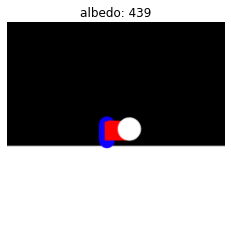

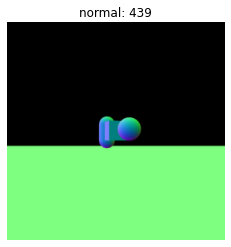

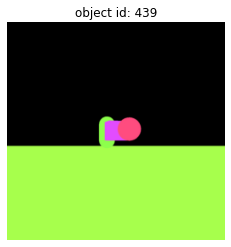

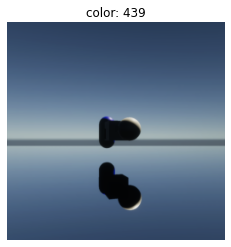

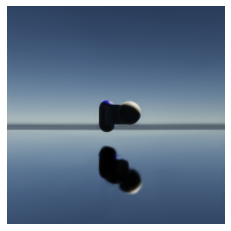

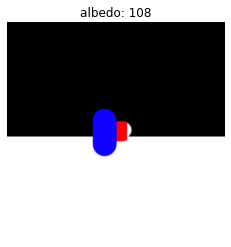

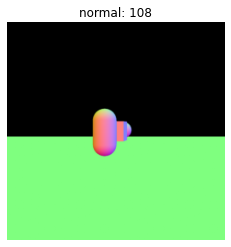

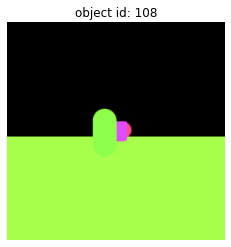

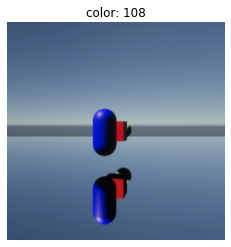

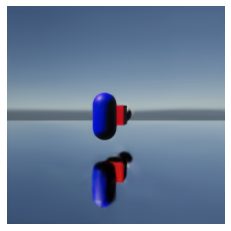

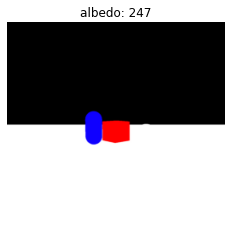

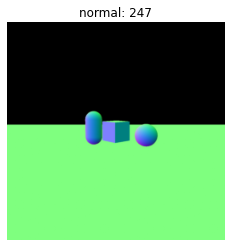

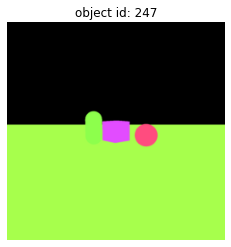

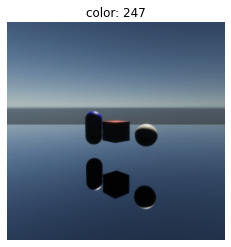

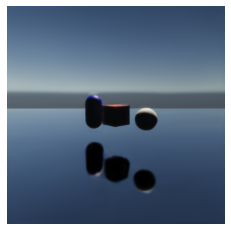

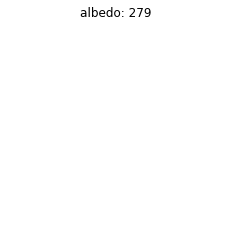

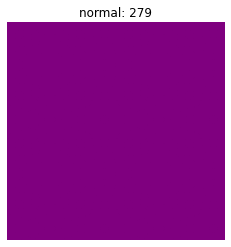

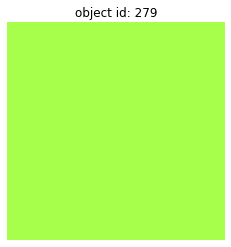

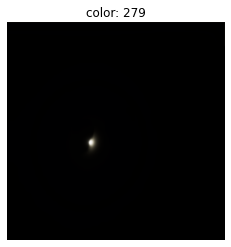

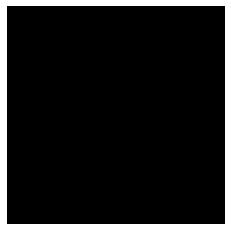

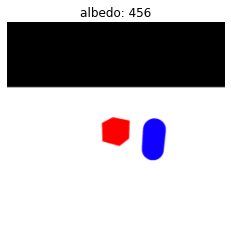

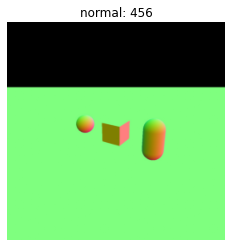

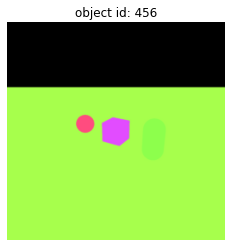

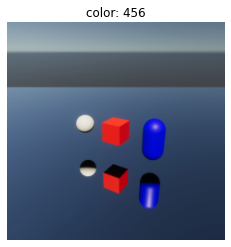

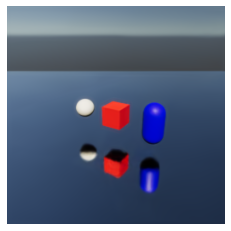

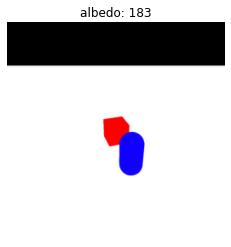

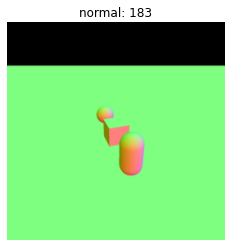

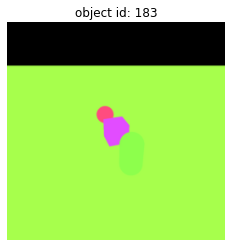

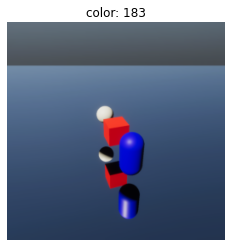

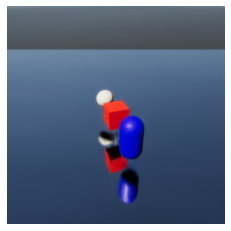

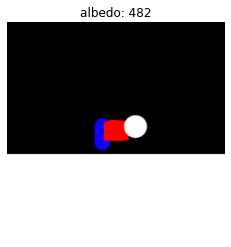

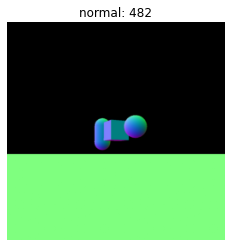

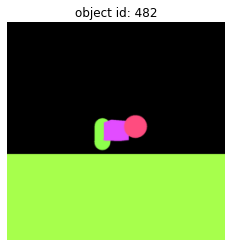

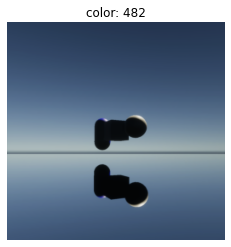

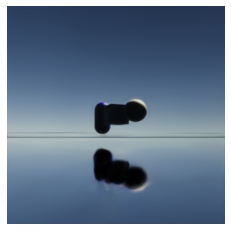

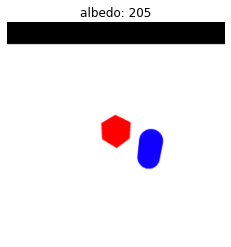

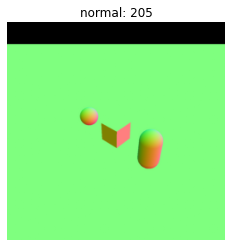

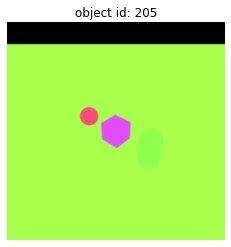

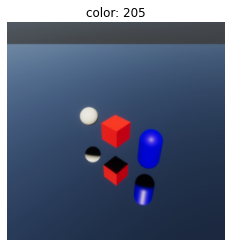

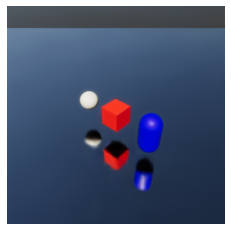

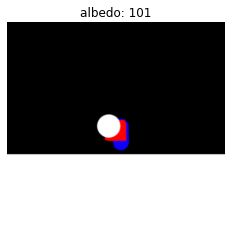

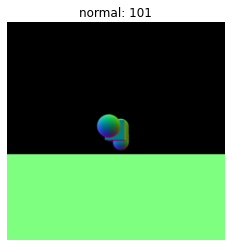

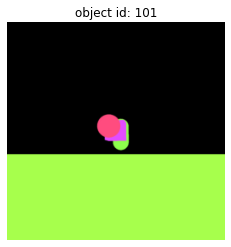

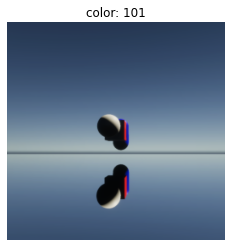

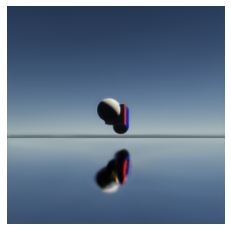

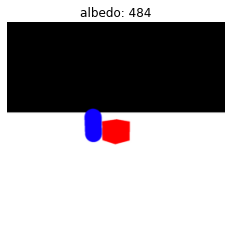

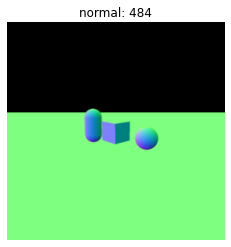

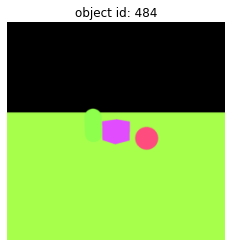

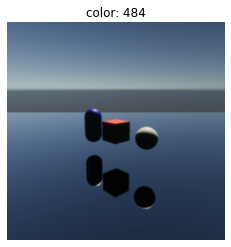

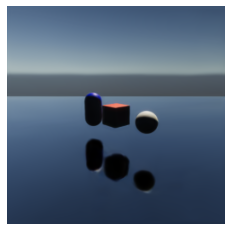

In [4]:
import random

frames = 10

for f in range(frames):
    frameid = random.randint(0, framesetCond_test.num_frames - 1)
    gen_image = modelConvVAE.generate_with_cond_frame(framesetCond_test[frameid])
    framesetCond_test[frameid].visualize()
    framesetRGB_test[frameid].visualize()
    gen_image.visualize()

In [29]:
import torch

solver.train_frameset_and_plot_losses(
    train_frameset=primitivesRGB_train, train_cond_frameset=primitivesCond_train,
    test_frameset=primitivesRGB_test, test_cond_frameset=primitivesCond_test,
    fVerbose=True)

training on frames [3265, 977, 14, 3535, 319, 941, 58, 2201, 337, 114, 3721, 146, 2222, 1112, 2037, 2284, 1414, 3587, 263, 2160, 634, 3532, 3324, 2180, 1374, 2045, 506, 836, 2698, 858, 2913, 2130, 1366, 494, 3014, 43, 380, 1995, 1930, 2443, 1475, 1813, 1303, 1624, 2769, 3069, 1525, 2955, 3154, 66, 1026, 2332, 2929, 1968, 3289, 780, 3082, 682, 486, 11, 1301, 2116, 2441, 574, 826, 602, 2405, 3797, 127, 2301, 877, 1502, 3846, 2659, 2824, 1421, 2163, 926, 3577, 1472, 2691, 1960, 485, 3651, 888, 3807, 2181, 3704, 936, 1600, 2652, 3302, 1452, 3875, 240, 3701, 3801, 2610, 3610, 2387, 1285, 704, 1642, 860, 677, 813, 894, 1352, 2006, 2770, 2530, 679, 2879, 3823, 1299, 3158, 270, 719, 328, 2984, 1014, 215, 175, 1449, 3462, 124, 600, 3694] in frameset primitivesRGB_train
testing on frames [935, 526, 294, 232, 892, 523, 789, 450, 979, 197] in frameset primitivesRGB_test
Epoch 0, Test loss 0.4859
training on frames [40, 3817, 3883, 2157, 3680, 2889, 1694, 1149, 9, 3244, 400, 1096, 3543, 1816, 484, 

testing on frames [582, 722, 912, 216, 636, 220, 39, 448, 387, 892] in frameset primitivesRGB_test
Epoch 9, Test loss 0.4407
training on frames [3551, 2396, 960, 3326, 3655, 2956, 3005, 3882, 1377, 3875, 3803, 3256, 3107, 1353, 2461, 220, 2266, 3570, 1683, 2540, 1985, 1974, 2729, 944, 2628, 1993, 88, 1632, 1714, 462, 1624, 2662, 2466, 1160, 952, 1933, 3179, 403, 3356, 2032, 3327, 197, 1462, 2464, 2045, 3539, 2146, 3366, 1771, 2145, 4, 524, 892, 1260, 3555, 45, 3174, 3871, 2588, 2669, 2834, 3190, 2681, 1741, 2306, 1316, 965, 1400, 2559, 3209, 3535, 796, 1183, 2296, 2113, 3784, 723, 931, 57, 1355, 283, 3888, 542, 2019, 3264, 2698, 26, 1766, 3614, 2392, 1765, 1983, 2447, 2472, 1113, 191, 2670, 3583, 2544, 3210, 1220, 23, 217, 1224, 1229, 3519, 3268, 2872, 896, 3342, 3389, 572, 2363, 1408, 3558, 575, 1392, 3562, 1407, 2982, 1477, 1281, 2925, 2310, 2538, 606, 895, 2690] in frameset primitivesRGB_train
testing on frames [727, 366, 10, 413, 582, 889, 561, 797, 43, 521] in frameset primitivesR

Epoch 18, Test loss 0.6287
training on frames [14, 2319, 3312, 3208, 593, 789, 1337, 3359, 1592, 3916, 347, 2269, 2580, 2165, 2311, 1410, 1205, 2497, 2408, 3873, 392, 3197, 3557, 933, 1632, 3023, 627, 2428, 1414, 3502, 811, 3608, 3617, 2979, 467, 1296, 3871, 3861, 2524, 880, 2988, 794, 94, 290, 3238, 2033, 1922, 2570, 2511, 3462, 156, 455, 2817, 3800, 3903, 2598, 312, 6, 3842, 3256, 609, 354, 3107, 2363, 3858, 2278, 1722, 217, 1343, 3249, 778, 556, 1723, 23, 1439, 1408, 3465, 3566, 2331, 2709, 2387, 2125, 2708, 2728, 1520, 174, 2219, 3240, 836, 1550, 162, 1494, 1835, 2563, 1269, 2342, 1114, 2252, 3736, 923, 906, 927, 3204, 1818, 916, 3681, 960, 1507, 3694, 3653, 3161, 1509, 3087, 673, 589, 3172, 310, 2572, 1673, 1732, 1029, 277, 1522, 1752, 490, 3542, 2724, 759] in frameset primitivesRGB_train
testing on frames [235, 474, 627, 948, 706, 443, 550, 979, 60, 514] in frameset primitivesRGB_test
Epoch 19, Test loss 0.6560
training on frames [322, 1907, 3745, 2846, 1158, 2807, 2955, 1601, 10

testing on frames [377, 328, 643, 209, 890, 761, 232, 660, 180, 381] in frameset primitivesRGB_test
Epoch 28, Test loss 0.2877
training on frames [1383, 2653, 1275, 887, 71, 3642, 293, 695, 2810, 2865, 2112, 2250, 3668, 1940, 1910, 610, 3078, 2954, 722, 3266, 1939, 2302, 2787, 3765, 2762, 2170, 1727, 2325, 1485, 2724, 1745, 2195, 2415, 138, 288, 2633, 2480, 946, 518, 974, 712, 768, 2082, 3629, 3305, 2215, 404, 3901, 827, 3862, 301, 3905, 2373, 1440, 3112, 2474, 1452, 2131, 2391, 1169, 1948, 2959, 878, 2862, 3149, 1097, 1017, 767, 1512, 2374, 1295, 549, 3783, 3504, 2968, 3321, 3409, 2708, 1112, 2664, 1866, 3442, 224, 1973, 2669, 1861, 1718, 2217, 2797, 563, 2260, 1834, 3071, 2141, 547, 3900, 3721, 2717, 1511, 3555, 3210, 1564, 1941, 362, 2554, 3430, 1513, 2508, 2299, 484, 1555, 1027, 1350, 3138, 1582, 3411, 1645, 2020, 845, 2158, 2492, 131, 2985, 1971, 34, 1987, 1011, 2912] in frameset primitivesRGB_train
testing on frames [469, 836, 822, 823, 273, 411, 455, 520, 792, 905] in frameset p

Epoch 37, Test loss 0.3745
training on frames [280, 3704, 695, 3664, 1623, 1181, 2155, 2557, 1111, 3238, 2140, 3444, 1004, 256, 2020, 3310, 1226, 754, 1340, 296, 3013, 2575, 2439, 1688, 1972, 1534, 92, 3643, 1053, 214, 3713, 2769, 633, 1589, 1982, 2165, 1672, 2050, 2425, 2381, 2994, 2011, 3320, 2619, 442, 3874, 3623, 1716, 249, 1622, 3284, 1082, 1249, 2738, 3437, 3687, 2995, 2048, 3882, 905, 2308, 1934, 3738, 2251, 3871, 999, 490, 1752, 2842, 1417, 2417, 1515, 2088, 2385, 1496, 3500, 1914, 768, 1383, 2027, 1151, 2727, 2193, 1709, 1789, 906, 3773, 3708, 2388, 1172, 1078, 767, 1739, 2173, 1777, 245, 3219, 2205, 234, 2767, 2819, 493, 2818, 571, 3506, 3017, 1457, 3907, 1662, 373, 2758, 2809, 2531, 3509, 3225, 75, 651, 2814, 3468, 2693, 3269, 2475, 3897, 3005, 3050, 2339, 137, 3539] in frameset primitivesRGB_train
testing on frames [97, 854, 720, 79, 663, 451, 949, 310, 338, 416] in frameset primitivesRGB_test
Epoch 38, Test loss 0.3855
training on frames [625, 1879, 3726, 3386, 191, 2502, 

Epoch 46, Test loss 0.3596
training on frames [3542, 338, 732, 2216, 61, 2430, 1331, 2791, 2661, 2169, 381, 3013, 2958, 2530, 2149, 1502, 275, 1707, 3901, 3739, 725, 1756, 2651, 3434, 1691, 3908, 2815, 2620, 3483, 1864, 3688, 1118, 3506, 2994, 2400, 2106, 1579, 2890, 2292, 3675, 1205, 3354, 443, 477, 2544, 3130, 3117, 1090, 1957, 1648, 3801, 2666, 595, 2111, 299, 954, 2566, 2081, 324, 452, 3121, 3813, 2362, 721, 1761, 2865, 3465, 3311, 505, 903, 3083, 2017, 3408, 516, 3126, 699, 1032, 287, 3853, 2016, 846, 948, 1069, 3154, 1431, 2474, 3, 1511, 3494, 1601, 2516, 81, 3828, 3684, 1144, 1034, 2807, 3046, 2951, 2408, 2188, 3170, 415, 16, 2991, 1639, 375, 3406, 407, 2643, 1004, 3372, 1605, 95, 2419, 590, 2506, 3691, 1974, 3026, 571, 230, 3546, 3387, 1943, 577, 3777, 3880] in frameset primitivesRGB_train
testing on frames [630, 607, 912, 708, 94, 633, 841, 775, 360, 797] in frameset primitivesRGB_test
Epoch 47, Test loss 0.4842
training on frames [583, 2115, 240, 743, 3029, 1943, 2078, 2599, 

Epoch 55, Test loss 0.1960
training on frames [2866, 2040, 1747, 566, 2925, 2559, 833, 97, 2113, 1515, 2617, 1634, 722, 1449, 633, 1436, 1008, 649, 2624, 3271, 822, 1856, 3282, 2385, 2412, 3693, 1502, 403, 125, 861, 644, 3601, 620, 342, 1769, 593, 3176, 837, 2052, 1162, 2514, 372, 491, 1841, 444, 2107, 3235, 3787, 968, 119, 662, 2592, 2259, 3302, 1707, 2032, 2001, 243, 322, 2814, 2451, 2663, 220, 3122, 1239, 1690, 3145, 2356, 2997, 1186, 3225, 967, 631, 1518, 2162, 1585, 2223, 1887, 668, 769, 3463, 383, 1542, 375, 647, 1986, 841, 3810, 1190, 1889, 3088, 2428, 273, 2459, 3865, 2346, 3089, 2904, 3359, 712, 1232, 723, 3350, 1596, 449, 3897, 352, 3177, 283, 2771, 589, 3333, 3879, 3224, 2812, 568, 1415, 1729, 1030, 3052, 3513, 891, 3431, 883, 2393, 3852, 1426, 829] in frameset primitivesRGB_train
testing on frames [330, 404, 954, 938, 139, 893, 514, 155, 371, 784] in frameset primitivesRGB_test
Epoch 56, Test loss 0.7786
training on frames [1117, 1446, 963, 2857, 2466, 1058, 2937, 1270, 239

testing on frames [709, 453, 568, 258, 862, 931, 27, 749, 157, 598] in frameset primitivesRGB_test
Epoch 65, Test loss 0.1674
training on frames [1233, 421, 3396, 3754, 3787, 266, 2588, 1199, 3585, 1017, 2091, 332, 3818, 3589, 2929, 268, 955, 1011, 365, 2561, 826, 2601, 344, 1713, 2431, 2688, 425, 443, 3892, 3263, 2205, 1045, 2512, 2056, 318, 3861, 545, 2439, 1223, 3776, 1532, 849, 1357, 2080, 2662, 672, 1802, 1433, 3736, 3782, 770, 3783, 1974, 3889, 1471, 1950, 2562, 321, 2453, 277, 307, 977, 1585, 2191, 3696, 337, 1198, 3593, 2954, 1031, 1978, 2079, 645, 2859, 1712, 157, 168, 1062, 199, 2086, 1767, 729, 1949, 1769, 3701, 3346, 1051, 2473, 2901, 207, 2328, 3449, 2522, 2226, 848, 2992, 2667, 1197, 2122, 983, 2510, 1960, 3594, 470, 966, 3459, 812, 1449, 77, 1452, 416, 510, 3597, 163, 1588, 2841, 3719, 961, 1424, 2148, 2849, 2534, 2465, 1300, 418, 2766, 3437, 3731] in frameset primitivesRGB_train
testing on frames [835, 264, 192, 196, 799, 372, 256, 885, 457, 146] in frameset primitivesR

BufferError: 

In [1]:
from repos.pyjunk.junktools.CameraView import CameraView
import math

theta = 2.0 * math.pi 
phi = 0.0
radius = 5.0

x_pos = radius * math.cos(2.0 * math.pi * (theta)) 
z_pos = radius * math.sin(2.0 * math.pi * (theta))
y_pos = radius * ((phi) * 2.0 - 1.0) * (.6)
norm = math.sqrt(x_pos ** 2 + y_pos ** 2 + z_pos ** 2)
x_pos = (x_pos / norm) * radius
y_pos = (y_pos / norm) * radius
z_pos = (z_pos / norm) * radius

camView = CameraView(ptPosition=(x_pos, y_pos, z_pos))
gen_image = modelConvVAE.generate_with_view(camView)
gen_image.visualize()

NameError: name 'modelConvVAE' is not defined

t:  17%|█▋        | 20/121 [00:00<00:00, 199.68it/s, now=None]

rendered 60 frames at 92.87746747334798 microseconds/frame that's 10.76687411063355 frames per second
MoviePy - Building file spatial_view_conv_cond_vae.gif with imageio.


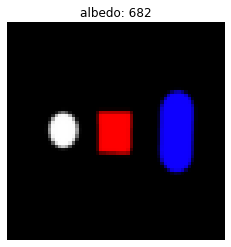

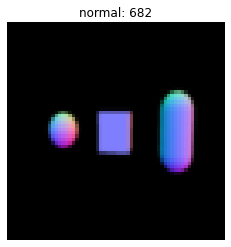

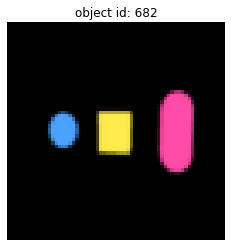

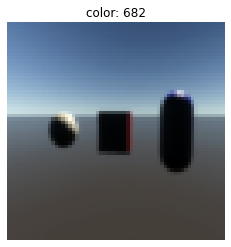

In [42]:
#!pip install moviepy

from repos.pyjunk.junktools.CameraView import CameraView
import math
from moviepy.editor import ImageSequenceClip
import numpy as np
import time

num_divs_horz = 60
radius_start = 1.0
radius_end = 10.0
radius_inc = (radius_start - radius_end) / (num_divs_horz)
radius = radius_start
fps = 12
scale = 1.0
strFilename = "spatial_view_conv_cond_vae.gif"

npGifBuffers = []

start_time = time.time()

#frameid = random.randint(0, primitivesCond_test.num_frames - 1)
frameid = 10
primitivesCond_test[frameid].visualize()
primitivesRGB_test[frameid].visualize()

for theta in range(num_divs_horz * 2):
    x_pos = radius * math.cos(2.0 * math.pi * (theta / num_divs_horz)) 
    z_pos = radius * math.sin(2.0 * math.pi * (theta / num_divs_horz))
    #y_pos = radius * ((phi / num_divs_vert) * 2.0 - 1.0) * (.6)
    y_pos = 0.0
    norm = math.sqrt(x_pos ** 2 + y_pos ** 2 + z_pos ** 2)
    x_pos = (x_pos / norm) * radius
    y_pos = (y_pos / norm) * radius
    z_pos = (z_pos / norm) * radius

    camView = CameraView(ptPosition=(x_pos, y_pos, z_pos))
    #camView.Print()

    gen_image = modelConvVAE.generate_with_cond_frame_and_view(primitivesCond_test[frameid], camView)
    #gen_image.visualize()

    #npBuffer = gen_image.GetNumpyBuffer().transpose(2, 0, 1)
    npBuffer = gen_image.GetNumpyBuffer() * 255.0
    #npBuffer = numpy.clip(npBuffer, 0, 255)
    #print(npBuffer.shape)
    npGifBuffers.append(np.array(npBuffer))

    radius += radius_inc

end_time = time.time()
num_frames = num_divs_horz
time_per_frame = ((end_time - start_time)/num_frames) 
fps = 1./time_per_frame
time_per_frame *= 1000.0 # ms
print("rendered %s frames at %s milliseconds/frame that's %s frames per second" % (num_frames, time_per_frame, fps))

if(fps > 30):
    fps = 30

# make the moviepy clip
clip = ImageSequenceClip(npGifBuffers, fps = fps).resize(scale)
clip.write_gif(strFilename, fps = fps)